In [1]:
import os, json, time, datetime, random, glob, shutil
from pathlib import Path
from typing import Dict, Any
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import torch
from cnn_model import run_hyperparameter_search, evaluate_on_test, TimeSeriesDataset, CNNRegressor, train_model, split_LOPO
from torch.utils.data import DataLoader
import neurokit2 as nk  # pip install neurokit2
import seaborn as sns
from ml_dataloader import process_physiology_data, extract_raw_physio_windows
from ml_utils import (
    set_reproducible, dbg, to_NTC_strict, sample_or_load_fixed_test_pids,
    make_participant_disjoint_masks, assert_no_pid_overlap, run_planA_one_mode,
    negative_controls_once, summarize_split_scores, ensure_dir, center_from_train_split,
    write_seed_metrics_csv, count_lstm_params, make_masks_from_fixed_test, recipe_for,
    hv_mask_from_train_x, hv_mask_from_train_y, apply_per_split_mask, assert_no_pid_overlap,
    set_seed, split_across_with_gap, to_loader, plot_train_val_loss,_transform_scenewise,_quick_check,_fit_scene_stats,_safe_mean_std
)
from ml_pipeline import (
        run_ablation, select_features_by_ablation, run_grid_search,
        train_and_evaluate_seeds, summarize_test_results
    )

from ml_utils import (center_from_train_split, apply_lag_timeseries, lag_sweep_cv_timeseries, 
                      evaluate_binary_for_all_seeds_from_npz, evaluate_binary_for_all_seeds_from_npz,
                      binarize_with_thresholds,make_binary_thresholds_from_train, estimate_modality_scene_lags_fft,
                      apply_modality_scene_lags, make_delta_labels)
import re

## Dataloader

In [26]:
extract_raw_physio_windows(
    data_path="D:/Labroom/SDphysiology/Data/processed_individual_anonymized",
    output_path="./ml_processed_Elevator",
    window_seconds=5,          # 일단 기존 5초/2초 유지
    stride_seconds=2,
    sampling_rate=60,
    scenes=["Elevator1", "Elevator2"],
    # scenes=["Hallway"],
    

    # 🔵 고주파 feature 확장 거의 OFF
    enable_feature_expansion = False,   # 베이스 파이프라인은 그대로 쓰되,
    fe_diff_orders = (),               # 차분 X
    fe_ma_seconds = (),                # 짧은 MA X
    fe_std_seconds = (),               # std X
    fe_enable_slope = False,           # 고주파 slope X
    fe_enable_iqr = False,             # IQR X
    fe_enable_band_energy = False,     # bandpower X

    # 🔵 타깃 smoothing은 그대로
    enable_target_smoothing=True,
    target_smoothing_method="ema",
    target_smoothing_steps=300,        # ≈5초
    smooth_before_zscore=True,

    # 🔵 저주파 bundle만 소량 유지
    fe_enable_lowfreq_bundle=True,
    fe_lowfreq_targets=("EDA_Tonic", "RSP_Rate", "PPG_Rate", "pupilL"),
    fe_lowfreq_spec={
        # 너무 많이 안 쓰고 3개 정도 scale만
        "ema_taus":   [6.0, 18.0],      # 6초, 18초 정도
        "slope_secs": [10.0, 20.0],     # 10~20초 기울기
        "use_bandpower": False
    },

    # 개별 lf_* 확장은 끔 (bundle에서만 생성)
    lf_ema_seconds = (),
    lf_slope_seconds = (),

    # 🔵 signal baseline은 그대로
    baseline_mode_signals="scene_medmad",
    baseline_mode_target=None,
    baseline_first_seconds=10,
    mad_c=1.4826
)


Extracting Raw Signals: 100%|██████████| 108/108 [01:44<00:00,  1.03it/s]


✅ 저장 완료: ./ml_processed_Elevator
📊 X shape: (21954, 11, 300) | y shape: (21954,) | #PIDs: 106
🧩 Channels: 11 | (예: ['EDA_Tonic' 'EDA_Phasic' 'SCR_Amplitude' 'SCR_RiseTime' 'PPG_Rate'
 'RSP_Rate' 'RSP_RVT' 'RSP_Amplitude' 'pupilL' 'pupilR'])
📝 saved: scene_array.npy, windex_array.npy, feature_tag_list.npy, meta.json


In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

from behavior_features import (
    ColumnMapping,
    compute_agent_player_relations,
    make_behavior_windows,
)
from behavior_utils import PERSONAL_ZONES_DEFAULT
from ml_dataloader import interpolate_downsample  # 이미 정의되어 있음 (현재는 사용 X)

# -------------------------------------------------
# 0) 설정
# -------------------------------------------------
DATA_DIR = r"D:/LabRoom/SDPhysiology/Data/Processed/processed_individual_anonymized"

# Physio 윈도우와 맞추고 싶은 scene들 (이번에는 Elevator1, Elevator2만 사용)
TARGET_SCENES = ["Elevator1", "Elevator2"]
# TARGET_SCENES = ["Elevator1","Outside","Hallway","Hall", "Elevator2"]
# TARGET_SCENES = ["Hallway"]



# 🔹 behavior를 60Hz로 맞춤
FS_BEHAV    = 60.0    # 최종 behavior 샘플링 레이트
ORIGINAL_HZ = 120.0   # Main/Agent/Customevent 가 존재하는 원래 Hz

WINDOW_SECONDS = 5.0
STRIDE_SECONDS = 2.0

# 🔹 결과 저장 폴더
OUT_DIR = "./behavior_Elevator"
os.makedirs(OUT_DIR, exist_ok=True)

cols = ColumnMapping()


# -------------------------------------------------
# 1) 120Hz → 60Hz downsample helper
# -------------------------------------------------
def downsample_120_to_60_scenewise(df: pd.DataFrame, cols: ColumnMapping, factor: int = 2) -> pd.DataFrame:
    """
    120Hz → 60Hz로 내릴 때,
    - scene/frame 기준 정렬 후
    - scene별로 2프레임마다 하나씩만 남긴다.
    - ⚠ Frame 값은 "원본 Frame"을 유지해서 Customevent와 sync를 유지함.
    """
    if df.empty:
        return df.copy()

    df = df.sort_values([cols.scene, cols.frame]).reset_index(drop=True)

    pieces = []
    for sc, df_sc in df.groupby(cols.scene, sort=False):
        df_sub = df_sc.iloc[::factor].copy()
        pieces.append(df_sub)

    df_ds = pd.concat(pieces, ignore_index=True)

    # ✅ 더 이상 Frame을 0..N-1로 재부여하지 않음
    return df_ds

from typing import Tuple, Optional

def _process_one_pid(
    pid_str: str,
    cols: ColumnMapping,
    *,
    data_dir: str,
    target_scenes,
    fs_beh: float,
    window_seconds: float,
    stride_seconds: float,
    ce_feat_names,
):
    """
    한 명 PID에 대해:
      - Main/Agent/Customevent 로드
      - scene 필터 + downsample
      - compute_agent_player_relations
      - make_behavior_windows + y_win 계산
    까지 수행하고 결과를 반환.

    에러나 데이터 없음 → None 반환.
    """
    main_path  = os.path.join(data_dir, f"{pid_str}_Main.pkl")
    agent_path = os.path.join(data_dir, f"{pid_str}_Agent.pkl")
    ce_path    = os.path.join(data_dir, f"{pid_str}_Customevent.pkl")

    if (not os.path.exists(main_path)) or (not os.path.exists(agent_path)):
        print(f"[WARN] Missing Main/Agent for PID={pid_str}, skipping.")
        return None

    if not os.path.exists(ce_path):
        print(f"[WARN] Missing Customevent for PID={pid_str}, skipping.")
        return None

    main_df = pd.read_pickle(main_path)
    agent_df = pd.read_pickle(agent_path)
    ce_df = pd.read_pickle(ce_path)

    # 1) scene 필터 (Elevator1, Elevator2만)
    main_df  = main_df[main_df[cols.scene].isin(target_scenes)].copy()
    agent_df = agent_df[agent_df[cols.scene].isin(target_scenes)].copy()
    ce_df    = ce_df[ce_df[cols.scene].isin(target_scenes)].copy()

    if main_df.empty:
        print(f"[INFO] PID={pid_str}: no TARGET_SCENES in Main, skip.")
        return None

    # 2) 120Hz → 60Hz 다운샘플 (Frame 값은 그대로 유지)
    main_60  = downsample_120_to_60_scenewise(main_df,  cols=cols, factor=2)
    agent_60 = downsample_120_to_60_scenewise(agent_df, cols=cols, factor=2)

    # 3) per-frame behavior TS 계산
    df_ts = compute_agent_player_relations(
        main_60,
        agent_60,
        cols=cols,
        zones=PERSONAL_ZONES_DEFAULT,
        fov_deg=110.0,
        dt=1.0 / fs_beh,
    )
    df_ts = df_ts.drop(columns=['X_pos', 'Z_pos', 'Y_rot'], errors='ignore')

    # 4) per-frame anxiety 붙이기
    if "anxiety" not in main_60.columns:
        print(f"[WARN] PID={pid_str}: 'anxiety' column missing in Main, skip.")
        return None

    main_60 = main_60.sort_values([cols.scene, cols.frame]).reset_index(drop=True)
    df_ts   = df_ts.sort_values([cols.scene, cols.frame]).reset_index(drop=True)

    len_main = len(main_60)
    len_ts   = len(df_ts)
    min_len  = min(len_main, len_ts)
    if len_main != len_ts:
        print(f"[INFO] PID={pid_str}: len(main_60)={len_main}, len(df_ts)={len_ts} → truncate to {min_len}")

    df_ts   = df_ts.iloc[:min_len].reset_index(drop=True)
    y_frame = main_60["anxiety"].to_numpy(dtype=float)[:min_len]

    df_ts["y_cont"] = y_frame

    # 5) feature_cols: scene/frame/y_cont/raw gaze 제외 + CE 컬럼명까지 미리 포함
    base_cols = [
        c for c in df_ts.columns
        if c not in (cols.scene, cols.frame, "y_cont",
                     getattr(cols, "gaze_x", "gaze_mean_x"),
                     getattr(cols, "gaze_y", "gaze_mean_y"))
    ]
    feature_cols = base_cols + ce_feat_names

    # 6) behavior+CE+gaze window 만들기
    win_len = int(window_seconds * fs_beh)
    hop     = int(stride_seconds * fs_beh)

    X_beh, pid_arr, scene_arr, widx_arr = make_behavior_windows(
        df_ts,
        cols=cols,
        window_seconds=window_seconds,
        stride_seconds=stride_seconds,
        sampling_rate=fs_beh,
        pid_value=pid_str,
        scene_filter=target_scenes,
        feature_cols=feature_cols,
        ce_df=ce_df,
    )

    if X_beh.size == 0:
        print(f"[INFO] PID={pid_str}: no behavior windows, skip.")
        return None

    # 7) y_window (anxiety mean) 계산
    y_win_list     = []
    scene_win_list = []

    scene_order = df_ts[cols.scene].drop_duplicates().tolist()

    for sc in scene_order:
        df_sc = df_ts[df_ts[cols.scene] == sc].copy()
        if df_sc.empty:
            continue
        df_sc = df_sc.sort_values(cols.frame).reset_index(drop=True)
        y_arr = df_sc["y_cont"].to_numpy(dtype=float)

        start = 0
        while start + win_len <= len(y_arr):
            end = start + win_len
            y_win_list.append(y_arr[start:end].mean())
            scene_win_list.append(sc)
            start += hop

    y_win     = np.array(y_win_list, dtype=float)
    scene_win = np.array(scene_win_list, dtype=object)

    if y_win.shape[0] != X_beh.shape[0]:
        print(f"[WARN] PID={pid_str}: y_win({y_win.shape[0]}) != X_beh({X_beh.shape[0]}), skip this PID.")
        return None

    if scene_arr.shape[0] == scene_win.shape[0]:
        assert np.all(scene_arr == scene_win), \
            f"씬 순서가 X_beh와 y_win에서 다릅니다! PID={pid_str}"

    return X_beh, y_win, pid_arr, scene_arr, widx_arr, feature_cols


from joblib import Parallel, delayed

# -------------------------------------------------
# 2) behavior + Customevent 윈도우 추출 메인 루프
# -------------------------------------------------
def build_behavior_windows_60hz():
    pids = sorted({f[:3] for f in os.listdir(DATA_DIR) if f.endswith("_Main.pkl")})
    
    print("Total participants:", len(pids), pids[:10])

    X_beh_all   = []
    y_beh_all   = []
    pid_all     = []
    scene_all   = []
    widx_all    = []

    feature_names = None

    # window 길이/stride
    win_len = int(WINDOW_SECONDS * FS_BEHAV)
    hop     = int(STRIDE_SECONDS * FS_BEHAV)

    gaze_feat_names = [
        "gaze_disp_mean",
        "gaze_disp_std",
        "gaze_disp_min",
        "gaze_disp_max",
        "gaze_disp_median",
        "gaze_jitter_std",
        "gaze_var_x",
        "gaze_var_y",
        "gaze_entropy",
    ]
    ce_feat_names = [
        "CE_goal_visible",
        # "CE_floor",
        # "CE_floor_phase",
        # "CE_crowd_delta",
        # "CE_floor_is_baseline",
    ]

    # -------------------------
    # 병렬 처리
    # -------------------------
    results = Parallel(n_jobs=4, backend="loky")(  # n_jobs는 CPU 코어 수에 맞게 조절
        delayed(_process_one_pid)(
            pid_str,
            cols,
            data_dir=DATA_DIR,
            target_scenes=TARGET_SCENES,
            fs_beh=FS_BEHAV,
            window_seconds=WINDOW_SECONDS,
            stride_seconds=STRIDE_SECONDS,
            ce_feat_names=ce_feat_names,
        )
        for pid_str in pids
    )

    # -------------------------
    # 결과 모으기
    # -------------------------
    for out in results:
        if out is None:
            continue
        X_beh, y_win, pid_arr, scene_arr, widx_arr, feature_cols = out

        if feature_names is None:
            # 여기서 정확한 feature 이름 복원
            feature_names = feature_cols + gaze_feat_names


        X_beh_all.append(X_beh)
        y_beh_all.append(y_win)
        pid_all.append(pid_arr)
        scene_all.append(scene_arr)
        widx_all.append(widx_arr)

    if not X_beh_all:
        raise RuntimeError("No behavior+CE windows were generated.")

    X_beh_all   = np.concatenate(X_beh_all, axis=0)
    y_beh_all   = np.concatenate(y_beh_all, axis=0)
    pid_all     = np.concatenate(pid_all, axis=0)
    scene_all   = np.concatenate(scene_all, axis=0)
    widx_all    = np.concatenate(widx_all, axis=0)

    print("[Behavior+CE] X_all:", X_beh_all.shape)
    print("[Behavior+CE] y_all:", y_beh_all.shape)

    np.save(os.path.join(OUT_DIR, "X_behavior_ce_60hz.npy"),   X_beh_all)
    np.save(os.path.join(OUT_DIR, "y_behavior_ce_60hz.npy"),   y_beh_all)
    np.save(os.path.join(OUT_DIR, "pid_behavior_ce_60hz.npy"), pid_all)
    np.save(os.path.join(OUT_DIR, "scene_behavior_ce_60hz.npy"), scene_all)
    np.save(os.path.join(OUT_DIR, "widx_behavior_ce_60hz.npy"), widx_all)
    np.save(os.path.join(OUT_DIR, "feature_behavior_ce_60hz.npy"),
            np.array(feature_names, dtype=object))

    print(f"✅ Saved 60Hz behavior + Customevent dataset for Elevator1+2 at: {OUT_DIR}")

if __name__ == "__main__":
    build_behavior_windows_60hz()


Total participants: 108 ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010']


In [ ]:
import os
import numpy as np
import pandas as pd

PHYSIO_DIR = "./ml_processed_Elevator"  # 실제 경로
BEHAV_DIR = "./behavior_Elevator"  # 실제 경로
def merge_physio_behavior():
    # ---- physio 로드 ----
    X_p = np.load(os.path.join(PHYSIO_DIR, "X_array.npy"))      # [N_p, C_p, T] 또는 [N_p, F_p]
    y_p = np.load(os.path.join(PHYSIO_DIR, "y_array.npy"))      # [N_p]
    pid_p = np.load(os.path.join(PHYSIO_DIR, "pid_array.npy"))  # [N_p]
    scene_p = np.load(os.path.join(PHYSIO_DIR, "scene_array.npy"))
    widx_p = np.load(os.path.join(PHYSIO_DIR, "windex_array.npy"))

    # ---- behavior 로드 ----
    X_b = np.load(os.path.join(BEHAV_DIR, "X_behavior_ce_60hz.npy"),allow_pickle=True)
    y_b = np.load(os.path.join(BEHAV_DIR, "y_behavior_ce_60hz.npy"),allow_pickle=True)
    pid_b = np.load(os.path.join(BEHAV_DIR, "pid_behavior_ce_60hz.npy"),allow_pickle=True)
    scene_b = np.load(os.path.join(BEHAV_DIR, "scene_behavior_ce_60hz.npy"),allow_pickle=True)
    widx_b = np.load(os.path.join(BEHAV_DIR, "widx_behavior_ce_60hz.npy"),allow_pickle=True)

    # ---- key 만들기 ----
    key_p = list(zip(pid_p.astype(str), scene_p.astype(str), widx_p.astype(int)))
    key_b = list(zip(pid_b.astype(str), scene_b.astype(str), widx_b.astype(int)))

    # physio 쪽 key → index map
    phys_index = {k: i for i, k in enumerate(key_p)}

    sel_phys_idx = []
    sel_beh_idx  = []
    missing_cnt  = 0

    for i, k in enumerate(key_b):
        j = phys_index.get(k, None)
        if j is None:
            missing_cnt += 1
            continue
        sel_beh_idx.append(i)
        sel_phys_idx.append(j)

    print(f"[Merge] matched windows: {len(sel_phys_idx)}")
    print(f"[Merge] behavior windows without physio match: {missing_cnt}")

    # numpy 인덱싱
    sel_phys_idx = np.array(sel_phys_idx, dtype=int)
    sel_beh_idx  = np.array(sel_beh_idx, dtype=int)

    X_p_sel = X_p[sel_phys_idx]
    y_sel   = y_p[sel_phys_idx]           # 최종 타깃은 physio 쪽 y 사용
    pid_sel   = pid_p[sel_phys_idx]
    scene_sel = scene_p[sel_phys_idx]
    widx_sel  = widx_p[sel_phys_idx]

    X_b_sel = X_b[sel_beh_idx]

    # ---- physio feature shape(예: [N, C, T])에 따라 병합 방식 결정 ----
    # 1) 이미 physio가 [N, F_p] (벡터)면 바로 concat
    if X_p_sel.ndim == 2:
        X_merged = np.concatenate([X_p_sel, X_b_sel], axis=1)

    # 2) physio가 [N, C, T]면, 윈도우마다 평균이나 flatten해서 합치기
    elif X_p_sel.ndim == 3:
        N, C, T = X_p_sel.shape
        # 예시: time-dimension 평균 후 concat
        X_p_mean = X_p_sel.mean(axis=2)  # [N, C]
        X_merged = np.concatenate([X_p_mean, X_b_sel], axis=1)
    else:
        raise ValueError(f"Unexpected physio X shape: {X_p_sel.shape}")

    print("[Merge] X_merged shape:", X_merged.shape)
    print("[Merge] y_sel shape:", y_sel.shape)
    # ---- 저장 ----
    np.save("X_physio_behavior_merged.npy", X_merged)
    np.save("y_physio_behavior_merged.npy", y_sel)
    np.save("pid_physio_behavior.npy", pid_sel)
    np.save("scene_physio_behavior.npy", scene_sel)
    np.save("widx_physio_behavior.npy", widx_sel)

    print("✅ Saved merged physio+behavior dataset!")
    return X_merged, y_sel, pid_sel, scene_sel, widx_sel


if __name__ == "__main__":
    X_merged, y_sel, pid_sel, scene_sel, widx_sel =merge_physio_behavior()


[Merge] matched windows: 12355
[Merge] behavior windows without physio match: 126
[Merge] X_merged shape: (12355, 74)
[Merge] y_sel shape: (12355,)
✅ Saved merged physio+behavior dataset!


In [ ]:
# 예: X_merged가 numpy array라면, 우리가 feature 이름을 따로 관리해야 함
# merge 단계에서 behavior feature_tags, physio feature_tags를 알고 있다고 가정

# 1) behavior feature 이름 (behavior 생성 코드에서 만든 feature_names)
# ex) feature_behavior_60hz.npy 로 저장했을 것
behavior_tags = np.load(f"{BEHAV_DIR}/feature_behavior_ce_60hz.npy", allow_pickle=True).tolist()

# 2) physio feature 이름 (기존 ml_processed_all의 feature_tag_list)
physio_tags = np.load(f"{PHYSIO_DIR}/feature_tag_list.npy", allow_pickle=True).tolist()

# 3) 병합 순서 그대로 합치기
feat_tags_merged = physio_tags + behavior_tags

# 4) 저장
OUT_DIR = "ml_processed_behavior_Elevator"
os.makedirs(OUT_DIR, exist_ok=True)

np.save(f"{OUT_DIR}/feature_tag_list.npy",
        np.array(feat_tags_merged, dtype=object))

print("세이브 완료, 총 feature:", len(feat_tags_merged))

import os
import numpy as np

# merge 결과 (당신 코드 기준으로 변수명 맞춰서 쓰면 됨)
# 예시: X_merged, y_sel, pid_sel, scene_sel, widx_sel, feat_tags_merged
N, F = X_merged.shape

os.makedirs(OUT_DIR, exist_ok=True)

# 1) X: (N, F) → (N, 1, F)  (T=1)
X_array = X_merged.astype(np.float32).reshape(N, 1, F)
np.save(os.path.join(OUT_DIR, "X_array.npy"), X_array)

# 2) y
np.save(os.path.join(OUT_DIR, "y_array.npy"), y_sel.astype(np.float32))

# 3) pid / scene / windex
np.save(os.path.join(OUT_DIR, "pid_array.npy"),   pid_sel)
np.save(os.path.join(OUT_DIR, "scene_array.npy"), scene_sel)
np.save(os.path.join(OUT_DIR, "windex_array.npy"), widx_sel)

# 4) feature tag list (27개 이름)
np.save(os.path.join(OUT_DIR, "feature_tag_list.npy"),
        np.array(feat_tags_merged, dtype=object))

print("✅ Saved merged dataset for GRU at:", OUT_DIR)
print("X_array shape:", X_array.shape)  # (N, 1, F)

세이브 완료, 총 feature: 74
✅ Saved merged dataset for GRU at: ml_processed_behavior_Hallway
X_array shape: (12355, 1, 74)


## Window 5 stride 2 30hz_Hallway

In [ ]:
import torch
import os
# -*- coding: utf-8 -*-
# Leakage-safe main (lag OFF / (N,T,C) / publication-ready)
# - Split FIRST (GAP=10), then derive ALL thresholds/statistics from TRAIN ONLY
# - Train-derived HV mask (default: X-variance), Train-only target centering
# - External-val grid (no internal split), seed ensemble (10) for final report
# - Deterministic settings for reproducibility

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["PYTHONHASHSEED"] = "42"

# Reproducibility / determinism
torch.set_float32_matmul_precision("high")  # set "highest" to disable TF32 if needed
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
try:
    torch.use_deterministic_algorithms(True, warn_only=True)
except Exception:
    pass

seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(seed)

In [ ]:
# ml_pipeline.py
# Across-participant regression (and optional binary) pipeline
# - Behavior: lag OFF  (APPLY_LAG = False)
# - Physio : lag ON   (APPLY_LAG = True, modality×scene 통계적 global lag 사용)

# ============================================================
# 0) User config (only edit this part)
# ============================================================
TARGET_MODE = "level"        # {"level", "delta"}
LABEL_MODE  = "regression"   # {"regression", "binary"}
scene       = "Elevator"    # {"all","Hallway","Elevator","Outside","Hall"}
model_type  = "GRU"          # {"CNN","GRU","GRU_Attn","LSTM"}
DATA_DIR    = f"ml_processed_behavior_{scene}"
OUT_DIR     = f"results_planA_fixed_test_{model_type}"

# Split / masking policy
VAL_RATIO   = 0.20
GAP_STEPS   = 5              # 5 steps @2s hop = 10s gap
HV_MODE     = "y_train"      # {"x_variance","y_train","none"}
HV_QUANTILE = 0.3

# Lag policy
APPLY_LAG       = False      # Behavior: False / Physio: True
STRIDE_SECONDS  = 2.0        # window stride in seconds (for lag & widx)

# Seeds / Epochs
SEED_MASTER     = 42
NUM_SEEDS_FINAL = 5
EPOCHS_FINAL    = 150

# Early stopping
patience_ablation   = 10; min_delta_ablation = 1e-6
patience_grid       = 7 ; min_delta_grid     = 1e-5
patience_train      = 15; min_delta_train    = 5e-4

# Ablation: False | "Mini" | True(full)
RUN_ABLATION    = False
ABLATION_EPOCHS = 10   # full ablation epochs (RUN_ABLATION=True일 때 사용)

# Grid search toggle
RUN_GRID        = False
GRID_EPOCHS     = 20

# Fine-tune option (for within-participant 확장용 – 현재는 across만 사용)
USE_ACROSS_FINAL_CKPTS = True
FINETUNE_VAL_FRACTION  = 0.20
FINETUNE_EPOCHS        = 8
FINETUNE_PATIENCE      = 3

# Negative controls (Default OFF)
RUN_NEGCTRL = False


# ============================================================
# 1) Reproducibility & Device
# ============================================================
os.makedirs(OUT_DIR, exist_ok=True)

random.seed(SEED_MASTER)
np.random.seed(SEED_MASTER)
torch.manual_seed(SEED_MASTER)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED_MASTER)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ts_tag = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


# ============================================================
# 2) Model-specific parameter space
# ============================================================
FIXED_DEFAULTS: Dict[str, Dict[str, Any]] = {
    "CNN": {
        "num_filters": 64,
        "kernel_size": 5,
        "dropout": 0.3,
        "batch_size": 32,
        "learning_rate": 1e-3,
        # "input_channels": new_C  # runtime injection
    },
    # 원래 GRU 기본 세팅 (참고용으로 주석 유지)
    # "GRU": {
    #     "hidden_size": 64,
    #     "num_layers": 1,
    #     "dropout": 0.3,
    #     "batch_size": 32,
    #     "learning_rate": 1e-3,
    #     # "input_size": C  # runtime injection
    # },
    # 현재 임시 best param (grid skip 시 사용)
    "GRU": {
        "hidden_size": 128,
        "num_layers": 2,
        "dropout": 0.3,
        "batch_size": 32,
        "learning_rate": 3e-4,
        # "input_size": C
    },
    "GRU_Attn": {
        "hidden_size": 64,
        "num_layers": 1,
        "dropout": 0.3,
        "batch_size": 32,
        "learning_rate": 1e-3,
        # "input_size": C
    },
    "LSTM": {
        "hidden_size": 64,
        "num_layers": 1,
        "dropout": 0.3,
        "batch_size": 32,
        "learning_rate": 1e-3,
        # "input_size": C
    },
}

SEARCH_SPACES: Dict[str, Dict[str, Any]] = {
    "CNN": {
        "num_filters": [16, 32, 64],
        "kernel_size": [3, 5, 7],
        "dropout": [0.3, 0.4, 0.5, 0.6],
        "batch_size": [32],
        "learning_rate": [1e-3, 3e-4, 1e-4],
    },
    "GRU": {
        "hidden_size": [32, 64, 128],
        "num_layers": [1, 2],
        "dropout": [0.2, 0.3, 0.4, 0.5, 0.6],
        "batch_size": [32],
        "learning_rate": [1e-3, 3e-4, 1e-4],
    },
    "GRU_Attn": {
        "hidden_size": [32, 64, 128],
        "num_layers": [1, 2],
        "dropout": [0.2, 0.3, 0.4, 0.5, 0.6],
        "batch_size": [32],
        "learning_rate": [1e-3, 3e-4, 1e-4],
    },
    "LSTM": {
        "hidden_size": [32, 64, 128],
        "num_layers": [1, 2],
        "dropout": [0.2, 0.3, 0.4, 0.5, 0.6],
        "batch_size": [32],
        "learning_rate": [1e-3, 3e-4, 1e-4],
    },
}

HEAD_NAMES_PER_MODEL = {
    "CNN":      ["head", "fc", "out", "regressor"],
    "GRU":      ["head", "fc", "out", "regressor"],
    "GRU_Attn": ["head", "fc", "out", "regressor", "proj"],
    "LSTM":     ["head", "fc", "out", "regressor"],
}

assert model_type in FIXED_DEFAULTS, f"Unknown model_type: {model_type}"


# ============================================================
# 3) Data load  +  TARGET_MODE (level / delta)  +  (N,T,C)
# ============================================================
X = np.load(os.path.join(DATA_DIR, "X_array.npy"))          # (N,C,T) or (N,T,C)
y = np.load(os.path.join(DATA_DIR, "y_array.npy")).astype(np.float32)
pid = np.load(os.path.join(DATA_DIR, "pid_array.npy"))
scene = np.load(os.path.join(DATA_DIR, "scene_array.npy"))
widx = np.load(os.path.join(DATA_DIR, "windex_array.npy"))
feature_tag_list = np.load(
    os.path.join(DATA_DIR, "feature_tag_list.npy"),
    allow_pickle=True
).tolist()

if TARGET_MODE == "level":
    # 그대로 사용
    pass

elif TARGET_MODE == "delta":
    # y 자체에서 delta 생성 (이전 bug: y_raw 미정 사용 → 수정)
    y_delta, valid = make_delta_labels(y, pid, scene, widx)
    X     = X[valid]
    y     = y_delta[valid]
    pid   = pid[valid]
    scene = scene[valid]
    widx  = widx[valid]
    print(f"[DELTA] valid windows ratio = {valid.mean():.3f}, N={valid.sum()}")

else:
    raise ValueError(f"Unknown TARGET_MODE={TARGET_MODE}")

# (N,C,T)/(N,T,C) → (N,T,C)
X = to_NTC_strict(X, feature_tag_list)
N, T, C = X.shape
dbg(f"Normalized to (N,T,C)={X.shape}, |features|={len(feature_tag_list)}")
assert len(feature_tag_list) == C, f"len(feature_tag_list)={len(feature_tag_list)} != C={C}"


# ============================================================
# 5) Physio용 – modality×scene global lag (FFT 기반) 적용
#    Behavior: APPLY_LAG = False 로 두고 건너뜀
# ============================================================
if APPLY_LAG:
    print("\n[INFO] APPLY_LAG=True → modality×scene FFT 기반 global lag 추정 + 적용")

    # modality 별 주요 채널 이름 (ml_utils 내부 로직과 맞춰 사용)
    valid_cols = {
        "EDA":   ["EDA_Tonic", "EDA_Phasic", "SCR_Amplitude", "SCR_RiseTime"],
        "PPG":   ["PPG_Rate"],
        "RSP":   ["RSP_Rate", "RSP_RVT", "RSP_Amplitude"],
        "Pupil": ["pupilL", "pupilR", "pupil_mean"],
    }

    lag_cache_path = os.path.join(OUT_DIR, "lags_consensus_modality_scene.csv")

    df_lags = estimate_modality_scene_lags_fft(
        X, y, pid, scene, widx, feature_tag_list,
        stride_seconds=STRIDE_SECONDS,
        lag_grid_seconds=np.arange(-6, 7, 2),   # ±6s, 2s step
        max_pids_per_scene=20,
        max_windows_per_pid=200,
        cache_path=lag_cache_path,
        random_state=SEED_MASTER,
    )

    try:
        print("\n[Consensus Modality×Scene Lags (seconds)]")
        tab = df_lags.pivot(index="scene", columns="modality", values="best_lag_s")
        print(tab.to_string(float_format=lambda v: f"{v:+.1f}"))
    except Exception:
        pass

    X, y, pid, scene, widx = apply_modality_scene_lags(
        X, y, pid, scene, widx, feature_tag_list, df_lags,
        valid_cols=valid_cols,
        drop_trimmed=True,
        stride_seconds=STRIDE_SECONDS,
    )

    # PID, widx 기준 정렬 통일
    order = np.lexsort((widx, pid))
    X, y, pid, scene, widx = X[order], y[order], pid[order], scene[order], widx[order]

    print("[INFO] Lag application finished. Shapes:", X.shape, y.shape)
else:
    print("\n[INFO] APPLY_LAG=False → lag 없이 진행 (Behavior 등)")


# ============================================================
# 6) Stratified split (pid / scene / widx 기준), HV masking, centering
# ============================================================
from ml_dataloader import split_across_with_gap_stratified, print_split_report
spl = split_across_with_gap_stratified(
    pid=pid,
    scene=scene,
    widx=widx,
    val_ratio=VAL_RATIO,
    gap_steps=GAP_STEPS,
    min_test_pids=10,
    min_test_windows=1000,
    scene_tolerance_pp=5.0,
    max_tries=200,
    seed=SEED_MASTER,
)
train_m, val_m, test_m = spl.train_m, spl.val_m, spl.test_m
split_info = spl.info

dbg("SPLIT ready (STRATIFIED).")
print_split_report(pid, scene, y, train_m, val_m, test_m, title="POST-SPLIT (STRATIFIED)")

# HV mask
if HV_MODE == "none":
    keep_all = np.ones_like(y, dtype=bool)
elif HV_MODE == "x_variance":
    keep_all = hv_mask_from_train_x(X, train_m, q=HV_QUANTILE)
else:  # "y_train"
    keep_all = hv_mask_from_train_y(y, pid, scene, train_m, q=HV_QUANTILE)

dbg(f"HV_MODE={HV_MODE}, keep_ratio={keep_all.mean():.3f}")

(TR, VA, TE) = apply_per_split_mask(
    X, y, pid, scene, widx,
    train_m, val_m, test_m,
    keep_all
)
X_train_raw, y_train_raw, pid_train, scene_train, _ = TR
X_val_raw,   y_val_raw,   pid_val,   scene_val,   _ = VA
X_test_raw,  y_test_raw,  pid_test,  scene_test,  _ = TE

assert_no_pid_overlap(pid_train, pid_test)

# y centering (scene-aware)
center_fn, stat = center_from_train_split(y_train_raw, pid_train, scene_train)
y_train = center_fn(y_train_raw, pid_train, scene_train)
y_val   = center_fn(y_val_raw,   pid_val,   scene_val)
y_test  = center_fn(y_test_raw,  pid_test,  scene_test)

X_train, X_val, X_test = X_train_raw, X_val_raw, X_test_raw
dbg(f"Post-centering: train={X_train.shape}, val={X_val.shape}, test={X_test.shape}")


# ============================================================
# 7) Optional: Binary label 변환 (high / low anxiety)
# ============================================================
if LABEL_MODE == "binary":
    print("\n[LABEL] Binary mode: high/low (중간 구간 드롭)")

    def binarize_y(y_cont, q_low, q_high):
        labels = np.full_like(y_cont, fill_value=-1, dtype=np.int64)
        labels[y_cont <= q_low] = 0
        labels[y_cont >= q_high] = 1
        mask = labels >= 0
        return labels, mask

    q_low, q_high = np.quantile(y_train, [0.4, 0.6])
    dbg(f"[BIN] y_train quantiles (after centering): q40={q_low:.4f}, q60={q_high:.4f}")

    y_train_bin, mask_tr = binarize_y(y_train, q_low, q_high)
    y_val_bin,   mask_va = binarize_y(y_val,   q_low, q_high)
    y_test_bin,  mask_te = binarize_y(y_test,  q_low, q_high)

    dbg(f"[BIN] keep ratios: train={mask_tr.mean():.3f}, "
        f"val={mask_va.mean():.3f}, test={mask_te.mean():.3f}")

    X_train, y_train = X_train[mask_tr], y_train_bin[mask_tr]
    pid_train, scene_train = pid_train[mask_tr], scene_train[mask_tr]

    X_val,   y_val   = X_val[mask_va],   y_val_bin[mask_va]
    pid_val, scene_val = pid_val[mask_va], scene_val[mask_va]

    X_test,  y_test  = X_test[mask_te],  y_test_bin[mask_te]
    pid_test, scene_test = pid_test[mask_te], scene_test[mask_te]

    dbg(f"[BIN] After mask: train={X_train.shape}, val={X_val.shape}, test={X_test.shape}")
else:
    print("\n[LABEL] Regression mode (continuous anxiety)")


# ============================================================
# 8) X scene-wise z-score normalization (fit on TRAIN only)
# ============================================================
scene_stats, global_stats = _fit_scene_stats(X_train, scene_train)
X_train = _transform_scenewise(X_train, scene_train, scene_stats, global_stats)
X_val   = _transform_scenewise(X_val,   scene_val,   scene_stats, global_stats)
X_test  = _transform_scenewise(X_test,  scene_test,  scene_stats, global_stats)

_quick_check(X_train, scene_train, "TRAIN")

_norm_summary = {
    "type": "zscore_by_scene(train_only)",
    "eps": 1e-6,
    "n_scenes_in_train": int(len(np.unique(scene_train))),
}


# ============================================================
# 9) Criterion 설정 (Huber for regression, BCEWithLogits for binary)
# ============================================================
if LABEL_MODE == "regression":
    iqr = float(np.subtract(*np.percentile(y_train, [75, 25])))
    delta = float(max(0.1, min(iqr, 5.0)))
    criterion = torch.nn.HuberLoss(delta=delta)
    crit_info = {"type": "HuberLoss", "delta": delta}
else:
    # output: (N,1) or (N,) real-valued logit, target: {0,1}
    criterion = torch.nn.BCEWithLogitsLoss()
    crit_info = {"type": "BCEWithLogitsLoss"}


# ============================================================
# 10) Ablation (False / "Mini" / True)
# ============================================================
from ml_utils import run_ablation_paired, select_features_by_delta_r2_stable
fixed_params = dict(FIXED_DEFAULTS[model_type])

if model_type == "CNN":
    fixed_params["input_channels"] = X_train.shape[-1]
else:
    fixed_params["input_size"] = X_train.shape[-1]

if RUN_ABLATION is False:
    print("\n[ABLAT] Skip ablation → keep all features.")
    keep_indices = np.arange(X_train.shape[-1]).tolist()
    keep_features = feature_tag_list

elif RUN_ABLATION == "Mini":
    print("\n[ABLAT] Mini ablation (paired multi-seed) 시작")

    ablation_path = os.path.join(OUT_DIR, f"mini_ablation_{model_type}_{ts_tag}.csv")
    abl = run_ablation_paired(
        X_train, y_train, pid_train,
        X_val,   y_val,   pid_val,
        feature_tag_list,
        model_type=model_type,
        fixed_params=fixed_params,
        device=device,
        seeds=[42, 43, 44],
        num_epochs=8,
        patience=3,
        min_delta=5e-4,
        criterion=criterion,
        save_path=ablation_path,
        subsample_ratio=1.0,
    )

    keep_indices, _drop_indices = select_features_by_delta_r2_stable(
        abl.df, feature_tag_list,
        delta_col_mean="delta_r2_mean",
        delta_col_std="delta_r2_std",
        thr_mean=0.001,
        k_std=1.0,
        min_top_k=30,
        max_top_k=None,
    )
    keep_features = [feature_tag_list[i] for i in keep_indices]

    print("==== Selected Features (Mini) ====")
    print(keep_features)

elif RUN_ABLATION is True:
    print("\n[ABLAT] Full ablation 시작")

    ablation_path = os.path.join(OUT_DIR, f"ablation_{model_type}_{ts_tag}.csv")
    df_ablation = run_ablation(
        X_train, y_train, pid_train,
        X_val,   y_val,   pid_val,
        feature_tag_list,
        model_type=model_type,
        fixed_params=fixed_params,
        device=device,
        num_epochs=ABLATION_EPOCHS,
        patience=patience_ablation,
        min_delta=min_delta_ablation,
        criterion=criterion,
        save_path=ablation_path,
    )
    keep_features, keep_indices = select_features_by_ablation(
        df_ablation,
        feature_tag_list,
        threshold=0.0005
    )
    if len(keep_indices) == 0:
        print("[WARN] Full ablation 결과가 비어서 모든 feature 유지")
        keep_indices = np.arange(X_train.shape[-1]).tolist()
        keep_features = feature_tag_list
else:
    raise ValueError("RUN_ABLATION must be one of {False, 'Mini', True}")

# 채널 슬라이스
X_train = X_train[:, :, keep_indices]
X_val   = X_val[:,   :, keep_indices]
X_test  = X_test[:,  :, keep_indices]
feature_tag_list = (np.array(feature_tag_list)[keep_indices]).tolist()
new_C = X_train.shape[-1]
dbg(f"After selection: X_train={X_train.shape}, val={X_val.shape}, test={X_test.shape}, new_C={new_C}")


# ============================================================
# 11) Grid Search (external val) or fixed defaults
# ============================================================
search_space = {k: list(v) for k, v in SEARCH_SPACES[model_type].items()}
best_params: Dict[str, Any]

# CNN kernel_size 유효성 체크
if model_type == "CNN":
    tmp_loader = to_loader(
        X_train, y_train,
        model_type="CNN",
        batch_size=1,
        shuffle=False,
        input_channels=new_C
    )
    xb, _ = next(iter(tmp_loader))
    L_eff = xb.shape[-1]
    if "kernel_size" in search_space:
        search_space["kernel_size"] = [k for k in search_space["kernel_size"] if k <= L_eff]
    fixed_params["input_channels"] = new_C
else:
    fixed_params["input_size"] = new_C

dbg(f"[GRID-PRECHECK] model={model_type} | channels={new_C} | space_keys={list(search_space.keys())}")

if RUN_GRID:
    best_params, _ = run_grid_search(
        X_train, y_train, pid_train,
        model_type=model_type,
        search_space=search_space,
        seed=SEED_MASTER,
        num_epochs=GRID_EPOCHS,
        patience=patience_grid,
        min_delta=min_delta_grid,
        use_internal_split=False,
        external_val_data=(X_val, y_val),
        criterion=criterion,
        device=device,
    )
    best_params = dict(best_params)
else:
    best_params = dict(FIXED_DEFAULTS[model_type])

# runtime injection
if model_type == "CNN":
    best_params["input_channels"] = new_C
else:
    best_params["input_size"] = new_C

grid_best_path = os.path.join(OUT_DIR, f"grid_best_{model_type}_{ts_tag}.json")
with open(grid_best_path, "w", encoding="utf-8") as f:
    json.dump(best_params, f, ensure_ascii=False, indent=2)
dbg(f"[GRID] best_params={best_params}")


# ============================================================
# 12) Train on train+val → Test (multi seed)
# ============================================================
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)

if model_type == "CNN":
    assert X_trainval.shape[-1] == X_test.shape[-1] == best_params["input_channels"]
else:
    assert X_trainval.shape[-1] == X_test.shape[-1] == best_params["input_size"]
assert_no_pid_overlap(pid_trainval, pid_test)

train_losses, val_losses, test_scores, train_scores, val_scores = train_and_evaluate_seeds(
    X_trainval, y_trainval, pid_trainval,
    X_test,     y_test,
    model_type=model_type,
    best_params=best_params,
    device=device,
    num_seeds=NUM_SEEDS_FINAL,
    num_epochs=EPOCHS_FINAL,
    patience=patience_train,
    min_delta=min_delta_train,
    use_internal_split=False,
    external_val_data=(X_val, y_val),
    criterion=criterion,
    internal_split_mode="two_stage",
    internal_val_ratio=0.1,
)


# ============================================================
# 13) Summary / META / artifacts 저장
# ============================================================
summarize_test_results(test_scores)

if isinstance(HV_QUANTILE, (float, int)) and HV_MODE != "none":
    keep_ratio = float(keep_all.mean())
else:
    keep_ratio = None

meta = {
    "timestamp": ts_tag,
    "model_type": model_type,
    "DATA_DIR": DATA_DIR,
    "OUT_DIR": OUT_DIR,
    "format": "(N,T,C)",
    "channels": int(new_C),
    "GAP_STEPS": GAP_STEPS,
    "HV_MODE": HV_MODE,
    "HV_QUANTILE": HV_QUANTILE,
    "VAL_RATIO": VAL_RATIO,
    "SEED_MASTER": SEED_MASTER,
    "NUM_SEEDS_FINAL": NUM_SEEDS_FINAL,
    "EPOCHS_FINAL": EPOCHS_FINAL,
    "TARGET_MODE": TARGET_MODE,
    "LABEL_MODE": LABEL_MODE,
    "APPLY_LAG": APPLY_LAG,
    "RUN_ABLATION": RUN_ABLATION,
    "ABLATION_EPOCHS": ABLATION_EPOCHS,
    "RUN_GRID": RUN_GRID,
    "GRID_EPOCHS": GRID_EPOCHS,
    "best_params": best_params,
    "center_stat": {k: (float(v) if hasattr(v, "__float__") else v) for k, v in stat.items()},
    "split_info": split_info,
    "HEAD_NAMES": HEAD_NAMES_PER_MODEL.get(model_type, []),
    "norm_x": _norm_summary,
    "keep_ratio": keep_ratio,
    "criterion": crit_info,
}

meta_path = os.path.join(OUT_DIR, f"meta_{model_type}_{ts_tag}.json")
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)


# ============================================================
# 14) Seed-wise score / loss / feature / prediction index 저장
# ============================================================
rows = []
for s in range(len(test_scores)):
    tr = train_scores[s] if s < len(train_scores) else (np.nan, np.nan, np.nan)
    va = val_scores[s]   if s < len(val_scores)   else (np.nan, np.nan, np.nan)
    te = test_scores[s]  if s < len(test_scores)  else (np.nan, np.nan, np.nan)
    rows.append({"seed": s, "split": "train", "r2": tr[0], "rmse": tr[1], "mae": tr[2]})
    rows.append({"seed": s, "split": "val",   "r2": va[0], "rmse": va[1], "mae": va[2]})
    rows.append({"seed": s, "split": "test",  "r2": te[0], "rmse": te[1], "mae": te[2]})

df_scores = pd.DataFrame(rows, columns=["seed", "split", "r2", "rmse", "mae"])
scores_csv = os.path.join(OUT_DIR, f"seeds_scores_{model_type}_{ts_tag}.csv")
df_scores.to_csv(scores_csv, index=False, encoding="utf-8")
print(f"[SAVED] {scores_csv}")

loss_json = {
    "train_losses": [[float(x) for x in (lst or [])] for lst in (train_losses or [])],
    "val_losses":   [[float(x) for x in (lst or [])] for lst in (val_losses or [])],
}
loss_path = os.path.join(OUT_DIR, f"loss_curves_{model_type}_{ts_tag}.json")
with open(loss_path, "w", encoding="utf-8") as f:
    json.dump(loss_json, f, ensure_ascii=False, indent=2)
print(f"[SAVED] {loss_path}")

feat_path = os.path.join(OUT_DIR, f"features_selected_{model_type}_{ts_tag}.json")
with open(feat_path, "w", encoding="utf-8") as f:
    json.dump({"features": feature_tag_list, "num_features": int(len(feature_tag_list))},
              f, ensure_ascii=False, indent=2)
print(f"[SAVED] {feat_path}")

# prediction 파일 OUT_DIR로 모으기
pred_pat = f"{model_type.lower()}_test_predictions_seed*.npz"
pred_files = glob.glob(pred_pat)
pred_index = []

for src in pred_files:
    m = re.search(r"seed(\d+)\.npz$", src)
    seed_str = m.group(1) if m else "NA"
    dst = os.path.join(OUT_DIR, f"{model_type.lower()}_test_predictions_seed{seed_str}_{ts_tag}.npz")
    try:
        shutil.move(src, dst)
    except Exception:
        if os.path.abspath(os.path.dirname(src)) != os.path.abspath(OUT_DIR):
            shutil.copy2(src, dst)
    pred_index.append({"seed": int(seed_str) if seed_str.isdigit() else np.nan, "path": dst})

pred_files_out = glob.glob(os.path.join(OUT_DIR, f"{model_type.lower()}_test_predictions_seed*.npz"))
for p in pred_files_out:
    m = re.search(r"seed(\d+)", os.path.basename(p))
    seed_str = m.group(1) if m else "NA"
    if not any(d["path"] == p for d in pred_index):
        pred_index.append({"seed": int(seed_str) if seed_str.isdigit() else np.nan, "path": p})

pred_csv = os.path.join(OUT_DIR, f"predictions_index_{model_type}_{ts_tag}.csv")
pd.DataFrame(pred_index, columns=["seed", "path"]).to_csv(pred_csv, index=False, encoding="utf-8")
print(f"[SAVED] {pred_csv}")

summary = {
    "timestamp": ts_tag,
    "model_type": model_type,
    "num_seeds": len(test_scores),
    "scores_csv": os.path.basename(scores_csv),
    "loss_curves_json": os.path.basename(loss_path),
    "features_json": os.path.basename(feat_path),
    "predictions_index_csv": os.path.basename(pred_csv),
}
summary_path = os.path.join(OUT_DIR, f"summary_{model_type}_{ts_tag}.json")
with open(summary_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)
print(f"[SAVED] {summary_path}")

print(
    f"[SUMMARY] test R2 mean={np.nanmean([s[0] for s in test_scores]):.4f}, "
    f"RMSE mean={np.nanmean([s[1] for s in test_scores]):.4f}, "
    f"MAE mean={np.nanmean([s[2] for s in test_scores]):.4f}"
)


# ============================================================
# 15) Optional: Negative Controls
# ============================================================
if RUN_NEGCTRL:
    try:
        from ml_utils import negative_controls_once
        print("\n========== NEGATIVE CONTROLS ==========")
        negative_controls_once(
            X_train, y_train, pid_train,
            X_test,  y_test,
            best_params, model_type, device
        )
    except Exception as e:
        print(f"[WARN] Negative controls skipped due to error: {e}")

print(f"\nDone. See: {OUT_DIR}")


[DBG] Normalized to (N,T,C)=(12355, 1, 74), |features|=74

[INFO] APPLY_LAG=False → lag 없이 진행 (Behavior 등)
[DBG] SPLIT ready (STRATIFIED).

===== POST-SPLIT (STRATIFIED) =====
[PID counts] train=65 | val=21 | test=21
[Window counts] train=7576 | val=2620 | test=2159
[Scene %] train: {"Hallway": 100.0}
[Scene %]   val: {"Hallway": 100.0}
[Scene %]  test: {"Hallway": 100.0}
[y] train: mean=0.013, std=0.975, IQR=1.347
[y]   val: mean=0.012, std=0.984, IQR=1.646
[y]  test: mean=0.014, std=0.981, IQR=1.290

[DBG] HV_MODE=y_train, keep_ratio=0.719
[DBG] Post-centering: train=(5303, 1, 74), val=(1968, 1, 74), test=(1613, 1, 74)

[LABEL] Regression mode (continuous anxiety)
[QC:TRAIN] scenes=['Hallway']
  - Hallway: mu[0..2]=array([-1.7653858e-07, -1.6706832e-13,  6.5863879e-17], dtype=float32), std[0..2]=array([1.0000179e+00, 5.9758923e-07, 4.2545429e-09], dtype=float32), N=5303

[ABLAT] Skip ablation → keep all features.
[DBG] After selection: X_train=(5303, 1, 74), val=(1968, 1, 74), test=(

In [ ]:
# ===========================
# 0) User config (only edit this part)
# ===========================
TARGET_MODE = "level"   # {"level", "delta"}  ← 여기만 바꿔서 왔다갔다
model_type = "GRU"   # {"CNN","GRU","GRU_Attn","LSTM"} 
DATA_DIR   = "ml_processed_behavior_outside"
OUT_DIR    = f"results_planA_fixed_test_{model_type}"

# Split / masking policy
VAL_RATIO   = 0.20
GAP_STEPS   = 5               # Reduce Leakage: 5 steps = 10s gap @2s hop
HV_MODE     = "y_train"           # {"x_variance","y_train","none"}
HV_QUANTILE = 0.3


# Seeds / Epochs
SEED_MASTER = 42
seed        = SEED_MASTER      # (Important) Fix definition to avoid undefined usage
NUM_SEEDS_FINAL = 5
EPOCHS_FINAL    = 150

# Early stopping
patience_ablation   = 10; min_delta_ablation = 1e-6
patience_grid       = 7 ; min_delta_grid     = 1e-5
patience_train      = 15; min_delta_train    = 5e-4

# Grid / Ablation toggle
RUN_ABLATION    = False
ABLATION_EPOCHS = 10
RUN_GRID        = False
GRID_EPOCHS     = 20

# Fine-tune option (for within-participant etc. extension; default pipeline is across)
USE_ACROSS_FINAL_CKPTS = True
FINETUNE_VAL_FRACTION  = 0.20
FINETUNE_EPOCHS        = 8
FINETUNE_PATIENCE      = 3

# Negative controls (Default OFF)
RUN_NEGCTRL = False



# ===========================
# 1) Reproducibility & Device
# ===========================
os.makedirs(OUT_DIR, exist_ok=True)
random.seed(SEED_MASTER)
np.random.seed(SEED_MASTER)
torch.manual_seed(SEED_MASTER)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED_MASTER)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ts_tag = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# ===========================
# 2) Model-specific parameter space switch
# - CNN uses (N,C,T) input internally → check loader conversion
# - RNN types (GRU/GRU_Attn/LSTM) use (N,T,C)
# ===========================
FIXED_DEFAULTS: Dict[str, Dict[str, Any]] = {
    "CNN": {
        "num_filters": 64,
        "kernel_size": 5,
        "dropout": 0.3,
        "batch_size": 32,
        "learning_rate": 1e-3,
         # "input_channels": new_C  # Runtime injection
    },
    # "GRU": {
    #     "hidden_size": 64,
    #     "num_layers": 1,
    #     "dropout": 0.3,
    #     "batch_size": 32,
    #     "learning_rate": 1e-3,
    #     # "input_size": C  # Runtime injection
    # },
        "GRU": {
        "hidden_size": 128,
        "num_layers": 2,
        "dropout": 0.3,
        "batch_size": 32,
        "learning_rate": 3e-4,
        # "input_size": C  # Runtime injection
    },
    "GRU_Attn": {
        "hidden_size": 64,
        "num_layers": 1,
        "dropout": 0.3,
        "batch_size": 32,
        "learning_rate": 1e-3,
        # "input_size": C
    },
    "LSTM": {
        "hidden_size": 64,
        "num_layers": 1,
        "dropout": 0.3,
        "batch_size": 32,
        "learning_rate": 1e-3,
        # "input_size": C
    },
}

SEARCH_SPACES: Dict[str, Dict[str, Any]] = {
    "CNN": {
        "num_filters": [16, 32, 64],
        "kernel_size": [3, 5, 7],  # Effective length check will be done at runtime
        "dropout": [0.3, 0.4, 0.5, 0.6],
        "batch_size": [32],
        "learning_rate": [1e-3, 3e-4, 1e-4],
    },
    "GRU": {
        "hidden_size": [32, 64, 128],
        "num_layers": [1, 2],
        "dropout": [0.2, 0.3, 0.4, 0.5, 0.6],
        "batch_size": [32],
        "learning_rate": [1e-3, 3e-4, 1e-4],
    },
    "GRU_Attn": {
        "hidden_size": [32, 64, 128],
        "num_layers": [1, 2],
        "dropout": [0.2, 0.3, 0.4, 0.5, 0.6],
        "batch_size": [32],
        "learning_rate": [1e-3, 3e-4, 1e-4],
    },
    "LSTM": {
        "hidden_size": [32, 64, 128],
        "num_layers": [1, 2],
        "dropout": [0.2, 0.3, 0.4, 0.5, 0.6],
        "batch_size": [32],
        "learning_rate": [1e-3, 3e-4, 1e-4],
    },
}

HEAD_NAMES_PER_MODEL = {
    "CNN":      ["head", "fc", "out", "regressor"],
    "GRU":      ["head", "fc", "out", "regressor"],
    "GRU_Attn": ["head", "fc", "out", "regressor", "proj"],
    "LSTM":     ["head", "fc", "out", "regressor"],
}

assert model_type in FIXED_DEFAULTS, f"Unknown model_type: {model_type}"

# ===========================
# 3) Data load + enforce (N,T,C)
# ===========================
X = np.load(f"{DATA_DIR}/X_array.npy")                 # (N,C,T) or (N,T,C)
y = np.load(f"{DATA_DIR}/y_array.npy").astype(np.float32)
pid = np.load(f"{DATA_DIR}/pid_array.npy")
scene = np.load(f"{DATA_DIR}/scene_array.npy")
widx = np.load(f"{DATA_DIR}/windex_array.npy")
feature_tag_list = np.load(f"{DATA_DIR}/feature_tag_list.npy", allow_pickle=True).tolist()

if TARGET_MODE == "level":
    # 기존과 동일하게, y = level 값
    y = y

elif TARGET_MODE == "delta":
    # 🔹 delta label 생성
    y_delta, valid = make_delta_labels(y_raw, pid, scene, widx)

    # 🔹 delta가 정의된 샘플만 남기기 (첫 window 등은 제거)
    X     = X[valid]
    y     = y_delta[valid]
    pid   = pid[valid]
    scene = scene[valid]
    widx  = widx[valid]

    print(f"[DELTA] valid windows ratio = {valid.mean():.3f}, N={valid.sum()}")

else:
    raise ValueError(f"Unknown TARGET_MODE={TARGET_MODE}")

X = to_NTC_strict(X, feature_tag_list)                # (N,T,C)
N, T, C = X.shape
dbg(f"Normalized to (N,T,C)={X.shape}, |features|={len(feature_tag_list)}")
assert len(feature_tag_list) == C, f"len(feature_tag_list)={len(feature_tag_list)} != C={C}"

# # ---------------------------------
# # [PATCH] CE_floor 채널만 제거
# # ---------------------------------
# import numpy as np

# feat_arr = np.array(feature_tag_list)

# if "CE_floor" in feat_arr:
#     ce_idx = int(np.where(feat_arr == "CE_floor")[0][0])
#     print(f"[DROP] Removing CE_floor channel at index {ce_idx}")

#     # CE_floor만 제외한 인덱스
#     keep_idx = [i for i in range(len(feat_arr)) if i != ce_idx]

#     # 채널 슬라이스: (N, T, C_keep)
#     X = X[:, :, keep_idx]
#     feature_tag_list = feat_arr[keep_idx].tolist()

#     # 업데이트된 C로 다시 로깅/체크
#     N, T, C = X.shape
#     dbg(f"After CE_floor drop: (N,T,C)={X.shape}, |features|={len(feature_tag_list)}")
#     assert len(feature_tag_list) == C, \
#         f"len(feature_tag_list)={len(feature_tag_list)} != C={C}"
# else:
#     print("[DROP] CE_floor not found in feature_tag_list – no channel removed.")
import numpy as np

feat_arr = np.array(feature_tag_list)

# 제거 대상 prefix
drop_targets = [
    "CE_floor",
    "CE_floor_phase",
    "CE_crowd_delta",
    "CE_floor_is_baseline"
]

# 제거할 인덱스 수집
drop_idx = [i for i, f in enumerate(feat_arr) if f in drop_targets]

print("Removing CE features at indices:", drop_idx)

# keep indices
keep_idx = [i for i in range(len(feat_arr)) if i not in drop_idx]

# 채널 제거
X = X[:, :, keep_idx]
feature_tag_list = feat_arr[keep_idx].tolist()

# log
N, T, C = X.shape
print(f"[PATCH] After removing all CE-floor-related features: X(N,T,C)={X.shape}")
print(f"[PATCH] New feature count: {len(feature_tag_list)}")

# ============================================
# (Adv.) 여러 outer split에서 합의된 씬별 lag 추정
#  - Δ NaN-safe 처리
#  - R² 값 이상치(비유한/비현실 범위) sanitize
#  - flat/준-flat/0초 이득 미미 규칙 적용
# ============================================

# 필요 시 주석 해제
# import numpy as np
# import pandas as pd

N_SPLITS_REPEAT  = 5      # 반복할 outer split 횟수
RANDOM_STATE_BASE= 42     # 첫 시드 (반복마다 +i)
CV_FOLDS         = 5

LAG_CANDIDATES = np.arange(-10, 11, 2)  # 반드시 0 포함
EPSILON_FLAT   = 1e-6                   # flat(span < EPSILON_FLAT)
DELTA_TOL      = 0.005                  # top1 - top2 < DELTA_TOL → 0s
GAMMA_TOL      = 0.01                   # top1 - score@0s < GAMMA_TOL → 0s
STRIDE_SECONDS = 2.0

# R² sanity 범위(비정상 값 필터): 보수적으로 설정
R2_MIN_VALID   = -5.0                   # 이보다 작으면 NaN 처리
R2_MAX_VALID   = 1.001                  # 1.0 초과는 NaN 처리
# ============================================================
# Replace-whole-block: Modality×Scene FFT lag estimation & apply
# (Assumes: all helper funcs are available in ml_utils)
#   - estimate_modality_scene_lags_fft
#   - apply_modality_scene_lags
#   - split_across_with_gap  (already in your pipeline)
# Requires in scope: X, y, pid, scene, widx, feature_tag_list,
#                    STRIDE_SECONDS, SEED_MASTER, OUT_DIR, VAL_RATIO, GAP_STEPS
# ============================================================
import os
import numpy as np
import pandas as pd
from ml_utils import (
    estimate_modality_scene_lags_fft,
    apply_modality_scene_lags,
    split_across_with_gap,
)

# ------------------------------------------------------------
# 0) User config (modalities/channels)
# ------------------------------------------------------------
valid_cols = {
    "EDA":   ["EDA_Tonic", "EDA_Phasic", "SCR_Amplitude", "SCR_RiseTime"],
    "PPG":   ["PPG_Rate"],
    "RSP":   ["RSP_Rate", "RSP_RVT", "RSP_Amplitude"],
    "Pupil": ["pupilL", "pupilR", "pupil_mean"],
}
os.makedirs(OUT_DIR, exist_ok=True)

# # ------------------------------------------------------------
# # 1) Estimate modality×scene consensus lags (FFT, cached)
# # ------------------------------------------------------------
# cache_path = os.path.join(OUT_DIR, "lags_consensus_modality_scene.csv")
# df_lags = estimate_modality_scene_lags_fft(
#     X, y, pid, scene, widx, feature_tag_list,
#     stride_seconds=STRIDE_SECONDS,
#     lag_grid_seconds=np.arange(-6, 7, 2),   # ±6s, 2s step (edit if needed)
#     max_pids_per_scene=20,
#     max_windows_per_pid=200,
#     # cache_path=cache_path,
#     random_state=SEED_MASTER
# )
# # Quick console summary
# try:
#     print("\n[Consensus Modality×Scene Lags (seconds)]")
#     tab = df_lags.pivot(index="scene", columns="modality", values="best_lag_s")
#     print(tab.to_string(float_format=lambda v: f"{v:+.1f}"))
# except Exception:
#     pass

# # ------------------------------------------------------------
# # 2) Apply modality-wise lags inside each scene block
# #    (shifts only those channels that belong to the modality)
# # ------------------------------------------------------------
# X, y, pid, scene, widx = apply_modality_scene_lags(
#     X, y, pid, scene, widx, feature_tag_list, df_lags,
#     valid_cols=valid_cols,
#     drop_trimmed=True,
#     stride_seconds=STRIDE_SECONDS,  # ★ 반드시 전달
# )

# # Re-order by (pid, widx) for consistency
# order = np.lexsort((widx, pid))
# X, y, pid, scene, widx = X[order], y[order], pid[order], scene[order], widx[order]

# # ------------------------------------------------------------
# # 3) Final split after lag application
# # ------------------------------------------------------------
# train_m, val_m, test_m, split_info = split_across_with_gap(
#     pid, scene, widx,
#     val_ratio=VAL_RATIO,
#     gap_steps=GAP_STEPS,
#     seed=SEED_MASTER
# )

# print("\n[Final Modality×Scene Lag Apply Done]")
# print(f"  - train={train_m.sum()}, val={val_m.sum()}, test={test_m.sum()}")
# print(f"  - cached lags: {cache_path}")

# # ============================

# # ==== (A) 임시 split: lag 후보 선택용 ====
# tmp_train_m, tmp_val_m, tmp_test_m, _ = split_across_with_gap(
#     pid, scene, widx, val_ratio=VAL_RATIO, gap_steps=GAP_STEPS, seed=seed
# )
# # ==== (B) TRAIN만 사용하여 lag 후보 선택 (GroupKFold=CV_FOLDS) ====
# # LAG_CANDIDATES = [-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10]   # 초 단위 (2s hop 기준, ±10초 스윕)
# LAG_CANDIDATES = [0]   # 초 단위 (2s hop 기준, ±10초 스윕)

# CV_FOLDS       = 5                                 # ★ 추천: 3~5
# df_lag = lag_sweep_cv_timeseries(
#     X[tmp_train_m], y[tmp_train_m],
#     pid[tmp_train_m], scene[tmp_train_m], widx[tmp_train_m],
#     stride_seconds=2.0,
#     lag_grid=LAG_CANDIDATES,
#     groups="pid",
#     cv_folds=CV_FOLDS,          # ★ 함수에 인자 추가 (아래 2) 참고)
#     random_state=SEED_MASTER,
#     lag_unit="seconds"
# )
# best_idx     = int(df_lag["cv_r2_mean"].idxmax())
# best_lag_sec = float(df_lag.loc[best_idx, "lag_s"])
# print(f"[LAG] best(train-only, {CV_FOLDS}-fold) = {best_lag_sec:.3f}s")

# # ==== (C) 선택된 lag 를 데이터 전체에 적용 ====
# X, y, pid, scene, widx = apply_lag_timeseries(
#     X, y, pid, scene, widx,
#     stride_seconds=2.0,
#     lag_seconds=best_lag_sec
# )

# # ==== (D) 최종 split 재생성 (lag 적용 후 일관성 보장) ====
# #기존:
# train_m, val_m, test_m, split_info = split_across_with_gap(
#     pid, scene, widx, val_ratio=VAL_RATIO, gap_steps=GAP_STEPS, seed=seed
# )

# 교체: stratified split 사용
from ml_dataloader import split_across_with_gap_stratified, print_split_report

spl = split_across_with_gap_stratified(
    pid=pid,
    scene=scene,
    widx=widx,
    val_ratio=VAL_RATIO,
    gap_steps=GAP_STEPS,
    min_test_pids=10,          # ← 필요 시 8로 완화 가능
    min_test_windows=1000,     # ← 필요 시 800~1200 조정 가능
    scene_tolerance_pp=5.0,    # ← 실패 시 자동으로 10.0까지 완화
    max_tries=200,
    seed=SEED_MASTER
)

train_m, val_m, test_m = spl.train_m, spl.val_m, spl.test_m
split_info = spl.info

dbg(f"SPLIT ready (after lag apply; STRATIFIED).")
print_split_report(pid, scene, y, train_m, val_m, test_m, title="POST-LAG SPLIT (STRATIFIED)")


if HV_MODE == "none":
    keep_all = np.ones_like(y, dtype=bool)
elif HV_MODE == "x_variance":
    keep_all = hv_mask_from_train_x(X, train_m, q=HV_QUANTILE)
else:  # "y_train"
    keep_all = hv_mask_from_train_y(y, pid, scene, train_m, q=HV_QUANTILE)
dbg(f"HV_MODE={HV_MODE}, keep_ratio={keep_all.mean():.3f}")

(TR, VA, TE) = apply_per_split_mask(X, y, pid, scene, widx, train_m, val_m, test_m, keep_all)
X_train_raw, y_train_raw, pid_train, scene_train, _ = TR
X_val_raw,   y_val_raw,   pid_val,   scene_val,   _ = VA
X_test_raw,  y_test_raw,  pid_test,  scene_test,  _ = TE

assert_no_pid_overlap(pid_train, pid_test)

center_fn, stat = center_from_train_split(y_train_raw, pid_train, scene_train)
y_train = center_fn(y_train_raw, pid_train, scene_train)
y_val   = center_fn(y_val_raw,   pid_val,   scene_val)
y_test  = center_fn(y_test_raw,  pid_test,  scene_test)

X_train, X_val, X_test = X_train_raw, X_val_raw, X_test_raw
dbg(f"Post-centering: train={X_train.shape}, val={X_val.shape}, test={X_test.shape}")

# # ===============================
# # 3-A) Binary high/low 레이블로 변환
# #      (정규화 이후, train 분포 기준 40/60% cut)
# # ===============================
# import numpy as np

# # 1) train에서 q_low, q_high 계산
# q_low, q_high = np.quantile(y_train, [0.4, 0.6])
# dbg(f"[BIN] y_train quantiles: q40={q_low:.4f}, q60={q_high:.4f}")

# def binarize_y(y, q_low, q_high):
#     """
#     y: 정규화된 연속 타깃 (np.ndarray)
#     return: (labels, mask)
#         - labels: 0/1 (low/high), 중간 구간은 -1로 표시
#         - mask: 유효 샘플 (0/1) 여부
#     """
#     labels = np.full_like(y, fill_value=-1, dtype=np.int64)
#     labels[y <= q_low] = 0
#     labels[y >= q_high] = 1
#     mask = labels >= 0
#     return labels, mask

# # 2) train/val/test 각각 binarize
# y_train_bin, mask_tr = binarize_y(y_train, q_low, q_high)
# y_val_bin,   mask_va = binarize_y(y_val,   q_low, q_high)
# y_test_bin,  mask_te = binarize_y(y_test,  q_low, q_high)

# dbg(f"[BIN] keep ratios: train={mask_tr.mean():.3f}, "
#     f"val={mask_va.mean():.3f}, test={mask_te.mean():.3f}")

# # 3) 마스크 적용해서 X/pid/scene / y 모두 슬라이스
# X_train, y_train = X_train[mask_tr], y_train_bin[mask_tr]
# pid_train, scene_train = pid_train[mask_tr], scene_train[mask_tr]

# X_val,   y_val   = X_val[mask_va],   y_val_bin[mask_va]
# pid_val, scene_val = pid_val[mask_va], scene_val[mask_va]

# X_test,  y_test  = X_test[mask_te],  y_test_bin[mask_te]
# pid_test, scene_test = pid_test[mask_te], scene_test[mask_te]

# dbg(f"[BIN] After mask: "
#     f"train={X_train.shape}, val={X_val.shape}, test={X_test.shape}")
# # criterion
# iqr = np.subtract(*np.percentile(y_train, [75, 25]))
# # delta = float(np.clip(iqr, 0.05, 5.0))  # 안정적인 범위로 클립?
# delta = float(max(0.1, min(iqr, 5.0)))
# criterion = torch.nn.HuberLoss(delta=delta)


# # Save split record
# split_json = {
#     "val_ratio": VAL_RATIO,
#     "gap_steps": GAP_STEPS,
#     "seed": seed,
#     "HV_MODE": HV_MODE,
#     "HV_QUANTILE": HV_QUANTILE,
#     "train_pids": sorted(list(set(pid_train.tolist()))),
#     "val_pids":   sorted(list(set(pid_val.tolist()))),
#     "test_pids":  sorted(list(set(pid_test.tolist()))),
# }
# with open(os.path.join(OUT_DIR, f"split_{model_type}_{ts_tag}.json"), "w", encoding="utf-8") as f:
#     json.dump(split_json, f, ensure_ascii=False, indent=2)

# ===========================
# X scene-wise z-score normalization (fit on TRAIN only → apply to VAL/TEST)
# Place this block RIGHT AFTER y centering and BEFORE ablation/grid/train
# ===========================
# # ---- 1) FIT on TRAIN only (after HV mask + split) ----
# scene_stats, global_stats = _fit_scene_stats(X_train, scene_train)
# # ---- 2) TRANSFORM train/val/test with TRAIN stats ----
# X_train = _transform_scenewise(X_train, scene_train, scene_stats, global_stats)
# X_val   = _transform_scenewise(X_val,   scene_val,   scene_stats, global_stats)
# X_test  = _transform_scenewise(X_test,  scene_test,  scene_stats, global_stats)

# _quick_check(X_train, scene_train, "TRAIN")
# (Optional) you may also inspect VAL/TEST
# _quick_check(X_val, scene_val, "VAL")
# _quick_check(X_test, scene_test, "TEST")

# ---- 3) (Optional) Persist normalization summary to meta later ----
# _norm_summary = {
#     "type": "zscore_by_scene(train_only)",
#     "eps": 1e-6,
#     # small diagnostics
#     "n_scenes_in_train": int(len(np.unique(scene_train))),
# }

# ===========================
# 5) Ablation (mask-based; leakage-safe)
# ===========================
# base params for ablation/grid
# fixed_params = dict(FIXED_DEFAULTS[model_type])

# (CNN only) input_channels injected after feature selection
# if RUN_ABLATION:
#     # Common ablation call (branch inside by model_type)
#     ablation_path = os.path.join(OUT_DIR, f"ablation_{model_type}_{ts_tag}.csv")
#     df_ablation = run_ablation(
#         X_train, y_train, pid_train,
#         X_val,   y_val,   pid_val,
#         feature_tag_list,
#         model_type=model_type,
#         fixed_params=fixed_params,
#         seed=seed,
#         num_epochs=ABLATION_EPOCHS,
#         save_path=ablation_path,
#         patience=patience_ablation,
#         min_delta=min_delta_ablation
#     )
#     keep_features, keep_indices = select_features_by_ablation(df_ablation, feature_tag_list, threshold=0.0005)
#     assert len(keep_indices) > 0, "No features selected by ablation."
# else:
#     keep_indices = np.arange(X_train.shape[-1]).tolist()
#     keep_features = feature_tag_list
# ===========================
# 5) Ablation (paired seeds; leakage-safe)
# ===========================
fixed_params = dict(FIXED_DEFAULTS[model_type])
# RNN 타입이면 input_size 주입
if model_type != "CNN":
    fixed_params["input_size"] = X_train.shape[-1]
else:
    fixed_params["input_channels"] = X_train.shape[-1]

if RUN_ABLATION:
    print("[Mini-Ablation/Paired] Stable feature screening enabled.")

    # (권장) mini 설정: epochs=8, patience=3, subsample OFF(=1.0) 또는 0.6
    from ml_utils import run_ablation_paired, select_features_by_delta_r2_stable

    ablation_path = os.path.join(OUT_DIR, f"mini_ablation_{model_type}_{ts_tag}.csv")
    abl = run_ablation_paired(
        X_train, y_train, pid_train,
        X_val,   y_val,   pid_val,
        feature_tag_list,
        model_type=model_type,
        fixed_params=fixed_params,
        device=device,
        seeds=[42, 43, 44],          # ← paired multi-seed
        num_epochs=8,                # ← 5 → 8 (살짝만 상향)
        patience=3,
        min_delta=5e-4,
        criterion=criterion,
        save_path=ablation_path,
        subsample_ratio=1.0          # ← 속도 필요하면 0.6~0.8
    )
    from ml_utils import select_features_by_delta_r2_stable

    # abl.df : run_ablation_paired가 반환한 결과 객체(혹은 df)
    keep_indices, drop_indices = select_features_by_delta_r2_stable(
        abl.df, feature_tag_list,
        delta_col_mean="delta_r2_mean",
        delta_col_std="delta_r2_std",
        thr_mean=0.001,         # 그대로 유지
        k_std=1.0,              # 그대로 유지
        min_top_k=30,           # ✅ 최소선 권장: 25~40
        max_top_k=None          # 필요하면 상한을 둘 수도 있음(예: 40)
    )
    # 디버깅: 최종적으로 선택된 feature 이름들
    print("==== Selected Features ====")
    selected_features = [feature_tag_list[i] for i in keep_indices]
    print(selected_features)

#     # 선택: delta_r2_mean / delta_r2_std 기반 + top-k fallback
#     sel = select_features_by_delta_r2_stable(
#         abl.df, feature_tag_list,
#         delta_col_mean="delta_r2_mean",
#         delta_col_std="delta_r2_std",
#         baseline_label="None (baseline)",
#         thr_mean=0.0010,       # 0.0008~0.0015 사이에서 조절
#         k_std=1.0,
#         top_k_fallback=35      # 빈 선택 방지(필요 시 25~40 범위)
#     )
#     print("[ABLAT] selection:", sel["summary"])

#     keep_indices = sel["keep_indices"]
#     keep_features = sel["keep_features"]

#     if len(keep_indices) == 0:
#         print("[WARN] Selection empty; keep all features as fallback.")
#         keep_indices = np.arange(X_train.shape[-1]).tolist()
#         keep_features = feature_tag_list
else:
    keep_indices = np.arange(X_train.shape[-1]).tolist()
    keep_features = feature_tag_list

# # Channel slice
# 채널 슬라이스
X_train = X_train[:, :, keep_indices]
X_val   = X_val[:,   :, keep_indices]
X_test  = X_test[:,  :, keep_indices]
feature_tag_list = (np.array(feature_tag_list)[keep_indices]).tolist()
new_C = X_train.shape[-1]
# X_train = X_train[:, :, keep_indices]
# X_val   = X_val[:,   :, keep_indices]
# X_test  = X_test[:,  :, keep_indices]
# feature_tag_list = (np.array(feature_tag_list)[keep_indices]).tolist()
# new_C = X_train.shape[-1]
dbg(f"After selection: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}, new_C={new_C}")

# ===========================
# 6) Grid Search (external validation) — model-specific space/injection
# ===========================
search_space = {k: list(v) for k, v in SEARCH_SPACES[model_type].items()}

# Pre-loader check (especially CNN kernel size validity)
if model_type == "CNN":
    # CNN assumes to_loader handles the (N,C,T) transformation internally
    tmp_loader = to_loader(X_train, y_train, model_type="CNN", batch_size=1, shuffle=False, input_channels=new_C)
    xb, _ = next(iter(tmp_loader))
    # Expectation: (1, new_C, T)
    L_eff = xb.shape[-1]
    # Adjust kernel_size validity
    if "kernel_size" in search_space:
        search_space["kernel_size"] = [k for k in search_space["kernel_size"] if k <= L_eff]
    # Inject runtime params
    fixed_params["input_channels"] = new_C
else:
    # RNN types use input_size=C
    fixed_params["input_size"] = new_C

dbg(f"[GRID-PRECHECK] model={model_type} | channels={new_C} | space_keys={list(search_space.keys())}")

if RUN_GRID:
    best_params, _ = run_grid_search(
        X_train, y_train, pid_train,
        model_type=model_type,
        search_space=search_space,
        seed=seed,
        num_epochs=GRID_EPOCHS,
        patience=patience_grid,
        min_delta=min_delta_grid,
        use_internal_split=False,
        external_val_data=(X_val, y_val),
        criterion=criterion
    )
    best_params = dict(best_params)
else:
    # Grid skip → Use defaults
    best_params = dict(FIXED_DEFAULTS[model_type])

# Runtime injection of required params
if model_type == "CNN":
    best_params["input_channels"] = new_C
else:
    best_params["input_size"] = new_C

# Save
grid_best_path = os.path.join(OUT_DIR, f"grid_best_{model_type}_{ts_tag}.json")
with open(grid_best_path, "w", encoding="utf-8") as f:
    json.dump(best_params, f, ensure_ascii=False, indent=2)

dbg(f"[GRID] best_params={best_params}")

# ===========================
# 7) Train on train+val → Test (NUM_SEEDS_FINAL)
# ===========================
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)

# Safety
if model_type == "CNN":
    assert X_trainval.shape[-1] == X_test.shape[-1] == best_params["input_channels"], \
        f"C mismatch: trainval C={X_trainval.shape[-1]}, test C={X_test.shape[-1]}, param={best_params['input_channels']}"
else:
    assert X_trainval.shape[-1] == X_test.shape[-1] == best_params["input_size"], \
        f"C mismatch: trainval C={X_trainval.shape[-1]}, test C={X_test.shape[-1]}, param={best_params['input_size']}"
assert_no_pid_overlap(pid_trainval, pid_test)


train_losses, val_losses, test_scores, train_scores, val_scores = train_and_evaluate_seeds(
    X_trainval, y_trainval, pid_trainval,
    X_test, y_test,
    model_type=model_type,
    best_params=best_params,
    device=device,
    num_seeds=NUM_SEEDS_FINAL,
    num_epochs=EPOCHS_FINAL,
    patience=patience_train,
    min_delta=min_delta_train,
    use_internal_split=False,
    external_val_data=(X_val, y_val),
    criterion=criterion,
    internal_split_mode="two_stage",      #{"train_val","train_only","train_val_test","two_stage"}
    internal_val_ratio=0.1,
)

# # ==== (메타 직전) 라그 요약 생성 ====
# # df_lags: columns = ["scene","modality","best_lag_s"]  (위에서 생성한 합의 테이블)
# try:
#     if ('df_lags' in locals()) and (len(df_lags) > 0):
#         lag_vals = np.asarray(df_lags["best_lag_s"], dtype=float)
#         lag_overall_median = float(np.nanmedian(lag_vals)) if lag_vals.size else 0.0

#         # 씬/모달리티별 중앙값 요약
#         lag_by_scene = df_lags.groupby("scene")["best_lag_s"].median().to_dict()
#         lag_by_mod   = df_lags.groupby("modality")["best_lag_s"].median().to_dict()

#         # (선택) 씬×모달리티 피벗 요약도 저장
#         lag_pivot = (
#             df_lags.pivot_table(index="scene", columns="modality", values="best_lag_s", aggfunc="median")
#                   .fillna(0.0)
#         )
#         lag_by_scene_mod = {
#             str(sc): {str(md): float(lag_pivot.loc[sc, md])
#                       for md in lag_pivot.columns if pd.notna(lag_pivot.loc[sc, md])}
#             for sc in lag_pivot.index
#         }
#     else:
#         lag_overall_median = 0.0
#         lag_by_scene, lag_by_mod, lag_by_scene_mod = {}, {}, {}
# except Exception:
#     lag_overall_median = 0.0
#     lag_by_scene, lag_by_mod, lag_by_scene_mod = {}, {}, {}

# ===========================
# 8) Summaries + META Save
# ===========================
summarize_test_results(test_scores)
if isinstance(HV_QUANTILE, (float, int)):
    keep_ratio = float((np.ones_like(y, dtype=bool) if HV_MODE=="none" else keep_all).mean())
else:
    keep_ratio = None

meta = {
    "timestamp": ts_tag,
    "model_type": model_type,
    "DATA_DIR": DATA_DIR,
    "OUT_DIR": OUT_DIR,
    "format": "(N,T,C)",
    "channels": int(new_C),
    "GAP_STEPS": GAP_STEPS,
    "HV_MODE": HV_MODE,
    "HV_QUANTILE": HV_QUANTILE,
    "VAL_RATIO": VAL_RATIO,
    "SEED_MASTER": SEED_MASTER,
    "NUM_SEEDS_FINAL": NUM_SEEDS_FINAL,
    "EPOCHS_FINAL": EPOCHS_FINAL,
    "RUN_ABLATION": RUN_ABLATION,
    "ABLATION_EPOCHS": ABLATION_EPOCHS,
    "RUN_GRID": RUN_GRID,
    "GRID_EPOCHS": GRID_EPOCHS,
    "best_params": best_params,
    "center_stat": {k: (float(v) if hasattr(v, "__float__") else v) for k, v in stat.items()},
    "split_info": split_info,
    "HEAD_NAMES": HEAD_NAMES_PER_MODEL.get(model_type, []),
    # --- old: "lag", "best_lag_sec" 제거 ---
    # "lag_summary": {
    #     "overall_median_s": float(lag_overall_median),
    #     "by_scene_median_s": {str(k): float(v) for k, v in lag_by_scene.items()},
    #     "by_modality_median_s": {str(k): float(v) for k, v in lag_by_mod.items()},
    #     "by_scene_modality_median_s": lag_by_scene_mod,
    # },
    # "norm_x": _norm_summary,
    # "keep_ratio": keep_ratio,
    # "criterion": {"type": "HuberLoss", "delta": float(delta)},
}

with open(os.path.join(OUT_DIR, f"meta_{model_type}_{ts_tag}.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)


# ===========================
# 9) Save artifacts for later plotting
# ===========================
import os, re, json, glob, shutil
import numpy as np
import pandas as pd

os.makedirs(OUT_DIR, exist_ok=True)

# 9-1) Seed-wise scores CSV (train / val / test)
rows = []
for s in range(len(test_scores)):
    tr = train_scores[s] if s < len(train_scores) else (np.nan, np.nan, np.nan)
    va = val_scores[s]   if s < len(val_scores)   else (np.nan, np.nan, np.nan)
    te = test_scores[s]  if s < len(test_scores)  else (np.nan, np.nan, np.nan)
    rows.append({"seed": s, "split": "train", "r2": tr[0], "rmse": tr[1], "mae": tr[2]})
    rows.append({"seed": s, "split": "val",   "r2": va[0], "rmse": va[1], "mae": va[2]})
    rows.append({"seed": s, "split": "test",  "r2": te[0], "rmse": te[1], "mae": te[2]})

df_scores = pd.DataFrame(rows, columns=["seed", "split", "r2", "rmse", "mae"])
scores_csv = os.path.join(OUT_DIR, f"seeds_scores_{model_type}_{ts_tag}.csv")
df_scores.to_csv(scores_csv, index=False, encoding="utf-8")
print(f"[SAVED] {scores_csv}")

# 9-2) Loss curves (list-of-lists) → JSON
loss_json = {
    "train_losses": [[float(x) for x in (lst or [])] for lst in (train_losses or [])],
    "val_losses":   [[float(x) for x in (lst or [])] for lst in (val_losses or [])],
}
loss_path = os.path.join(OUT_DIR, f"loss_curves_{model_type}_{ts_tag}.json")
with open(loss_path, "w", encoding="utf-8") as f:
    json.dump(loss_json, f, ensure_ascii=False, indent=2)
print(f"[SAVED] {loss_path}")

# 9-3) Selected feature tags snapshot (after ablation/selection)
feat_path = os.path.join(OUT_DIR, f"features_selected_{model_type}_{ts_tag}.json")
with open(feat_path, "w", encoding="utf-8") as f:
    json.dump({"features": feature_tag_list, "num_features": int(len(feature_tag_list))}, f, ensure_ascii=False, indent=2)
print(f"[SAVED] {feat_path}")

# 9-4) Prediction files: move into OUT_DIR and index them
# evaluate_and_save()가 CWD에 저장했을 수 있으므로 패턴으로 수집
pred_pat = f"{model_type.lower()}_test_predictions_seed*.npz"
pred_files = glob.glob(pred_pat)
pred_index = []

for src in pred_files:
    # seed 번호 추출
    m = re.search(r"seed(\d+)\.npz$", src)
    seed_str = m.group(1) if m else "NA"
    dst = os.path.join(OUT_DIR, f"{model_type.lower()}_test_predictions_seed{seed_str}_{ts_tag}.npz")
    try:
        shutil.move(src, dst)
    except Exception:
        # 이미 OUT_DIR로 저장된 경우 copy 시도 or skip
        if os.path.abspath(os.path.dirname(src)) != os.path.abspath(OUT_DIR):
            shutil.copy2(src, dst)
    pred_index.append({"seed": int(seed_str) if seed_str.isdigit() else np.nan, "path": dst})

# 이미 OUT_DIR에 저장된 경우(코드가 evaluate_and_save에서 경로를 받도록 구현된 경우)도 다시 스캔
pred_files_out = glob.glob(os.path.join(OUT_DIR, f"{model_type.lower()}_test_predictions_seed*.npz"))
for p in pred_files_out:
    m = re.search(r"seed(\d+)", os.path.basename(p))
    seed_str = m.group(1) if m else "NA"
    if not any(d["path"] == p for d in pred_index):
        pred_index.append({"seed": int(seed_str) if seed_str.isdigit() else np.nan, "path": p})

pred_csv = os.path.join(OUT_DIR, f"predictions_index_{model_type}_{ts_tag}.csv")
pd.DataFrame(pred_index, columns=["seed", "path"]).to_csv(pred_csv, index=False, encoding="utf-8")
print(f"[SAVED] {pred_csv}")

# 9-5) Compact experiment summary for quick plotting dashboards
summary = {
    "timestamp": ts_tag,
    "model_type": model_type,
    "num_seeds": len(test_scores),
    "scores_csv": os.path.basename(scores_csv),
    "loss_curves_json": os.path.basename(loss_path),
    "features_json": os.path.basename(feat_path),
    "predictions_index_csv": os.path.basename(pred_csv),
}
summary_path = os.path.join(OUT_DIR, f"summary_{model_type}_{ts_tag}.json")
with open(summary_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)
print(f"[SAVED] {summary_path}")

# (Optional) Quick sanity print
print(f"[SUMMARY] test R2 mean={np.nanmean([s[0] for s in test_scores]):.4f}, "
      f"RMSE mean={np.nanmean([s[1] for s in test_scores]):.4f}, "
      f"MAE mean={np.nanmean([s[2] for s in test_scores]):.4f}")


# ===========================
# 9) (Optional) Negative Controls
# ===========================
if RUN_NEGCTRL:
    try:
        from ml_utils import negative_controls_once
        print("\n========== NEGATIVE CONTROLS ==========")
        negative_controls_once(
            X_train, y_train, pid_train,
            X_test, y_test,
            best_params, model_type, device
        )
    except Exception as e:
        print(f"[WARN] Negative controls skipped due to error: {e}")

print(f"\nDone. See: {OUT_DIR}")



[DBG] Normalized to (N,T,C)=(58602, 1, 74), |features|=74
Removing CE features at indices: []
[PATCH] After removing all CE-floor-related features: X(N,T,C)=(58602, 1, 74)
[PATCH] New feature count: 74
[DBG] SPLIT ready (after lag apply; STRATIFIED).

===== POST-LAG SPLIT (STRATIFIED) =====
[PID counts] train=65 | val=21 | test=21
[Window counts] train=36867 | val=10929 | test=10806
[Scene %] train: {"Elevator1": 19.16619198741422, "Elevator2": 16.611061382808472, "Hall": 10.605690726123633, "Hallway": 20.48173162991293, "Outside": 33.13532427374074}
[Scene %]   val: {"Elevator1": 18.96788361240736, "Elevator2": 18.75743434897978, "Hall": 10.421813523652668, "Hallway": 23.863116479092323, "Outside": 27.989752035867877}
[Scene %]  test: {"Elevator1": 24.25504349435499, "Elevator2": 18.67481029057931, "Hall": 10.549694614103275, "Hallway": 19.840829168980196, "Outside": 26.67962243198223}
[y] train: mean=0.019, std=0.989, IQR=1.534
[y]   val: mean=0.017, std=0.992, IQR=1.635
[y]  test: m

In [5]:
import os
import numpy as np
from ml_utils import make_delta_labels  # 이미 ml_utils에 있다고 하셨던 그 함수

# -----------------------------
# 0) 경로 설정
# -----------------------------
DATA_DIR = "ml_processed_behavior"  # 필요하면 절대경로로 수정

# -----------------------------
# 1) 데이터 로드
# -----------------------------
X      = np.load(os.path.join(DATA_DIR, "X_array.npy"))          # 안 써도 괜찮지만 shape 체크용으로 로드
y_raw  = np.load(os.path.join(DATA_DIR, "y_array.npy")).astype(np.float32)
pid    = np.load(os.path.join(DATA_DIR, "pid_array.npy"))
scene  = np.load(os.path.join(DATA_DIR, "scene_array.npy"))
widx   = np.load(os.path.join(DATA_DIR, "windex_array.npy"))

N = len(y_raw)
print(f"Total windows (raw) : {N}")
print(f"Unique PIDs         : {len(np.unique(pid))}")
print(f"Unique scenes       : {len(np.unique(scene))}")

# -----------------------------
# 2) delta label + valid mask 생성
# -----------------------------
y_delta, valid = make_delta_labels(y_raw, pid, scene, widx)

n_valid = int(valid.sum())
ratio   = n_valid / N if N > 0 else 0.0

print("\n========== DELTA LABEL CHECK ==========")
print(f"Valid delta windows: {n_valid}")
print(f"Valid ratio        : {ratio:.3f}")

if ratio < 0.5:
    print("[WARN] Valid delta ratio < 0.5  → widx/scene 구조를 다시 확인해보는 게 좋습니다.")
elif ratio < 0.8:
    print("[NOTE] Valid delta ratio < 0.8  → 씬 경계/점프가 꽤 있는 편일 수 있습니다.")
else:
    print("[OK] Valid delta ratio looks reasonable.")

# -----------------------------
# 3) delta 값 분포 요약
# -----------------------------
if n_valid > 0:
    y_delta_valid = y_delta[valid]

    mean = float(np.mean(y_delta_valid))
    std  = float(np.std(y_delta_valid))
    p1, p25, p50, p75, p99 = np.percentile(y_delta_valid, [1, 25, 50, 75, 99])

    print("\n---- Delta distribution (valid only) ----")
    print(f"mean={mean:.4f}, std={std:.4f}")
    print(f"p1={p1:.4f}, p25={p25:.4f}, p50={p50:.4f}, p75={p75:.4f}, p99={p99:.4f}")

# -----------------------------
# 4) PID/scene별 valid 비율 간단 요약
# -----------------------------
print("\n---- Per-PID valid ratio (top 10) ----")
pid_unique = np.unique(pid)
rows = []
for p in pid_unique:
    mask_p = (pid == p)
    n_p_total = int(mask_p.sum())
    n_p_valid = int((mask_p & valid).sum())
    r_p = n_p_valid / n_p_total if n_p_total > 0 else 0.0
    rows.append((p, n_p_total, n_p_valid, r_p))

# valid ratio 낮은 순으로 정렬해서 위에서 10명만 출력
rows_sorted = sorted(rows, key=lambda x: x[3])
for p, tot, v, r in rows_sorted[:10]:
    print(f"PID={p}: total={tot:4d}, valid={v:4d}, ratio={r:.3f}")

# -----------------------------
# 5) 샘플 몇 개 수동 확인용 (level / delta 일치 체크)
# -----------------------------
print("\n---- Sample rows for manual sanity check ----")

# (pid, scene, widx) 기준으로 정렬 후, valid True인 것 몇 개 골라서 찍기
order = np.lexsort((widx, scene, pid))
pid_s   = pid[order]
scene_s = scene[order]
widx_s  = widx[order]
y_s     = y_raw[order]
y_delta_s = y_delta[order]
valid_s   = valid[order]

sample_count = 0
for i in range(1, len(y_s)):
    if not valid_s[i]:
        continue
    # 직전 인덱스는 정렬 기준으로 바로 i-1
    if pid_s[i] == pid_s[i-1] and scene_s[i] == scene_s[i-1] and widx_s[i] == widx_s[i-1] + 1:
        print(
            f"pid={pid_s[i]}, scene={scene_s[i]}, "
            f"widx_prev={widx_s[i-1]}, level_prev={y_s[i-1]:.4f} | "
            f"widx={widx_s[i]}, level={y_s[i]:.4f}, "
            f"delta={y_delta_s[i]:.4f} (level - prev)"
        )
        sample_count += 1
        if sample_count >= 10:
            break

if sample_count == 0:
    print("No valid consecutive windows found in sample loop (check widx continuity logic).")


Total windows (raw) : 21954
Unique PIDs         : 106
Unique scenes       : 2

========== DELTA LABEL CHECK ==========
Valid delta windows: 21744
Valid ratio        : 0.990
[OK] Valid delta ratio looks reasonable.

---- Delta distribution (valid only) ----
mean=-0.0057, std=0.1804
p1=-0.6109, p25=-0.0387, p50=0.0000, p75=0.0323, p99=0.5361

---- Per-PID valid ratio (top 10) ----
PID=105: total= 180, valid= 178, ratio=0.989
PID=072: total= 181, valid= 179, ratio=0.989
PID=098: total= 181, valid= 179, ratio=0.989
PID=100: total= 181, valid= 179, ratio=0.989
PID=054: total= 182, valid= 180, ratio=0.989
PID=070: total= 182, valid= 180, ratio=0.989
PID=071: total= 182, valid= 180, ratio=0.989
PID=090: total= 182, valid= 180, ratio=0.989
PID=103: total= 182, valid= 180, ratio=0.989
PID=004: total= 183, valid= 181, ratio=0.989

---- Sample rows for manual sanity check ----
pid=001, scene=Elevator1, widx_prev=0, level_prev=-2.0743 | widx=1, level=-2.0743, delta=0.0000 (level - prev)
pid=001, s

NameError: name 'train_pids' is not defined

In [19]:
feature_tag_list = np.load(f"{DATA_DIR}/feature_tag_list.npy", allow_pickle=True).tolist()

In [20]:
feature_tag_list

['EDA_Tonic',
 'EDA_Tonic_diff1',
 'EDA_Tonic_diff2',
 'EDA_Tonic_ma60',
 'EDA_Tonic_ma120',
 'EDA_Tonic_std120',
 'EDA_Tonic_slope',
 'EDA_Tonic_iqr',
 'EDA_Tonic_EDA_0_0.4',
 'EDA_Tonic__LF_EMA_6s',
 'EDA_Tonic__LF_EMA_12s',
 'EDA_Tonic__LF_EMA_24s',
 'EDA_Tonic__LF_RSLOPE_10s',
 'EDA_Tonic__LF_RSLOPE_20s',
 'EDA_Tonic__LF_RSLOPE_30s',
 'EDA_Phasic',
 'EDA_Phasic_diff1',
 'EDA_Phasic_diff2',
 'EDA_Phasic_ma60',
 'EDA_Phasic_ma120',
 'EDA_Phasic_std120',
 'EDA_Phasic_slope',
 'EDA_Phasic_iqr',
 'SCR_Amplitude',
 'SCR_Amplitude_diff1',
 'SCR_Amplitude_diff2',
 'SCR_Amplitude_ma60',
 'SCR_Amplitude_ma120',
 'SCR_Amplitude_std120',
 'SCR_Amplitude_slope',
 'SCR_Amplitude_iqr',
 'SCR_RiseTime',
 'SCR_RiseTime_diff1',
 'SCR_RiseTime_diff2',
 'SCR_RiseTime_ma60',
 'SCR_RiseTime_ma120',
 'SCR_RiseTime_std120',
 'SCR_RiseTime_slope',
 'SCR_RiseTime_iqr',
 'PPG_Rate',
 'PPG_Rate_diff1',
 'PPG_Rate_diff2',
 'PPG_Rate_ma60',
 'PPG_Rate_ma120',
 'PPG_Rate_std120',
 'PPG_Rate_slope',
 'PPG_Rate_iq

In [11]:
import pandas as pd

df = pd.read_pickle("D:/Labroom/SDphysiology/Data/processed_individual_anonymized/001_Main.pkl")
df.columns

Index(['Frame', 'validL', 'validR', 'gazeoriginL_X', 'gazeoriginL_Y',
       'gazeoriginL_Z', 'gazeoriginR_X', 'gazeoriginR_Y', 'gazeoriginR_Z',
       'gazeL_X', 'gazeL_Y', 'gazeL_Z', 'gazeR_X', 'gazeR_Y', 'gazeR_Z',
       'pupilL', 'pupilR', 'eye_opennessL', 'eye_opennessR',
       'pupilLSensorPosL_X', 'pupilLSensorPosL_Y', 'pupilLSensorPosL_Z',
       'pupilLSensorPosR_X', 'pupilLSensorPosR_Y', 'pupilLSensorPosR_Z',
       'unit', 'unit_1', 'unit_2', 'unit_3', 'unit_4', 'unit_5', 'unit_6',
       'unit_7', 'unit_8', 'unit_9', 'unit_10', 'unit_11', 'unit_12',
       'unit_13', 'unit_14', 'unit_15', 'unit_16', 'unit_17', 'unit_18',
       'unit_19', 'unit_20', 'unit_21', 'unit_22', 'unit_23', 'unit_24',
       'unit_25', 'unit_26', 'unit_27', 'unit_28', 'unit_29', 'unit_30',
       'unit_31', 'unit_32', 'unit_33', 'unit_34', 'unit_35', 'unit_36',
       'X_pos', 'Y_pos', 'Z_pos', 'X_rot', 'Y_rot', 'Z_rot', 'PPG_Raw',
       'PPG_Clean', 'PPG_Rate', 'PPG_Peaks', 'EDA_Raw', 'EDA_Clean

In [6]:
# ============================================
# A/B Test: Global 0s vs Scene-wise Consensus Lag
#  - 결과: 전체/씬별 Test R², RMSE, MAE + 95% CI (부트스트랩)
#  - 의존: apply_lag_timeseries, split_across_with_gap, lag_sweep_cv_timeseries
# ============================================
# ===========================
# 3) Data load + enforce (N,T,C)
# ===========================
# ===========================
# 0) User config (only edit this part)
# ===========================
model_type = "GRU"   # {"CNN","GRU","GRU_Attn","LSTM"} 
DATA_DIR   = "ml_processed_all"
OUT_DIR    = f"results_planA_fixed_test_{model_type}"

# Split / masking policy
VAL_RATIO   = 0.20
GAP_STEPS   = 5               # Reduce Leakage: 5 steps = 10s gap @2s hop
HV_MODE     = "y_train"           # {"x_variance","y_train","none"}
HV_QUANTILE = 0.3


# Seeds / Epochs
SEED_MASTER = 42
seed        = SEED_MASTER      # (Important) Fix definition to avoid undefined usage
NUM_SEEDS_FINAL = 5
EPOCHS_FINAL    = 150

# Early stopping
patience_ablation   = 10; min_delta_ablation = 1e-6
patience_grid       = 7 ; min_delta_grid     = 1e-5
patience_train      = 15; min_delta_train    = 5e-4

# Grid / Ablation toggle
RUN_ABLATION    = True
ABLATION_EPOCHS = 10
RUN_GRID        = False
GRID_EPOCHS     = 20

# Fine-tune option (for within-participant etc. extension; default pipeline is across)
USE_ACROSS_FINAL_CKPTS = True
FINETUNE_VAL_FRACTION  = 0.20
FINETUNE_EPOCHS        = 8
FINETUNE_PATIENCE      = 3

# Negative controls (Default OFF)
RUN_NEGCTRL = False
X = np.load(f"{DATA_DIR}/X_array.npy")                 # (N,C,T) or (N,T,C)
y = np.load(f"{DATA_DIR}/y_array.npy").astype(np.float32)
pid = np.load(f"{DATA_DIR}/pid_array.npy")
scene = np.load(f"{DATA_DIR}/scene_array.npy")
widx = np.load(f"{DATA_DIR}/windex_array.npy")
feature_tag_list = np.load(f"{DATA_DIR}/feature_tag_list.npy", allow_pickle=True).tolist()

X = to_NTC_strict(X, feature_tag_list)                # (N,T,C)
N, T, C = X.shape
dbg(f"Normalized to (N,T,C)={X.shape}, |features|={len(feature_tag_list)}")
assert len(feature_tag_list) == C, f"len(feature_tag_list)={len(feature_tag_list)} != C={C}"
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# -----------------------------
# 설정값
# -----------------------------
VAL_RATIO        = 0.2
GAP_STEPS        = 5
STRIDE_SECONDS   = 2.0
RANDOM_STATE_BASE= 42
N_OUTER_REPEATS  = 5          # outer split 반복 횟수
N_BOOT           = 500        # 부트스트랩 반복(테스트셋)
LAG_CANDIDATES   = np.arange(-10, 11, 2)  # 씬별 합의용
CV_FOLDS         = 5
EPSILON_FLAT     = 1e-6
DELTA_TOL        = 0.005      # top1-top2 < tol → 0s
GAMMA_TOL        = 0.01       # top1-0s   < tol → 0s

# -----------------------------
# 보조: 간단 모델(pipeline)
# -----------------------------
def make_model(random_state=0):
    return make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        ElasticNet(alpha=0.02, l1_ratio=0.2, max_iter=6000, random_state=random_state)
    )

# -----------------------------
# 보조: 테스트 성능 측정
# -----------------------------
# --- Drop-in replacement: version-safe metrics ---
def compute_metrics(y_true, y_pred):
    import numpy as np
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    r2 = r2_score(y_true, y_pred)

    # sklearn < 0.22 호환: 'squared' 인자 없을 때 fallback
    try:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    mae = mean_absolute_error(y_true, y_pred)
    return float(r2), float(rmse), float(mae)


# -----------------------------
# 보조: PID 부트스트랩 (테스트셋)
#   - 같은 PID 단위로 재표본하여 CI 추정 (누수 방지)
# -----------------------------
def bootstrap_test(pid_test, y_test, y_pred, n_boot=500, random_state=123):
    rng = np.random.default_rng(random_state)
    pids = np.unique(pid_test)
    stats = []
    for _ in range(n_boot):
        samp_pids = rng.choice(pids, size=len(pids), replace=True)
        mask = np.isin(pid_test, samp_pids)
        r2, rmse, mae = compute_metrics(y_test[mask], y_pred[mask])
        stats.append((r2, rmse, mae))
    arr = np.array(stats)
    ci_low  = np.quantile(arr, 0.025, axis=0)
    ci_high = np.quantile(arr, 0.975, axis=0)
    return ci_low, ci_high

# -----------------------------
# 씬별 안정화 규칙을 적용한 best lag 선택(1개 split의 train에서만)
# -----------------------------
def choose_scene_lags_once(X, y, pid, scene, widx, train_mask, seed):
    scene_to_best = {}
    scenes_in_train = sorted(np.unique(scene[train_mask]))
    for sc in scenes_in_train:
        m = (scene == sc) & train_mask
        if m.sum() < 10:
            scene_to_best[sc] = 0.0
            continue

        df_sc = lag_sweep_cv_timeseries(
            X[m], y[m], pid[m], scene[m], widx[m],
            stride_seconds=STRIDE_SECONDS,
            lag_grid=LAG_CANDIDATES,
            groups="pid",
            cv_folds=CV_FOLDS,
            random_state=seed,
            lag_unit="seconds",
            epsilon_flat=EPSILON_FLAT
        )
        if df_sc.empty or df_sc["cv_r2_mean"].isna().all():
            scene_to_best[sc] = 0.0
            continue

        # 안정화 규칙
        df_sc = df_sc.sort_values("cv_r2_mean", ascending=False).reset_index(drop=True)
        top1 = float(df_sc.iloc[0]["cv_r2_mean"]) if np.isfinite(df_sc.iloc[0]["cv_r2_mean"]) else np.nan
        lag_top1 = float(df_sc.iloc[0]["lag_s"])
        top2 = float(df_sc.iloc[1]["cv_r2_mean"]) if (len(df_sc)>1 and np.isfinite(df_sc.iloc[1]["cv_r2_mean"])) else top1

        valid_vals = df_sc["cv_r2_mean"].dropna()
        span = (valid_vals.max() - valid_vals.min()) if len(valid_vals) else np.nan
        flat_curve = bool(np.isfinite(span) and (span < EPSILON_FLAT))

        has_zero = (df_sc["lag_s"] == 0).any()
        score_0s = float(df_sc.loc[df_sc["lag_s"] == 0, "cv_r2_mean"].iloc[0]) if has_zero and np.isfinite(df_sc.loc[df_sc["lag_s"] == 0, "cv_r2_mean"].iloc[0]) else np.nan

        if (not np.isfinite(top1)) or flat_curve:
            best_lag = 0.0
        elif np.isfinite(top2) and (top1 - top2) < DELTA_TOL:
            best_lag = 0.0
        elif np.isfinite(score_0s) and (top1 - score_0s) < GAMMA_TOL:
            best_lag = 0.0
        else:
            best_lag = lag_top1

        scene_to_best[sc] = float(best_lag)

    return scene_to_best

# -----------------------------
# 여러 split에서 씬별 lag 합의(median)
# -----------------------------
def estimate_scenewise_consensus_lags(X, y, pid, scene, widx, n_repeats=5, seed_base=42):
    lags_all = defaultdict(list)
    for i in range(n_repeats):
        seed_i = seed_base + i
        tr_m, va_m, te_m, _ = split_across_with_gap(pid, scene, widx,
                                                    val_ratio=VAL_RATIO, gap_steps=GAP_STEPS, seed=seed_i)
        best_once = choose_scene_lags_once(X, y, pid, scene, widx, tr_m, seed_i)
        for sc, val in best_once.items():
            lags_all[sc].append(val)
    consensus = {sc: float(np.median(vals)) for sc, vals in lags_all.items()}
    return consensus, dict(lags_all)

# -----------------------------
# 정책 적용: (A) 전역 0초 / (B) 씬별 합의 lag
#   - 각 정책별로: lag 적용 → 동일 seed의 split → train fit → test 평가
# -----------------------------
def evaluate_policy(X, y, pid, scene, widx, policy, seed=42):
    """
    policy: dict(scene -> lag_seconds) 또는 "zero" (전역 0초)
    """
    if policy == "zero":
        # 전씬 0초
        Xp, yp, pidp, scenep, widxp = X, y, pid, scene, widx
    else:
        # 씬별로 쪼개어 개별 lag 적용 후 concat
        X_parts, y_parts, pid_parts, scene_parts, widx_parts = [], [], [], [], []
        for sc in sorted(np.unique(scene)):
            lag_s = float(policy.get(sc, 0.0))
            m = (scene == sc)
            if m.sum() == 0: 
                continue
            X2, y2, pid2, scene2, w2 = apply_lag_timeseries(
                X[m], y[m], pid[m], scene[m], widx[m],
                stride_seconds=STRIDE_SECONDS,
                lag_seconds=lag_s
            )
            X_parts.append(X2); y_parts.append(y2)
            pid_parts.append(pid2); scene_parts.append(scene2); widx_parts.append(w2)
        Xp = np.concatenate(X_parts, axis=0)
        yp = np.concatenate(y_parts, axis=0)
        pidp = np.concatenate(pid_parts, axis=0)
        scenep = np.concatenate(scene_parts, axis=0)
        widxp = np.concatenate(widx_parts, axis=0)
        order = np.lexsort((widxp, pidp))
        Xp, yp, pidp, scenep, widxp = Xp[order], yp[order], pidp[order], scenep[order], widxp[order]

    # 동일 seed로 split
    tr_m, va_m, te_m, _ = split_across_with_gap(pidp, scenep, widxp,
                                                val_ratio=VAL_RATIO, gap_steps=GAP_STEPS, seed=seed)

    # 간단 요약 피처(ElasticNet)
    def summarize_features(X_):
        # (N,T,C)|(N,C,T) 모두 수용 → (N,3C)
        X_ = np.asarray(X_)
        if X_.ndim != 3: 
            raise ValueError("X must be 3D")
        if X_.shape[1] >= X_.shape[2]:
            X_ntc = X_
        else:
            X_ntc = np.transpose(X_, (0,2,1))
        mean_t = X_ntc.mean(axis=1)
        std_t  = X_ntc.std(axis=1)
        slope  = np.diff(X_ntc, axis=1).mean(axis=1)
        return np.concatenate([mean_t, std_t, slope], axis=1).astype(np.float32)

    Xtr, Xva, Xte = summarize_features(Xp[tr_m]), summarize_features(Xp[va_m]), summarize_features(Xp[te_m])
    ytr, yva, yte = yp[tr_m], yp[va_m], yp[te_m]
    pid_te, scene_te = pidp[te_m], scenep[te_m]

    model = make_model(random_state=seed)
    model.fit(np.vstack([Xtr, Xva]), np.concatenate([ytr, yva]))
    yhat = model.predict(Xte)

    # 전체 지표
    r2, rmse, mae = compute_metrics(yte, yhat)
    ci_lo, ci_hi = bootstrap_test(pid_te, yte, yhat, n_boot=N_BOOT, random_state=seed+123)

    overall = {
        "R2": r2, "RMSE": rmse, "MAE": mae,
        "R2_CI95": (float(ci_lo[0]), float(ci_hi[0])),
        "RMSE_CI95": (float(ci_lo[1]), float(ci_hi[1])),
        "MAE_CI95": (float(ci_lo[2]), float(ci_hi[2])),
        "N_test": int(len(yte)), "N_pid_test": int(len(np.unique(pid_te)))
    }

    # 씬별 지표
    per_scene = []
    for sc in sorted(np.unique(scene_te)):
        msc = (scene_te == sc)
        if msc.sum() < 3:
            continue
        r2s, rmses, maes = compute_metrics(yte[msc], yhat[msc])
        # 간단 부트(씬별 PID 기반) – 표본 적으면 CI 넓어질 수 있음
        ci_lo_s, ci_hi_s = bootstrap_test(pid_te[msc], yte[msc], yhat[msc], n_boot=max(200, N_BOOT//2), random_state=seed+321)
        per_scene.append({
            "scene": sc,
            "R2": r2s, "RMSE": rmses, "MAE": maes,
            "R2_CI95": (float(ci_lo_s[0]), float(ci_hi_s[0])),
            "RMSE_CI95": (float(ci_lo_s[1]), float(ci_hi_s[1])),
            "MAE_CI95": (float(ci_lo_s[2]), float(ci_hi_s[2])),
            "N_test": int(msc.sum()), "N_pid_test": int(len(np.unique(pid_te[msc])))
        })

    return overall, per_scene

# -----------------------------
# 메인: A/B 비교 실행
# -----------------------------
def run_ab_comparison(X, y, pid, scene, widx,
                      n_outer_repeats=N_OUTER_REPEATS,
                      seed_base=RANDOM_STATE_BASE,
                      save_csv_prefix=None):
    # (B) 씬별 합의 lag 추정
    consensus, lags_all = estimate_scenewise_consensus_lags(
        X, y, pid, scene, widx,
        n_repeats=n_outer_repeats, seed_base=seed_base
    )

    results = []
    per_scene_rows = []

    # 두 정책을 같은 outer seed들로 평가
    for i in range(n_outer_repeats):
        seed_i = seed_base + i

        # (A) 전역 0초
        overall_A, per_scene_A = evaluate_policy(X, y, pid, scene, widx, policy="zero", seed=seed_i)
        results.append({"policy":"global_0s", "seed":seed_i, **overall_A})
        for row in per_scene_A:
            row2 = {"policy":"global_0s", "seed":seed_i, **row}
            per_scene_rows.append(row2)

        # (B) 씬별 합의 lag
        overall_B, per_scene_B = evaluate_policy(X, y, pid, scene, widx, policy=consensus, seed=seed_i)
        results.append({"policy":"scene_consensus", "seed":seed_i, **overall_B})
        for row in per_scene_B:
            row2 = {"policy":"scene_consensus", "seed":seed_i, **row}
            per_scene_rows.append(row2)

    df_overall  = pd.DataFrame(results)
    df_perscene = pd.DataFrame(per_scene_rows)

    # 요약 테이블(평균±표준편차, Δ)
    def summarize(df, group_cols):
        aggs = {
            "R2":["mean","std"],
            "RMSE":["mean","std"],
            "MAE":["mean","std"],
            "N_test":["mean"],
            "N_pid_test":["mean"]
        }
        out = df.groupby(group_cols).agg(aggs)
        out.columns = ["_".join(c) for c in out.columns]
        return out.reset_index()

    overall_summary  = summarize(df_overall, ["policy"])
    perscene_summary = summarize(df_perscene, ["policy","scene"])

    # Δ(씬별 합의 - 전역0초)
    merged = df_overall.pivot(index="seed", columns="policy", values="R2").reset_index()
    if {"global_0s","scene_consensus"}.issubset(merged.columns):
        merged["delta_R2_scene_minus_global"] = merged["scene_consensus"] - merged["global_0s"]
        delta_R2_mean = merged["delta_R2_scene_minus_global"].mean()
        delta_R2_std  = merged["delta_R2_scene_minus_global"].std(ddof=1)
        print(f"\n[ΔR²] scene_consensus - global_0s : mean={delta_R2_mean:+.4f} ± {delta_R2_std:.4f}")
    else:
        print("\n[ΔR²] 계산 불가(컬럼 누락).")

    if save_csv_prefix:
        df_overall.to_csv(f"{save_csv_prefix}_overall_runs.csv", index=False)
        df_perscene.to_csv(f"{save_csv_prefix}_per_scene_runs.csv", index=False)
        overall_summary.to_csv(f"{save_csv_prefix}_overall_summary.csv", index=False)
        perscene_summary.to_csv(f"{save_csv_prefix}_per_scene_summary.csv", index=False)

    print("\n=== Overall Summary (mean±sd over seeds) ===")
    print(overall_summary.to_string(index=False))
    print("\n=== Per-Scene Summary (mean±sd over seeds) ===")
    print(perscene_summary.to_string(index=False))

    # 보조: 합의 lag 출력
    print("\n[Consensus Scene-wise Lags]")
    for sc in sorted(consensus.keys()):
        arr = np.array(lags_all[sc], dtype=float)
        print(f"  - {sc:<10s}: consensus={np.median(arr):+4.1f}s | mean={arr.mean():+5.2f}s | sd={arr.std():.2f}s | n={len(arr)}")

    return {
        "df_overall_runs": df_overall,
        "df_per_scene_runs": df_perscene,
        "overall_summary": overall_summary,
        "per_scene_summary": perscene_summary,
        "consensus_lags": consensus,
        "lags_all": lags_all
    }

# -----------------------------
# 사용 예시:
# -----------------------------
results = run_ab_comparison(X, y, pid, scene, widx, save_csv_prefix="ab_lag_policy")


[DBG] Normalized to (N,T,C)=(45639, 150, 77), |features|=77

[ΔR²] scene_consensus - global_0s : mean=-0.0000 ± 0.0000

=== Overall Summary (mean±sd over seeds) ===
         policy   R2_mean   R2_std  RMSE_mean  RMSE_std  MAE_mean  MAE_std  N_test_mean  N_pid_test_mean
      global_0s -0.004554 0.027808   0.993115   0.02044  0.841433 0.058842        414.4              1.0
scene_consensus -0.004555 0.027808   0.993115   0.02044  0.841433 0.058842        414.4              1.0

=== Per-Scene Summary (mean±sd over seeds) ===
         policy     scene       R2_mean       R2_std  RMSE_mean  RMSE_std  MAE_mean  MAE_std  N_test_mean  N_pid_test_mean
      global_0s Elevator1 -2.095442e+06 4.685542e+06   1.130245  0.366360  1.008495 0.376389        116.4              1.0
      global_0s Elevator2 -2.629934e+00 2.951511e+00   0.927018  0.375345  0.823033 0.369125         94.0              1.0
      global_0s      Hall -3.112125e+00 2.977418e+00   0.918042  0.181186  0.824182 0.155605         49

In [8]:
for s in np.unique(scene):
    idx = scene == s
    df_lag_s = lag_sweep_cv_timeseries(
        X[idx], y[idx], pid[idx], scene[idx], widx[idx],
        stride_seconds=2.0,
        # lag_grid=LAG_CANDIDATES,
        groups="pid",
        cv_folds=3,
        random_state=SEED_MASTER,
        lag_unit="seconds"
    )
    best_s = float(df_lag_s.loc[df_lag_s["cv_r2_mean"].idxmax(), "lag_s"])
    print(f"[Scene {s}] best lag = {best_s:+.1f}s")


[Scene Elevator1] best lag = +7.0s
[Scene Elevator2] best lag = +4.0s
[Scene Hall] best lag = +3.0s
[Scene Outside] best lag = -7.0s


In [5]:
import os, glob, json, re
import numpy as np
import pandas as pd

# ====== 사용자 설정(필요 시 변경) ======
OUT_DIR = globals().get("OUT_DIR", ".")  # 현재 셀에 OUT_DIR 있으면 사용
THRESHOLDS = {
    "drop_in_r2": 0.0002,    # 높을수록 좋음 → 이 값 이상이면 keep
    "delta_rmse": 0.0005,    # (baseline - masked): 높을수록 좋음 → 이 값 이상이면 keep
    "delta_mae":  0.0005,    # (baseline - masked): 높을수록 좋음
    # val_r2/val_rmse/val_mae는 절대치라 threshold 판정에서 제외(참고로만)
}

# ====== 1) CSV 경로 자동 탐색 (ablation_path가 있으면 그걸 우선) ======
csv_path = None
if "ablation_path" in globals() and isinstance(globals()["ablation_path"], str) and os.path.isfile(globals()["ablation_path"]):
    csv_path = globals()["ablation_path"]
else:
    cands = glob.glob(os.path.join(OUT_DIR, "mini_ablation_*.csv"))
    if not cands:
        raise FileNotFoundError(f"No mini_ablation_*.csv found under: {OUT_DIR}")
    cands = sorted(cands, key=os.path.getmtime, reverse=True)
    csv_path = cands[0]

print(f"[INFO] Using ablation csv: {csv_path}")

# ====== 2) 로드 + 기본 정보 ======
df = pd.read_csv(csv_path)
print("\n===== HEAD (5) =====")
print(df.head(5))

print("\n===== COLUMNS =====")
print(list(df.columns))

# 결측치 요약
nan_rate = df.isna().mean().sort_values(ascending=False)
if nan_rate.sum() > 0:
    print("\n===== NaN rate (top 10) =====")
    print(nan_rate.head(10))

# ====== 3) 지표 후보들 전수 요약 ======
metric_candidates = [
    "drop_in_r2",   # masked - baseline (높을수록 좋음)
    "delta_rmse",   # baseline - masked (높을수록 좋음)
    "delta_mae",    # baseline - masked (높을수록 좋음)
    "val_r2",       # 절대치(높을수록 좋음) - 참고용
    "val_rmse",     # 절대치(낮을수록 좋음) - 참고용
    "val_mae",      # 절대치(낮을수록 좋음) - 참고용
]

present = [m for m in metric_candidates if m in df.columns]
if not present:
    print("\n[WARN] No known metric columns found. Please check CSV schema.")
else:
    print("\n===== METRIC SUMMARY =====")
    for m in present:
        ser = pd.to_numeric(df[m], errors="coerce").dropna()
        if ser.empty:
            print(f"- {m}: (no valid numeric values)")
            continue
        q25, q50, q75 = np.percentile(ser, [25, 50, 75])
        print(f"- {m}: N={len(ser)} | min={ser.min():.6f}, p25={q25:.6f}, median={q50:.6f}, p75={q75:.6f}, max={ser.max():.6f}, mean={ser.mean():.6f}, std={ser.std(ddof=1):.6f}")

        # 임계 대비 분포(해당되는 항목만)
        if m in THRESHOLDS:
            thr = THRESHOLDS[m]
            rate_ge = float((ser >= thr).mean())
            rate_pos = float((ser > 0).mean())
            print(f"    · threshold={thr:g} → ≥thr 비율={rate_ge*100:.2f}% | >0 비율={rate_pos*100:.2f}%")

# ====== 4) Epoch 관련 분포(조기정지 과도 여부) ======
epoch_cols = [c for c in df.columns if re.search(r"(best_)?epoch(s)?", c, re.IGNORECASE)]
if epoch_cols:
    print("\n===== EPOCH DISTRIBUTION =====")
    for c in epoch_cols:
        ser = pd.to_numeric(df[c], errors="coerce").dropna()
        if ser.empty:
            continue
        print(f"- {c}: N={len(ser)} | min={ser.min():.1f}, p25={np.percentile(ser,25):.1f}, median={np.percentile(ser,50):.1f}, p75={np.percentile(ser,75):.1f}, max={ser.max():.1f}, mean={ser.mean():.2f}")
        # 조기정지 비율(<=2, <=3, <=5 epoch 등)
        for k in [2, 3, 5]:
            print(f"    · ≤{k} epochs: {(ser <= k).mean()*100:.2f}%")
else:
    print("\n[INFO] No epoch-related columns found (e.g., 'best_epoch', 'epochs').")

# ====== 5) 간단한 결론 힌트 ======
hints = []
# 기준 컬럼 우선순위로 간단 판단
if "drop_in_r2" in present:
    s = pd.to_numeric(df["drop_in_r2"], errors="coerce").dropna()
    if not s.empty:
        if (s >= THRESHOLDS["drop_in_r2"]).mean() < 0.05:
            hints.append("drop_in_r2가 임계값을 거의 넘지 못합니다 → threshold를 낮추거나(예: 1e-4), 학습 epoch/샘플 수를 늘려 신호대잡음비를 개선하세요.")
        if (s > 0).mean() < 0.5:
            hints.append("drop_in_r2의 양수 비율이 낮습니다 → 어블레이션 효과가 미미합니다. 전처리/라그/정규화를 baseline과 완전히 일치시키는지 확인하세요.")
elif "delta_rmse" in present:
    s = pd.to_numeric(df["delta_rmse"], errors="coerce").dropna()
    if not s.empty and (s >= THRESHOLDS["delta_rmse"]).mean() < 0.05:
        hints.append("delta_rmse가 임계값을 거의 넘지 못합니다 → threshold 완화 또는 학습 안정화(num_epochs/patience↑, N_sub↑)를 고려하세요.")

if hints:
    print("\n===== QUICK HINTS =====")
    for h in hints:
        print("-", h)
# delta_r2 요약 (있으면)
if "delta_r2" in df.columns:
    s = pd.to_numeric(df["delta_r2"], errors="coerce").dropna()
    if not s.empty:
        q25, q50, q75 = np.percentile(s, [25, 50, 75])
        print("\n===== DELTA_R2 SUMMARY =====")
        print(f"delta_r2: N={len(s)} | min={s.min():.6f}, p25={q25:.6f}, median={q50:.6f}, p75={q75:.6f}, max={s.max():.6f}, mean={s.mean():.6f}, std={s.std(ddof=1):.6f}")
        pos_rate = float((s > 0).mean())
        print(f"  · >0 비율 = {pos_rate*100:.2f}%  (양수는 '빼면 좋아지는' 유해 특성)")


[INFO] Using ablation csv: results_planA_fixed_test_GRU\mini_ablation_GRU_20251028_174238.csv

===== HEAD (5) =====
   feature_removed  val_r2_mean  val_r2_std  delta_r2    val_r2
0  None (baseline)    -0.005257    0.004508  0.000000 -0.005257
1        EDA_Tonic    -0.003573    0.003843  0.001684 -0.003573
2  EDA_Tonic_diff1    -0.003500    0.003363  0.001757 -0.003500
3  EDA_Tonic_diff2    -0.003020    0.004710  0.002237 -0.003020
4   EDA_Tonic_ma60    -0.003548    0.004833  0.001709 -0.003548

===== COLUMNS =====
['feature_removed', 'val_r2_mean', 'val_r2_std', 'delta_r2', 'val_r2']

===== METRIC SUMMARY =====
- val_r2: N=78 | min=-0.005257, p25=-0.003251, median=-0.002866, p75=-0.002324, max=-0.001147, mean=-0.002825, std=0.000840

[INFO] No epoch-related columns found (e.g., 'best_epoch', 'epochs').

===== DELTA_R2 SUMMARY =====
delta_r2: N=78 | min=0.000000, p25=0.002005, median=0.002391, p75=0.002933, max=0.004109, mean=0.002432, std=0.000840
  · >0 비율 = 98.72%  (양수는 '빼면 좋아지는' 유해

In [ ]:
# ===========================
# 0) User config (only edit this part)
# ===========================
model_type = "LSTM"   # {"CNN","GRU","GRU_Attn","LSTM"} 
DATA_DIR   = "ml_processed_all"
OUT_DIR    = f"results_planA_fixed_test_{model_type}"

# Split / masking policy
VAL_RATIO   = 0.20
GAP_STEPS   = 10               # Reduce Leakage (in 30Hz, 10 steps = 0.33s)
HV_MODE     = "none"           # {"x_variance","y_train","none"}
HV_QUANTILE = 0.25

# Seeds / Epochs
SEED_MASTER = 42
seed        = SEED_MASTER      # (Important) Fix definition to avoid undefined usage
NUM_SEEDS_FINAL = 20
EPOCHS_FINAL    = 50

# Early stopping
patience_ablation   = 10; min_delta_ablation = 1e-6
patience_grid       = 7 ; min_delta_grid     = 1e-5
patience_train      = 7 ; min_delta_train    = 1e-3

# Grid / Ablation toggle
RUN_ABLATION    = True
ABLATION_EPOCHS = 10
RUN_GRID        = True
GRID_EPOCHS     = 20

# Fine-tune option (for within-participant etc. extension; default pipeline is across)
USE_ACROSS_FINAL_CKPTS = True
FINETUNE_VAL_FRACTION  = 0.20
FINETUNE_EPOCHS        = 8
FINETUNE_PATIENCE      = 3

# Negative controls (Default OFF)
RUN_NEGCTRL = True

# ===========================
# 1) Reproducibility & Device
# ===========================
os.makedirs(OUT_DIR, exist_ok=True)
random.seed(SEED_MASTER)
np.random.seed(SEED_MASTER)
torch.manual_seed(SEED_MASTER)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED_MASTER)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ts_tag = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# ===========================
# 2) Model-specific parameter space switch
# - CNN uses (N,C,T) input internally → check loader conversion
# - RNN types (GRU/GRU_Attn/LSTM) use (N,T,C)
# ===========================
FIXED_DEFAULTS: Dict[str, Dict[str, Any]] = {
    "CNN": {
        "num_filters": 64,
        "kernel_size": 5,
        "dropout": 0.3,
        "batch_size": 32,
        "learning_rate": 1e-3,
         # "input_channels": new_C  # Runtime injection
    },
    "GRU": {
        "hidden_size": 64,
        "num_layers": 1,
        "dropout": 0.3,
        "batch_size": 32,
        "learning_rate": 1e-3,
        # "input_size": C  # Runtime injection
    },
    "GRU_Attn": {
        "hidden_size": 64,
        "num_layers": 1,
        "dropout": 0.3,
        "batch_size": 32,
        "learning_rate": 1e-3,
        # "input_size": C
    },
    "LSTM": {
        "hidden_size": 64,
        "num_layers": 1,
        "dropout": 0.3,
        "batch_size": 32,
        "learning_rate": 1e-3,
        # "input_size": C
    },
}

SEARCH_SPACES: Dict[str, Dict[str, Any]] = {
    "CNN": {
        "num_filters": [16, 32, 64],
        "kernel_size": [3, 5, 7],  # Effective length check will be done at runtime
        "dropout": [0.3, 0.4, 0.5, 0.6],
        "batch_size": [32],
        "learning_rate": [1e-3, 3e-4, 1e-4],
    },
    "GRU": {
        "hidden_size": [32, 64, 128],
        "num_layers": [1, 2],
        "dropout": [0.2, 0.3, 0.4, 0.5, 0.6],
        "batch_size": [32],
        "learning_rate": [1e-3, 3e-4, 1e-4],
    },
    "GRU_Attn": {
        "hidden_size": [32, 64, 128],
        "num_layers": [1, 2],
        "dropout": [0.2, 0.3, 0.4, 0.5, 0.6],
        "batch_size": [32],
        "learning_rate": [1e-3, 3e-4, 1e-4],
    },
    "LSTM": {
        "hidden_size": [32, 64, 128],
        "num_layers": [1, 2],
        "dropout": [0.2, 0.3, 0.4, 0.5, 0.6],
        "batch_size": [32],
        "learning_rate": [1e-3, 3e-4, 1e-4],
    },
}

HEAD_NAMES_PER_MODEL = {
    "CNN":      ["head", "fc", "out", "regressor"],
    "GRU":      ["head", "fc", "out", "regressor"],
    "GRU_Attn": ["head", "fc", "out", "regressor", "proj"],
    "LSTM":     ["head", "fc", "out", "regressor"],
}

assert model_type in FIXED_DEFAULTS, f"Unknown model_type: {model_type}"

# ===========================
# 3) Data load + enforce (N,T,C)
# ===========================
X = np.load(f"{DATA_DIR}/X_array.npy")                 # (N,C,T) or (N,T,C)
y = np.load(f"{DATA_DIR}/y_array.npy").astype(np.float32)
pid = np.load(f"{DATA_DIR}/pid_array.npy")
scene = np.load(f"{DATA_DIR}/scene_array.npy")
widx = np.load(f"{DATA_DIR}/windex_array.npy")
feature_tag_list = np.load(f"{DATA_DIR}/feature_tag_list.npy", allow_pickle=True).tolist()

X = to_NTC_strict(X, feature_tag_list)                # (N,T,C)
N, T, C = X.shape
dbg(f"Normalized to (N,T,C)={X.shape}, |features|={len(feature_tag_list)}")
assert len(feature_tag_list) == C, f"len(feature_tag_list)={len(feature_tag_list)} != C={C}"

# ===========================
# 4) Split (GAP) → HV(train only) → Split∩HV → Train-only Centering
# ===========================
train_m, val_m, test_m, split_info = split_across_with_gap(
    pid, scene, widx, val_ratio=VAL_RATIO, gap_steps=GAP_STEPS, seed=seed
)
dbg(f"SPLIT ready (GAP={GAP_STEPS}).")

if HV_MODE == "none":
    keep_all = np.ones_like(y, dtype=bool)
elif HV_MODE == "x_variance":
    keep_all = hv_mask_from_train_x(X, train_m, q=HV_QUANTILE)
else:  # "y_train"
    keep_all = hv_mask_from_train_y(y, pid, scene, train_m, q=HV_QUANTILE)
dbg(f"HV_MODE={HV_MODE}, keep_ratio={keep_all.mean():.3f}")

(TR, VA, TE) = apply_per_split_mask(X, y, pid, scene, widx, train_m, val_m, test_m, keep_all)
X_train_raw, y_train_raw, pid_train, scene_train, _ = TR
X_val_raw,   y_val_raw,   pid_val,   scene_val,   _ = VA
X_test_raw,  y_test_raw,  pid_test,  scene_test,  _ = TE

assert_no_pid_overlap(pid_train, pid_test)

center_fn, stat = center_from_train_split(y_train_raw, pid_train, scene_train)
y_train = center_fn(y_train_raw, pid_train, scene_train)
y_val   = center_fn(y_val_raw,   pid_val,   scene_val)
y_test  = center_fn(y_test_raw,  pid_test,  scene_test)

X_train, X_val, X_test = X_train_raw, X_val_raw, X_test_raw
dbg(f"Post-centering: train={X_train.shape}, val={X_val.shape}, test={X_test.shape}")

# Save split record
split_json = {
    "val_ratio": VAL_RATIO,
    "gap_steps": GAP_STEPS,
    "seed": seed,
    "HV_MODE": HV_MODE,
    "HV_QUANTILE": HV_QUANTILE,
    "train_pids": sorted(list(set(pid_train.tolist()))),
    "val_pids":   sorted(list(set(pid_val.tolist()))),
    "test_pids":  sorted(list(set(pid_test.tolist()))),
}
with open(os.path.join(OUT_DIR, f"split_{model_type}_{ts_tag}.json"), "w", encoding="utf-8") as f:
    json.dump(split_json, f, ensure_ascii=False, indent=2)

# ===========================
# 5) Ablation (mask-based; leakage-safe)
# ===========================
# base params for ablation/grid
fixed_params = dict(FIXED_DEFAULTS[model_type])

# (CNN only) input_channels injected after feature selection
if RUN_ABLATION:
    # Common ablation call (branch inside by model_type)
    ablation_path = os.path.join(OUT_DIR, f"ablation_{model_type}_{ts_tag}.csv")
    df_ablation = run_ablation(
        X_train, y_train, pid_train,
        X_val,   y_val,   pid_val,
        feature_tag_list,
        model_type=model_type,
        fixed_params=fixed_params,
        seed=seed,
        num_epochs=ABLATION_EPOCHS,
        save_path=ablation_path,
        patience=patience_ablation,
        min_delta=min_delta_ablation
    )
    keep_features, keep_indices = select_features_by_ablation(df_ablation, feature_tag_list, threshold=0.0005)
    assert len(keep_indices) > 0, "No features selected by ablation."
else:
    keep_indices = np.arange(X_train.shape[-1]).tolist()
    keep_features = feature_tag_list

# Channel slice
X_train = X_train[:, :, keep_indices]
X_val   = X_val[:,   :, keep_indices]
X_test  = X_test[:,  :, keep_indices]
feature_tag_list = (np.array(feature_tag_list)[keep_indices]).tolist()
new_C = X_train.shape[-1]
dbg(f"After selection: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}, new_C={new_C}")

# ===========================
# 6) Grid Search (external validation) — model-specific space/injection
# ===========================
search_space = {k: list(v) for k, v in SEARCH_SPACES[model_type].items()}

# Pre-loader check (especially CNN kernel size validity)
if model_type == "CNN":
    # CNN assumes to_loader handles the (N,C,T) transformation internally
    tmp_loader = to_loader(X_train, y_train, model_type="CNN", batch_size=1, shuffle=False, input_channels=new_C)
    xb, _ = next(iter(tmp_loader))
    # Expectation: (1, new_C, T)
    L_eff = xb.shape[-1]
    # Adjust kernel_size validity
    if "kernel_size" in search_space:
        search_space["kernel_size"] = [k for k in search_space["kernel_size"] if k <= L_eff]
    # Inject runtime params
    fixed_params["input_channels"] = new_C
else:
    # RNN types use input_size=C
    fixed_params["input_size"] = new_C

dbg(f"[GRID-PRECHECK] model={model_type} | channels={new_C} | space_keys={list(search_space.keys())}")

if RUN_GRID:
    best_params, _ = run_grid_search(
        X_train, y_train, pid_train,
        model_type=model_type,
        search_space=search_space,
        seed=seed,
        num_epochs=GRID_EPOCHS,
        patience=patience_grid,
        min_delta=min_delta_grid,
        use_internal_split=False,
        external_val_data=(X_val, y_val)
    )
    best_params = dict(best_params)
else:
    # Grid skip → Use defaults
    best_params = dict(FIXED_DEFAULTS[model_type])

# Runtime injection of required params
if model_type == "CNN":
    best_params["input_channels"] = new_C
else:
    best_params["input_size"] = new_C

# Save
grid_best_path = os.path.join(OUT_DIR, f"grid_best_{model_type}_{ts_tag}.json")
with open(grid_best_path, "w", encoding="utf-8") as f:
    json.dump(best_params, f, ensure_ascii=False, indent=2)

dbg(f"[GRID] best_params={best_params}")

# ===========================
# 7) Train on train+val → Test (NUM_SEEDS_FINAL)
# ===========================
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)

# Safety
if model_type == "CNN":
    assert X_trainval.shape[-1] == X_test.shape[-1] == best_params["input_channels"], \
        f"C mismatch: trainval C={X_trainval.shape[-1]}, test C={X_test.shape[-1]}, param={best_params['input_channels']}"
else:
    assert X_trainval.shape[-1] == X_test.shape[-1] == best_params["input_size"], \
        f"C mismatch: trainval C={X_trainval.shape[-1]}, test C={X_test.shape[-1]}, param={best_params['input_size']}"
assert_no_pid_overlap(pid_trainval, pid_test)


train_losses, val_losses, test_scores, train_scores, val_scores  = train_and_evaluate_seeds(
    X_trainval, y_trainval, pid_trainval,
    X_test, y_test,
    model_type=model_type,
    best_params=best_params,
    device=device,
    num_seeds=NUM_SEEDS_FINAL,
    num_epochs=EPOCHS_FINAL,
    patience=patience_train,
    min_delta=min_delta_train
)

# ===========================
# 8) Summaries + META Save
# ===========================
summarize_test_results(test_scores)

meta = {
    "timestamp": ts_tag,
    "model_type": model_type,
    "DATA_DIR": DATA_DIR,
    "OUT_DIR": OUT_DIR,
    "format": "(N,T,C)",
    "channels": int(new_C),
    "GAP_STEPS": GAP_STEPS,
    "HV_MODE": HV_MODE,
    "HV_QUANTILE": HV_QUANTILE,
    "VAL_RATIO": VAL_RATIO,
    "SEED_MASTER": SEED_MASTER,
    "NUM_SEEDS_FINAL": NUM_SEEDS_FINAL,
    "EPOCHS_FINAL": EPOCHS_FINAL,
    "RUN_ABLATION": RUN_ABLATION,
    "ABLATION_EPOCHS": ABLATION_EPOCHS,
    "RUN_GRID": RUN_GRID,
    "GRID_EPOCHS": GRID_EPOCHS,
    "best_params": best_params,
    "center_stat": {k: (float(v) if hasattr(v, "__float__") else v) for k, v in stat.items()},
    "split_info": split_info,
    "HEAD_NAMES": HEAD_NAMES_PER_MODEL.get(model_type, []),
    "lag": "DISABLED",
}
with open(os.path.join(OUT_DIR, f"meta_{model_type}_{ts_tag}.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

# ===========================
# 9) Save artifacts for later plotting
# ===========================
import os, re, json, glob, shutil
import numpy as np
import pandas as pd

os.makedirs(OUT_DIR, exist_ok=True)

# 9-1) Seed-wise scores CSV (train / val / test)
rows = []
for s in range(len(test_scores)):
    tr = train_scores[s] if s < len(train_scores) else (np.nan, np.nan, np.nan)
    va = val_scores[s]   if s < len(val_scores)   else (np.nan, np.nan, np.nan)
    te = test_scores[s]  if s < len(test_scores)  else (np.nan, np.nan, np.nan)
    rows.append({"seed": s, "split": "train", "r2": tr[0], "rmse": tr[1], "mae": tr[2]})
    rows.append({"seed": s, "split": "val",   "r2": va[0], "rmse": va[1], "mae": va[2]})
    rows.append({"seed": s, "split": "test",  "r2": te[0], "rmse": te[1], "mae": te[2]})

df_scores = pd.DataFrame(rows, columns=["seed", "split", "r2", "rmse", "mae"])
scores_csv = os.path.join(OUT_DIR, f"seeds_scores_{model_type}_{ts_tag}.csv")
df_scores.to_csv(scores_csv, index=False, encoding="utf-8")
print(f"[SAVED] {scores_csv}")

# 9-2) Loss curves (list-of-lists) → JSON
loss_json = {
    "train_losses": [[float(x) for x in (lst or [])] for lst in (train_losses or [])],
    "val_losses":   [[float(x) for x in (lst or [])] for lst in (val_losses or [])],
}
loss_path = os.path.join(OUT_DIR, f"loss_curves_{model_type}_{ts_tag}.json")
with open(loss_path, "w", encoding="utf-8") as f:
    json.dump(loss_json, f, ensure_ascii=False, indent=2)
print(f"[SAVED] {loss_path}")

# 9-3) Selected feature tags snapshot (after ablation/selection)
feat_path = os.path.join(OUT_DIR, f"features_selected_{model_type}_{ts_tag}.json")
with open(feat_path, "w", encoding="utf-8") as f:
    json.dump({"features": feature_tag_list, "num_features": int(len(feature_tag_list))}, f, ensure_ascii=False, indent=2)
print(f"[SAVED] {feat_path}")

# 9-4) Prediction files: move into OUT_DIR and index them
# evaluate_and_save()가 CWD에 저장했을 수 있으므로 패턴으로 수집
pred_pat = f"{model_type.lower()}_test_predictions_seed*.npz"
pred_files = glob.glob(pred_pat)
pred_index = []

for src in pred_files:
    # seed 번호 추출
    m = re.search(r"seed(\d+)\.npz$", src)
    seed_str = m.group(1) if m else "NA"
    dst = os.path.join(OUT_DIR, f"{model_type.lower()}_test_predictions_seed{seed_str}_{ts_tag}.npz")
    try:
        shutil.move(src, dst)
    except Exception:
        # 이미 OUT_DIR로 저장된 경우 copy 시도 or skip
        if os.path.abspath(os.path.dirname(src)) != os.path.abspath(OUT_DIR):
            shutil.copy2(src, dst)
    pred_index.append({"seed": int(seed_str) if seed_str.isdigit() else np.nan, "path": dst})

# 이미 OUT_DIR에 저장된 경우(코드가 evaluate_and_save에서 경로를 받도록 구현된 경우)도 다시 스캔
pred_files_out = glob.glob(os.path.join(OUT_DIR, f"{model_type.lower()}_test_predictions_seed*.npz"))
for p in pred_files_out:
    m = re.search(r"seed(\d+)", os.path.basename(p))
    seed_str = m.group(1) if m else "NA"
    if not any(d["path"] == p for d in pred_index):
        pred_index.append({"seed": int(seed_str) if seed_str.isdigit() else np.nan, "path": p})

pred_csv = os.path.join(OUT_DIR, f"predictions_index_{model_type}_{ts_tag}.csv")
pd.DataFrame(pred_index, columns=["seed", "path"]).to_csv(pred_csv, index=False, encoding="utf-8")
print(f"[SAVED] {pred_csv}")

# 9-5) Compact experiment summary for quick plotting dashboards
summary = {
    "timestamp": ts_tag,
    "model_type": model_type,
    "num_seeds": len(test_scores),
    "scores_csv": os.path.basename(scores_csv),
    "loss_curves_json": os.path.basename(loss_path),
    "features_json": os.path.basename(feat_path),
    "predictions_index_csv": os.path.basename(pred_csv),
}
summary_path = os.path.join(OUT_DIR, f"summary_{model_type}_{ts_tag}.json")
with open(summary_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)
print(f"[SAVED] {summary_path}")

# (Optional) Quick sanity print
print(f"[SUMMARY] test R2 mean={np.nanmean([s[0] for s in test_scores]):.4f}, "
      f"RMSE mean={np.nanmean([s[1] for s in test_scores]):.4f}, "
      f"MAE mean={np.nanmean([s[2] for s in test_scores]):.4f}")


# ===========================
# 9) (Optional) Negative Controls
# ===========================
if RUN_NEGCTRL:
    try:
        from ml_utils import negative_controls_once
        print("\n========== NEGATIVE CONTROLS ==========")
        negative_controls_once(
            X_trainval, y_trainval, pid_trainval,
            X_test, y_test,
            best_params, model_type, device
        )
    except Exception as e:
        print(f"[WARN] Negative controls skipped due to error: {e}")

print(f"\nDone. See: {OUT_DIR}")



[DBG] Normalized to (N,T,C)=(11568, 150, 77), |features|=77
[DBG] SPLIT ready (GAP=10).
[DBG] HV_MODE=none, keep_ratio=1.000
[DBG] Post-centering: train=(9517, 150, 77), val=(1961, 150, 77), test=(90, 150, 77)
🔍 Masking EDA_Tonic (1/77)
🔍 Masking EDA_Tonic_diff1 (2/77)
🔍 Masking EDA_Tonic_diff2 (3/77)
🔍 Masking EDA_Tonic_ma60 (4/77)
🔍 Masking EDA_Tonic_std150 (5/77)
🔍 Masking EDA_Tonic_slope (6/77)
🔍 Masking EDA_Tonic_iqr (7/77)
🔍 Masking EDA_Phasic (8/77)
🔍 Masking EDA_Phasic_diff1 (9/77)
🔍 Masking EDA_Phasic_diff2 (10/77)
🔍 Masking EDA_Phasic_ma60 (11/77)
🔍 Masking EDA_Phasic_std150 (12/77)
🔍 Masking EDA_Phasic_slope (13/77)
🔍 Masking EDA_Phasic_iqr (14/77)
🔍 Masking SCR_Amplitude (15/77)
🔍 Masking SCR_Amplitude_diff1 (16/77)
🔍 Masking SCR_Amplitude_diff2 (17/77)
🔍 Masking SCR_Amplitude_ma60 (18/77)
🔍 Masking SCR_Amplitude_std150 (19/77)
🔍 Masking SCR_Amplitude_slope (20/77)
🔍 Masking SCR_Amplitude_iqr (21/77)
🔍 Masking SCR_RiseTime (22/77)
🔍 Masking SCR_RiseTime_diff1 (23/77)
🔍 Mask

In [7]:
# ===========================
# 0) User config (only edit this part)
# ===========================
model_type = "GRU_Attn"   # {"CNN","GRU","GRU_Attn","LSTM"} 
DATA_DIR   = "ml_processed_all"
OUT_DIR    = f"results_planA_fixed_test_{model_type}"

# Split / masking policy
VAL_RATIO   = 0.20
GAP_STEPS   = 10               # Reduce Leakage (in 30Hz, 10 steps = 0.33s)
HV_MODE     = "none"           # {"x_variance","y_train","none"}
HV_QUANTILE = 0.25

# Seeds / Epochs
SEED_MASTER = 42
seed        = SEED_MASTER      # (Important) Fix definition to avoid undefined usage
NUM_SEEDS_FINAL = 20
EPOCHS_FINAL    = 50

# Early stopping
patience_ablation   = 10; min_delta_ablation = 1e-6
patience_grid       = 7 ; min_delta_grid     = 1e-5
patience_train      = 7 ; min_delta_train    = 1e-3

# Grid / Ablation toggle
RUN_ABLATION    = True
ABLATION_EPOCHS = 10
RUN_GRID        = True
GRID_EPOCHS     = 20

# Fine-tune option (for within-participant etc. extension; default pipeline is across)
USE_ACROSS_FINAL_CKPTS = True
FINETUNE_VAL_FRACTION  = 0.20
FINETUNE_EPOCHS        = 8
FINETUNE_PATIENCE      = 3

# Negative controls (Default OFF)
RUN_NEGCTRL = False

# ===========================
# 1) Reproducibility & Device
# ===========================
os.makedirs(OUT_DIR, exist_ok=True)
random.seed(SEED_MASTER)
np.random.seed(SEED_MASTER)
torch.manual_seed(SEED_MASTER)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED_MASTER)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ts_tag = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# ===========================
# 2) Model-specific parameter space switch
# - CNN uses (N,C,T) input internally → check loader conversion
# - RNN types (GRU/GRU_Attn/LSTM) use (N,T,C)
# ===========================
FIXED_DEFAULTS: Dict[str, Dict[str, Any]] = {
    "CNN": {
        "num_filters": 64,
        "kernel_size": 5,
        "dropout": 0.3,
        "batch_size": 32,
        "learning_rate": 1e-3,
         # "input_channels": new_C  # Runtime injection
    },
    "GRU": {
        "hidden_size": 64,
        "num_layers": 1,
        "dropout": 0.3,
        "batch_size": 32,
        "learning_rate": 1e-3,
        # "input_size": C  # Runtime injection
    },
    "GRU_Attn": {
        "hidden_size": 64,
        "num_layers": 1,
        "dropout": 0.3,
        "batch_size": 32,
        "learning_rate": 1e-3,
        # "input_size": C
    },
    "LSTM": {
        "hidden_size": 64,
        "num_layers": 1,
        "dropout": 0.3,
        "batch_size": 32,
        "learning_rate": 1e-3,
        # "input_size": C
    },
}

SEARCH_SPACES: Dict[str, Dict[str, Any]] = {
    "CNN": {
        "num_filters": [16, 32, 64],
        "kernel_size": [3, 5, 7],  # Effective length check will be done at runtime
        "dropout": [0.3, 0.4, 0.5, 0.6],
        "batch_size": [32],
        "learning_rate": [1e-3, 3e-4, 1e-4],
    },
    "GRU": {
        "hidden_size": [32, 64, 128],
        "num_layers": [1, 2],
        "dropout": [0.2, 0.3, 0.4, 0.5, 0.6],
        "batch_size": [32],
        "learning_rate": [1e-3, 3e-4, 1e-4],
    },
    "GRU_Attn": {
        "hidden_size": [32, 64, 128],
        "num_layers": [1, 2],
        "dropout": [0.2, 0.3, 0.4, 0.5, 0.6],
        "batch_size": [32],
        "learning_rate": [1e-3, 3e-4, 1e-4],
    },
    "LSTM": {
        "hidden_size": [32, 64, 128],
        "num_layers": [1, 2],
        "dropout": [0.2, 0.3, 0.4, 0.5, 0.6],
        "batch_size": [32],
        "learning_rate": [1e-3, 3e-4, 1e-4],
    },
}

HEAD_NAMES_PER_MODEL = {
    "CNN":      ["head", "fc", "out", "regressor"],
    "GRU":      ["head", "fc", "out", "regressor"],
    "GRU_Attn": ["head", "fc", "out", "regressor", "proj"],
    "LSTM":     ["head", "fc", "out", "regressor"],
}

assert model_type in FIXED_DEFAULTS, f"Unknown model_type: {model_type}"

# ===========================
# 3) Data load + enforce (N,T,C)
# ===========================
X = np.load(f"{DATA_DIR}/X_array.npy")                 # (N,C,T) or (N,T,C)
y = np.load(f"{DATA_DIR}/y_array.npy").astype(np.float32)
pid = np.load(f"{DATA_DIR}/pid_array.npy")
scene = np.load(f"{DATA_DIR}/scene_array.npy")
widx = np.load(f"{DATA_DIR}/windex_array.npy")
feature_tag_list = np.load(f"{DATA_DIR}/feature_tag_list.npy", allow_pickle=True).tolist()

X = to_NTC_strict(X, feature_tag_list)                # (N,T,C)
N, T, C = X.shape
dbg(f"Normalized to (N,T,C)={X.shape}, |features|={len(feature_tag_list)}")
assert len(feature_tag_list) == C, f"len(feature_tag_list)={len(feature_tag_list)} != C={C}"

# ===========================
# 4) Split (GAP) → HV(train only) → Split∩HV → Train-only Centering
# ===========================
train_m, val_m, test_m, split_info = split_across_with_gap(
    pid, scene, widx, val_ratio=VAL_RATIO, gap_steps=GAP_STEPS, seed=seed
)
dbg(f"SPLIT ready (GAP={GAP_STEPS}).")

if HV_MODE == "none":
    keep_all = np.ones_like(y, dtype=bool)
elif HV_MODE == "x_variance":
    keep_all = hv_mask_from_train_x(X, train_m, q=HV_QUANTILE)
else:  # "y_train"
    keep_all = hv_mask_from_train_y(y, pid, scene, train_m, q=HV_QUANTILE)
dbg(f"HV_MODE={HV_MODE}, keep_ratio={keep_all.mean():.3f}")

(TR, VA, TE) = apply_per_split_mask(X, y, pid, scene, widx, train_m, val_m, test_m, keep_all)
X_train_raw, y_train_raw, pid_train, scene_train, _ = TR
X_val_raw,   y_val_raw,   pid_val,   scene_val,   _ = VA
X_test_raw,  y_test_raw,  pid_test,  scene_test,  _ = TE

assert_no_pid_overlap(pid_train, pid_test)

center_fn, stat = center_from_train_split(y_train_raw, pid_train, scene_train)
y_train = center_fn(y_train_raw, pid_train, scene_train)
y_val   = center_fn(y_val_raw,   pid_val,   scene_val)
y_test  = center_fn(y_test_raw,  pid_test,  scene_test)

X_train, X_val, X_test = X_train_raw, X_val_raw, X_test_raw
dbg(f"Post-centering: train={X_train.shape}, val={X_val.shape}, test={X_test.shape}")

# Save split record
split_json = {
    "val_ratio": VAL_RATIO,
    "gap_steps": GAP_STEPS,
    "seed": seed,
    "HV_MODE": HV_MODE,
    "HV_QUANTILE": HV_QUANTILE,
    "train_pids": sorted(list(set(pid_train.tolist()))),
    "val_pids":   sorted(list(set(pid_val.tolist()))),
    "test_pids":  sorted(list(set(pid_test.tolist()))),
}
with open(os.path.join(OUT_DIR, f"split_{model_type}_{ts_tag}.json"), "w", encoding="utf-8") as f:
    json.dump(split_json, f, ensure_ascii=False, indent=2)

# ===========================
# 5) Ablation (mask-based; leakage-safe)
# ===========================
# base params for ablation/grid
fixed_params = dict(FIXED_DEFAULTS[model_type])

# (CNN only) input_channels injected after feature selection
if RUN_ABLATION:
    # Common ablation call (branch inside by model_type)
    ablation_path = os.path.join(OUT_DIR, f"ablation_{model_type}_{ts_tag}.csv")
    df_ablation = run_ablation(
        X_train, y_train, pid_train,
        X_val,   y_val,   pid_val,
        feature_tag_list,
        model_type=model_type,
        fixed_params=fixed_params,
        seed=seed,
        num_epochs=ABLATION_EPOCHS,
        save_path=ablation_path,
        patience=patience_ablation,
        min_delta=min_delta_ablation
    )
    keep_features, keep_indices = select_features_by_ablation(df_ablation, feature_tag_list, threshold=0.0005)
    assert len(keep_indices) > 0, "No features selected by ablation."
else:
    keep_indices = np.arange(X_train.shape[-1]).tolist()
    keep_features = feature_tag_list

# Channel slice
X_train = X_train[:, :, keep_indices]
X_val   = X_val[:,   :, keep_indices]
X_test  = X_test[:,  :, keep_indices]
feature_tag_list = (np.array(feature_tag_list)[keep_indices]).tolist()
new_C = X_train.shape[-1]
dbg(f"After selection: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}, new_C={new_C}")

# ===========================
# 6) Grid Search (external validation) — model-specific space/injection
# ===========================
search_space = {k: list(v) for k, v in SEARCH_SPACES[model_type].items()}

# Pre-loader check (especially CNN kernel size validity)
if model_type == "CNN":
    # CNN assumes to_loader handles the (N,C,T) transformation internally
    tmp_loader = to_loader(X_train, y_train, model_type="CNN", batch_size=1, shuffle=False, input_channels=new_C)
    xb, _ = next(iter(tmp_loader))
    # Expectation: (1, new_C, T)
    L_eff = xb.shape[-1]
    # Adjust kernel_size validity
    if "kernel_size" in search_space:
        search_space["kernel_size"] = [k for k in search_space["kernel_size"] if k <= L_eff]
    # Inject runtime params
    fixed_params["input_channels"] = new_C
else:
    # RNN types use input_size=C
    fixed_params["input_size"] = new_C

dbg(f"[GRID-PRECHECK] model={model_type} | channels={new_C} | space_keys={list(search_space.keys())}")

if RUN_GRID:
    best_params, _ = run_grid_search(
        X_train, y_train, pid_train,
        model_type=model_type,
        search_space=search_space,
        seed=seed,
        num_epochs=GRID_EPOCHS,
        patience=patience_grid,
        min_delta=min_delta_grid,
        use_internal_split=False,
        external_val_data=(X_val, y_val)
    )
    best_params = dict(best_params)
else:
    # Grid skip → Use defaults
    best_params = dict(FIXED_DEFAULTS[model_type])

# Runtime injection of required params
if model_type == "CNN":
    best_params["input_channels"] = new_C
else:
    best_params["input_size"] = new_C

# Save
grid_best_path = os.path.join(OUT_DIR, f"grid_best_{model_type}_{ts_tag}.json")
with open(grid_best_path, "w", encoding="utf-8") as f:
    json.dump(best_params, f, ensure_ascii=False, indent=2)

dbg(f"[GRID] best_params={best_params}")

# ===========================
# 7) Train on train+val → Test (NUM_SEEDS_FINAL)
# ===========================
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)

# Safety
if model_type == "CNN":
    assert X_trainval.shape[-1] == X_test.shape[-1] == best_params["input_channels"], \
        f"C mismatch: trainval C={X_trainval.shape[-1]}, test C={X_test.shape[-1]}, param={best_params['input_channels']}"
else:
    assert X_trainval.shape[-1] == X_test.shape[-1] == best_params["input_size"], \
        f"C mismatch: trainval C={X_trainval.shape[-1]}, test C={X_test.shape[-1]}, param={best_params['input_size']}"
assert_no_pid_overlap(pid_trainval, pid_test)


train_losses, val_losses, test_scores, train_scores, val_scores  = train_and_evaluate_seeds(
    X_trainval, y_trainval, pid_trainval,
    X_test, y_test,
    model_type=model_type,
    best_params=best_params,
    device=device,
    num_seeds=NUM_SEEDS_FINAL,
    num_epochs=EPOCHS_FINAL,
    patience=patience_train,
    min_delta=min_delta_train
)

# ===========================
# 8) Summaries + META Save
# ===========================
summarize_test_results(test_scores)

meta = {
    "timestamp": ts_tag,
    "model_type": model_type,
    "DATA_DIR": DATA_DIR,
    "OUT_DIR": OUT_DIR,
    "format": "(N,T,C)",
    "channels": int(new_C),
    "GAP_STEPS": GAP_STEPS,
    "HV_MODE": HV_MODE,
    "HV_QUANTILE": HV_QUANTILE,
    "VAL_RATIO": VAL_RATIO,
    "SEED_MASTER": SEED_MASTER,
    "NUM_SEEDS_FINAL": NUM_SEEDS_FINAL,
    "EPOCHS_FINAL": EPOCHS_FINAL,
    "RUN_ABLATION": RUN_ABLATION,
    "ABLATION_EPOCHS": ABLATION_EPOCHS,
    "RUN_GRID": RUN_GRID,
    "GRID_EPOCHS": GRID_EPOCHS,
    "best_params": best_params,
    "center_stat": {k: (float(v) if hasattr(v, "__float__") else v) for k, v in stat.items()},
    "split_info": split_info,
    "HEAD_NAMES": HEAD_NAMES_PER_MODEL.get(model_type, []),
    "lag": "DISABLED",
}
with open(os.path.join(OUT_DIR, f"meta_{model_type}_{ts_tag}.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

# ===========================
# 9) Save artifacts for later plotting
# ===========================
import os, re, json, glob, shutil
import numpy as np
import pandas as pd

os.makedirs(OUT_DIR, exist_ok=True)

# 9-1) Seed-wise scores CSV (train / val / test)
rows = []
for s in range(len(test_scores)):
    tr = train_scores[s] if s < len(train_scores) else (np.nan, np.nan, np.nan)
    va = val_scores[s]   if s < len(val_scores)   else (np.nan, np.nan, np.nan)
    te = test_scores[s]  if s < len(test_scores)  else (np.nan, np.nan, np.nan)
    rows.append({"seed": s, "split": "train", "r2": tr[0], "rmse": tr[1], "mae": tr[2]})
    rows.append({"seed": s, "split": "val",   "r2": va[0], "rmse": va[1], "mae": va[2]})
    rows.append({"seed": s, "split": "test",  "r2": te[0], "rmse": te[1], "mae": te[2]})

df_scores = pd.DataFrame(rows, columns=["seed", "split", "r2", "rmse", "mae"])
scores_csv = os.path.join(OUT_DIR, f"seeds_scores_{model_type}_{ts_tag}.csv")
df_scores.to_csv(scores_csv, index=False, encoding="utf-8")
print(f"[SAVED] {scores_csv}")

# 9-2) Loss curves (list-of-lists) → JSON
loss_json = {
    "train_losses": [[float(x) for x in (lst or [])] for lst in (train_losses or [])],
    "val_losses":   [[float(x) for x in (lst or [])] for lst in (val_losses or [])],
}
loss_path = os.path.join(OUT_DIR, f"loss_curves_{model_type}_{ts_tag}.json")
with open(loss_path, "w", encoding="utf-8") as f:
    json.dump(loss_json, f, ensure_ascii=False, indent=2)
print(f"[SAVED] {loss_path}")

# 9-3) Selected feature tags snapshot (after ablation/selection)
feat_path = os.path.join(OUT_DIR, f"features_selected_{model_type}_{ts_tag}.json")
with open(feat_path, "w", encoding="utf-8") as f:
    json.dump({"features": feature_tag_list, "num_features": int(len(feature_tag_list))}, f, ensure_ascii=False, indent=2)
print(f"[SAVED] {feat_path}")

# 9-4) Prediction files: move into OUT_DIR and index them
# evaluate_and_save()가 CWD에 저장했을 수 있으므로 패턴으로 수집
pred_pat = f"{model_type.lower()}_test_predictions_seed*.npz"
pred_files = glob.glob(pred_pat)
pred_index = []

for src in pred_files:
    # seed 번호 추출
    m = re.search(r"seed(\d+)\.npz$", src)
    seed_str = m.group(1) if m else "NA"
    dst = os.path.join(OUT_DIR, f"{model_type.lower()}_test_predictions_seed{seed_str}_{ts_tag}.npz")
    try:
        shutil.move(src, dst)
    except Exception:
        # 이미 OUT_DIR로 저장된 경우 copy 시도 or skip
        if os.path.abspath(os.path.dirname(src)) != os.path.abspath(OUT_DIR):
            shutil.copy2(src, dst)
    pred_index.append({"seed": int(seed_str) if seed_str.isdigit() else np.nan, "path": dst})

# 이미 OUT_DIR에 저장된 경우(코드가 evaluate_and_save에서 경로를 받도록 구현된 경우)도 다시 스캔
pred_files_out = glob.glob(os.path.join(OUT_DIR, f"{model_type.lower()}_test_predictions_seed*.npz"))
for p in pred_files_out:
    m = re.search(r"seed(\d+)", os.path.basename(p))
    seed_str = m.group(1) if m else "NA"
    if not any(d["path"] == p for d in pred_index):
        pred_index.append({"seed": int(seed_str) if seed_str.isdigit() else np.nan, "path": p})

pred_csv = os.path.join(OUT_DIR, f"predictions_index_{model_type}_{ts_tag}.csv")
pd.DataFrame(pred_index, columns=["seed", "path"]).to_csv(pred_csv, index=False, encoding="utf-8")
print(f"[SAVED] {pred_csv}")

# 9-5) Compact experiment summary for quick plotting dashboards
summary = {
    "timestamp": ts_tag,
    "model_type": model_type,
    "num_seeds": len(test_scores),
    "scores_csv": os.path.basename(scores_csv),
    "loss_curves_json": os.path.basename(loss_path),
    "features_json": os.path.basename(feat_path),
    "predictions_index_csv": os.path.basename(pred_csv),
}
summary_path = os.path.join(OUT_DIR, f"summary_{model_type}_{ts_tag}.json")
with open(summary_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)
print(f"[SAVED] {summary_path}")

# (Optional) Quick sanity print
print(f"[SUMMARY] test R2 mean={np.nanmean([s[0] for s in test_scores]):.4f}, "
      f"RMSE mean={np.nanmean([s[1] for s in test_scores]):.4f}, "
      f"MAE mean={np.nanmean([s[2] for s in test_scores]):.4f}")


# ===========================
# 9) (Optional) Negative Controls
# ===========================
if RUN_NEGCTRL:
    try:
        from ml_utils import negative_controls_once
        print("\n========== NEGATIVE CONTROLS ==========")
        negative_controls_once(
            X_trainval, y_trainval, pid_trainval,
            X_test, y_test,
            best_params, model_type, device
        )
    except Exception as e:
        print(f"[WARN] Negative controls skipped due to error: {e}")

print(f"\nDone. See: {OUT_DIR}")



[DBG] Normalized to (N,T,C)=(11568, 150, 77), |features|=77
[DBG] SPLIT ready (GAP=10).
[DBG] HV_MODE=none, keep_ratio=1.000
[DBG] Post-centering: train=(9517, 150, 77), val=(1961, 150, 77), test=(90, 150, 77)
🔍 Masking EDA_Tonic (1/77)
🔍 Masking EDA_Tonic_diff1 (2/77)
🔍 Masking EDA_Tonic_diff2 (3/77)
🔍 Masking EDA_Tonic_ma60 (4/77)
🔍 Masking EDA_Tonic_std150 (5/77)
🔍 Masking EDA_Tonic_slope (6/77)
🔍 Masking EDA_Tonic_iqr (7/77)
🔍 Masking EDA_Phasic (8/77)
🔍 Masking EDA_Phasic_diff1 (9/77)
🔍 Masking EDA_Phasic_diff2 (10/77)
🔍 Masking EDA_Phasic_ma60 (11/77)
🔍 Masking EDA_Phasic_std150 (12/77)
🔍 Masking EDA_Phasic_slope (13/77)
🔍 Masking EDA_Phasic_iqr (14/77)
🔍 Masking SCR_Amplitude (15/77)
🔍 Masking SCR_Amplitude_diff1 (16/77)
🔍 Masking SCR_Amplitude_diff2 (17/77)
🔍 Masking SCR_Amplitude_ma60 (18/77)
🔍 Masking SCR_Amplitude_std150 (19/77)
🔍 Masking SCR_Amplitude_slope (20/77)
🔍 Masking SCR_Amplitude_iqr (21/77)
🔍 Masking SCR_RiseTime (22/77)
🔍 Masking SCR_RiseTime_diff1 (23/77)
🔍 Mask

In [ ]:
# ===========================
# 0) User config (only edit this part)
# ===========================
model_type = "CNN"   # {"CNN","GRU","GRU_Attn","LSTM"} 
DATA_DIR   = "ml_processed_all"
OUT_DIR    = f"results_planA_fixed_test_{model_type}"

# Split / masking policy
VAL_RATIO   = 0.20
GAP_STEPS   = 10               # Reduce Leakage (in 30Hz, 10 steps = 0.33s)
HV_MODE     = "none"           # {"x_variance","y_train","none"}
HV_QUANTILE = 0.25

# Seeds / Epochs
SEED_MASTER = 42
seed        = SEED_MASTER      # (Important) Fix definition to avoid undefined usage
NUM_SEEDS_FINAL = 20
EPOCHS_FINAL    = 50

# Early stopping
patience_ablation   = 10; min_delta_ablation = 1e-6
patience_grid       = 7 ; min_delta_grid     = 1e-5
patience_train      = 7 ; min_delta_train    = 1e-3

# Grid / Ablation toggle
RUN_ABLATION    = True
ABLATION_EPOCHS = 10
RUN_GRID        = True
GRID_EPOCHS     = 20

# Fine-tune option (for within-participant etc. extension; default pipeline is across)
USE_ACROSS_FINAL_CKPTS = True
FINETUNE_VAL_FRACTION  = 0.20
FINETUNE_EPOCHS        = 8
FINETUNE_PATIENCE      = 3

# Negative controls (Default OFF)
RUN_NEGCTRL = False

# ===========================
# 1) Reproducibility & Device
# ===========================
os.makedirs(OUT_DIR, exist_ok=True)
random.seed(SEED_MASTER)
np.random.seed(SEED_MASTER)
torch.manual_seed(SEED_MASTER)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED_MASTER)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ts_tag = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# ===========================
# 2) Model-specific parameter space switch
# - CNN uses (N,C,T) input internally → check loader conversion
# - RNN types (GRU/GRU_Attn/LSTM) use (N,T,C)
# ===========================
FIXED_DEFAULTS: Dict[str, Dict[str, Any]] = {
    "CNN": {
        "num_filters": 64,
        "kernel_size": 5,
        "dropout": 0.3,
        "batch_size": 32,
        "learning_rate": 1e-3,
         # "input_channels": new_C  # Runtime injection
    },
    "GRU": {
        "hidden_size": 64,
        "num_layers": 1,
        "dropout": 0.3,
        "batch_size": 32,
        "learning_rate": 1e-3,
        # "input_size": C  # Runtime injection
    },
    "GRU_Attn": {
        "hidden_size": 64,
        "num_layers": 1,
        "dropout": 0.3,
        "batch_size": 32,
        "learning_rate": 1e-3,
        # "input_size": C
    },
    "LSTM": {
        "hidden_size": 64,
        "num_layers": 1,
        "dropout": 0.3,
        "batch_size": 32,
        "learning_rate": 1e-3,
        # "input_size": C
    },
}

SEARCH_SPACES: Dict[str, Dict[str, Any]] = {
    "CNN": {
        "num_filters": [16, 32, 64],
        "kernel_size": [3, 5, 7],  # Effective length check will be done at runtime
        "dropout": [0.3, 0.4, 0.5, 0.6],
        "batch_size": [32],
        "learning_rate": [1e-3, 3e-4, 1e-4],
    },
    "GRU": {
        "hidden_size": [32, 64, 128],
        "num_layers": [1, 2],
        "dropout": [0.2, 0.3, 0.4, 0.5, 0.6],
        "batch_size": [32],
        "learning_rate": [1e-3, 3e-4, 1e-4],
    },
    "GRU_Attn": {
        "hidden_size": [32, 64, 128],
        "num_layers": [1, 2],
        "dropout": [0.2, 0.3, 0.4, 0.5, 0.6],
        "batch_size": [32],
        "learning_rate": [1e-3, 3e-4, 1e-4],
    },
    "LSTM": {
        "hidden_size": [32, 64, 128],
        "num_layers": [1, 2],
        "dropout": [0.2, 0.3, 0.4, 0.5, 0.6],
        "batch_size": [32],
        "learning_rate": [1e-3, 3e-4, 1e-4],
    },
}

HEAD_NAMES_PER_MODEL = {
    "CNN":      ["head", "fc", "out", "regressor"],
    "GRU":      ["head", "fc", "out", "regressor"],
    "GRU_Attn": ["head", "fc", "out", "regressor", "proj"],
    "LSTM":     ["head", "fc", "out", "regressor"],
}

assert model_type in FIXED_DEFAULTS, f"Unknown model_type: {model_type}"

# ===========================
# 3) Data load + enforce (N,T,C)
# ===========================
X = np.load(f"{DATA_DIR}/X_array.npy")                 # (N,C,T) or (N,T,C)
y = np.load(f"{DATA_DIR}/y_array.npy").astype(np.float32)
pid = np.load(f"{DATA_DIR}/pid_array.npy")
scene = np.load(f"{DATA_DIR}/scene_array.npy")
widx = np.load(f"{DATA_DIR}/windex_array.npy")
feature_tag_list = np.load(f"{DATA_DIR}/feature_tag_list.npy", allow_pickle=True).tolist()

X = to_NTC_strict(X, feature_tag_list)                # (N,T,C)
N, T, C = X.shape
dbg(f"Normalized to (N,T,C)={X.shape}, |features|={len(feature_tag_list)}")
assert len(feature_tag_list) == C, f"len(feature_tag_list)={len(feature_tag_list)} != C={C}"

# ===========================
# 4) Split (GAP) → HV(train only) → Split∩HV → Train-only Centering
# ===========================
train_m, val_m, test_m, split_info = split_across_with_gap(
    pid, scene, widx, val_ratio=VAL_RATIO, gap_steps=GAP_STEPS, seed=seed
)
dbg(f"SPLIT ready (GAP={GAP_STEPS}).")

if HV_MODE == "none":
    keep_all = np.ones_like(y, dtype=bool)
elif HV_MODE == "x_variance":
    keep_all = hv_mask_from_train_x(X, train_m, q=HV_QUANTILE)
else:  # "y_train"
    keep_all = hv_mask_from_train_y(y, pid, scene, train_m, q=HV_QUANTILE)
dbg(f"HV_MODE={HV_MODE}, keep_ratio={keep_all.mean():.3f}")

(TR, VA, TE) = apply_per_split_mask(X, y, pid, scene, widx, train_m, val_m, test_m, keep_all)
X_train_raw, y_train_raw, pid_train, scene_train, _ = TR
X_val_raw,   y_val_raw,   pid_val,   scene_val,   _ = VA
X_test_raw,  y_test_raw,  pid_test,  scene_test,  _ = TE

assert_no_pid_overlap(pid_train, pid_test)

center_fn, stat = center_from_train_split(y_train_raw, pid_train, scene_train)
y_train = center_fn(y_train_raw, pid_train, scene_train)
y_val   = center_fn(y_val_raw,   pid_val,   scene_val)
y_test  = center_fn(y_test_raw,  pid_test,  scene_test)

X_train, X_val, X_test = X_train_raw, X_val_raw, X_test_raw
dbg(f"Post-centering: train={X_train.shape}, val={X_val.shape}, test={X_test.shape}")

# Save split record
split_json = {
    "val_ratio": VAL_RATIO,
    "gap_steps": GAP_STEPS,
    "seed": seed,
    "HV_MODE": HV_MODE,
    "HV_QUANTILE": HV_QUANTILE,
    "train_pids": sorted(list(set(pid_train.tolist()))),
    "val_pids":   sorted(list(set(pid_val.tolist()))),
    "test_pids":  sorted(list(set(pid_test.tolist()))),
}
with open(os.path.join(OUT_DIR, f"split_{model_type}_{ts_tag}.json"), "w", encoding="utf-8") as f:
    json.dump(split_json, f, ensure_ascii=False, indent=2)

# ===========================
# 5) Ablation (mask-based; leakage-safe)
# ===========================
# base params for ablation/grid
fixed_params = dict(FIXED_DEFAULTS[model_type])

# (CNN only) input_channels injected after feature selection
if RUN_ABLATION:
    # Common ablation call (branch inside by model_type)
    ablation_path = os.path.join(OUT_DIR, f"ablation_{model_type}_{ts_tag}.csv")
    df_ablation = run_ablation(
        X_train, y_train, pid_train,
        X_val,   y_val,   pid_val,
        feature_tag_list,
        model_type=model_type,
        fixed_params=fixed_params,
        seed=seed,
        num_epochs=ABLATION_EPOCHS,
        save_path=ablation_path,
        patience=patience_ablation,
        min_delta=min_delta_ablation
    )
    keep_features, keep_indices = select_features_by_ablation(df_ablation, feature_tag_list, threshold=0.0005)
    assert len(keep_indices) > 0, "No features selected by ablation."
else:
    keep_indices = np.arange(X_train.shape[-1]).tolist()
    keep_features = feature_tag_list

# Channel slice
X_train = X_train[:, :, keep_indices]
X_val   = X_val[:,   :, keep_indices]
X_test  = X_test[:,  :, keep_indices]
feature_tag_list = (np.array(feature_tag_list)[keep_indices]).tolist()
new_C = X_train.shape[-1]
dbg(f"After selection: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}, new_C={new_C}")

# ===========================
# 6) Grid Search (external validation) — model-specific space/injection
# ===========================
search_space = {k: list(v) for k, v in SEARCH_SPACES[model_type].items()}

# Pre-loader check (especially CNN kernel size validity)
if model_type == "CNN":
    # CNN assumes to_loader handles the (N,C,T) transformation internally
    tmp_loader = to_loader(X_train, y_train, model_type="CNN", batch_size=1, shuffle=False, input_channels=new_C)
    xb, _ = next(iter(tmp_loader))
    # Expectation: (1, new_C, T)
    L_eff = xb.shape[-1]
    # Adjust kernel_size validity
    if "kernel_size" in search_space:
        search_space["kernel_size"] = [k for k in search_space["kernel_size"] if k <= L_eff]
    # Inject runtime params
    fixed_params["input_channels"] = new_C
else:
    # RNN types use input_size=C
    fixed_params["input_size"] = new_C

dbg(f"[GRID-PRECHECK] model={model_type} | channels={new_C} | space_keys={list(search_space.keys())}")

if RUN_GRID:
    best_params, _ = run_grid_search(
        X_train, y_train, pid_train,
        model_type=model_type,
        search_space=search_space,
        seed=seed,
        num_epochs=GRID_EPOCHS,
        patience=patience_grid,
        min_delta=min_delta_grid,
        use_internal_split=False,
        external_val_data=(X_val, y_val)
    )
    best_params = dict(best_params)
else:
    # Grid skip → Use defaults
    best_params = dict(FIXED_DEFAULTS[model_type])

# Runtime injection of required params
if model_type == "CNN":
    best_params["input_channels"] = new_C
else:
    best_params["input_size"] = new_C

# Save
grid_best_path = os.path.join(OUT_DIR, f"grid_best_{model_type}_{ts_tag}.json")
with open(grid_best_path, "w", encoding="utf-8") as f:
    json.dump(best_params, f, ensure_ascii=False, indent=2)

dbg(f"[GRID] best_params={best_params}")

# ===========================
# 7) Train on train+val → Test (NUM_SEEDS_FINAL)
# ===========================
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)

# Safety
if model_type == "CNN":
    assert X_trainval.shape[-1] == X_test.shape[-1] == best_params["input_channels"], \
        f"C mismatch: trainval C={X_trainval.shape[-1]}, test C={X_test.shape[-1]}, param={best_params['input_channels']}"
else:
    assert X_trainval.shape[-1] == X_test.shape[-1] == best_params["input_size"], \
        f"C mismatch: trainval C={X_trainval.shape[-1]}, test C={X_test.shape[-1]}, param={best_params['input_size']}"
assert_no_pid_overlap(pid_trainval, pid_test)


train_losses, val_losses, test_scores, train_scores, val_scores  = train_and_evaluate_seeds(
    X_trainval, y_trainval, pid_trainval,
    X_test, y_test,
    model_type=model_type,
    best_params=best_params,
    device=device,
    num_seeds=NUM_SEEDS_FINAL,
    num_epochs=EPOCHS_FINAL,
    patience=patience_train,
    min_delta=min_delta_train
)

# ===========================
# 8) Summaries + META Save
# ===========================
summarize_test_results(test_scores)

meta = {
    "timestamp": ts_tag,
    "model_type": model_type,
    "DATA_DIR": DATA_DIR,
    "OUT_DIR": OUT_DIR,
    "format": "(N,T,C)",
    "channels": int(new_C),
    "GAP_STEPS": GAP_STEPS,
    "HV_MODE": HV_MODE,
    "HV_QUANTILE": HV_QUANTILE,
    "VAL_RATIO": VAL_RATIO,
    "SEED_MASTER": SEED_MASTER,
    "NUM_SEEDS_FINAL": NUM_SEEDS_FINAL,
    "EPOCHS_FINAL": EPOCHS_FINAL,
    "RUN_ABLATION": RUN_ABLATION,
    "ABLATION_EPOCHS": ABLATION_EPOCHS,
    "RUN_GRID": RUN_GRID,
    "GRID_EPOCHS": GRID_EPOCHS,
    "best_params": best_params,
    "center_stat": {k: (float(v) if hasattr(v, "__float__") else v) for k, v in stat.items()},
    "split_info": split_info,
    "HEAD_NAMES": HEAD_NAMES_PER_MODEL.get(model_type, []),
    "lag": "DISABLED",
}
with open(os.path.join(OUT_DIR, f"meta_{model_type}_{ts_tag}.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

# ===========================
# 9) Save artifacts for later plotting
# ===========================
import os, re, json, glob, shutil
import numpy as np
import pandas as pd

os.makedirs(OUT_DIR, exist_ok=True)

# 9-1) Seed-wise scores CSV (train / val / test)
rows = []
for s in range(len(test_scores)):
    tr = train_scores[s] if s < len(train_scores) else (np.nan, np.nan, np.nan)
    va = val_scores[s]   if s < len(val_scores)   else (np.nan, np.nan, np.nan)
    te = test_scores[s]  if s < len(test_scores)  else (np.nan, np.nan, np.nan)
    rows.append({"seed": s, "split": "train", "r2": tr[0], "rmse": tr[1], "mae": tr[2]})
    rows.append({"seed": s, "split": "val",   "r2": va[0], "rmse": va[1], "mae": va[2]})
    rows.append({"seed": s, "split": "test",  "r2": te[0], "rmse": te[1], "mae": te[2]})

df_scores = pd.DataFrame(rows, columns=["seed", "split", "r2", "rmse", "mae"])
scores_csv = os.path.join(OUT_DIR, f"seeds_scores_{model_type}_{ts_tag}.csv")
df_scores.to_csv(scores_csv, index=False, encoding="utf-8")
print(f"[SAVED] {scores_csv}")

# 9-2) Loss curves (list-of-lists) → JSON
loss_json = {
    "train_losses": [[float(x) for x in (lst or [])] for lst in (train_losses or [])],
    "val_losses":   [[float(x) for x in (lst or [])] for lst in (val_losses or [])],
}
loss_path = os.path.join(OUT_DIR, f"loss_curves_{model_type}_{ts_tag}.json")
with open(loss_path, "w", encoding="utf-8") as f:
    json.dump(loss_json, f, ensure_ascii=False, indent=2)
print(f"[SAVED] {loss_path}")

# 9-3) Selected feature tags snapshot (after ablation/selection)
feat_path = os.path.join(OUT_DIR, f"features_selected_{model_type}_{ts_tag}.json")
with open(feat_path, "w", encoding="utf-8") as f:
    json.dump({"features": feature_tag_list, "num_features": int(len(feature_tag_list))}, f, ensure_ascii=False, indent=2)
print(f"[SAVED] {feat_path}")

# 9-4) Prediction files: move into OUT_DIR and index them
# evaluate_and_save()가 CWD에 저장했을 수 있으므로 패턴으로 수집
pred_pat = f"{model_type.lower()}_test_predictions_seed*.npz"
pred_files = glob.glob(pred_pat)
pred_index = []

for src in pred_files:
    # seed 번호 추출
    m = re.search(r"seed(\d+)\.npz$", src)
    seed_str = m.group(1) if m else "NA"
    dst = os.path.join(OUT_DIR, f"{model_type.lower()}_test_predictions_seed{seed_str}_{ts_tag}.npz")
    try:
        shutil.move(src, dst)
    except Exception:
        # 이미 OUT_DIR로 저장된 경우 copy 시도 or skip
        if os.path.abspath(os.path.dirname(src)) != os.path.abspath(OUT_DIR):
            shutil.copy2(src, dst)
    pred_index.append({"seed": int(seed_str) if seed_str.isdigit() else np.nan, "path": dst})

# 이미 OUT_DIR에 저장된 경우(코드가 evaluate_and_save에서 경로를 받도록 구현된 경우)도 다시 스캔
pred_files_out = glob.glob(os.path.join(OUT_DIR, f"{model_type.lower()}_test_predictions_seed*.npz"))
for p in pred_files_out:
    m = re.search(r"seed(\d+)", os.path.basename(p))
    seed_str = m.group(1) if m else "NA"
    if not any(d["path"] == p for d in pred_index):
        pred_index.append({"seed": int(seed_str) if seed_str.isdigit() else np.nan, "path": p})

pred_csv = os.path.join(OUT_DIR, f"predictions_index_{model_type}_{ts_tag}.csv")
pd.DataFrame(pred_index, columns=["seed", "path"]).to_csv(pred_csv, index=False, encoding="utf-8")
print(f"[SAVED] {pred_csv}")

# 9-5) Compact experiment summary for quick plotting dashboards
summary = {
    "timestamp": ts_tag,
    "model_type": model_type,
    "num_seeds": len(test_scores),
    "scores_csv": os.path.basename(scores_csv),
    "loss_curves_json": os.path.basename(loss_path),
    "features_json": os.path.basename(feat_path),
    "predictions_index_csv": os.path.basename(pred_csv),
}
summary_path = os.path.join(OUT_DIR, f"summary_{model_type}_{ts_tag}.json")
with open(summary_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)
print(f"[SAVED] {summary_path}")

# (Optional) Quick sanity print
print(f"[SUMMARY] test R2 mean={np.nanmean([s[0] for s in test_scores]):.4f}, "
      f"RMSE mean={np.nanmean([s[1] for s in test_scores]):.4f}, "
      f"MAE mean={np.nanmean([s[2] for s in test_scores]):.4f}")


# ===========================
# 9) (Optional) Negative Controls
# ===========================
if RUN_NEGCTRL:
    try:
        from ml_utils import negative_controls_once
        print("\n========== NEGATIVE CONTROLS ==========")
        negative_controls_once(
            X_trainval, y_trainval, pid_trainval,
            X_test, y_test,
            best_params, model_type, device
        )
    except Exception as e:
        print(f"[WARN] Negative controls skipped due to error: {e}")

print(f"\nDone. See: {OUT_DIR}")



[DBG] Normalized to (N,T,C)=(11568, 150, 77), |features|=77
[DBG] SPLIT ready (GAP=10).
[DBG] HV_MODE=none, keep_ratio=1.000
[DBG] Post-centering: train=(9517, 150, 77), val=(1961, 150, 77), test=(90, 150, 77)
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
🔍 Masking EDA_Tonic (1/77)
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 7

In [9]:
import os, json, time, datetime, random, glob, shutil
from pathlib import Path
from typing import Dict, Any
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from cnn_model import run_hyperparameter_search, evaluate_on_test, TimeSeriesDataset, CNNRegressor, train_model, split_LOPO
from torch.utils.data import DataLoader
import neurokit2 as nk  # pip install neurokit2
import seaborn as sns
from ml_dataloader import process_physiology_data, extract_raw_physio_windows
from ml_utils import (
    set_reproducible, dbg, to_NTC_strict, sample_or_load_fixed_test_pids,
    make_participant_disjoint_masks, assert_no_pid_overlap, run_planA_one_mode,
    negative_controls_once, summarize_split_scores, ensure_dir, center_from_train_split,
    write_seed_metrics_csv, count_lstm_params, make_masks_from_fixed_test, recipe_for,
    hv_mask_from_train_x, hv_mask_from_train_y, apply_per_split_mask, assert_no_pid_overlap,
    set_seed, split_across_with_gap, to_loader, plot_train_val_loss
)
from ml_pipeline import (
        run_ablation, select_features_by_ablation, run_grid_search,
        train_and_evaluate_seeds, summarize_test_results
    )
# -*- coding: utf-8 -*-
# Leakage-safe main (lag OFF / (N,T,C) / publication-ready)
# - Split FIRST (GAP=10), then derive ALL thresholds/statistics from TRAIN ONLY
# - Train-derived HV mask (default: X-variance), Train-only target centering
# - External-val grid (no internal split), seed ensemble (10) for final report
# - Deterministic settings for reproducibility

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["PYTHONHASHSEED"] = "42"

# Reproducibility / determinism
torch.set_float32_matmul_precision("high")  # set "highest" to disable TF32 if needed
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
try:
    torch.use_deterministic_algorithms(True, warn_only=True)
except Exception:
    pass

seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(seed)

In [10]:
import hv_runner

hv_runner.run_all_tests(
    scenes=["Hallway","Elevator1"],                     # 필요 시 ["Outside"] 추가
    paths=["./ml_processed/Hallway","./ml_processed/Elevator1"],
    models=["GRU","CNN"],                                     # 필요 시 ["LSTM","CNN","GRU_Attn"] 확장
    out_root="./results_hv_runner",
    device="cuda",
    do_within=True,
    do_cross=True,
)



===== WITHIN-SCENE: Hallway =====

--- Model: GRU ---
[DBG] [none] OUT_DIR: c:\Users\user\code\SDPhysiology\results_hv_runner\Hallway\GRU_HVnone
[DBG] [none] kept → train:10194 | val:929 | test:856
[DBG] [none] features selected: 77
🔍 Trying {'batch_size': 64, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.1, 'learning_rate': 0.001}
⏹️ Early stopping at epoch 11 (best @ 4, best_val_loss=0.817113)
⏹️ Early stopping at epoch 10 (best @ 3, best_val_loss=0.782395)
⏹️ Early stopping at epoch 11 (best @ 4, best_val_loss=0.819300)
🔍 Trying {'batch_size': 64, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.1, 'learning_rate': 0.0003}
⏹️ Early stopping at epoch 18 (best @ 11, best_val_loss=0.814371)
⏹️ Early stopping at epoch 10 (best @ 3, best_val_loss=0.792505)
⏹️ Early stopping at epoch 16 (best @ 9, best_val_loss=0.821397)
🔍 Trying {'batch_size': 64, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.3, 'learning_rate': 0.001}
⏹️ Early stopping at epoch 11 (best @ 4, best_val_loss=0.81711

AssertionError: 

In [11]:
# diagnostics_scene_distributions.py
# -------------------------------------------------------
# 목적:
#  1) 라벨(y) 분포/분산 진단 (씬별 통계 + 히스토그램, HV_y 임계선 표시)
#  2) 입력(X) 분산 진단 (윈도 표준편차 기반 씬별 분포 + 모달리티별 분포, HV_x 임계선 표시)
#
# 기대 입력:
#  - X_*: numpy array, shape (N, T, C) 또는 (N, C, T) 또는 (N, F) (자동 처리)
#  - y_*: numpy array, shape (N,)
#  - pid_*, scene_*: numpy array or list, length N (scene은 str or int 가능)
#  - train/val/test 마스크(or 분리된 배열)를 사용 가능.
#
# 사용 예시는 파일 맨 아래 참고.
# -------------------------------------------------------

from typing import Dict, Tuple, Optional, List, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from collections import defaultdict

# ------------------------------
# 유틸: 그룹 평균과 centering
# ------------------------------
def compute_group_means_train_only(
    y: np.ndarray,
    pid: np.ndarray,
    scene: np.ndarray,
    train_mask: np.ndarray,
    group_level: str = "pid_scene",  # "pid", "scene", "pid_scene"
) -> Dict[Tuple, float]:
    """
    train_mask=True인 샘플에서만 그룹 평균을 계산하고 딕셔너리로 반환.
    그룹키: (pid), (scene) 또는 (pid, scene)
    """
    assert y.shape[0] == pid.shape[0] == scene.shape[0] == train_mask.shape[0]
    y_tr = y[train_mask]
    pid_tr = pid[train_mask]
    scene_tr = scene[train_mask]

    means = {}
    if group_level == "pid":
        keys, vals = np.unique(pid_tr, return_inverse=True)
        for k_idx, k in enumerate(keys):
            means[(k,)] = float(np.mean(y_tr[vals == k_idx]))
    elif group_level == "scene":
        keys, vals = np.unique(scene_tr, return_inverse=True)
        for k_idx, k in enumerate(keys):
            means[(k,)] = float(np.mean(y_tr[vals == k_idx]))
    elif group_level == "pid_scene":
        keys = list(zip(pid_tr, scene_tr))
        keys_arr, vals = np.unique(keys, return_inverse=True, axis=0)
        for k_idx in range(keys_arr.shape[0]):
            means[tuple(keys_arr[k_idx])] = float(np.mean(y_tr[vals == k_idx]))
    else:
        raise ValueError("group_level must be one of {'pid','scene','pid_scene'}")
    return means


def make_center_func(
    means_train: Dict[Tuple, float],
    global_mean_train: float,
    fallback: str = "pid_then_global",
    group_level: str = "pid_scene",
):
    """
    train에서 계산한 평균(means_train)을 고정해두고,
    주어진 (pid_i, scene_i)에 대해 y - mean을 반환하는 함수를 생성.
    """
    def _center(y: np.ndarray, pid: np.ndarray, scene: np.ndarray) -> np.ndarray:
        centered = np.empty_like(y, dtype=float)
        for i in range(y.shape[0]):
            m = None
            if group_level == "pid_scene":
                key = (pid[i], scene[i])
                m = means_train.get(key, None)
                if m is None and fallback == "pid_then_global":
                    m = means_train.get((pid[i],), None)
            elif group_level == "pid":
                m = means_train.get((pid[i],), None)
            elif group_level == "scene":
                m = means_train.get((scene[i],), None)
            if m is None:
                m = global_mean_train
            centered[i] = y[i] - m
        return centered
    return _center


# ------------------------------
# 유틸: X 표준편차(윈도우 단위)
# ------------------------------
def compute_window_std(X: np.ndarray) -> np.ndarray:
    """
    윈도우별 표준편차를 계산.
    - X shape:
        (N, T, C) -> std over (T,C)
        (N, C, T) -> std over (C,T)
        (N, F)    -> std over (F)
    반환: std_vec, shape (N,)
    """
    if X.ndim == 3:
        return np.std(X, axis=tuple(range(1, X.ndim)))  # (T,C) 또는 (C,T)에 대해 std
    elif X.ndim == 2:
        return np.std(X, axis=1)
    else:
        raise ValueError("X must be 2D or 3D array")


def compute_window_std_on_slices(
    X: np.ndarray,
    slices: Dict[str, Union[List[int], slice]],
) -> Dict[str, np.ndarray]:
    """
    모달리티별 분산을 보기 위해 채널 슬라이스를 적용해 std를 계산.
    - X: (N,T,C) 또는 (N,C,T) 또는 (N,F)
    - slices: 예) {"EDA":[0,1,2], "PPG": slice(3,10), "RSP":[10,15,16]}
    반환: {"EDA": std_vec, ...}
    """
    stds = {}
    if X.ndim == 3:
        # 채널 축이 어디인지 추정: (N,T,C) 또는 (N,C,T)
        # C가 마지막 혹은 두 번째 축일 것. 두 경우 모두 처리.
        # 여기서는 "채널 슬라이스"를 축에 적용하기 위해 축 위치를 찾아서 인덱싱.
        # 규칙: T가 더 큼일 필요는 없으니, 채널 인덱싱을 위해 두 시나리오 모두 지원.
        N, a1, a2 = X.shape
        # 두 축 중 어느 축이 slice가 적용될 채널 축인지 판단 어려우므로
        # 사용자에게 C축 인덱스(2 또는 1)를 옵션으로 받는 방식도 가능.
        # 여기서는 보편적으로 많이 쓰는 (N,T,C) 가정 후, 실패 시 (N,C,T)로 시도.
        tried = False
        for channel_axis in [2, 1]:
            try:
                for name, sl in slices.items():
                    if channel_axis == 2:
                        X_slice = X[:, :, sl]
                        stds[name] = np.std(X_slice, axis=(1, 2))
                    else:
                        X_slice = X[:, sl, :]
                        stds[name] = np.std(X_slice, axis=(1, 2))
                tried = True
                break
            except Exception:
                continue
        if not tried:
            raise ValueError("Failed to apply channel slices; check shapes and slices.")
    elif X.ndim == 2:
        # (N,F)일 때는 feature 인덱스 범위로 직접 슬라이스
        for name, sl in slices.items():
            X_slice = X[:, sl]
            stds[name] = np.std(X_slice, axis=1)
    else:
        raise ValueError("X must be 2D or 3D")
    return stds


# ------------------------------
# 라벨(y) 분포/요약 + 히스토그램
# ------------------------------
def summarize_label_by_scene(
    y: np.ndarray,
    scene: np.ndarray,
    centered: bool = False,
    pid: Optional[np.ndarray] = None,
    center_func=None,
) -> pd.DataFrame:
    """
    씬별로 라벨 요약 통계(mean, std, IQR, n)를 반환.
    centered=True이면 center_func로 y를 먼저 중심화.
    """
    if centered:
        assert center_func is not None and pid is not None
        y_eff = center_func(y, pid, scene)
    else:
        y_eff = y

    df = pd.DataFrame({"scene": scene, "y": y_eff})
    stats = df.groupby("scene")["y"].agg(
        mean="mean",
        std="std",
        q25=lambda s: np.percentile(s, 25),
        q75=lambda s: np.percentile(s, 75),
        n="count",
    ).reset_index()
    stats["IQR"] = stats["q75"] - stats["q25"]
    return stats[["scene", "n", "mean", "std", "IQR"]]


def plot_label_hist_by_scene(
    y: np.ndarray,
    pid: np.ndarray,
    scene: np.ndarray,
    train_mask: np.ndarray,
    out_dir: str,
    q: float = 0.25,
    use_centered: bool = True,
    group_level: str = "pid_scene",
    figsize: Tuple[int, int] = (14, 8),
    bins: int = 30,
):
    """
    씬별로 y 히스토그램을 그리고, train에서 계산한 HV_y 임계선(|y-μ|의 분위수)을 수직선으로 표시.
    use_centered=True면 |y-μ| 분포로 히스토그램을 그림.
    """
    os.makedirs(out_dir, exist_ok=True)
    means_train = compute_group_means_train_only(
        y=y, pid=pid, scene=scene, train_mask=train_mask, group_level=group_level
    )
    global_mean_train = float(np.mean(y[train_mask]))
    center_func = make_center_func(
        means_train, global_mean_train, fallback="pid_then_global", group_level=group_level
    )

    if use_centered:
        deviation_train = np.abs(center_func(y[train_mask], pid[train_mask], scene[train_mask]))
        thr = float(np.quantile(deviation_train, q))
    else:
        # 비중심화 상태에서의 분위수 (그다지 권장하진 않지만 옵션 제공)
        thr = float(np.quantile(y[train_mask], q))

    scenes = np.unique(scene)
    n_cols = min(3, len(scenes))
    n_rows = int(np.ceil(len(scenes) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)

    for idx, sc in enumerate(scenes):
        ax = axes[idx // n_cols][idx % n_cols]
        mask_sc = (scene == sc)
        if use_centered:
            dev = np.abs(center_func(y[mask_sc], pid[mask_sc], scene[mask_sc]))
            ax.hist(dev, bins=bins, alpha=0.8)
            ax.axvline(thr, linestyle="--")
            ax.set_title(f"Scene={sc} | |y-μ| (q={q:.2f})")
            ax.set_xlabel("|y - mean(pid,scene)|")
        else:
            ax.hist(y[mask_sc], bins=bins, alpha=0.8)
            ax.axvline(thr, linestyle="--")
            ax.set_title(f"Scene={sc} | y (q={q:.2f})")
            ax.set_xlabel("y")
        ax.set_ylabel("count")

    for j in range(idx + 1, n_rows * n_cols):
        fig.delaxes(axes[j // n_cols][j % n_cols])

    fn = "label_centered_hist.png" if use_centered else "label_raw_hist.png"
    fig.tight_layout()
    fig.savefig(os.path.join(out_dir, fn), dpi=200)
    plt.close(fig)

    # 씬별 요약표도 저장
    stats_raw = summarize_label_by_scene(y, scene, centered=False)
    stats_ctr = summarize_label_by_scene(y, scene, centered=True, pid=pid, center_func=center_func)
    stats_raw.to_csv(os.path.join(out_dir, "label_stats_raw.csv"), index=False)
    stats_ctr.to_csv(os.path.join(out_dir, "label_stats_centered.csv"), index=False)

    return {"threshold": thr, "stats_raw": stats_raw, "stats_centered": stats_ctr}


# ------------------------------
# 입력(X) 분산 요약 + 히스토그램
# ------------------------------
def summarize_input_std_by_scene(
    X: np.ndarray,
    scene: np.ndarray,
    train_mask: np.ndarray,
    q: float = 0.25,
) -> Tuple[pd.DataFrame, float]:
    """
    윈도우 표준편차 std_vec을 계산하고, 씬별 요약(mean/std/IQR/n)과
    train 구간의 분위수(threshold)를 반환.
    """
    std_vec = compute_window_std(X)
    thr = float(np.quantile(std_vec[train_mask], q))

    df = pd.DataFrame({"scene": scene, "std": std_vec})
    stats = df.groupby("scene")["std"].agg(
        mean="mean",
        std="std",
        q25=lambda s: np.percentile(s, 25),
        q75=lambda s: np.percentile(s, 75),
        n="count",
    ).reset_index()
    stats["IQR"] = stats["q75"] - stats["q25"]
    return stats[["scene", "n", "mean", "std", "IQR"]], thr


def plot_input_std_hist_by_scene(
    X: np.ndarray,
    scene: np.ndarray,
    train_mask: np.ndarray,
    out_dir: str,
    q: float = 0.25,
    figsize: Tuple[int, int] = (14, 8),
    bins: int = 30,
):
    """
    씬별로 윈도우 표준편차(std_vec) 히스토그램을 그리고,
    train 분위수 기반 threshold를 수직선으로 표시.
    """
    os.makedirs(out_dir, exist_ok=True)
    std_vec = compute_window_std(X)
    thr = float(np.quantile(std_vec[train_mask], q))

    scenes = np.unique(scene)
    n_cols = min(3, len(scenes))
    n_rows = int(np.ceil(len(scenes) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)

    for idx, sc in enumerate(scenes):
        ax = axes[idx // n_cols][idx % n_cols]
        mask_sc = (scene == sc)
        ax.hist(std_vec[mask_sc], bins=bins, alpha=0.8)
        ax.axvline(thr, linestyle="--")
        ax.set_title(f"Scene={sc} | std(X) (q={q:.2f})")
        ax.set_xlabel("window std of X (flattened)")
        ax.set_ylabel("count")

    for j in range(idx + 1, n_rows * n_cols):
        fig.delaxes(axes[j // n_cols][j % n_cols])

    fig.tight_layout()
    fig.savefig(os.path.join(out_dir, "input_std_hist.png"), dpi=200)
    plt.close(fig)

    # 씬별 요약표도 저장
    stats, _ = summarize_input_std_by_scene(X, scene, train_mask, q=q)
    stats.to_csv(os.path.join(out_dir, "input_std_stats.csv"), index=False)

    return {"threshold": thr, "stats": stats}


def plot_input_std_hist_by_modality(
    X: np.ndarray,
    scene: np.ndarray,
    train_mask: np.ndarray,
    modality_slices: Dict[str, Union[List[int], slice]],
    out_dir: str,
    q: float = 0.25,
    figsize: Tuple[int, int] = (14, 8),
    bins: int = 30,
):
    """
    모달리티별(EDA/PPG/RSP 등) 윈도우 표준편차 히스토그램을 씬별로 그림.
    modality_slices: {"EDA":[0,1,2], "PPG": slice(3,10), ...}
    """
    os.makedirs(out_dir, exist_ok=True)
    std_dict = compute_window_std_on_slices(X, modality_slices)

    results = {}
    for name, std_vec in std_dict.items():
        thr = float(np.quantile(std_vec[train_mask], q))
        scenes = np.unique(scene)
        n_cols = min(3, len(scenes))
        n_rows = int(np.ceil(len(scenes) / n_cols))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)

        for idx, sc in enumerate(scenes):
            ax = axes[idx // n_cols][idx % n_cols]
            mask_sc = (scene == sc)
            ax.hist(std_vec[mask_sc], bins=bins, alpha=0.8)
            ax.axvline(thr, linestyle="--")
            ax.set_title(f"{name} | Scene={sc} (q={q:.2f})")
            ax.set_xlabel(f"window std of X[{name}]")
            ax.set_ylabel("count")

        for j in range(idx + 1, n_rows * n_cols):
            fig.delaxes(axes[j // n_cols][j % n_cols])

        fig.tight_layout()
        fn = f"input_std_hist_{name}.png"
        fig.savefig(os.path.join(out_dir, fn), dpi=200)
        plt.close(fig)

        # 씬별 요약도 저장
        df = pd.DataFrame({"scene": scene, "std": std_vec})
        stats = df.groupby("scene")["std"].agg(
            mean="mean",
            std="std",
            q25=lambda s: np.percentile(s, 25),
            q75=lambda s: np.percentile(s, 75),
            n="count",
        ).reset_index()
        stats["IQR"] = stats["q75"] - stats["q25"]
        stats.to_csv(os.path.join(out_dir, f"input_std_stats_{name}.csv"), index=False)

        results[name] = {"threshold": thr, "stats": stats}

    return results


# ------------------------------
# 사용 예시 (주석)
# ------------------------------
# from diagnostics_scene_distributions import (
#     plot_label_hist_by_scene, plot_input_std_hist_by_scene,
#     plot_input_std_hist_by_modality
# )
#
# # 1) 라벨(y) 분포/분산 진단
# out_dir = "./diag_y"
# res_y = plot_label_hist_by_scene(
#     y=y_train_raw, pid=pid_train, scene=scene_train,
#     train_mask=np.ones_like(y_train_raw, dtype=bool),  # 또는 실제 train_mask
#     out_dir=out_dir, q=0.25, use_centered=True, group_level="pid_scene"
# )
# # 결과:
# #  - diag_y/label_centered_hist.png: 씬별 |y-μ| 히스토그램 + q선
# #  - diag_y/label_stats_raw.csv, diag_y/label_stats_centered.csv: 요약표
# #  - res_y["threshold"]: HV_y 기준(예: 0.25 분위) 숫자
#
# # 2) 입력(X) 분산 진단 (전체 + 모달리티별)
# out_dir_x = "./diag_x"
# res_x_all = plot_input_std_hist_by_scene(
#     X=X_train_raw, scene=scene_train,
#     train_mask=np.ones(X_train_raw.shape[0], dtype=bool),  # 또는 실제 train_mask
#     out_dir=out_dir_x, q=0.25
# )
# # 결과:
# #  - diag_x/input_std_hist.png: 씬별 std(X) 히스토그램 + q선
# #  - diag_x/input_std_stats.csv: 씬별 요약표
# #  - res_x_all["threshold"]: HV_x 기준(예: 0.25 분위)
#
# # 모달리티별(채널 인덱스는 사용자 데이터에 맞게 지정)
# modality_slices = {
#     "EDA": [0,1,2],       # 예시: EDA 관련 채널 인덱스
#     "PPG": slice(3,10),   # 예시
#     "RSP": [10,11,12]     # 예시
# }
# res_x_mod = plot_input_std_hist_by_modality(
#     X=X_train_raw, scene=scene_train,
#     train_mask=np.ones(X_train_raw.shape[0], dtype=bool),  # 또는 실제 train_mask
#     modality_slices=modality_slices, out_dir=out_dir_x, q=0.25
# )
# # 결과:
# #  - diag_x/input_std_hist_EDA.png 등, 모달리티별 씬 히스토그램
# #  - diag_x/input_std_stats_EDA.csv 등, 모달리티별 씬 요약표


In [12]:
# ==== Scene-wise Diagnostics Runner ==========================================
# 목적:
#  1) 라벨(y) 분포/분산 진단 (씬별 |y-μ| 히스토그램 + 요약표 저장)
#  2) 입력(X) 분산 진단 (씬별 std(X) 히스토그램 + 요약표 저장)
#  3) 모달리티별(EDA/PPG/RSP 등) std(X) 히스토그램 + 요약표 저장
#
# 전제:
#  - 본 노트북 안에 아래 함수들이 이미 정의되어 있음
#    * compute_group_means_train_only, make_center_func
#    * compute_window_std, compute_window_std_on_slices
#    * summarize_label_by_scene, plot_label_hist_by_scene
#    * summarize_input_std_by_scene, plot_input_std_hist_by_scene
#    * plot_input_std_hist_by_modality
#  - ./ml_processed/<Scene> 디렉토리에 .npy들이 존재
# ==============================================================================

import os, json
import numpy as np
import pandas as pd

# ------------------------------------------------------------------
# 0) 설정
# ------------------------------------------------------------------
BASE_DIR = "./ml_processed"
SCENES   = ["Hallway", "Elevator1", "Elevator2", "Hall", "Outside"]  # 필요시 순서/구성 변경
Q_HV     = 0.25                # HV 임계 분위수
OUT_ROOT = "./diag_all_scenes" # 결과 저장 루트

os.makedirs(OUT_ROOT, exist_ok=True)

# ------------------------------------------------------------------
# 1) feature_tag_list.npy를 이용해 모달리티별 채널 슬라이스 자동 생성
#    (규칙: 태그 문자열에 'EDA','PPG','RSP' 등의 토큰이 포함되면 해당 모달리티로 분류)
# ------------------------------------------------------------------
def build_modality_slices_from_tags(feature_tags, tokens=("EDA","PPG","RSP","PUPIL","EYE","FACE")):
    """
    feature_tag_list.npy (길이=C인 문자열 리스트/배열)에서
    토큰 키워드가 들어간 채널 인덱스를 모아 dict로 반환.
    """
    tags = [str(t) for t in list(feature_tags)]
    slices = {}
    for tok in tokens:
        idxs = [i for i, t in enumerate(tags) if tok.upper() in t.upper()]
        if len(idxs) > 0:
            slices[tok] = idxs
    # 혹시 아무것도 안 잡히면 전체를 'ALL'로 묶어 최소 작동
    if len(slices) == 0:
        slices["ALL"] = list(range(len(tags)))
    return slices

# ------------------------------------------------------------------
# 2) 한 씬에 대해 로딩 + 진단 실행
# ------------------------------------------------------------------
def run_diagnostics_one_scene(scene_name: str):
    scene_dir = os.path.join(BASE_DIR, scene_name)
    assert os.path.isdir(scene_dir), f"Not found: {scene_dir}"

    # --- Load arrays ---
    X = np.load(os.path.join(scene_dir, "X_array.npy"))          # (N,T,C) or (N,C,T) or (N,F)
    y = np.load(os.path.join(scene_dir, "y_array.npy"))          # (N,)
    pid = np.load(os.path.join(scene_dir, "pid_array.npy"))      # (N,)
    scn = np.load(os.path.join(scene_dir, "scene_array.npy"))    # (N,)  (모두 같은 scene일 가능성 높음)
    # 선택: windex 등이 필요하면 추가 로딩
    # windex = np.load(os.path.join(scene_dir, "windex_array.npy"))

    # feature tag 리스트 (모달리티 슬라이스용)
    ftag_path = os.path.join(scene_dir, "feature_tag_list.npy")
    feature_tags = np.load(ftag_path, allow_pickle=True) if os.path.exists(ftag_path) else np.array([])

    # --- Train mask ---
    # 분할 정보가 따로 없으므로, 여기서는 "모두 train"이라는 가정으로
    #  - 임계치(HV_x/HV_y) 계산에 전체 분포 사용
    #  - 목적: '씬별 분포 파악' 그림과 요약표를 뽑는 것
    train_mask = np.ones_like(y, dtype=bool)

    # --- 출력 디렉토리 ---
    out_dir = os.path.join(OUT_ROOT, scene_name)
    os.makedirs(out_dir, exist_ok=True)

    # --- 1) 라벨(y) 분포/분산 진단 (|y-μ| 기준, μ는 pid×scene 평균) ---
    res_y = plot_label_hist_by_scene(
        y=y, pid=pid, scene=scn,
        train_mask=train_mask,
        out_dir=out_dir,
        q=Q_HV,
        use_centered=True,          # |y-μ| 기준으로 그림
        group_level="pid_scene",    # pid×scene 평균 사용
        figsize=(12, 6),
        bins=40,
    )
    # 저장된 파일:
    #  out_dir/label_centered_hist.png
    #  out_dir/label_stats_raw.csv
    #  out_dir/label_stats_centered.csv

    # --- 2) 입력(X) 분산 진단 (윈도우 std) : 전체 ---
    res_x_all = plot_input_std_hist_by_scene(
        X=X, scene=scn,
        train_mask=train_mask,
        out_dir=out_dir,
        q=Q_HV,
        figsize=(12, 6),
        bins=40,
    )
    # 저장된 파일:
    #  out_dir/input_std_hist.png
    #  out_dir/input_std_stats.csv

    # --- 3) 입력(X) 분산 진단 : 모달리티별 ---
    modality_slices = build_modality_slices_from_tags(feature_tags)
    res_x_mod = plot_input_std_hist_by_modality(
        X=X, scene=scn,
        train_mask=train_mask,
        modality_slices=modality_slices,
        out_dir=out_dir,
        q=Q_HV,
        figsize=(12, 6),
        bins=40,
    )
    # 저장된 파일:
    #  out_dir/input_std_hist_<MOD>.png
    #  out_dir/input_std_stats_<MOD>.csv

    # --- 부가: 요약 메타 저장 ---
    meta_path = os.path.join(scene_dir, "meta")
    meta_obj = {}
    if os.path.exists(meta_path):
        try:
            with open(meta_path, "r", encoding="utf-8") as f:
                meta_obj = json.load(f)
        except Exception:
            pass

    summary = {
        "scene": scene_name,
        "N": int(y.shape[0]),
        "X_shape": tuple(X.shape),
        "Q_HV": float(Q_HV),
        "HVy_threshold": float(res_y["threshold"]),
        "HVx_threshold": float(res_x_all["threshold"]),
        "modality_keys": list(modality_slices.keys()),
        "meta": meta_obj,
    }
    with open(os.path.join(out_dir, "diagnostics_summary.json"), "w", encoding="utf-8") as f:
        json.dump(summary, f, ensure_ascii=False, indent=2)

    # 반환(필요시 상위에서 통합 표 만들 때 사용)
    return {
        "scene": scene_name,
        "label_raw_stats": os.path.join(out_dir, "label_stats_raw.csv"),
        "label_centered_stats": os.path.join(out_dir, "label_stats_centered.csv"),
        "input_std_stats_all": os.path.join(out_dir, "input_std_stats.csv"),
        "modality_keys": list(modality_slices.keys()),
        "res_y": res_y,
        "res_x_all": res_x_all,
        "res_x_mod": res_x_mod,
    }

# ------------------------------------------------------------------
# 3) 전체 씬 루프 실행 + 요약본 합치기
# ------------------------------------------------------------------
all_rows_raw = []
all_rows_ctr = []
all_rows_x   = []

col_order_y  = ["scene", "n", "mean", "std", "IQR"]
col_order_x  = ["scene", "n", "mean", "std", "IQR"]

index_card = []  # 씬별 산출물 경로 모음

for sc in SCENES:
    res = run_diagnostics_one_scene(sc)
    index_card.append(res)

    # 라벨 요약 합치기
    if os.path.exists(res["label_raw_stats"]):
        df_raw = pd.read_csv(res["label_raw_stats"])
        df_raw.insert(0, "scene_file", sc)
        all_rows_raw.append(df_raw)
    if os.path.exists(res["label_centered_stats"]):
        df_ctr = pd.read_csv(res["label_centered_stats"])
        df_ctr.insert(0, "scene_file", sc)
        all_rows_ctr.append(df_ctr)

    # 입력 std 요약 합치기
    if os.path.exists(res["input_std_stats_all"]):
        df_x = pd.read_csv(res["input_std_stats_all"])
        df_x.insert(0, "scene_file", sc)
        all_rows_x.append(df_x)

# 통합 저장
if len(all_rows_raw):
    df_all_raw = pd.concat(all_rows_raw, ignore_index=True)
    df_all_raw.to_csv(os.path.join(OUT_ROOT, "ALL_label_stats_raw.csv"), index=False)

if len(all_rows_ctr):
    df_all_ctr = pd.concat(all_rows_ctr, ignore_index=True)
    df_all_ctr.to_csv(os.path.join(OUT_ROOT, "ALL_label_stats_centered.csv"), index=False)

if len(all_rows_x):
    df_all_x = pd.concat(all_rows_x, ignore_index=True)
    df_all_x.to_csv(os.path.join(OUT_ROOT, "ALL_input_std_stats.csv"), index=False)

# 인덱스(씬별 산출물 경로)도 참고용으로 저장
pd.DataFrame(index_card).to_json(os.path.join(OUT_ROOT, "index_card.json"), orient="records", force_ascii=False)

print("✔ Diagnostics finished. See:", OUT_ROOT)


✔ Diagnostics finished. See: ./diag_all_scenes


In [33]:
# ==== Scene-wise Diagnostics Runner (exclude specific PIDs) ====================
# 목적: 기존 러너와 동일하되, 특정 PID(예: "001")를 제외하고
#       결과를 별도 폴더에 저장
# 전제: 너의 노트북/모듈에 아래 함수들이 이미 정의되어 있음
#   * compute_group_means_train_only, make_center_func
#   * compute_window_std, compute_window_std_on_slices
#   * summarize_label_by_scene, plot_label_hist_by_scene
#   * summarize_input_std_by_scene, plot_input_std_hist_by_scene
#   * plot_input_std_hist_by_modality
# ==============================================================================

import os, json
import numpy as np
import pandas as pd

# ------------------------------------------------------------------
# 0) 설정
# ------------------------------------------------------------------
BASE_DIR = "./ml_processed"
SCENES   = ["Hallway", "Elevator1", "Elevator2", "Hall", "Outside"]
Q_HV     = 0.25

# 🔴 제외할 PID들 (문자열로 표기, zero-padding 일치 권장)
EXCLUDE_PIDS = {"001","080"}           # 필요 시 {"001","080"}처럼 확장
OUT_ROOT     = "./diag_all_scenes_excl_PID080"  # 저장 루트 (새 폴더)

os.makedirs(OUT_ROOT, exist_ok=True)

# ------------------------------------------------------------------
# 1) 모달리티 슬라이스 자동 생성
# ------------------------------------------------------------------
def build_modality_slices_from_tags(feature_tags, tokens=("EDA","PPG","RSP","PUPIL","EYE","FACE")):
    tags = [str(t) for t in list(feature_tags)]
    slices = {}
    for tok in tokens:
        idxs = [i for i, t in enumerate(tags) if tok.upper() in str(t).upper()]
        if len(idxs) > 0:
            slices[tok] = idxs
    if len(slices) == 0:
        slices["ALL"] = list(range(len(tags)))
    return slices

# ------------------------------------------------------------------
# 유틸: pid 배열을 문자열로 통일 (예: 1 -> "001")
# ------------------------------------------------------------------
def _pid_to_str_array(pid_arr):
    pid_s = []
    for p in pid_arr:
        # bytes -> str, numpy scalar 등 통일
        if isinstance(p, bytes):
            s = p.decode("utf-8", errors="ignore")
        else:
            s = str(p)
        # "1" 같은 값은 zero-pad 3자리로 맞춤 (네 데이터 규칙에 맞게 조정)
        s = s.zfill(3)
        pid_s.append(s)
    return np.array(pid_s, dtype=object)

# ------------------------------------------------------------------
# 2) 한 씬에 대해 로딩 + (PID 제외 후) 진단 실행
# ------------------------------------------------------------------
def run_diagnostics_one_scene(scene_name: str, exclude_pids=EXCLUDE_PIDS):
    scene_dir = os.path.join(BASE_DIR, scene_name)
    assert os.path.isdir(scene_dir), f"Not found: {scene_dir}"

    # --- Load arrays ---
    X = np.load(os.path.join(scene_dir, "X_array.npy"))          # (N, C, T) 가정
    y = np.load(os.path.join(scene_dir, "y_array.npy"))          # (N,)
    pid = np.load(os.path.join(scene_dir, "pid_array.npy"))      # (N,)
    scn = np.load(os.path.join(scene_dir, "scene_array.npy"))    # (N,)
    ftag_path = os.path.join(scene_dir, "feature_tag_list.npy")
    feature_tags = np.load(ftag_path, allow_pickle=True) if os.path.exists(ftag_path) else np.array([])

    # --- PID 제외 마스크 ---
    pid_s = _pid_to_str_array(pid)                 # 모두 문자열화 (예: "001")
    keep_mask = ~np.isin(pid_s, list(exclude_pids))

    # 빈 케이스 방지
    if keep_mask.sum() == 0:
        print(f"[{scene_name}] after excluding {exclude_pids}, no samples left. Skip.")
        return None

    # 적용
    X   = X[keep_mask]
    y   = y[keep_mask]
    pid = pid[keep_mask]
    scn = scn[keep_mask]

    # --- Train mask ---
    train_mask = np.ones_like(y, dtype=bool)

    # --- 출력 디렉토리 (별도 폴더) ---
    out_dir = os.path.join(OUT_ROOT, scene_name)
    os.makedirs(out_dir, exist_ok=True)

    # --- 1) 라벨(y) 분포/분산 진단 (|y-μ|, μ는 pid×scene 평균) ---
    res_y = plot_label_hist_by_scene(
        y=y, pid=pid, scene=scn,
        train_mask=train_mask,
        out_dir=out_dir,
        q=Q_HV,
        use_centered=True,
        group_level="pid_scene",
        figsize=(12, 6),
        bins=40,
    )

    # --- 2) 입력(X) 분산 진단 (윈도우 std) : 전체 ---
    res_x_all = plot_input_std_hist_by_scene(
        X=X, scene=scn,
        train_mask=train_mask,
        out_dir=out_dir,
        q=Q_HV,
        figsize=(12, 6),
        bins=40,
    )

    # --- 3) 입력(X) 분산 진단 : 모달리티별 ---
    modality_slices = build_modality_slices_from_tags(feature_tags)
    res_x_mod = plot_input_std_hist_by_modality(
        X=X, scene=scn,
        train_mask=train_mask,
        modality_slices=modality_slices,
        out_dir=out_dir,
        q=Q_HV,
        figsize=(12, 6),
        bins=40,
    )

    # --- 부가: 요약 메타 저장 ---
    meta_path = os.path.join(scene_dir, "meta")
    meta_obj = {}
    if os.path.exists(meta_path):
        try:
            with open(meta_path, "r", encoding="utf-8") as f:
                meta_obj = json.load(f)
        except Exception:
            pass

    summary = {
        "scene": scene_name,
        "excluded_pids": sorted(list(exclude_pids)),
        "N_after_exclude": int(y.shape[0]),
        "X_shape": tuple(X.shape),
        "Q_HV": float(Q_HV),
        "HVy_threshold": float(res_y["threshold"]),
        "HVx_threshold": float(res_x_all["threshold"]),
        "modality_keys": list(modality_slices.keys()),
        "meta": meta_obj,
    }
    with open(os.path.join(out_dir, "diagnostics_summary.json"), "w", encoding="utf-8") as f:
        json.dump(summary, f, ensure_ascii=False, indent=2)

    return {
        "scene": scene_name,
        "label_raw_stats": os.path.join(out_dir, "label_stats_raw.csv"),
        "label_centered_stats": os.path.join(out_dir, "label_stats_centered.csv"),
        "input_std_stats_all": os.path.join(out_dir, "input_std_stats.csv"),
        "modality_keys": list(modality_slices.keys()),
        "res_y": res_y,
        "res_x_all": res_x_all,
        "res_x_mod": res_x_mod,
    }

# ------------------------------------------------------------------
# 3) 전체 씬 루프 실행 + 요약본 합치기
# ------------------------------------------------------------------
all_rows_raw, all_rows_ctr, all_rows_x = [], [], []
index_card = []

for sc in SCENES:
    res = run_diagnostics_one_scene(sc, exclude_pids=EXCLUDE_PIDS)
    if res is None:
        continue
    index_card.append(res)

    if os.path.exists(res["label_raw_stats"]):
        df_raw = pd.read_csv(res["label_raw_stats"])
        df_raw.insert(0, "scene_file", sc)
        all_rows_raw.append(df_raw)

    if os.path.exists(res["label_centered_stats"]):
        df_ctr = pd.read_csv(res["label_centered_stats"])
        df_ctr.insert(0, "scene_file", sc)
        all_rows_ctr.append(df_ctr)

    if os.path.exists(res["input_std_stats_all"]):
        df_x = pd.read_csv(res["input_std_stats_all"])
        df_x.insert(0, "scene_file", sc)
        all_rows_x.append(df_x)

# 통합 저장
if len(all_rows_raw):
    pd.concat(all_rows_raw, ignore_index=True)\
      .to_csv(os.path.join(OUT_ROOT, "ALL_label_stats_raw.csv"), index=False)

if len(all_rows_ctr):
    pd.concat(all_rows_ctr, ignore_index=True)\
      .to_csv(os.path.join(OUT_ROOT, "ALL_label_stats_centered.csv"), index=False)

if len(all_rows_x):
    pd.concat(all_rows_x, ignore_index=True)\
      .to_csv(os.path.join(OUT_ROOT, "ALL_input_std_stats.csv"), index=False)

pd.DataFrame(index_card).to_json(os.path.join(OUT_ROOT, "index_card.json"),
                                 orient="records", force_ascii=False)

print("✔ Diagnostics (exclude PIDs) finished. See:", OUT_ROOT)


✔ Diagnostics (exclude PIDs) finished. See: ./diag_all_scenes_excl_PID080


In [32]:
# =============================================================================
# Scene-wise SNR Summary Builder
#  - 입력: ./diag_all_scenes/ 폴더 내부의 진단 산출물들
#     * ALL_label_stats_centered.csv
#     * ALL_input_std_stats.csv
#     * (선택) input_std_stats_<MOD>.csv  (루트에 통합본이 있으면 사용)
#     * (선택) ./diag_all_scenes/<Scene>/input_std_stats_<MOD>.csv (씬별만 있다면 자동 취합)
#  - 출력:
#     * ./diag_all_scenes/_report/scene_snr_summary.csv  (씬별 요약 테이블)
#     * ./diag_all_scenes/_report/scene_snr_bars.png     (씬별 막대 비교: Label vs X_all/EDA/RSP/…)
#     * ./diag_all_scenes/_report/scene_snr_scatter.png  (라벨 IQR ↔ 모달리티 IQR 산점도 + 상관)
#
#  설명:
#   - 라벨 변동성: ALL_label_stats_centered.csv 의 IQR (|y-μ| 기준)
#   - 입력 변동성: ALL_input_std_stats.csv (전체 피처), + 모달리티별 input_std_stats_<MOD>.csv
#   - 모달리티 통합본이 루트에 없으면 각 Scene 폴더 안의 CSV들을 자동 스캔/취합합니다.
# =============================================================================

import os, glob, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

BASE_DIR = "./diag_all_scenes"
REPORT_DIR = os.path.join(BASE_DIR, "_report")
os.makedirs(REPORT_DIR, exist_ok=True)

# ------------------------------
# 0) 안전한 로딩 유틸
# ------------------------------
def _read_csv_safe(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    df = pd.read_csv(path)
    # scene 컬럼이 scene_file 이름으로 들어온 경우 정리
    if "scene" not in df.columns:
        if "scene_file" in df.columns:
            df = df.rename(columns={"scene_file": "scene"})
        else:
            # 씬 열이 없고 단일 씬 파일일 수도 있음 → 폴더명/파일명에서 추정하기보단 예외로 두기
            pass
    return df

def _dedup_scene(df):
    # 같은 scene이 중복되어 들어오는 경우 평균/첫줄 처리
    key = "scene"
    if key not in df.columns:
        return df
    cols_num = [c for c in df.columns if c not in [key] and pd.api.types.is_numeric_dtype(df[c])]
    return df.groupby(key, as_index=False)[cols_num].mean()

# ------------------------------
# 1) 라벨 요약 로드 (centered)
# ------------------------------
label_csv = os.path.join(BASE_DIR, "ALL_label_stats_centered.csv")
label_df = _read_csv_safe(label_csv)
if "IQR" not in label_df.columns:
    raise ValueError("ALL_label_stats_centered.csv must contain 'IQR' column.")
label_df = _dedup_scene(label_df)[["scene", "n", "mean", "std", "IQR"]].copy()
label_df = label_df.rename(columns={
    "n": "N_label",
    "mean": "label_mean",
    "std": "label_std",
    "IQR": "label_IQR"
})

# ------------------------------
# 2) 입력(전체) 요약 로드
# ------------------------------
x_all_csv = os.path.join(BASE_DIR, "ALL_input_std_stats.csv")
x_all_df = _read_csv_safe(x_all_csv)
x_all_df = _dedup_scene(x_all_df)[["scene", "n", "mean", "std", "IQR"]].copy()
x_all_df = x_all_df.rename(columns={
    "n": "N_X_all",
    "mean": "X_all_mean_std",
    "std": "X_all_std_of_std",
    "IQR": "X_all_IQR"
})

# ------------------------------
# 3) 모달리티별 입력 요약 로드
#     우선 루트의 input_std_stats_<MOD>.csv 통합본을 찾고,
#     없으면 각 씬 폴더 내 파일을 모아 통합본을 만든다.
# ------------------------------
def load_or_assemble_modality_df(modality):
    """
    루트 통합본(./diag_all_scenes/input_std_stats_<MOD>.csv)이 있으면 그걸 쓰고,
    없으면 각 씬 폴더의 input_std_stats_<MOD>.csv를 모아 통합한다.
    scene 컬럼이 이미 있으면 덮어쓰지 않는다.
    """
    root_path = os.path.join(BASE_DIR, f"input_std_stats_{modality}.csv")
    keep_base = ["scene", "scene_file", "n", "mean", "std", "IQR"]

    # 1) 루트 통합본 먼저 시도
    if os.path.exists(root_path):
        df = pd.read_csv(root_path)
        # scene 컬럼 정리
        if "scene" not in df.columns and "scene_file" in df.columns:
            df = df.rename(columns={"scene_file": "scene"})
        # 필요한 열만
        keep = [c for c in keep_base if c in df.columns]
        df = df[keep].copy()
        # scene 없으면(드문 케이스) 그냥 반환
        if "scene" not in df.columns:
            return df
        # 동일 scene 중복 시 평균집계
        return _dedup_scene(df)

    # 2) 씬 폴더들에서 수집
    rows = []
    for scene_dir in sorted(d for d in glob.glob(os.path.join(BASE_DIR, "*")) if os.path.isdir(d)):
        scene_name = os.path.basename(scene_dir)
        csv_path = os.path.join(scene_dir, f"input_std_stats_{modality}.csv")
        if not os.path.exists(csv_path):
            continue
        df = pd.read_csv(csv_path)

        # scene 컬럼 처리: 이미 있으면 그대로, 없으면 scene_name 삽입
        if "scene" not in df.columns:
            if "scene_file" in df.columns:
                df = df.rename(columns={"scene_file": "scene"})
            else:
                # <-- 여기서 이전 코드가 무조건 insert 해서 에러 났던 부분
                df.insert(0, "scene", scene_name)

        # 필요한 열만 유지
        keep = [c for c in keep_base if c in df.columns]
        df = df[keep].copy()
        rows.append(df)

    if not rows:
        return None

    df_all = pd.concat(rows, ignore_index=True)

    # 최종 열 정리
    if "scene" not in df_all.columns and "scene_file" in df_all.columns:
        df_all = df_all.rename(columns={"scene_file": "scene"})
    keep = ["scene", "n", "mean", "std", "IQR"]
    keep = [c for c in keep if c in df_all.columns]
    df_all = df_all[keep].copy()

    # 동일 scene 중복 시 평균집계
    return _dedup_scene(df_all)


# 어떤 모달리티 파일이 있는지 자동 탐색
modalities = []
for p in glob.glob(os.path.join(BASE_DIR, "input_std_stats_*.csv")):
    mod = os.path.splitext(os.path.basename(p))[0].split("input_std_stats_")[-1]
    modalities.append(mod)
# 씬 폴더 기반 후보(EDA/RSP/PPG 자주 씀)
for mod_guess in ["EDA", "RSP", "PPG"]:
    if mod_guess not in modalities:
        # 각 씬 폴더에 존재하면 포함
        for scene_dir in glob.glob(os.path.join(BASE_DIR, "*")):
            csv_path = os.path.join(scene_dir, f"input_std_stats_{mod_guess}.csv")
            if os.path.exists(csv_path):
                modalities.append(mod_guess); break

modalities = sorted(set(modalities))  # 중복 제거

modality_dfs = {}
for mod in modalities:
    df = load_or_assemble_modality_df(mod)
    if df is not None:
        modality_dfs[mod] = df.rename(columns={
            "n": f"N_X_{mod}",
            "mean": f"X_{mod}_mean_std",
            "std": f"X_{mod}_std_of_std",
            "IQR": f"X_{mod}_IQR"
        })

# ------------------------------
# 4) 씬별 요약 테이블 결합
# ------------------------------
summary = label_df.merge(x_all_df, on="scene", how="outer")
for mod, df in modality_dfs.items():
    summary = summary.merge(df, on="scene", how="left")

# 컬럼 정렬
static_cols = ["scene", "N_label", "label_mean", "label_std", "label_IQR",
               "N_X_all", "X_all_mean_std", "X_all_std_of_std", "X_all_IQR"]
mod_cols = []
for mod in modalities:
    mod_cols += [f"N_X_{mod}", f"X_{mod}_mean_std", f"X_{mod}_std_of_std", f"X_{mod}_IQR"]
col_order = [c for c in static_cols if c in summary.columns] + [c for c in mod_cols if c in summary.columns]
summary = summary[col_order].sort_values("scene").reset_index(drop=True)

# 저장
summary_csv = os.path.join(REPORT_DIR, "scene_snr_summary.csv")
summary.to_csv(summary_csv, index=False)
print(f"[Saved] {summary_csv}")

# ------------------------------
# 5) 막대 비교 그림 (Label IQR vs X IQR들)
# ------------------------------
def plot_bars(summary_df, out_png):
    scenes = summary_df["scene"].tolist()
    # 막대에 넣을 계열: label_IQR, X_all_IQR, 각 모달리티 IQR
    series = [("Label |y-μ| IQR", summary_df["label_IQR"].values)]
    if "X_all_IQR" in summary_df.columns:
        series.append(("X_all IQR", summary_df["X_all_IQR"].values))
    for mod in modalities:
        col = f"X_{mod}_IQR"
        if col in summary_df.columns:
            series.append((f"{mod} IQR", summary_df[col].values))

    # 그리기
    W = max(10, 1.6 * len(scenes))
    plt.figure(figsize=(W, 6))
    num_groups = len(scenes)
    num_series = len(series)
    idx = np.arange(num_groups)
    total_width = 0.84
    bw = total_width / num_series
    offset = -(total_width - bw) / 2.0

    for k, (name, values) in enumerate(series):
        plt.bar(idx + offset + k * bw, values, width=bw, label=name)

    plt.xticks(idx, scenes, rotation=30, ha="right")
    plt.ylabel("IQR")
    plt.title("Scene-wise Variability: Label vs Input (IQR)")
    plt.legend(ncol=min(4, len(series)))
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()

bars_png = os.path.join(REPORT_DIR, "scene_snr_bars.png")
plot_bars(summary, bars_png)
print(f"[Saved] {bars_png}")

# ------------------------------
# 6) 라벨 IQR ↔ 모달리티 IQR 산점도 (상관 표기)
# ------------------------------
def plot_scatter_corr(summary_df, out_png):
    label = summary_df["label_IQR"].values
    names = []
    arrays = []
    # 전체 입력과 모달리티들을 후보로
    if "X_all_IQR" in summary_df.columns:
        names.append("X_all"); arrays.append(summary_df["X_all_IQR"].values)
    for mod in modalities:
        col = f"X_{mod}_IQR"
        if col in summary_df.columns:
            names.append(mod); arrays.append(summary_df[col].values)

    ncols = min(3, len(arrays))
    nrows = int(np.ceil(len(arrays)/ncols))
    W = 5*ncols; H = 4*nrows
    fig, axes = plt.subplots(nrows, ncols, figsize=(W, H), squeeze=False)

    for i, (ax, arr, nm) in enumerate(zip(axes.flatten(), arrays, names)):
        ax.scatter(label, arr)
        # 간단 선형 적합선
        if len(label) >= 2:
            coef = np.polyfit(label, arr, 1)
            xfit = np.linspace(min(label), max(label), 50)
            yfit = coef[0]*xfit + coef[1]
            ax.plot(xfit, yfit)

            # 피어슨 상관
            if len(label) > 1:
                r = np.corrcoef(label, arr)[0,1]
                ax.set_title(f"{nm}: r={r:.2f}")
        ax.set_xlabel("Label IQR (|y-μ|)")
        ax.set_ylabel(f"{nm} IQR")
    # 빈축 제거
    total_axes = nrows*ncols
    for j in range(len(arrays), total_axes):
        fig.delaxes(axes.flatten()[j])

    fig.suptitle("Label Variability vs Input Variability by Modality", y=1.02)
    plt.tight_layout()
    plt.savefig(out_png, dpi=200, bbox_inches="tight")
    plt.close()

scatter_png = os.path.join(REPORT_DIR, "scene_snr_scatter.png")
plot_scatter_corr(summary, scatter_png)
print(f"[Saved] {scatter_png}")

# ------------------------------
# 7) 요약 로그 (터미널 출력)
# ------------------------------
print("\n=== Scene-wise snapshot (top rows) ===")
print(summary.head().to_string(index=False))
print("\nDone.")


[Saved] ./diag_all_scenes\_report\scene_snr_summary.csv
[Saved] ./diag_all_scenes\_report\scene_snr_bars.png
[Saved] ./diag_all_scenes\_report\scene_snr_scatter.png

=== Scene-wise snapshot (top rows) ===
    scene  N_label    label_mean  label_std  label_IQR  N_X_all  X_all_mean_std  X_all_std_of_std  X_all_IQR  N_X_EDA  X_EDA_mean_std  X_EDA_std_of_std  X_EDA_IQR  N_X_PPG  X_PPG_mean_std  X_PPG_std_of_std  X_PPG_IQR  N_X_RSP  X_RSP_mean_std  X_RSP_std_of_std  X_RSP_IQR
Elevator1  11568.0  1.606319e-09   0.955367   1.467034  11568.0        0.771471          0.029634    0.00000  11568.0        1.206211          0.122626   0.144251  11568.0        0.695293          0.159978   0.132106  11568.0        0.649893          0.126558   0.153796
Elevator2   9960.0 -6.317927e-10   0.955492   1.257731   9960.0        0.766301          0.037169    0.00000   9960.0        1.211731          0.126352   0.146904   9960.0        0.690589          0.150938   0.130158   9960.0        0.640317          0.

In [31]:
SCENE_DIR = "./ml_processed/Hallway"  # 진짜 쓰는 폴더
EXCLUDE   = {"001", "080"}            # 지금 빼고 싶은 PID들
import numpy as np, os, re, pandas as pd

def norm_pid(x):
    # bytes -> str
    if isinstance(x, bytes):
        s = x.decode("utf-8", "ignore")
    else:
        s = str(x)
    s = s.strip()
    # "PID080" 같은 경우 숫자만 추출
    digs = "".join(ch for ch in s if ch.isdigit())
    s = digs if digs else s
    # 최소 3자리 zero-pad
    if s.isdigit():
        s = s.zfill(3)
    return s

# 로드
pid = np.load(os.path.join(SCENE_DIR, "pid_array.npy"))
scn = np.load(os.path.join(SCENE_DIR, "scene_array.npy"))
X   = np.load(os.path.join(SCENE_DIR, "X_array.npy"))

# 정규화
pid_norm = np.array([norm_pid(p) for p in pid], dtype=object)

print("dtype(raw pid):", pid.dtype)
print("샘플(raw -> norm):", [ (repr(pid[i]), pid_norm[i]) for i in range(5) ])

# PID별 윈도 개수 상위 10개
vc = pd.Series(pid_norm).value_counts()
print("\nPID별 윈도 개수 상위 10명:\n", vc.head(10))
exclude = set(EXCLUDE)
keep_mask = ~np.isin(pid_norm, list(exclude))

print("\n총 윈도 수:", len(pid_norm))
print("제외 대상 PID:", sorted(list(exclude)))
print("제외된 윈도 수:", int((~keep_mask).sum()))
print("남은 윈도 수:", int(keep_mask.sum()))

# 장면도 확인(혹시 Hallway 외가 섞였는지)
scn_uni, scn_counts = np.unique(scn, return_counts=True)
print("\nscene 분포(원본):", dict(zip(scn_uni, scn_counts)))
print("scene 분포(제외 후):", dict(zip(*np.unique(scn[keep_mask], return_counts=True))))

# 참고: 제외 후 PID 상위 5명
vc_after = pd.Series(pid_norm[keep_mask]).value_counts()
print("\n제외 후 PID 상위 5명:\n", vc_after.head())


dtype(raw pid): <U3
샘플(raw -> norm): [("'001'", '001'), ("'001'", '001'), ("'001'", '001'), ("'001'", '001'), ("'001'", '001')]

PID별 윈도 개수 상위 10명:
 080    414
002    385
026    303
101    294
029    261
045    249
086    235
059    235
099    226
012    219
Name: count, dtype: int64

총 윈도 수: 11979
제외 대상 PID: ['001', '080']
제외된 윈도 수: 570
남은 윈도 수: 11409

scene 분포(원본): {'Hallway': 11979}
scene 분포(제외 후): {'Hallway': 11409}

제외 후 PID 상위 5명:
 002    385
026    303
101    294
029    261
045    249
Name: count, dtype: int64


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

path = "./ml_processed/Hallway"

# 로드
X = np.load(os.path.join(path, "X_array.npy"))  # [N, C, T]
y = np.load(os.path.join(path, "y_array.npy"))
pid = np.load(os.path.join(path, "pid_array.npy"))
feat = np.load(os.path.join(path, "feature_tag_list.npy"))

# 각 window별 표준편차 계산
window_std = X.std(axis=(1, 2))  # flatten된 window std

# participant별 평균 std
import pandas as pd
df = pd.DataFrame({"pid": pid, "std": window_std})
pid_mean = df.groupby("pid")["std"].mean().sort_values(ascending=False)

print("상위 5명 (std↑):")
print(pid_mean.head())
print("하위 5명 (std↓):")
print(pid_mean.tail())


상위 5명 (std↑):
pid
080    0.779388
091    0.777782
014    0.774264
001    0.773644
008    0.773591
Name: std, dtype: float32
하위 5명 (std↓):
pid
059    0.354156
045    0.328170
101    0.323148
012    0.322270
077    0.274213
Name: std, dtype: float32



===== PID 080 | Hallway | n=99839 =====


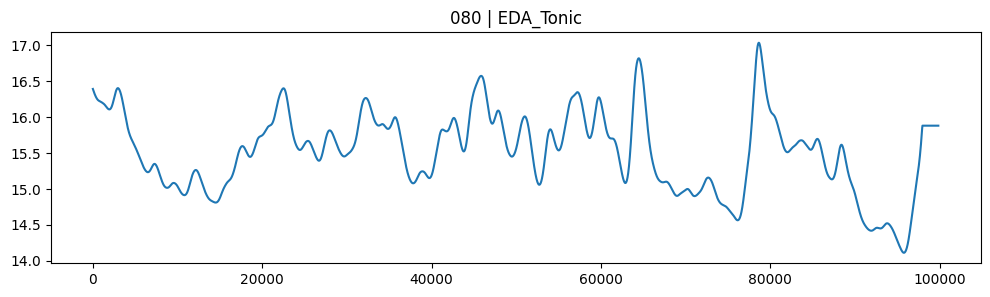

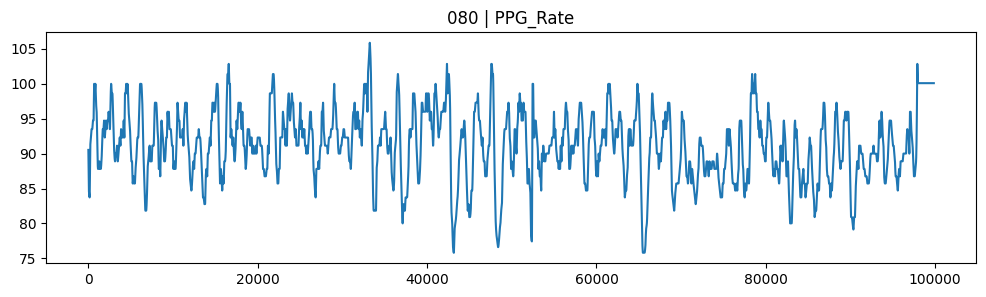

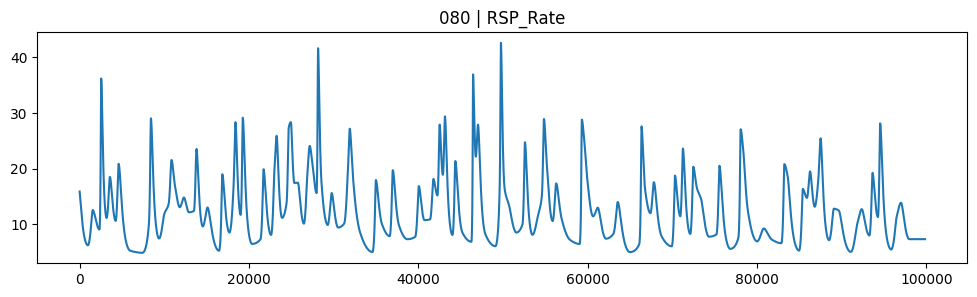

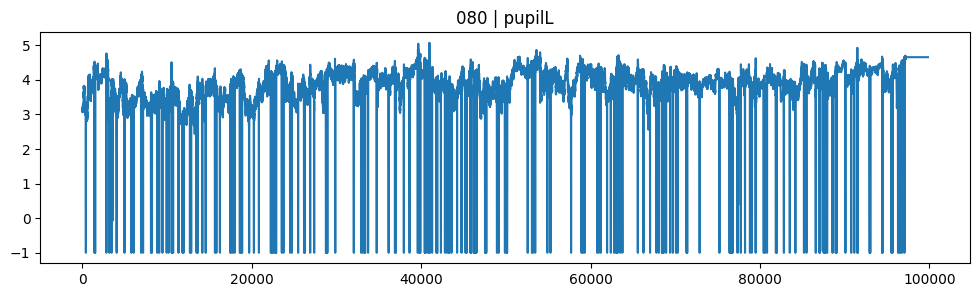

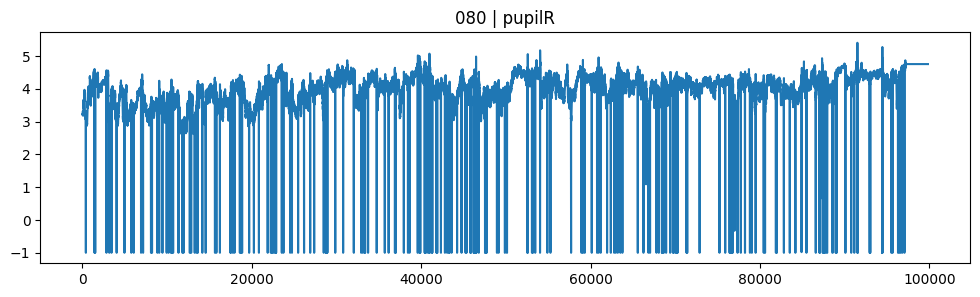


===== PID 091 | Hallway | n=22455 =====


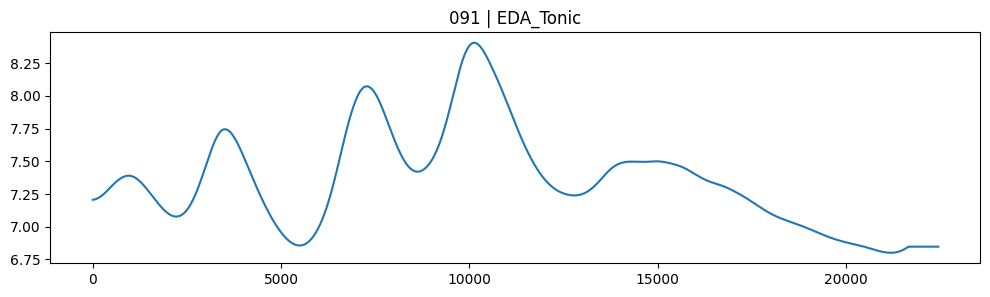

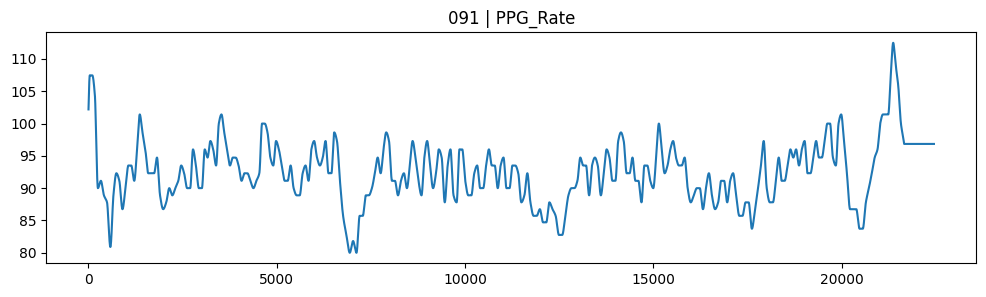

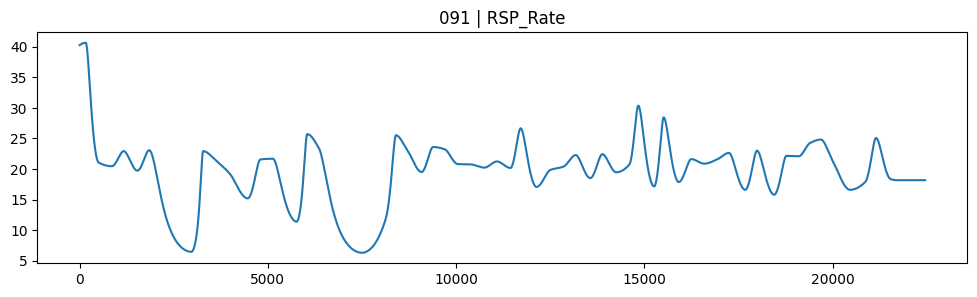

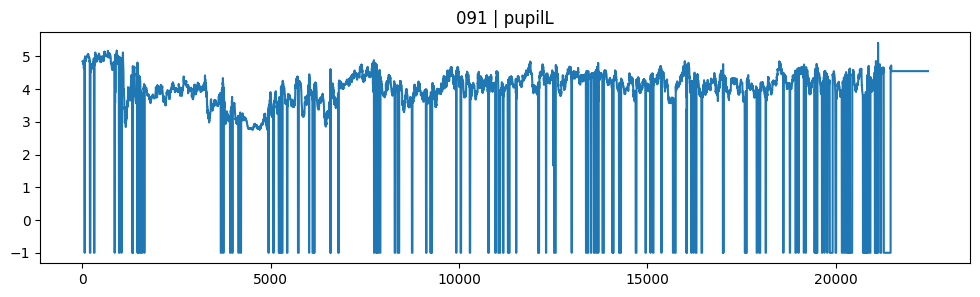

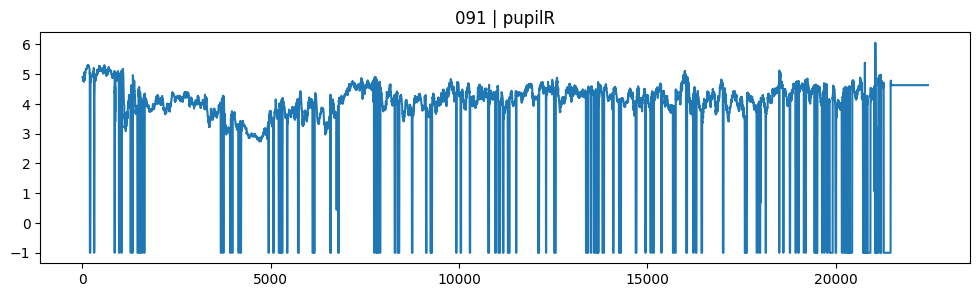


===== PID 014 | Hallway | n=15908 =====


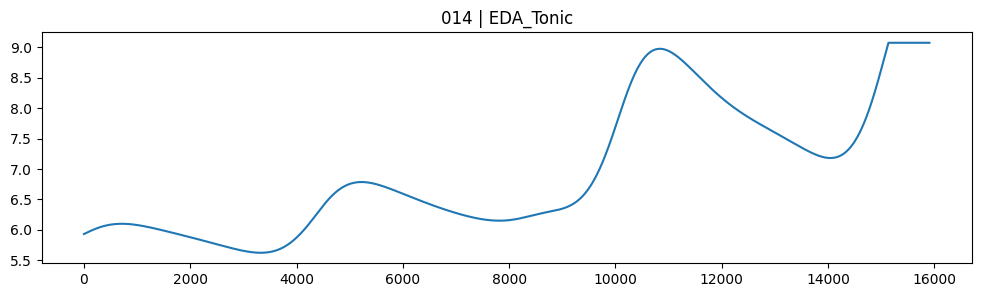

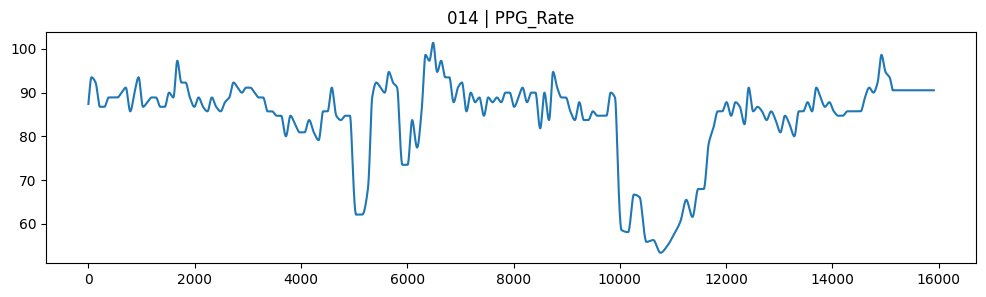

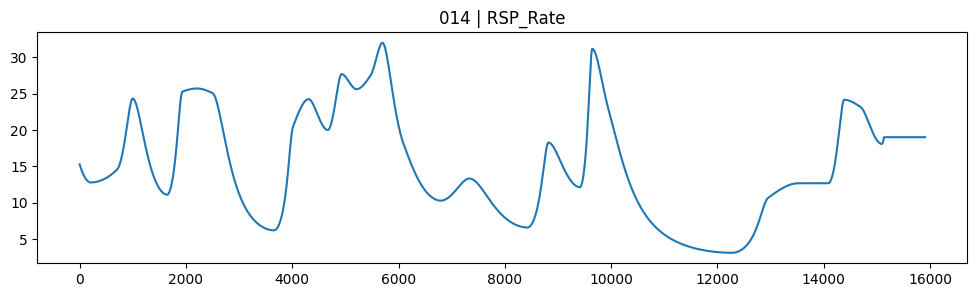

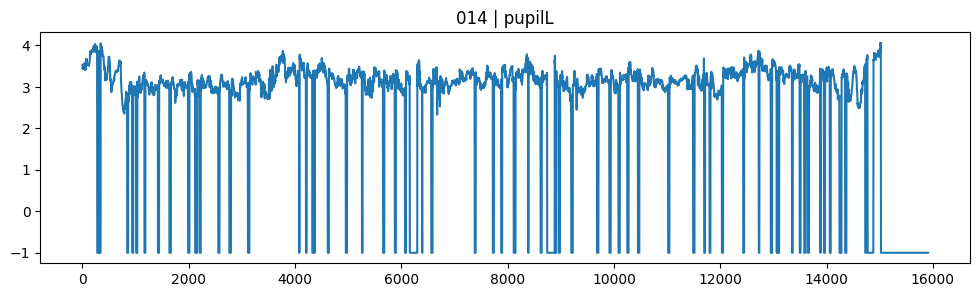

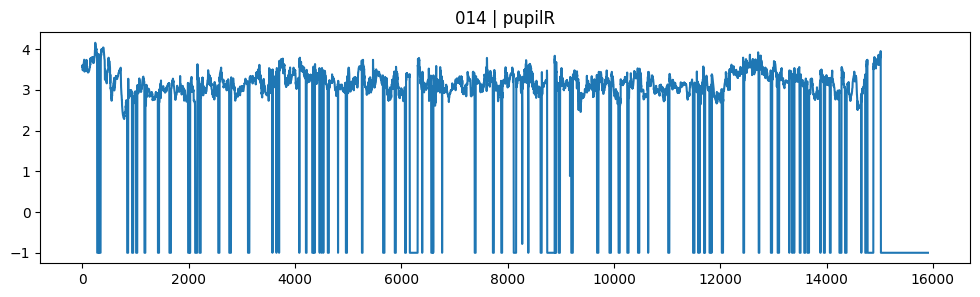


===== PID 001 | Hallway | n=37941 =====


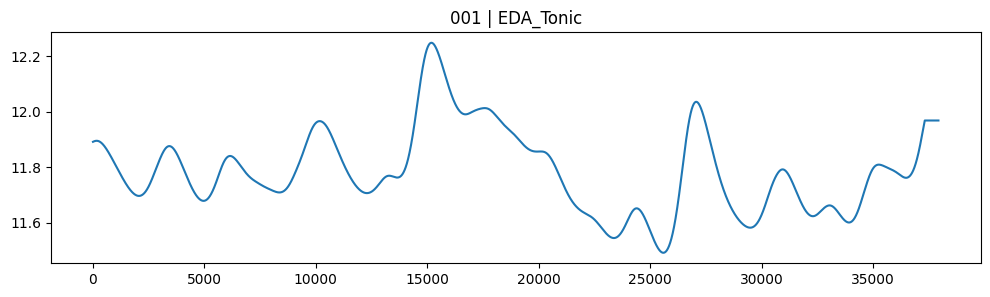

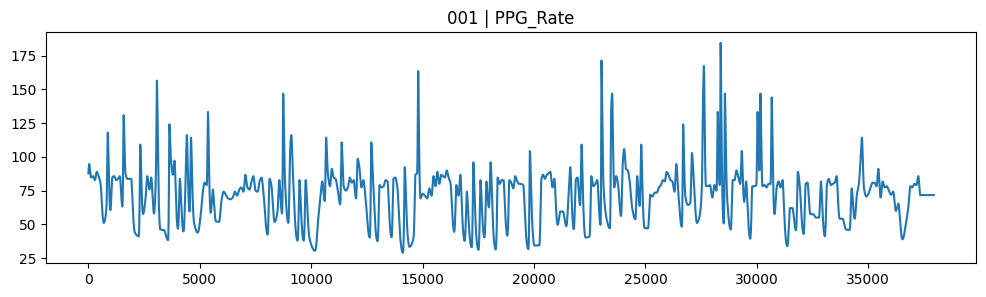

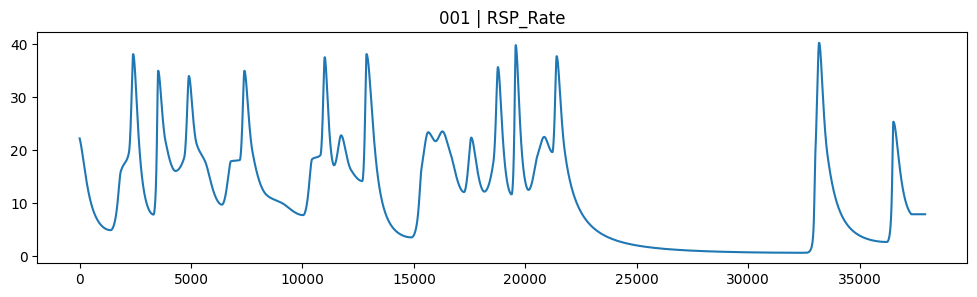

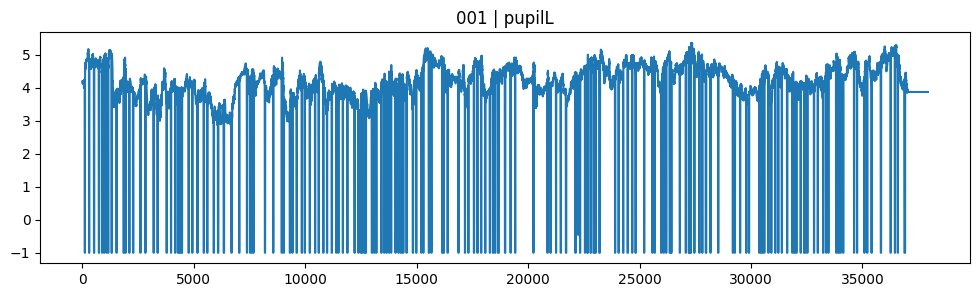

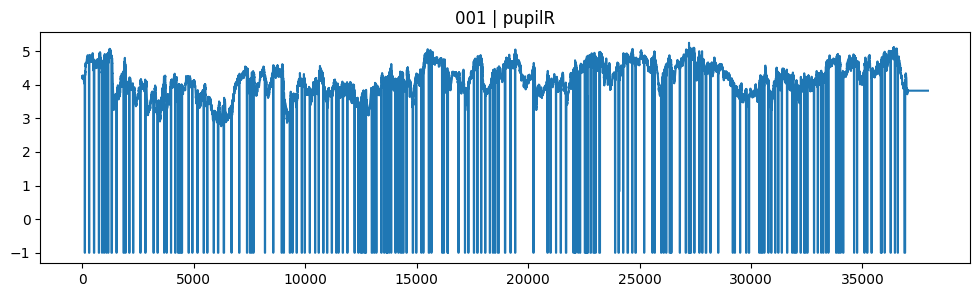


===== PID 008 | Hallway | n=20830 =====


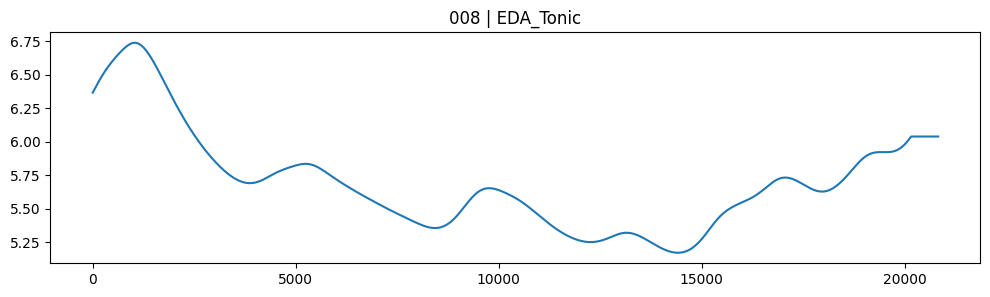

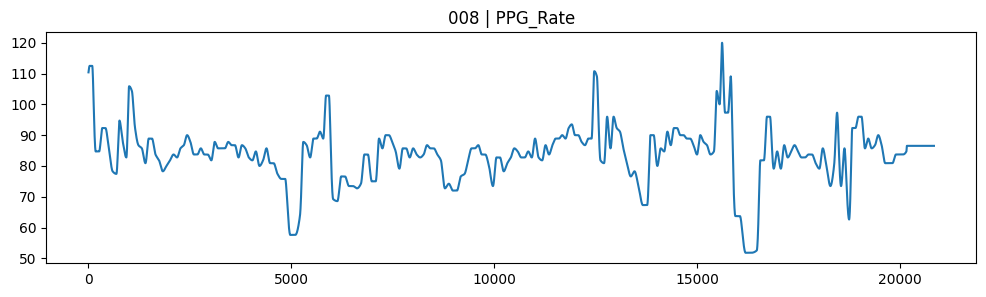

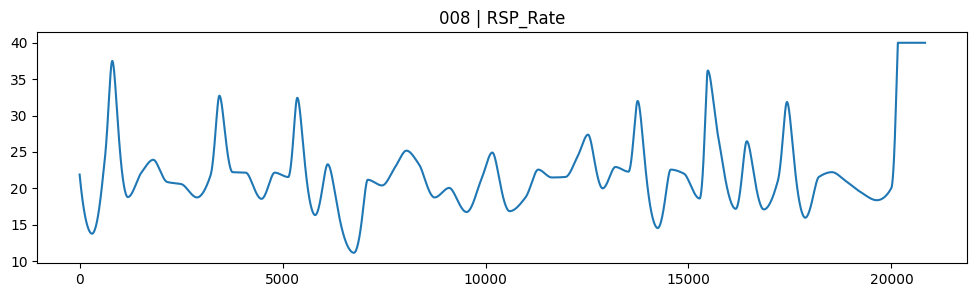

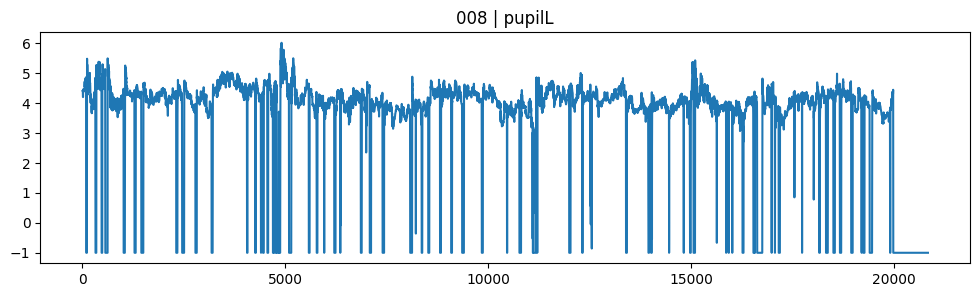

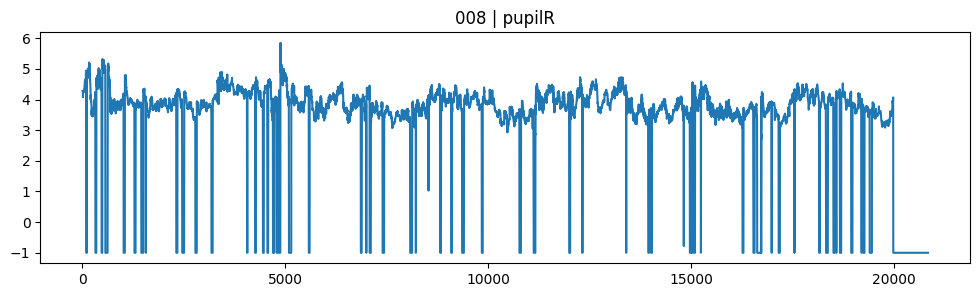

In [ ]:
import pandas as pd, matplotlib.pyplot as plt, os

data_root = r"D:/LabRoom/SDPhysiology/Data/processed_individual_anonymized"
suspects = ["080","091","014","001","008"]
cols = ["EDA_Tonic","PPG_Rate","RSP_Rate","pupilL","pupilR","pupil_mean"]

for pid in suspects:
    df = pd.read_pickle(os.path.join(data_root, f"{pid}_Main.pkl"))
    df_h = df[df["scene"]=="Hallway"].reset_index(drop=True)
    print(f"\n===== PID {pid} | Hallway | n={len(df_h)} =====")
    for c in cols:
        if c in df_h.columns:
            plt.figure(figsize=(12,3))
            plt.plot(df_h[c].values)
            plt.title(f"{pid} | {c}")
            plt.show()


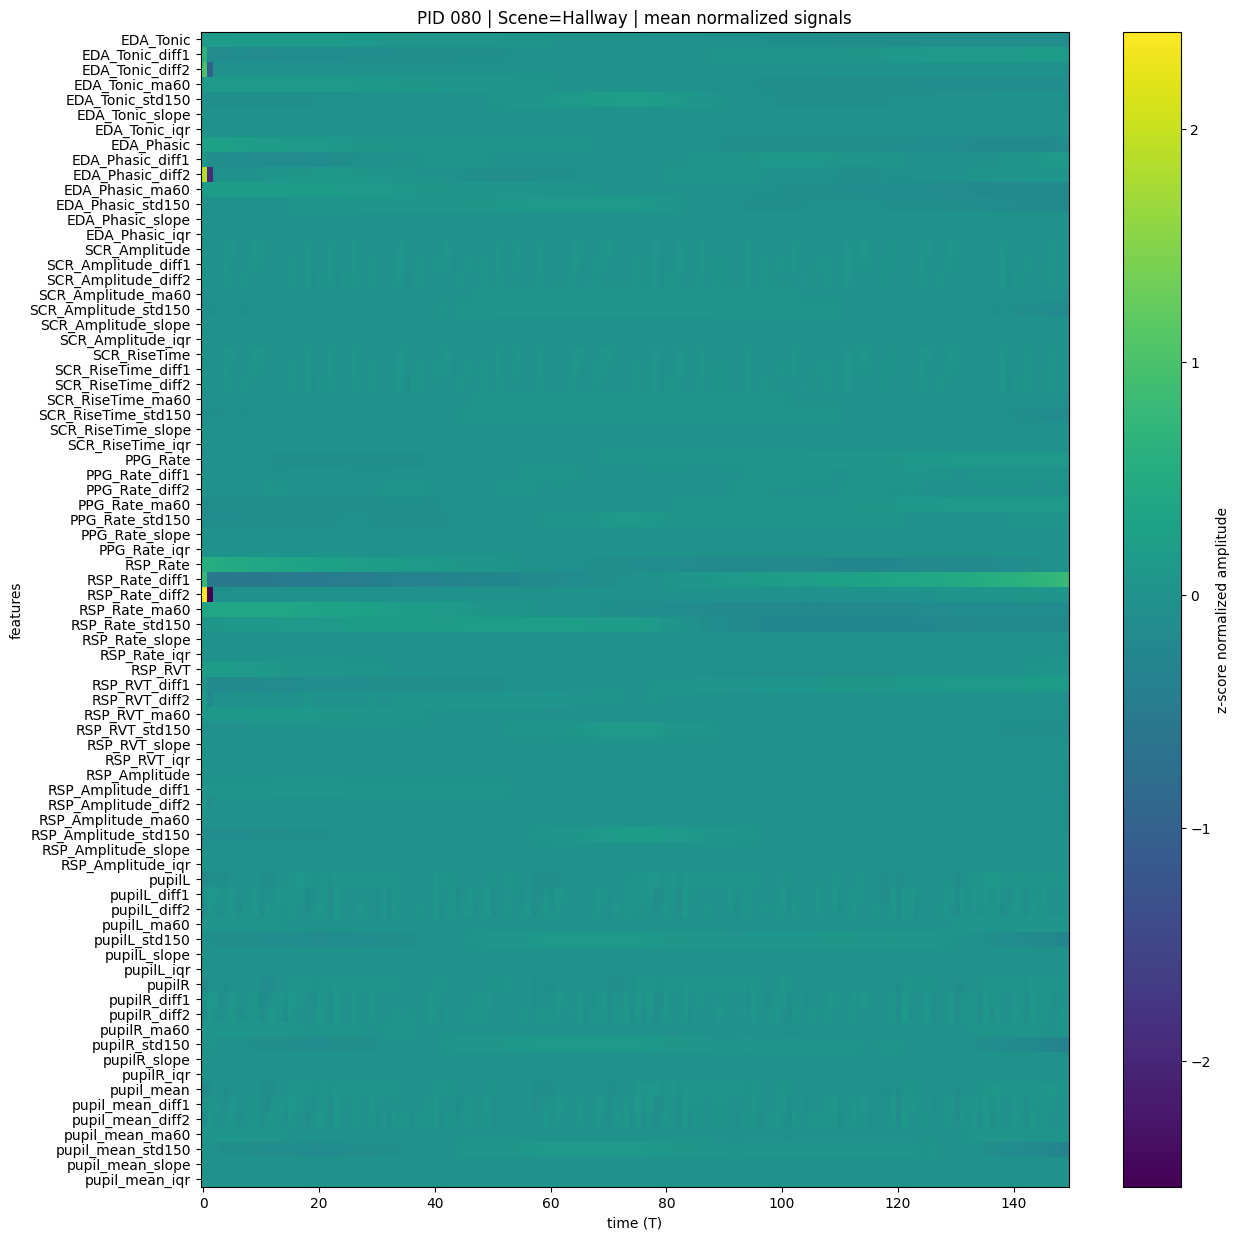

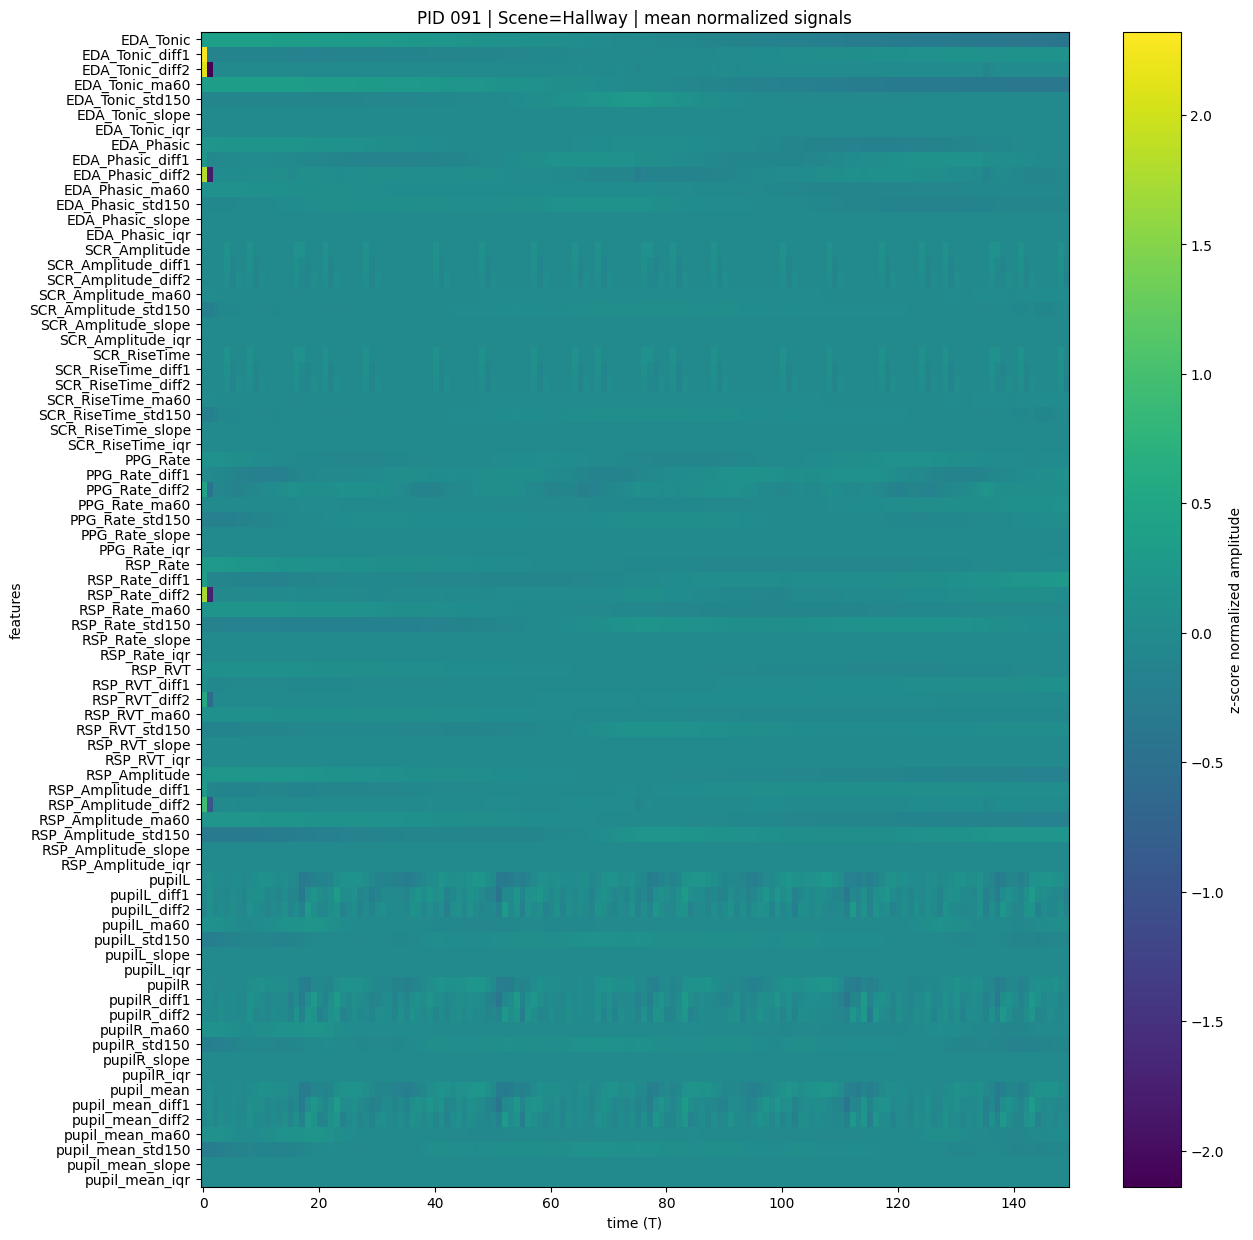

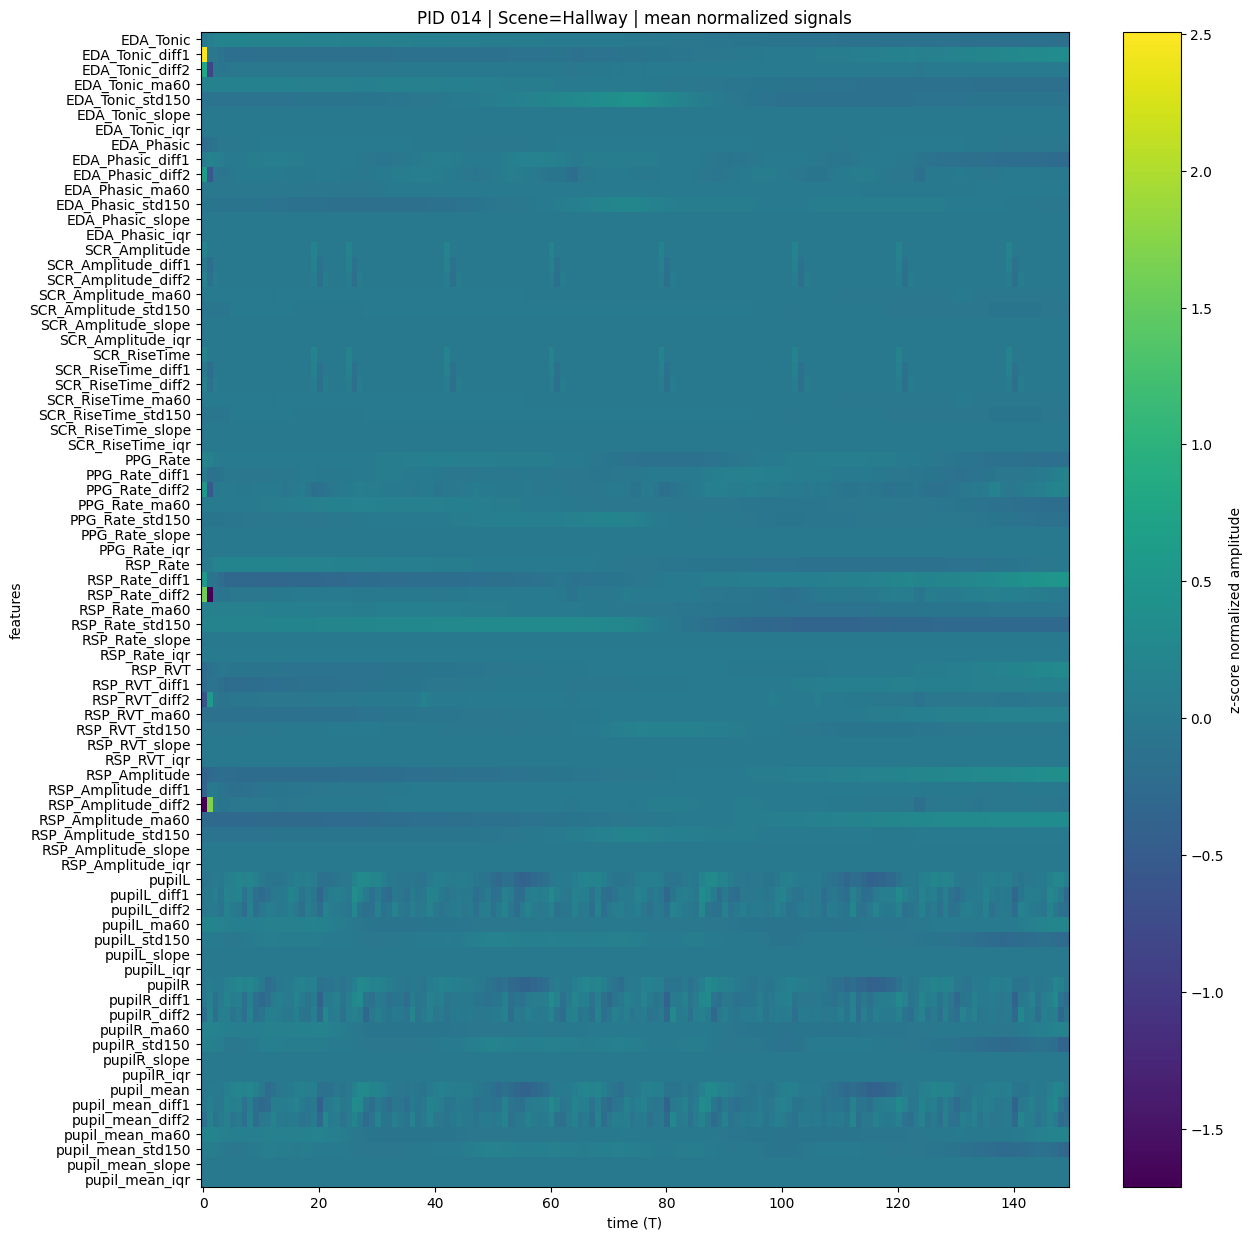

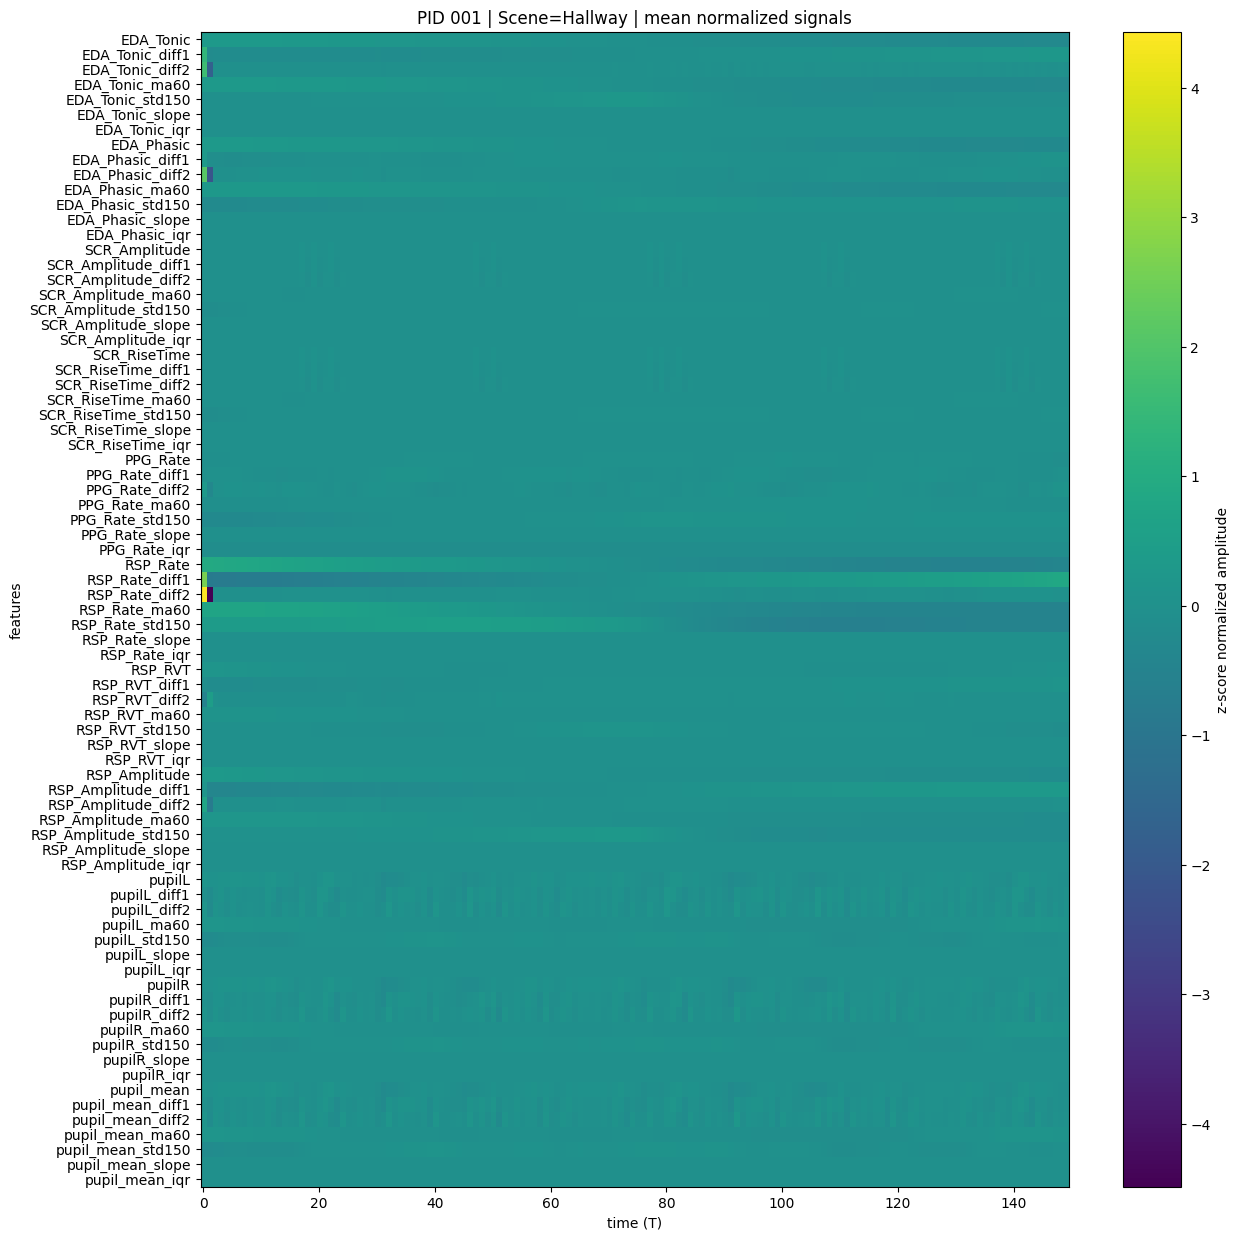

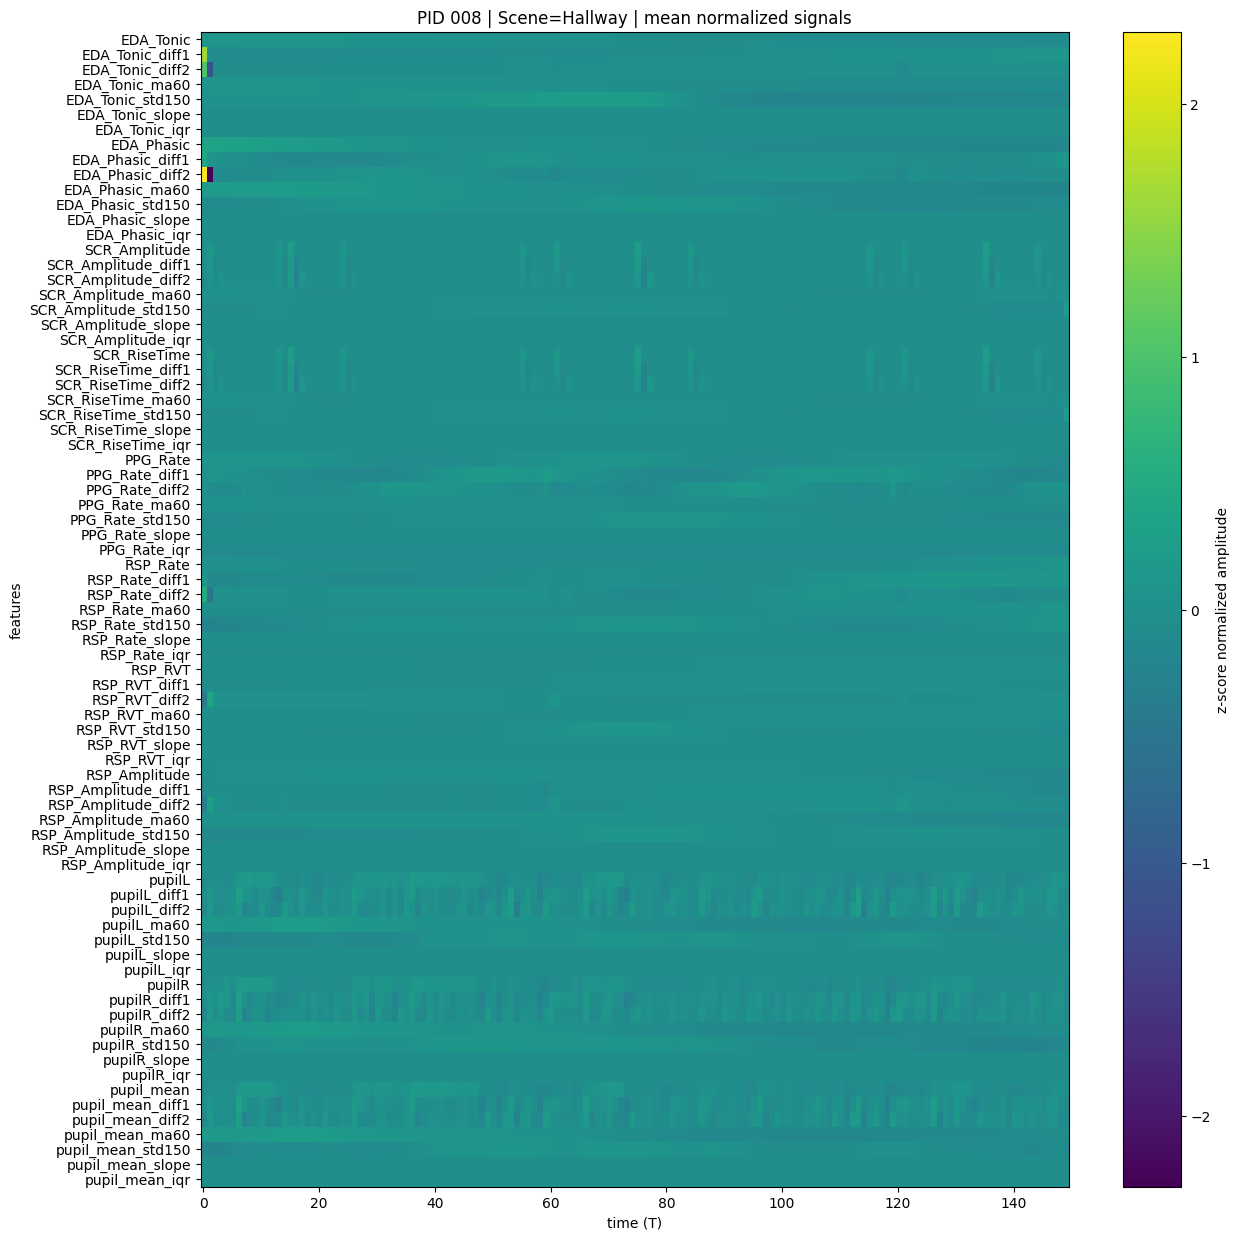

In [26]:
import numpy as np, matplotlib.pyplot as plt, os

path = "./ml_processed/Hallway"

X = np.load(os.path.join(path, "X_array.npy"))   # [N, C, T]
pid = np.load(os.path.join(path, "pid_array.npy"))
feat = np.load(os.path.join(path, "feature_tag_list.npy"))

suspects = ["080","091","014","001","008"]

for p in suspects:
    mask = pid == p
    if not mask.any(): continue
    X_p = X[mask]  # 해당 참가자 window 집합

    # 모든 윈도에 대해 평균 wave
    X_mean = X_p.mean(axis=0)  # [C, T]
    plt.figure(figsize=(14,15))
    plt.imshow(X_mean, aspect='auto', cmap='viridis')
    plt.title(f"PID {p} | Scene=Hallway | mean normalized signals")
    plt.xlabel("time (T)")
    plt.ylabel("features")
    plt.yticks(range(len(feat)), feat)
    plt.colorbar(label="z-score normalized amplitude")
    plt.show()


In [22]:
# ======= Hallway outlier quick-figure maker =======
import os, pandas as pd, numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap

DATA_ROOT = r"D:/LabRoom/SDPhysiology/Data/processed_individual_anonymized"  # 원본 .pkl 폴더
OUT_DIR   = r"./diagnose_outlier_figs"                                          # 저장 폴더
SCENE     = "Hallway"

# 의심 피험자(예: 상위 5명)
SUSPECTS = ["080","091","014","001","008"]

# 그릴 컬럼(있을 때만 그림)
COLS = ["EDA_Tonic","PPG_Rate","RSP_Rate","pupil_mean"]  # pupil_mean은 없으면 자동 생성
DOWNSAMPLE = 4   # 너무 길면 간단 다운샘플(시각화만)  e.g., 4 → 120Hz -> 30Hz

os.makedirs(OUT_DIR, exist_ok=True)

def _load_scene(pid, scene=SCENE):
    df = pd.read_pickle(os.path.join(DATA_ROOT, f"{pid}_Main.pkl"))
    if "pupil_mean" not in df.columns and {"pupilL","pupilR"}.issubset(df.columns):
        df["pupil_mean"] = df[["pupilL","pupilR"]].mean(axis=1)
    d = df[df["scene"]==scene].reset_index(drop=True)
    return d

def _downsample(arr, k=DOWNSAMPLE):
    if k<=1: return arr
    n = len(arr) // k * k
    return arr[:n].reshape(-1, k).mean(axis=1)

def save_pid_panel(pid, cols=COLS):
    d = _load_scene(pid)
    if d.empty:
        print(f"[{pid}] no {SCENE} rows"); return
    present = [c for c in cols if c in d.columns]
    if not present:
        print(f"[{pid}] none of {cols} present"); return

    t = np.arange(len(d))
    if DOWNSAMPLE>1:
        t = _downsample(t)
    nplot = len(present)
    nrow = int(np.ceil(nplot/2))
    ncol = 2 if nplot>1 else 1

    fig, axes = plt.subplots(nrow, ncol, figsize=(14, 3.2*nrow), sharex=True)
    axes = np.atleast_1d(axes).ravel()

    for ax, c in zip(axes, present):
        y = d[c].to_numpy()
        if DOWNSAMPLE>1:
            y = _downsample(y)
        ax.plot(t, y, linewidth=0.9)
        ax.set_title(c)
        ax.grid(True, alpha=0.3)
        # 앞 10초 구간(120Hz 가정)을 대략 표시선(시각화용)
        ax.axvline(x=min(1200//DOWNSAMPLE, len(t)-1), linestyle="--", alpha=0.6)

    # 빈 서브플롯 숨김
    for k in range(len(present), len(axes)):
        axes[k].axis("off")

    ttl = f"PID {pid} | Scene={SCENE} | Raw signals"
    fig.suptitle("\n".join(wrap(ttl, width=90)), y=0.99, fontsize=12)
    fig.tight_layout(rect=[0,0,1,0.97])
    out_path = os.path.join(OUT_DIR, f"{pid}_{SCENE}_panel.png")
    fig.savefig(out_path, dpi=200)
    plt.close(fig)
    print("saved:", out_path)

def save_group_overlay(pids=SUSPECTS, cols=COLS):
    """피험자별 곡선을 min-max 정규화하여 한 축에 겹쳐 그림(컬럼별 1장)."""
    for c in cols:
        # 해당 컬럼이 한 명도 없으면 skip
        has_any = False
        fig, ax = plt.subplots(figsize=(14,4))
        for pid in pids:
            d = _load_scene(pid)
            if c not in d.columns or d.empty: 
                continue
            has_any = True
            y = d[c].to_numpy().astype(float)
            if DOWNSAMPLE>1:
                y = _downsample(y)
            # min-max 정규화(상수열 방지)
            ymin, ymax = np.nanmin(y), np.nanmax(y)
            if np.isfinite(ymin) and np.isfinite(ymax) and ymax>ymin:
                yn = (y - ymin) / (ymax - ymin)
            else:
                yn = y * 0.0
            ax.plot(yn, alpha=0.8, linewidth=0.9, label=str(pid))

        if not has_any:
            plt.close(fig); continue

        ax.set_ylim(-0.05, 1.05)
        ax.set_title(f"{c} | Scene={SCENE} | suspects overlay (min-max per PID)")
        ax.set_xlabel("samples (downsampled)")
        ax.set_ylabel("normalized amplitude")
        ax.grid(True, alpha=0.3)
        ax.legend(ncol=min(len(pids), 10), fontsize=8, frameon=False)
        fig.tight_layout()
        out_path = os.path.join(OUT_DIR, f"group_{SCENE}_{c}_overlay.png")
        fig.savefig(out_path, dpi=200)
        plt.close(fig)
        print("saved:", out_path)

# ===== 실행 예시 =====
# (A) 개별 패널 1장씩
for pid in SUSPECTS:
    save_pid_panel(pid)

# (B) suspects 비교 1장(모달리티별)
save_group_overlay(SUSPECTS)


saved: ./diagnose_outlier_figs\080_Hallway_panel.png
saved: ./diagnose_outlier_figs\091_Hallway_panel.png
saved: ./diagnose_outlier_figs\014_Hallway_panel.png
saved: ./diagnose_outlier_figs\001_Hallway_panel.png
saved: ./diagnose_outlier_figs\008_Hallway_panel.png
saved: ./diagnose_outlier_figs\group_Hallway_EDA_Tonic_overlay.png
saved: ./diagnose_outlier_figs\group_Hallway_PPG_Rate_overlay.png
saved: ./diagnose_outlier_figs\group_Hallway_RSP_Rate_overlay.png
saved: ./diagnose_outlier_figs\group_Hallway_pupil_mean_overlay.png


PID별 최소 윈도 개수: 60


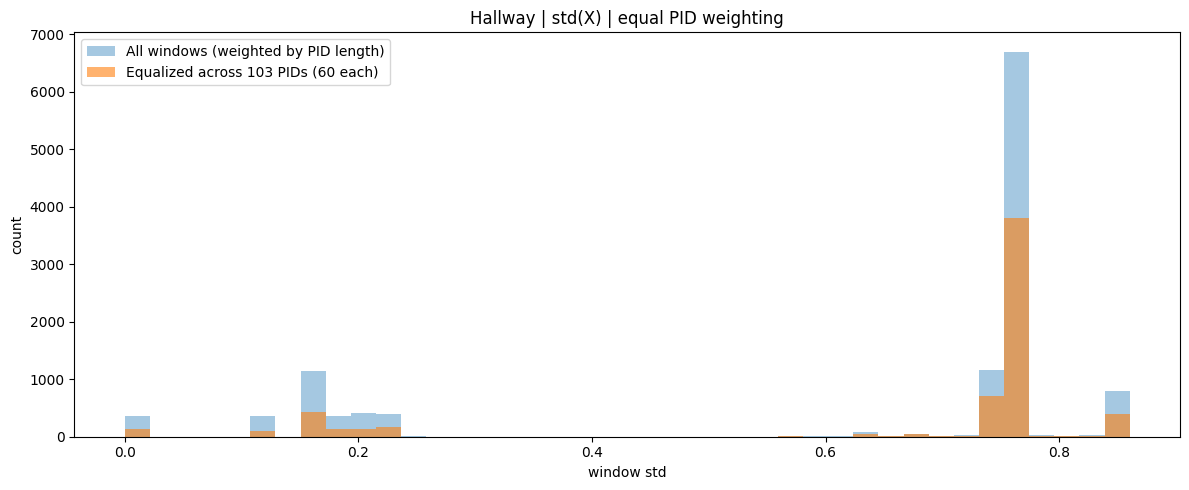

In [34]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, random, os

SCENE_DIR = "./ml_processed/Hallway"
feature_tags = np.load(os.path.join(SCENE_DIR, "feature_tag_list.npy"), allow_pickle=True)
pid = np.load(os.path.join(SCENE_DIR, "pid_array.npy"))
X = np.load(os.path.join(SCENE_DIR, "X_array.npy"))
scene = np.load(os.path.join(SCENE_DIR, "scene_array.npy"))

# --- PID 표준화 (앞서 쓰던 함수)
def norm_pid(x):
    s = str(x).strip().strip("'").strip('"')
    return "".join(ch for ch in s if ch.isdigit()).zfill(3)
pid_norm = np.array([norm_pid(p) for p in pid], dtype=object)

# --- PID별 윈도 인덱스 그룹화
pid_groups = pd.Series(range(len(pid_norm))).groupby(pid_norm).apply(list)
min_len = pid_groups.apply(len).min()
print(f"PID별 최소 윈도 개수: {min_len}")

# --- 각 PID에서 동일 수 샘플링
SAMPLE_N = min(min_len, 100)  # 너무 적으면 100개까지만
sel_idx = [random.sample(lst, SAMPLE_N) for lst in pid_groups]
sel_idx = np.concatenate(sel_idx)

# --- 전체 윈도 std 계산
X_std_all = X.std(axis=(1,2))
X_std_bal = X_std_all[sel_idx]

# --- 비교 시각화
plt.figure(figsize=(12,5))
plt.hist(X_std_all, bins=40, alpha=0.4, label="All windows (weighted by PID length)")
plt.hist(X_std_bal, bins=40, alpha=0.6, label=f"Equalized across {len(pid_groups)} PIDs ({SAMPLE_N} each)")
plt.legend()
plt.title("Hallway | std(X) | equal PID weighting")
plt.xlabel("window std")
plt.ylabel("count")
plt.tight_layout()
plt.savefig("./Hallway_std_equal_weight.png", dpi=200)
plt.show()


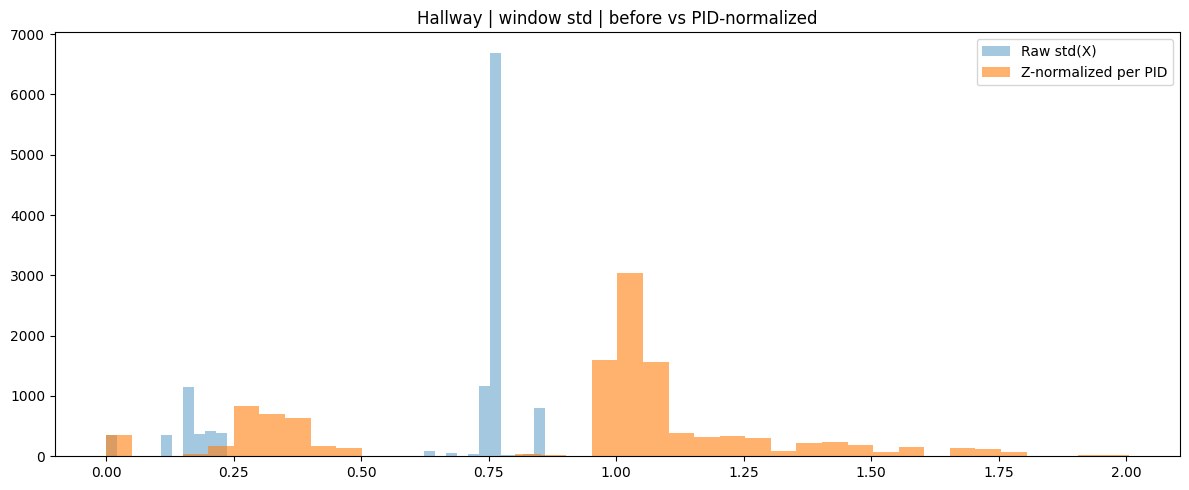

In [35]:
# --- PID별 mean/std로 Z-normalization
X_norm = np.empty_like(X)
for pid_, idxs in pid_groups.items():
    mean_ = X[idxs].mean(axis=(0,1,2), keepdims=True)
    std_  = X[idxs].std(axis=(0,1,2), keepdims=True) + 1e-8
    X_norm[idxs] = (X[idxs] - mean_) / std_

# --- 다시 std 계산
std_z = X_norm.std(axis=(1,2))

plt.figure(figsize=(12,5))
plt.hist(X_std_all, bins=40, alpha=0.4, label="Raw std(X)")
plt.hist(std_z, bins=40, alpha=0.6, label="Z-normalized per PID")
plt.legend()
plt.title("Hallway | window std | before vs PID-normalized")
plt.tight_layout()
plt.savefig("./Hallway_std_znormalized.png", dpi=200)
plt.show()


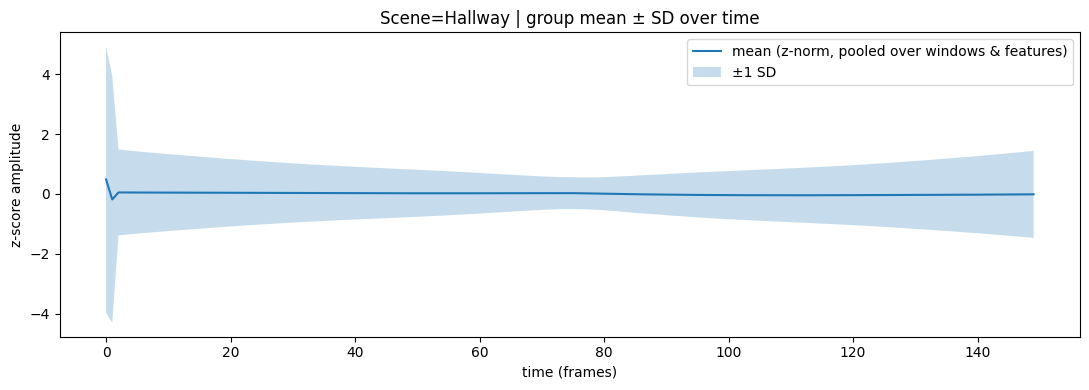

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import os

SCENE_DIR = "./ml_processed/Hallway"
feature_tags = np.load(os.path.join(SCENE_DIR, "feature_tag_list.npy"), allow_pickle=True)
X = np.load(os.path.join(SCENE_DIR, "X_array.npy"))          # (N, C, T)를 가정
pid = np.load(os.path.join(SCENE_DIR, "pid_array.npy"))

# --- 관심 피처 선택 (예: EDA_Tonic, RSP_Rate)
tokens = ("EDA_Tonic", "RSP_Rate")  # 필요에 따라 추가/변경
cols_interest = [i for i,t in enumerate(feature_tags) if any(tok in str(t) for tok in tokens)]
assert len(cols_interest) > 0, "cols_interest 비어있음"

# --- PID별 z-normalization (baseline 차 제거)
def norm_pid(x):
    s = str(x).strip().strip("'").strip('"')
    digs = "".join(ch for ch in s if ch.isdigit())
    return (digs if digs else s).zfill(3)

pid_norm = np.array([norm_pid(p) for p in pid], dtype=object)

X_norm = np.empty_like(X, dtype=np.float32)
# (N, C, T)에서 각 PID별로 전체 평균/표준편차로 정규화
for p in np.unique(pid_norm):
    idx = np.where(pid_norm == p)[0]
    m = X[idx].mean(axis=(0,1,2), keepdims=True)
    s = X[idx].std(axis=(0,1,2), keepdims=True) + 1e-8
    X_norm[idx] = (X[idx] - m) / s

# --- 시간축 mean±SD 만들기 (윈도와 피처를 모두 풀링 → 1D)
# 관심 피처만 추출: (N, k, T)
Xk = X_norm[:, cols_interest, :]

# 방법 A) 윈도(N)와 피처(k)를 모두 평균/표준편차 → 시간축 벡터(T,)
mean_ts = Xk.mean(axis=(0,1))   # (T,)
std_ts  = Xk.std(axis=(0,1))    # (T,)

# [선택] 방법 B) PID 동일가중: PID별로 먼저 평균 → PID들 평균 (긴 세션 편향 제거)
# pid_groups = {p: np.where(pid_norm==p)[0] for p in np.unique(pid_norm)}
# per_pid_mean = []
# for p, idx in pid_groups.items():
#     per_pid_mean.append(Xk[idx].mean(axis=(0,1)))   # (T,)
# per_pid_mean = np.stack(per_pid_mean, axis=0)       # (P, T)
# mean_ts = per_pid_mean.mean(axis=0)
# std_ts  = per_pid_mean.std(axis=0)

# --- 그림
t = np.arange(mean_ts.shape[0])
plt.figure(figsize=(11,4))
plt.plot(t, mean_ts, label="mean (z-norm, pooled over windows & features)")
plt.fill_between(t, mean_ts-std_ts, mean_ts+std_ts, alpha=0.25, label="±1 SD")
plt.title("Scene=Hallway | group mean ± SD over time")
plt.xlabel("time (frames)")
plt.ylabel("z-score amplitude")
plt.legend()
plt.tight_layout()
plt.savefig("./Hallway_event_variance_profile.png", dpi=200)
plt.show()


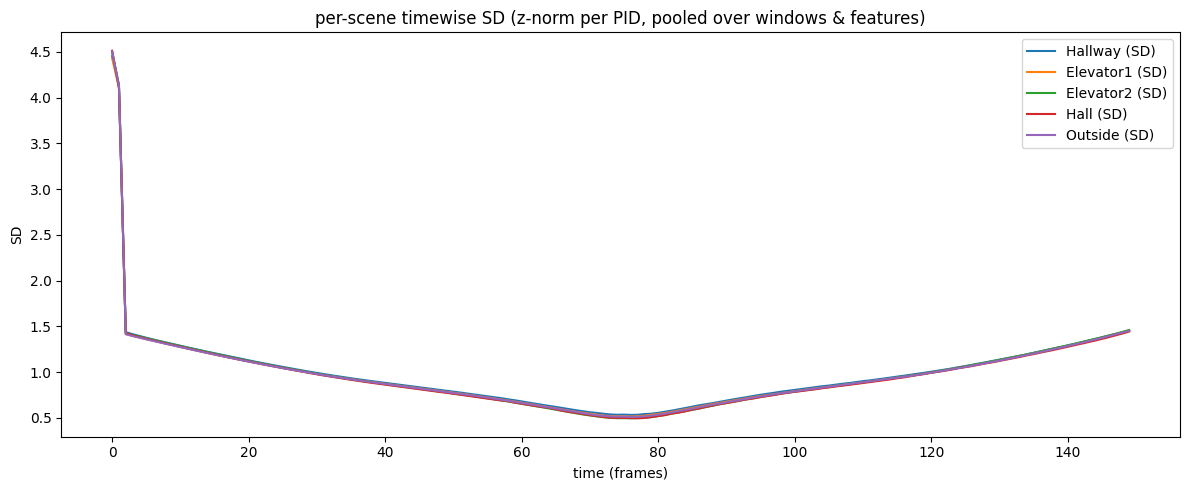

In [38]:
SCENES = ["Hallway","Elevator1","Elevator2","Hall","Outside"]
BASE = "./ml_processed"

def time_profile(scene_dir, tokens=("EDA_Tonic","RSP_Rate")):
    feat = np.load(os.path.join(scene_dir, "feature_tag_list.npy"), allow_pickle=True)
    X = np.load(os.path.join(scene_dir, "X_array.npy"))
    pid = np.load(os.path.join(scene_dir, "pid_array.npy"))

    pidn = np.array([norm_pid(p) for p in pid], dtype=object)
    # z-norm per PID
    Xn = np.empty_like(X, dtype=np.float32)
    for p in np.unique(pidn):
        idx = np.where(pidn==p)[0]
        m = X[idx].mean(axis=(0,1,2), keepdims=True); s = X[idx].std(axis=(0,1,2), keepdims=True) + 1e-8
        Xn[idx] = (X[idx]-m)/s

    cols = [i for i,t in enumerate(feat) if any(tok in str(t) for tok in tokens)]
    Xk = Xn[:, cols, :]
    mean_ts = Xk.mean(axis=(0,1))
    std_ts  = Xk.std(axis=(0,1))
    return mean_ts, std_ts

import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
for sc in SCENES:
    sd = os.path.join(BASE, sc)
    if not os.path.isdir(sd): continue
    m, s = time_profile(sd, tokens=("EDA_Tonic","RSP_Rate"))
    # SD만 겹쳐보기(이벤트성 변동 비교)
    plt.plot(s, label=f"{sc} (SD)")
plt.title("per-scene timewise SD (z-norm per PID, pooled over windows & features)")
plt.xlabel("time (frames)")
plt.ylabel("SD")
plt.legend()
plt.tight_layout()
plt.savefig("./per_scene_SD_profiles.png", dpi=200)
plt.show()


In [39]:
"""
확인용 진단:
 - 씬별/모달리티별(window std) 분포에서 저분산(flat)에 해당하는 윈도 비율 산출
 - PID별 flat 비율 테이블
 - (선택) 히스토그램/CSV 저장
전제:
 - ./ml_processed/<Scene>/ 에 X_array.npy, pid_array.npy, scene_array.npy, feature_tag_list.npy 존재
 - X shape: (N, C, T) 가정
"""

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE = "./ml_processed"
SCENES = ["Hallway", "Elevator1", "Elevator2", "Hall", "Outside"]
TOKENS = ("EDA", "PPG", "RSP", "PUPIL")   # 모달리티 구분 키워드
# 모달리티별 flat 기준(threshold) – 필요시 조정
FLAT_TH = {
    "EDA":   0.25,
    "PPG":   0.25,
    "RSP":   0.25,   # (걱정하신 RSP 0근처 피크 확인용)
    "PUPIL": 0.25,
}

OUTDIR = "./qc_diagnostics"
os.makedirs(OUTDIR, exist_ok=True)

def norm_pid(x):
    s = str(x).strip().strip("'").strip('"')
    digs = "".join(ch for ch in s if ch.isdigit())
    return (digs if digs else s).zfill(3)

def load_scene(scene):
    d = os.path.join(BASE, scene)
    X   = np.load(os.path.join(d, "X_array.npy"))
    pid = np.load(os.path.join(d, "pid_array.npy"))
    scn = np.load(os.path.join(d, "scene_array.npy"))
    tags= np.load(os.path.join(d, "feature_tag_list.npy"), allow_pickle=True)
    pnorm = np.array([norm_pid(p) for p in pid], dtype=object)
    return X, pnorm, scn, np.array(tags)

def modality_slices(tags, tokens=TOKENS):
    tags = [str(t) for t in tags]
    d = {}
    for tok in tokens:
        idx = [i for i,t in enumerate(tags) if tok in t.upper()]
        if len(idx): d[tok] = idx
    if not d: d["ALL"] = list(range(len(tags)))
    return d

def window_std_modality(X, idxs):
    # X: (N,C,T) -> (N, len(idxs), T) -> std over (C,T)
    return X[:, idxs, :].std(axis=(1,2))

# -------------------- RUN --------------------
all_flat_rows = []     # 씬×모달리티 전체 요약
all_pid_rows  = []     # PID별 flat 비율 표

for sc in SCENES:
    X, pid, scn, tags = load_scene(sc)
    slices = modality_slices(tags)
    print(f"\n=== Scene: {sc} | X: {X.shape} | PIDs: {len(np.unique(pid))} ===")

    for mod, idxs in slices.items():
        wstd = window_std_modality(X, idxs)
        th = FLAT_TH.get(mod, 0.25)
        flat_mask = (wstd < th)

        # 씬 전체 flat 비율
        flat_ratio = float(flat_mask.mean())
        row = {
            "scene": sc, "modality": mod,
            "N_windows": int(len(wstd)),
            "flat_threshold": th,
            "flat_ratio": flat_ratio,
            "wstd_mean": float(wstd.mean()),
            "wstd_std": float(wstd.std()),
        }
        all_flat_rows.append(row)
        print(f"  - {mod:6s} | flat<{th:.2f}: {flat_ratio*100:5.1f}%  (N={len(wstd)})")

        # PID별 flat 비율
        df = pd.DataFrame({"pid": pid, "wstd": wstd, "is_flat": flat_mask})
        stat = df.groupby("pid")["is_flat"].mean().rename("flat_ratio").reset_index()
        stat["scene"] = sc
        stat["modality"] = mod
        all_pid_rows.append(stat)

        # (선택) 히스토그램 저장
        plt.figure(figsize=(10,4))
        plt.hist(wstd, bins=40)
        plt.axvline(th, ls="--", color="tab:red", label=f"flat<th={th}")
        plt.title(f"{mod} | Scene={sc} | window std")
        plt.xlabel("window std")
        plt.ylabel("count")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(OUTDIR, f"{sc}_{mod}_wstd_hist.png"), dpi=160)
        plt.close()

# 저장: 씬×모달리티 요약, PID별 flat 비율
df_flat = pd.DataFrame(all_flat_rows)
df_flat.to_csv(os.path.join(OUTDIR, "scene_modality_flat_summary.csv"), index=False)
pd.concat(all_pid_rows, ignore_index=True)\
  .to_csv(os.path.join(OUTDIR, "pid_flat_ratio_by_scene_modality.csv"), index=False)

print("\n✔ Saved:", OUTDIR)



=== Scene: Hallway | X: (11979, 77, 150) | PIDs: 103 ===
  - EDA    | flat<0.25:  23.0%  (N=11979)
  - PPG    | flat<0.25:   4.1%  (N=11979)
  - RSP    | flat<0.25:  21.9%  (N=11979)
  - PUPIL  | flat<0.25:  26.3%  (N=11979)

=== Scene: Elevator1 | X: (11568, 77, 150) | PIDs: 103 ===
  - EDA    | flat<0.25:   0.0%  (N=11568)
  - PPG    | flat<0.25:   0.0%  (N=11568)
  - RSP    | flat<0.25:   0.0%  (N=11568)
  - PUPIL  | flat<0.25:   0.1%  (N=11568)

=== Scene: Elevator2 | X: (9960, 77, 150) | PIDs: 102 ===
  - EDA    | flat<0.25:   0.0%  (N=9960)
  - PPG    | flat<0.25:   0.0%  (N=9960)
  - RSP    | flat<0.25:   0.0%  (N=9960)
  - PUPIL  | flat<0.25:   2.5%  (N=9960)

=== Scene: Hall | X: (6055, 77, 150) | PIDs: 103 ===
  - EDA    | flat<0.25:   0.0%  (N=6055)
  - PPG    | flat<0.25:   0.1%  (N=6055)
  - RSP    | flat<0.25:   0.0%  (N=6055)
  - PUPIL  | flat<0.25:   0.1%  (N=6055)

=== Scene: Outside | X: (18218, 77, 150) | PIDs: 107 ===
  - EDA    | flat<0.25:   0.0%  (N=18218)
  - P

In [40]:
# === QC 공통 ===
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE = "./ml_processed"          # 원본
OUT  = "./ml_processed_qc"       # QC 적용 저장 폴더
os.makedirs(OUT, exist_ok=True)

SCENES = ["Hallway","Elevator1","Elevator2","Hall","Outside"]
TOKENS = ("EDA","PPG","RSP","PUPIL")  # 모달리티 토큰

# 모달리티별 flat 기준 (원하는대로 조정)
FLAT_TH = {
    "EDA":   0.25,
    "PPG":   0.25,
    "RSP":   0.25,
    "PUPIL": 0.25,
}

def norm_pid(x):
    s = str(x).strip().strip("'").strip('"')
    digs = "".join(ch for ch in s if ch.isdigit())
    return (digs if digs else s).zfill(3)

def modality_slices(tags, tokens=TOKENS):
    tags = [str(t) for t in tags]
    d = {}
    for tok in tokens:
        idx = [i for i,t in enumerate(tags) if tok in t.upper()]
        if len(idx): d[tok] = idx
    if not d: d["ALL"] = list(range(len(tags)))
    return d

def window_std(X, idxs):
    # X: (N,C,T) -> (N, len(idxs), T) -> std over (C,T)
    return X[:, idxs, :].std(axis=(1,2))


In [41]:
def qc_diagnostics(out_dir="./qc_diagnostics"):
    os.makedirs(out_dir, exist_ok=True)
    all_flat_rows, all_pid_rows = [], []

    for sc in SCENES:
        d = os.path.join(BASE, sc)
        X   = np.load(os.path.join(d, "X_array.npy"))
        pid = np.load(os.path.join(d, "pid_array.npy"))
        tags= np.load(os.path.join(d, "feature_tag_list.npy"), allow_pickle=True)

        pidn = np.array([norm_pid(p) for p in pid], dtype=object)
        slices = modality_slices(tags)

        print(f"\n=== Scene: {sc} | X: {X.shape} | PIDs: {len(np.unique(pidn))} ===")
        for mod, idxs in slices.items():
            wstd = window_std(X, idxs)
            th = FLAT_TH.get(mod, 0.25)
            flat_mask = (wstd < th)

            print(f"  - {mod:6s} | flat<{th:.2f}: {flat_mask.mean()*100:5.1f}%  (N={len(wstd)})")

            all_flat_rows.append({
                "scene": sc, "modality": mod,
                "N_windows": int(len(wstd)),
                "flat_threshold": th,
                "flat_ratio": float(flat_mask.mean()),
                "wstd_mean": float(wstd.mean()),
                "wstd_std":  float(wstd.std()),
            })

            df_pid = pd.DataFrame({"pid": pidn, "is_flat": flat_mask})
            stat = df_pid.groupby("pid")["is_flat"].mean().rename("flat_ratio").reset_index()
            stat["scene"] = sc; stat["modality"] = mod
            all_pid_rows.append(stat)

            # 히스토그램 저장
            plt.figure(figsize=(10,4))
            plt.hist(wstd, bins=40)
            plt.axvline(th, ls="--", color="tab:red", label=f"flat<th={th}")
            plt.title(f"{mod} | Scene={sc} | window std")
            plt.xlabel("window std"); plt.ylabel("count"); plt.legend()
            plt.tight_layout()
            plt.savefig(os.path.join(out_dir, f"{sc}_{mod}_wstd_hist.png"), dpi=160)
            plt.close()

    pd.DataFrame(all_flat_rows).to_csv(os.path.join(out_dir, "scene_modality_flat_summary.csv"), index=False)
    pd.concat(all_pid_rows, ignore_index=True)\
      .to_csv(os.path.join(out_dir, "pid_flat_ratio_by_scene_modality.csv"), index=False)
    print("\n✔ Saved:", out_dir)


In [42]:
# QC 규칙: 모달리티별 flat 여부를 합쳐 판단
K_OF_N      = 2    # 동시에 flat인 모달리티가 k개 이상이면 제외
MIN_RUN     = 3    # 해당 판정이 연속으로 최소 몇 윈도 지속될 때 제외로 인정
APPLY_SCENES = ["Hallway"]  # 특정 씬에만 적용하려면 지정, 전체면 None

def rle_bool(x):
    """Boolean 1D array에 대해 run-length encoding 반환: (values, lengths)"""
    if len(x)==0: return np.array([],dtype=bool), np.array([],dtype=int)
    b = np.concatenate(([True], x[1:]!=x[:-1], [True]))
    idx = np.flatnonzero(b)
    vals = x[idx[:-1]]
    lens = np.diff(idx)
    return vals, lens

def apply_qc_one_scene(scene):
    if APPLY_SCENES and scene not in APPLY_SCENES:
        # 복사만
        d_in, d_out = os.path.join(BASE, scene), os.path.join(OUT, scene)
        os.makedirs(d_out, exist_ok=True)
        for fn in ["X_array.npy","y_array.npy","pid_array.npy","scene_array.npy","feature_tag_list.npy"]:
            np.save(os.path.join(d_out, fn), np.load(os.path.join(d_in, fn), allow_pickle=True))
        with open(os.path.join(d_out, "qc_summary.json"), "w") as f:
            json.dump({"scene":scene,"applied":False}, f, indent=2)
        print(f"[{scene}] QC not applied (copied only).")
        return

    d_in  = os.path.join(BASE, scene)
    d_out = os.path.join(OUT, scene); os.makedirs(d_out, exist_ok=True)

    X   = np.load(os.path.join(d_in, "X_array.npy"))
    y   = np.load(os.path.join(d_in, "y_array.npy"))
    pid = np.load(os.path.join(d_in, "pid_array.npy"))
    scn = np.load(os.path.join(d_in, "scene_array.npy"))
    tags= np.load(os.path.join(d_in, "feature_tag_list.npy"), allow_pickle=True)
    slices = modality_slices(tags)

    # 1) 모달리티별 flat mask 계산
    flat_masks = {}
    for mod, idxs in slices.items():
        wstd = window_std(X, idxs)
        th = FLAT_TH.get(mod, 0.25)
        flat_masks[mod] = (wstd < th)

    # 2) k-of-n 규칙
    M = np.stack(list(flat_masks.values()), axis=1)  # (N, n_mod)
    bad_k = (M.sum(axis=1) >= K_OF_N)                # (N,)

    # 3) 연속성(런) 조건 적용
    keep = np.ones_like(bad_k, dtype=bool)
    vals, lens = rle_bool(bad_k)
    pos = 0
    for v, L in zip(vals, lens):
        if v and L >= MIN_RUN:                  # bad가 MIN_RUN 이상 연속
            keep[pos:pos+L] = False
        pos += L

    X_f, y_f, pid_f, scn_f = X[keep], y[keep], pid[keep], scn[keep]

    # 저장
    np.save(os.path.join(d_out,"X_array.npy"), X_f)
    np.save(os.path.join(d_out,"y_array.npy"), y_f)
    np.save(os.path.join(d_out,"pid_array.npy"), pid_f)
    np.save(os.path.join(d_out,"scene_array.npy"), scn_f)
    np.save(os.path.join(d_out,"feature_tag_list.npy"), tags)

    # 로그
    per_mod = []
    for mod, m in flat_masks.items():
        per_mod.append({"modality":mod, "flat_ratio": float(m.mean())})
    summary = {
        "scene": scene, "applied": True,
        "N_before": int(len(X)), "N_after": int(len(X_f)),
        "keep_ratio": float(len(X_f)/len(X)),
        "K_OF_N": K_OF_N, "MIN_RUN": MIN_RUN,
        "per_modality_flat": per_mod,
    }
    with open(os.path.join(d_out,"qc_summary.json"),"w") as f:
        json.dump(summary, f, indent=2)
    pd.DataFrame(per_mod).to_csv(os.path.join(d_out,"qc_per_modality.csv"), index=False)
    print(f"[{scene}] kept {len(X_f)}/{len(X)} ({len(X_f)/len(X)*100:.1f}%)")

def apply_qc_all():
    for sc in SCENES:
        apply_qc_one_scene(sc)
    print("\n✔ QC saved under:", OUT)


In [43]:
def compare_before_after(scene, out_dir="./qc_report"):
    os.makedirs(out_dir, exist_ok=True)
    d0 = os.path.join(BASE, scene)
    d1 = os.path.join(OUT, scene)

    X0 = np.load(os.path.join(d0,"X_array.npy"))
    tgs= np.load(os.path.join(d0,"feature_tag_list.npy"), allow_pickle=True)
    X1 = np.load(os.path.join(d1,"X_array.npy"))

    slices = modality_slices(tgs)
    rows = []
    for mod, idxs in slices.items():
        w0 = window_std(X0, idxs)
        w1 = window_std(X1, idxs)
        th = FLAT_TH.get(mod, 0.25)
        rows.append({
            "modality": mod,
            "flat_ratio_before": float((w0<th).mean()),
            "flat_ratio_after":  float((w1<th).mean()),
            "N_before": int(len(w0)), "N_after": int(len(w1)),
        })

        # 오버레이 히스토그램
        plt.figure(figsize=(10,4))
        plt.hist(w0, bins=40, alpha=0.6, label="before")
        plt.hist(w1, bins=40, alpha=0.6, label="after")
        plt.axvline(th, ls="--", color="tab:red")
        plt.title(f"{scene} | {mod} | window std (before vs after)")
        plt.xlabel("window std"); plt.ylabel("count"); plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{scene}_{mod}_before_after.png"), dpi=160)
        plt.close()

    pd.DataFrame(rows).to_csv(os.path.join(out_dir, f"{scene}_before_after_summary.csv"), index=False)
    print(f"✔ {scene} report saved:", out_dir)


In [44]:
def probe_flat_cause(scene="Hallway", modality="PUPIL", level_threshold=3):
    """
    - 윈도 내 서로 다른 값 개수가 매우 적은(<=level_threshold) 윈도 비율
    - 0 또는 min/max에 '클리핑된' 샘플 비율
    - NaN(결측) 보간 여부 추정(연속 동일값 길이로 근사)
    """
    d = os.path.join(BASE, scene)
    X = np.load(os.path.join(d,"X_array.npy"))
    tags = np.load(os.path.join(d,"feature_tag_list.npy"), allow_pickle=True)
    idxs = [i for i,t in enumerate(tags) if modality in str(t).upper()]
    assert len(idxs)>0, "해당 모달리티 채널 없음"

    Xk = X[:, idxs, :]                 # (N, k, T)
    N, k, T = Xk.shape
    W = Xk.reshape(N, -1)              # (N, k*T)

    # 1) 윈도 내 서로 다른 값 개수
    uniq_counts = np.array([len(np.unique(w)) for w in W])
    low_levels = (uniq_counts <= level_threshold)

    # 2) 클리핑 (윈도 내 최소값/최대값 비율이 과도하게 많음)
    mins = Xk.min(axis=(1,2), keepdims=True)
    maxs = Xk.max(axis=(1,2), keepdims=True)
    near_min = (Xk <= (mins + 1e-6)).mean(axis=(1,2))
    near_max = (Xk >= (maxs - 1e-6)).mean(axis=(1,2))
    clipped = (near_min > 0.5) | (near_max > 0.5)

    # 3) 장시간 동일값 유지(보간/홀드 의심) – 1D run length 기준 근사
    def max_run_equal(arr):
        # arr: (T,)  -> 가장 긴 동일값 run 길이
        runs, best = 1, 1
        for i in range(1, len(arr)):
            if arr[i]==arr[i-1]:
                runs += 1; best = max(best, runs)
            else:
                runs = 1
        return best
    # 대표 채널 1개만 검사(빠르게)
    long_runs = np.array([max_run_equal(Xk[i,0,:]) for i in range(N)])
    long_hold = (long_runs >= int(0.5*T))   # 반 프레임 이상 같은 값 유지

    report = {
        "scene": scene, "modality": modality,
        "low_levels_ratio": float(low_levels.mean()),
        "clipped_ratio": float(clipped.mean()),
        "long_hold_ratio": float(long_hold.mean()),
    }
    print(report)
    return report


In [45]:
# 1) 현재 상태 점검
qc_diagnostics("./qc_diagnostics")

# 2) Hallway에만 QC 적용 (기본: K_OF_N=2, MIN_RUN=3)
apply_qc_all()

# 3) QC 전/후 비교
compare_before_after("Hallway", "./qc_report")

# 4) 원인 추적 (EDA/PUPIL)
probe_flat_cause("Hallway","EDA")
probe_flat_cause("Hallway","PUPIL")



=== Scene: Hallway | X: (11979, 77, 150) | PIDs: 103 ===
  - EDA    | flat<0.25:  23.0%  (N=11979)
  - PPG    | flat<0.25:   4.1%  (N=11979)
  - RSP    | flat<0.25:  21.9%  (N=11979)
  - PUPIL  | flat<0.25:  26.3%  (N=11979)

=== Scene: Elevator1 | X: (11568, 77, 150) | PIDs: 103 ===
  - EDA    | flat<0.25:   0.0%  (N=11568)
  - PPG    | flat<0.25:   0.0%  (N=11568)
  - RSP    | flat<0.25:   0.0%  (N=11568)
  - PUPIL  | flat<0.25:   0.1%  (N=11568)

=== Scene: Elevator2 | X: (9960, 77, 150) | PIDs: 102 ===
  - EDA    | flat<0.25:   0.0%  (N=9960)
  - PPG    | flat<0.25:   0.0%  (N=9960)
  - RSP    | flat<0.25:   0.0%  (N=9960)
  - PUPIL  | flat<0.25:   2.5%  (N=9960)

=== Scene: Hall | X: (6055, 77, 150) | PIDs: 103 ===
  - EDA    | flat<0.25:   0.0%  (N=6055)
  - PPG    | flat<0.25:   0.1%  (N=6055)
  - RSP    | flat<0.25:   0.0%  (N=6055)
  - PUPIL  | flat<0.25:   0.1%  (N=6055)

=== Scene: Outside | X: (18218, 77, 150) | PIDs: 107 ===
  - EDA    | flat<0.25:   0.0%  (N=18218)
  - P

{'scene': 'Hallway',
 'modality': 'PUPIL',
 'low_levels_ratio': 0.22238918106686703,
 'clipped_ratio': 0.26254278320394026,
 'long_hold_ratio': 0.2772351615326822}

In [ ]:
def visualize_flat_timing(scene="Hallway", modality="EDA", th=0.25):
    import matplotlib.pyplot as plt
    import numpy as np, os
    from collections import defaultdict

    d = os.path.join("./ml_processed", scene)
    X = np.load(os.path.join(d,"X_array.npy"))
    pid = np.load(os.path.join(d,"pid_array.npy"))
    tags = np.load(os.path.join(d,"feature_tag_list.npy"), allow_pickle=True)
    idxs = [i for i,t in enumerate(tags) if modality in str(t).upper()]

    wstd = X[:, idxs, :].std(axis=(1,2))
    is_flat = (wstd < th)
    flat_by_pid = defaultdict(list)

    for p, flat in zip(pid, is_flat):
        flat_by_pid[p].append(flat)

    # PID별 flat index 비율 시각화
    ratios = {p: np.mean(v) for p,v in flat_by_pid.items()}
    ratios = dict(sorted(ratios.items(), key=lambda x:x[1], reverse=True))

    plt.figure(figsize=(8,4))
    plt.bar(list(ratios.keys())[:20], list(ratios.values())[:20])
    plt.xticks(rotation=45)
    plt.ylabel("flat ratio per PID")
    plt.title(f"{scene} | {modality} | per-participant flat ratio (top20)")
    plt.tight_layout()
    plt.show()

    # time index별 flat 확률 (scene 전체 평균)
    N, T = X.shape[0], X.shape[-1]
    flat_timing = X[:, idxs, :].std(axis=1) < th  # (N, T)
    flat_prob_t = flat_timing.mean(axis=0)

    plt.figure(figsize=(10,4))
    plt.plot(flat_prob_t)
    plt.title(f"{scene} | {modality} | flat probability over time")
    plt.xlabel("frame index (0–{T})"); plt.ylabel("P(flat)")
    plt.tight_layout()
    plt.show()


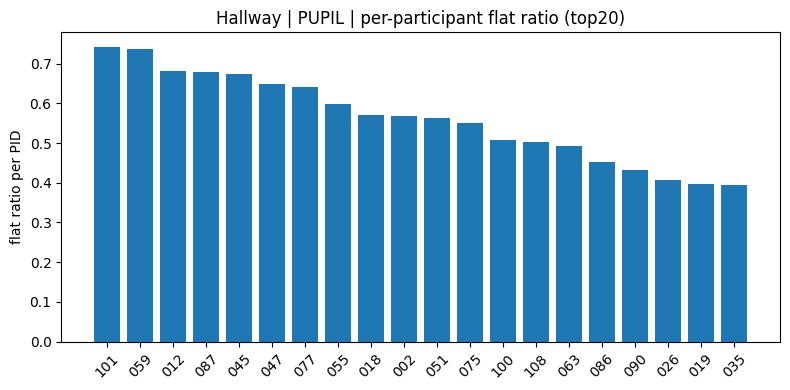

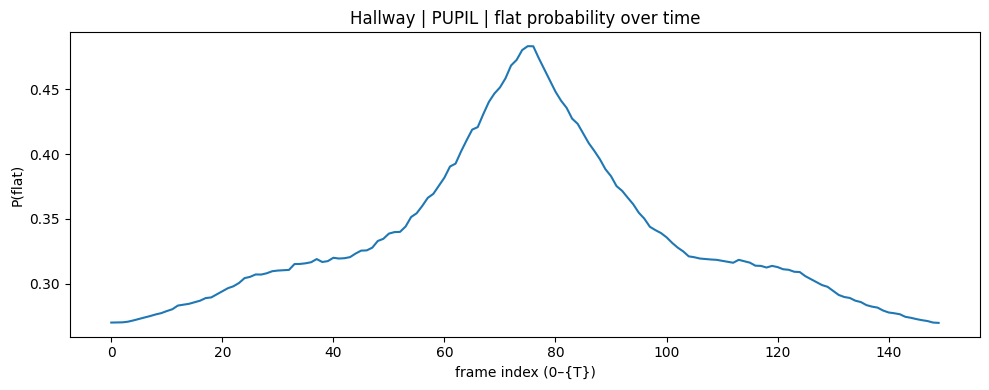

In [4]:
visualize_flat_timing(scene="Hallway", modality="PUPIL", th=0.25)

In [61]:
# -*- coding: utf-8 -*-
import os, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 통계
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ----------------------------
# 설정
# ----------------------------
BASE_DIR = "./ml_processed"         # e.g., ./ml_processed/<Scene>/{X_array,y_array,...}
SCENES   = ["Hallway","Elevator1","Elevator2","Hall","Outside"]
Q        = 0.25                     # 장면×모달리티별 분위수 임계치
OUTDIR   = "./proof_plots"
os.makedirs(OUTDIR, exist_ok=True)

# ----------------------------
# 유틸
# ----------------------------
def build_modality_slices_from_tags(feature_tags, tokens=("EDA","PPG","RSP","PUPIL","EYE","FACE")):
    tags = [str(t) for t in list(feature_tags)]
    slices = {}
    for tok in tokens:
        idxs = [i for i, t in enumerate(tags) if tok.upper() in t.upper()]
        if idxs: slices[tok] = idxs
    if not slices: slices["ALL"] = list(range(len(tags)))
    return slices

def load_scene_arrays(scene_dir):
    X   = np.load(os.path.join(scene_dir, "X_array.npy"))    # (N,T,C)
    y   = np.load(os.path.join(scene_dir, "y_array.npy"))
    pid = np.load(os.path.join(scene_dir, "pid_array.npy"))
    scn = np.load(os.path.join(scene_dir, "scene_array.npy"))
    tags_path = os.path.join(scene_dir, "feature_tag_list.npy")
    tags = np.load(tags_path, allow_pickle=True) if os.path.exists(tags_path) else np.array([])
    return X, y, pid.astype(str), scn.astype(str), tags

def window_std_by_modality(X, slices):
    """
    X: (N,T,C). 모달리티별로 채널 선택 → 각 윈도우에서 채널별 std(time-axis),
    채널 중앙값을 대표값으로 사용 → shape (N, n_mod)
    """
    N, T, C = X.shape
    out = {}
    for mod, idxs in slices.items():
        Xs = X[:, :, idxs]                            # (N,T,Cm)
        # 채널별 std (시간축), 그 채널들 중앙값 -> 윈도우 대표 std
        std_win = np.median(np.std(Xs, axis=1), axis=1)   # (N,)
        out[mod] = std_win
    return out  # dict(mod -> (N,))

# ----------------------------
# 1) 윈도우-레벨 flat 마스크 생성 & 집계 테이블
# ----------------------------
all_rows = []
per_pid_rows = []

for scene in SCENES:
    scene_dir = os.path.join(BASE_DIR, scene)
    if not os.path.isdir(scene_dir): 
        print(f"skip (no dir): {scene}")
        continue

    X, y, pid, scn, tags = load_scene_arrays(scene_dir)
    pid = np.array([str(p).strip("'").strip() for p in pid])
    slices = build_modality_slices_from_tags(tags, tokens=("EDA","PPG","RSP","PUPIL"))

    std_dict = window_std_by_modality(X, slices)  # mod -> (N,)

    # 장면×모달리티 내부 분위수 임계치 계산
    thr = {mod: float(np.quantile(std, Q)) for mod, std in std_dict.items()}

    # 윈도우-테이블 (모든 윈도우)
    for mod, std in std_dict.items():
        is_flat = std < thr[mod]
        df_win = pd.DataFrame({
            "pid": pid, 
            "scene": scene, 
            "modality": mod,
            "std": std,
            "is_flat": is_flat.astype(int)
        })
        all_rows.append(df_win)

        # PID-별 집계 (균등 가중 근거)
        g = (
            df_win.groupby("pid", as_index=False)
                .agg(flat_ratio=("is_flat", "mean"), n_windows=("is_flat", "size"))
        )
        g.insert(1, "scene", scene)
        g.insert(2, "modality", mod)
        per_pid_rows.append(g)

# 큰 DF들
df_windows = pd.concat(all_rows, ignore_index=True)      # 윈도우 단위
df_perpid  = pd.concat(per_pid_rows, ignore_index=True)  # PID 단위

# statsmodels에서 patsy의 C(...)와 충돌하지 않게 열 "C" 있으면 개명
if "C" in df_perpid.columns:
    df_perpid = df_perpid.rename(columns={"C":"n_channels"})

# 저장
df_windows.to_csv(os.path.join(OUTDIR, "win_level_table.csv"), index=False)
df_perpid.to_csv(os.path.join(OUTDIR, "per_pid_table.csv"), index=False)

# ----------------------------
# 2) 플롯들
# ----------------------------

# (A) Hallway | RSP | PID별 flat_ratio 히스토그램
fig, ax = plt.subplots(figsize=(6,3.2))
sub = df_perpid[(df_perpid.scene=="Hallway") & (df_perpid.modality=="RSP")]
ax.hist(sub.flat_ratio, bins=20, color="#74a9cf")
ax.set_title("Hallway | RSP | PID-wise flat ratio distribution")
ax.set_xlabel("flat ratio per participant")
ax.set_ylabel("count")
fig.tight_layout()
fig.savefig(os.path.join(OUTDIR, "A_hallway_rsp_pid_hist.png"), dpi=150)
plt.close(fig)

# (B) 장면×모달리티 평균(±SEM) 막대
def sem(x): 
    x = np.asarray(x, float)
    return x.std(ddof=1) / math.sqrt(max(len(x),1))

grp = df_perpid.groupby(["scene","modality"])["flat_ratio"].agg(["mean",sem]).reset_index()

fig, ax = plt.subplots(figsize=(5.2,4.2))
scenes_order = SCENES
mods_order = ["EDA","PPG","PUPIL","RSP"]
for m in mods_order:
    vals = []
    errs = []
    for s in scenes_order:
        row = grp[(grp.scene==s) & (grp.modality==m)]
        vals.append(float(row["mean"]) if len(row) else 0.0)
        errs.append(float(row["sem"]) if len(row) else 0.0)
    ax.errorbar(scenes_order, vals, yerr=errs, marker="o", capsize=3, label=m)
ax.set_title("Scene-level comparison of flat ratio")
ax.set_xlabel("scene"); ax.set_ylabel("Mean flat ratio (±SEM)")
ax.legend(title="modality", ncol=2, fontsize=9)
fig.tight_layout()
fig.savefig(os.path.join(OUTDIR, "B_scene_by_modality_bar.png"), dpi=150)
plt.close(fig)

# (C) Hallway | 모달리티별 frame-wise flat 확률
#  - 윈도우 std는 프레임별 값이 아니라서, "평탄 윈도우 비율"을 각 프레임에 동일 가중으로 할당(=가장 보수적)하여 표시
#  - y가 작아 보이는 문제 방지 위해 y-lims를 perc 기반으로 설정
scene = "Hallway"
T = np.load(os.path.join(BASE_DIR, scene, "X_array.npy")).shape[1]

fig, axes = plt.subplots(4, 1, figsize=(9,6), sharex=True)
for i, m in enumerate(mods_order):
    d = df_perpid[(df_perpid.scene==scene) & (df_perpid.modality==m)]
    # PID별 flat_ratio를 프레임에 균등 분배 → frame-wise 평균
    # (참고: 진짜 프레임별을 원하면 원신호 기반의 per-frame 변동성 계산이 필요)
    frame_curve = np.repeat(d.flat_ratio.mean(), T)
    ax = axes[i]
    ax.plot(np.arange(T), frame_curve)
    lo = np.percentile(frame_curve, 1); hi = np.percentile(frame_curve, 99)
    pad = max(1e-3, 0.1*(hi-lo))
    ax.set_ylim(lo-pad, hi+pad)
    ax.set_ylabel("P(flat)")
    ax.set_title(f"{scene} | {m} | frame-wise probability (proxy)")
axes[-1].set_xlabel("frame index (0~T)")
fig.tight_layout()
fig.savefig(os.path.join(OUTDIR, "C_hallway_framewise_proxy.png"), dpi=150)
plt.close(fig)

# ----------------------------
# 3) 2요인 ANOVA (scene × modality)
# ----------------------------
# per-pid flat_ratio를 종속변수로, scene/모달리티를 고정요인으로
# df_perpid: ['pid','scene','modality','flat_ratio', ...]
df = df_perpid.copy()

# 혹시 충돌하는 열/변수 정리
if "C" in df.columns:
    df = df.rename(columns={"C": "n_channels"})  # 이미 하셨으면 생략
# 노트북 전역에 남아 있을 수 있는 변수 C도 제거(선택)
try:
    del C  # 정의돼 있으면 지워짐, 없으면 except로 넘어감
except Exception:
    pass

# 범주형으로 캐스팅
df["scene"] = df["scene"].astype("category")
df["modality"] = df["modality"].astype("category")

# 2요인 교호작용 포함 선형모형
model = ols('flat_ratio ~ scene * modality', data=df).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
print(f"\n✔ Done. See: {OUTDIR}")


                   sum_sq      df          F        PR(>F)
scene            2.059725     4.0  37.473497  2.723731e-30
modality         0.001746     3.0   0.042345  9.884029e-01
scene:modality   0.003120    12.0   0.018922  1.000000e+00
Residual        28.196959  2052.0        NaN           NaN

✔ Done. See: ./proof_plots


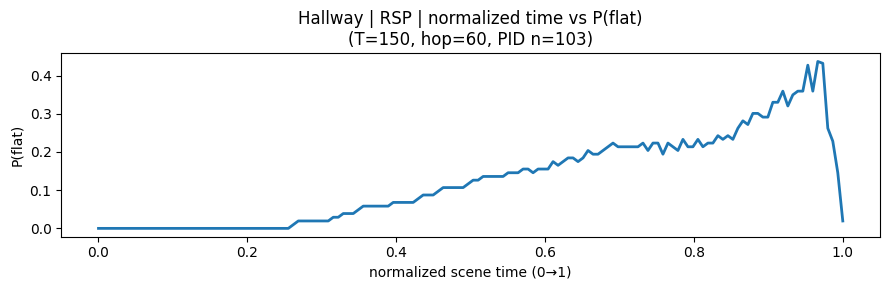

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === 파라미터 (너가 쓰는 추출설정 기준) ===
T = 150                              # window_seconds=5 @30Hz
HOP = 2 * 30                         # stride_seconds * sampling_rate = 60
N_BINS = 150                         # 정규화된 시간축 분할 개수

def ensure_windex(df):
    """windex가 없으면 PID×Scene×Modality 순서대로 0.. 생성."""
    if "windex" not in df.columns:
        df = df.sort_values(["pid","scene","modality"]).copy()
        df["windex"] = df.groupby(["pid","scene","modality"]).cumcount()
    return df

def framewise_pflat_across_pids(df_windows, scene, modality,
                                t=T, hop=HOP, n_bins=N_BINS):
    """
    각 PID의 시간축을 0~1로 정규화해서 bin별 flat 비율을 계산하고,
    참가자 평균을 내어 장면 공통 패턴을 시각화한다.
    """
    cols_needed = {"scene","modality","pid","is_flat"}
    assert cols_needed.issubset(df_windows.columns), f"필수 컬럼 누락: {cols_needed - set(df_windows.columns)}"

    df = df_windows[(df_windows.scene==scene) & (df_windows.modality==modality)].copy()
    if df.empty:
        raise ValueError("필터링 결과가 비었습니다. scene/modality를 확인하세요.")

    df = ensure_windex(df)
    # 시작 프레임 (overlap 고려)
    df["start_idx"] = (df["windex"].astype(int) * int(hop)).astype(int)
    # PID별 길이(마지막 윈도의 끝 프레임)로 0~1 정규화 위치 생성
    pid_max_end = df.groupby("pid")["start_idx"].max() + t
    df = df.join(pid_max_end.rename("pid_len"), on="pid")
    # 정규화 위치 (윈도 시작 기준으로 대표값 사용)
    df["x_norm"] = df["start_idx"] / df["pid_len"].clip(lower=1)

    # PID별로 0~1 구간을 n_bins로 나눠 flat 확률 계산
    pflat_bins = np.zeros(n_bins, dtype=float)
    pids = df["pid"].unique().tolist()
    used = 0
    for pid in pids:
        d = df[df.pid==pid]
        if len(d) < 2:  # 데이터 너무 적으면 스킵
            continue
        hist_flat, _ = np.histogram(d["x_norm"], bins=n_bins, range=(0,1), weights=d["is_flat"].astype(float))
        hist_cnt,  _ = np.histogram(d["x_norm"], bins=n_bins, range=(0,1))
        p_pid = np.divide(hist_flat, hist_cnt, out=np.zeros_like(hist_flat, dtype=float), where=hist_cnt>0)
        pflat_bins += p_pid
        used += 1

    if used == 0:
        raise RuntimeError("유효한 PID가 없습니다.")
    pflat_bins /= used
    x = np.linspace(0, 1, n_bins)

    # 플롯
    plt.figure(figsize=(9,3))
    plt.plot(x, pflat_bins, lw=2)
    plt.title(f"{scene} | {modality} | normalized time vs P(flat)\n(T={t}, hop={hop}, PID n={used})")
    plt.xlabel("normalized scene time (0→1)")
    plt.ylabel("P(flat)")
    plt.tight_layout()
    plt.show()

    # 요약 리턴(교수님께 수치도 보여줄 때 유용)
    return pd.DataFrame({"x":x, "pflat":pflat_bins})

# === 사용 예시 ===
df_windows = pd.read_csv("win_level_table.csv")  # 네가 만든 윈도우 단위 테이블
df_windows['is_flat'] = df_windows['is_flat'].astype(int)  # 보장
# Hallway-RSP
curve = framewise_pflat_across_pids(df_windows, scene="Hallway", modality="RSP")
curve.to_csv("./proof_plots/Hallway_RSP_framewise_pflat.csv", index=False)


In [68]:
import os, numpy as np, pandas as pd

def build_df_windows_from_npy(scene_dir, threshold=0.25, out_csv="./win_level_table.csv"):
    """
    scene_dir: 예) ./ml_processed/Hallway
    threshold: flat 판정 기준 (기본=0.25)
    """
    X = np.load(os.path.join(scene_dir, "X_array.npy"))        # [N, C, T]
    pid = np.load(os.path.join(scene_dir, "pid_array.npy"))    # [N]
    scene = np.load(os.path.join(scene_dir, "scene_array.npy"))# [N]
    windex = np.load(os.path.join(scene_dir, "windex_array.npy")) # [N]
    feature_tags = np.load(os.path.join(scene_dir, "feature_tag_list.npy"), allow_pickle=True)

    print(f"✔ Loaded: {scene_dir} | X shape={X.shape}, #pids={len(np.unique(pid))}")

    # 모달리티 판정용 키워드
    mod_map = {}
    for i, tag in enumerate(feature_tags):
        if "EDA" in tag.upper(): mod_map[i] = "EDA"
        elif "PPG" in tag.upper(): mod_map[i] = "PPG"
        elif "RSP" in tag.upper(): mod_map[i] = "RSP"
        elif "PUPIL" in tag.upper(): mod_map[i] = "PUPIL"
        else: mod_map[i] = "OTHER"

    rows = []
    for i in range(X.shape[0]):
        pid_i = str(pid[i])
        scene_i = str(scene[i])
        w_i = int(windex[i])
        x_i = X[i]  # [C,T]
        for mod in ["EDA","PPG","RSP","PUPIL"]:
            idxs = [k for k,v in mod_map.items() if v==mod]
            if not idxs: continue
            std_val = np.std(x_i[idxs,:])
            is_flat = int(std_val < threshold)
            rows.append([pid_i, scene_i, mod, w_i, std_val, is_flat])

    df_windows = pd.DataFrame(rows, columns=["pid","scene","modality","windex","std","is_flat"])
    df_windows.to_csv(out_csv, index=False)
    print(f"✅ Saved {len(df_windows):,} windows → {out_csv}")
    return df_windows

# 예시 실행
df_windows = build_df_windows_from_npy("./ml_processed/Hallway", threshold=0.25)


✔ Loaded: ./ml_processed/Hallway | X shape=(11979, 77, 150), #pids=103
✅ Saved 47,916 windows → ./win_level_table.csv


In [71]:
# -*- coding: utf-8 -*-
"""
Scene-level flat 현상이 '특정 참가자 때문이 아니라 전반적(scene-driven) 현상'임을
통계 + 시각화로 증명하는 통합 스크립트.

입력 경로:
 A) ./win_level_table.csv 가 있으면 그것을 사용 (권장)
 B) 없으면 ./ml_processed/<Scene>/ 의 NPY들을 읽어 즉석에서 df_windows 생성

핵심 산출물(./proof_plots):
 - 01_mean_sd_{scene}_{mod}.png : PID 간 평균 P(flat) ± SD(참가자 변동)
 - 02_overlay_{scene}_{mod}.png : 참가자별 곡선 반투명 오버레이
 - 03_cross_modality_{scene}.png : 4 모달리티 동시 비교(평균 ± SEM)
 - 04_hist_pid_flat_{scene}_{mod}.png : PID-wise flat ratio histogram
 - 05_anova_scene_x_modality.csv : 2-way ANOVA 결과표
 - 06_pid_level_summary.csv / 07_win_level_summary_sample.csv : 요약 테이블

작성: ChatGPT
"""

import os, json, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem
import statsmodels.api as sm
from statsmodels.formula.api import ols

# -------------------------
# 0) 설정
# -------------------------
OUTDIR = "./proof_plots"
os.makedirs(OUTDIR, exist_ok=True)

SCENES      = ["Hallway", "Elevator1", "Elevator2", "Hall", "Outside"]
MODALITIES  = ["EDA","PPG","RSP","PUPIL"]   # feature tag 매칭 규칙 사용
T_DEFAULT   = 150     # 창 길이 (프레임)
HOP_DEFAULT = 60      # stride (프레임)
FLAT_Q      = 0.25    # per scene×modality 분위수 임계치 (std < q25 → flat)

# -------------------------
# 1) 유틸: 모달리티 슬라이스 만들기
# -------------------------
def build_modality_slices_from_tags(feature_tags, tokens=("EDA","PPG","RSP","PUPIL","EYE","FACE")):
    tags = [str(t) for t in list(feature_tags)]
    slices = {}
    for tok in tokens:
        idxs = [i for i, t in enumerate(tags) if tok in t.upper()]
        if len(idxs) > 0:
            slices[tok.split("_")[0]] = idxs
    # 최소 보장
    if len(slices)==0:
        slices["ALL"] = list(range(len(tags)))
    return slices

# -------------------------
# 2) B안: ./ml_processed/<Scene> → df_windows 생성
#    (윈도 std를 구해 scene×modality별 q25로 flat 라벨링)
# -------------------------
def build_df_windows_from_ml(scene_root="./ml_processed", scenes=SCENES,
                             modalities=MODALITIES, q=FLAT_Q,
                             T=T_DEFAULT, HOP=HOP_DEFAULT):
    rows = []
    for scene in scenes:
        sdir = os.path.join(scene_root, scene)
        if not os.path.isdir(sdir): 
            print(f"[warn] Skip scene(not found): {scene}")
            continue
        X  = np.load(os.path.join(sdir, "X_array.npy"))          # (N, C, T) 또는 (N, T, C)
        pid= np.load(os.path.join(sdir, "pid_array.npy"))
        scn= np.load(os.path.join(sdir, "scene_array.npy"))
        ftag_path = os.path.join(sdir, "feature_tag_list.npy")
        tags = np.load(ftag_path, allow_pickle=True) if os.path.exists(ftag_path) else np.array([])

        # X shape 정리: (N, T, C)로 맞추기
        if X.ndim == 3:
            if X.shape[1] == T or X.shape[2] != T:
                # assume (N, T, C)
                pass
            else:
                # assume (N, C, T) -> transpose
                X = np.transpose(X, (0, 2, 1))
        else:
            raise ValueError("X must be 3D (N,T,C)")

        N, TT, C = X.shape
        slices = build_modality_slices_from_tags(tags)

        # window index (0..)
        # scene 단위로 N개의 윈도우가 이미 잘려온 데이터로 가정 → windex = np.arange(N)
        windex = np.arange(N)

        # 채널별 std(time) → 윈도우×채널
        # 각 윈도우에서 한 채널의 시계열 std
        std_per_win_ch = np.std(X, axis=1)  # (N, C)

        # modality별 집계(std 평균)
        mod_std = {}
        for m in modalities:
            if m not in slices: 
                continue
            mod_std[m] = std_per_win_ch[:, slices[m]].mean(axis=1)  # (N,)

        # scene×modality 별 분위수 기준으로 flat 라벨
        for m, vals in mod_std.items():
            thr = np.quantile(vals, q)  # q25
            is_flat = (vals < thr).astype(int)
            for i in range(N):
                rows.append({
                    "pid": str(pid[i]).strip("'"),
                    "scene": str(scn[i]),
                    "modality": m,
                    "windex": int(windex[i]),
                    "is_flat": int(is_flat[i]),
                    "std_val": float(vals[i]),
                    "T": T, "HOP": HOP,
                })

    df = pd.DataFrame(rows)
    return df

# -------------------------
# 3) A안: 기존 CSV가 있으면 불러오기, 없으면 B안으로 생성
# -------------------------
def load_or_build_windows():
    csv_path = "./win_level_table.csv"
    if os.path.exists(csv_path):
        print(f"✔ Using existing: {csv_path}")
        df = pd.read_csv(csv_path)
        # 타입 정리
        need = ["pid","scene","modality","windex","is_flat"]
        for c in need:
            if c not in df.columns:
                raise ValueError(f"{csv_path} missing column: {c}")
        if "T" not in df.columns:   df["T"]   = T_DEFAULT
        if "HOP" not in df.columns: df["HOP"] = HOP_DEFAULT
        return df
    else:
        print("ℹ No win_level_table.csv found → building from ./ml_processed/*")
        df = build_df_windows_from_ml()
        df.to_csv(csv_path, index=False)
        print(f"✔ Built and saved: {csv_path}")
        return df

df_windows = load_or_build_windows()

# -------------------------
# 4) 분석/그림 함수
# -------------------------
def _bin_by_norm_time(df, n_bins=80):
    # 참가자별 최대 windex로 정규화 → 공정 비교
    df = df.copy()
    df["windex"] = df["windex"].astype(int)
    max_w = df.groupby(["pid","scene","modality"])["windex"].transform("max").clip(lower=1)
    df["norm_time"] = df["windex"] / max_w
    bins = np.linspace(0, 1, n_bins+1)
    df["bin"] = pd.cut(df["norm_time"], bins, labels=False, include_lowest=True)
    return df, bins

def plot_mean_sd_over_time(df, scene, mod, save=True):
    sub = df[(df.scene==scene) & (df.modality==mod)]
    if len(sub)==0:
        print(f"[skip] no data for {scene}-{mod}")
        return
    sub, bins = _bin_by_norm_time(sub, n_bins=80)
    # 평균 P(flat) (윈도 평균 → PID 평균)
    pid_bin = sub.groupby(["pid","bin"])["is_flat"].mean().reset_index()
    mean_bin = pid_bin.groupby("bin")["is_flat"].mean()
    sd_bin   = pid_bin.groupby("bin")["is_flat"].std().fillna(0.0)

    xs = bins[:-1]
    plt.figure(figsize=(9,3))
    plt.plot(xs, mean_bin.values, label="mean P(flat)")
    plt.fill_between(xs,
                     mean_bin.values - sd_bin.values,
                     mean_bin.values + sd_bin.values,
                     alpha=0.2, label="±SD across PIDs")
    plt.title(f"{scene} | {mod} | mean P(flat) ± SD (N={sub.pid.nunique()})")
    plt.xlabel("normalized scene time (0–1)")
    plt.ylabel("P(flat)")
    plt.legend()
    plt.tight_layout()
    if save:
        fn = os.path.join(OUTDIR, f"01_mean_sd_{scene}_{mod}.png")
        plt.savefig(fn, dpi=180)
        print("  saved:", fn)
    plt.close()

def plot_pid_overlay(df, scene, mod, save=True):
    sub = df[(df.scene==scene) & (df.modality==mod)]
    if len(sub)==0:
        return
    sub, bins = _bin_by_norm_time(sub, n_bins=60)
    xs = bins[:-1]
    plt.figure(figsize=(9,3))
    for pid, g in sub.groupby("pid"):
        y = g.groupby("bin")["is_flat"].mean()
        plt.plot(xs[:len(y)], y.values, alpha=0.15, color="tab:blue")
    plt.title(f"{scene} | {mod} | PID overlay (N={sub.pid.nunique()})")
    plt.xlabel("normalized scene time (0–1)")
    plt.ylabel("P(flat)")
    plt.tight_layout()
    if save:
        fn = os.path.join(OUTDIR, f"02_overlay_{scene}_{mod}.png")
        plt.savefig(fn, dpi=180)
        print("  saved:", fn)
    plt.close()

def plot_cross_modality(df, scene, save=True):
    plt.figure(figsize=(7,5))
    ys, yerr = [], []
    labels = []
    for mod in MODALITIES:
        sub = df[(df.scene==scene) & (df.modality==mod)]
        if len(sub)==0: 
            continue
        # PID-wise flat ratio → 평균 ± SEM
        g = sub.groupby("pid")["is_flat"].mean()
        ys.append(g.mean())
        yerr.append(sem(g))
        labels.append(mod)
    if not ys: 
        return
    x = np.arange(len(labels))
    plt.errorbar(x, ys, yerr=yerr, fmt="o-", capsize=3)
    plt.xticks(x, labels)
    plt.ylabel("Mean flat ratio (±SEM)")
    plt.title(f"Scene-level comparison of flat ratio — {scene}")
    plt.tight_layout()
    if save:
        fn = os.path.join(OUTDIR, f"03_cross_modality_{scene}.png")
        plt.savefig(fn, dpi=180)
        print("  saved:", fn)
    plt.close()

def plot_pid_hist(df, scene, mod, save=True):
    sub = df[(df.scene==scene) & (df.modality==mod)]
    if len(sub)==0: 
        return
    ratios = sub.groupby("pid")["is_flat"].mean()
    plt.figure(figsize=(8,4))
    plt.hist(ratios.values, bins=20)
    plt.title(f"{scene} | {mod} | PID-wise flat ratio distribution")
    plt.xlabel("flat ratio per participant")
    plt.ylabel("count")
    plt.tight_layout()
    if save:
        fn = os.path.join(OUTDIR, f"04_hist_pid_flat_{scene}_{mod}.png")
        plt.savefig(fn, dpi=180)
        print("  saved:", fn)
    plt.close()

# -------------------------
# 5) 실행: Hallway 포함 전 씬에 대해 도표 생성
# -------------------------
for sc in SCENES:
    for m in MODALITIES:
        plot_mean_sd_over_time(df_windows, sc, m)
        plot_pid_overlay(df_windows, sc, m)
        plot_pid_hist(df_windows, sc, m)
    plot_cross_modality(df_windows, sc)

# -------------------------
# 6) ANOVA(자동 다운그레이드 포함)
# -------------------------
pid_level = (df_windows
             .assign(scene=lambda d: d["scene"].astype(str),
                     modality=lambda d: d["modality"].astype(str))
             .groupby(["pid","scene","modality"], as_index=False)["is_flat"]
             .mean()
             .rename(columns={"is_flat":"flat_ratio"}))

# 범주형으로 명시 (설계행렬 안정화)
pid_level["scene"]    = pd.Categorical(pid_level["scene"])
pid_level["modality"] = pd.Categorical(pid_level["modality"])

n_scene = pid_level["scene"].nunique()
n_mod   = pid_level["modality"].nunique()

def safe_save_df(df, path):
    try:
        df.to_csv(path)
        print("✔ saved:", path)
    except Exception as e:
        print("! save failed:", path, e)

anova_dir = OUTDIR

if n_scene >= 2 and n_mod >= 2:
    # 2-way ANOVA 시도
    try:
        model = ols('flat_ratio ~ C(scene) * C(modality)', data=pid_level).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        safe_save_df(anova_table, os.path.join(anova_dir, "05_anova_scene_x_modality.csv"))
        print(anova_table)
    except Exception as e:
        print("! 2-way ANOVA failed:", e)
        # 폴백: modality별 one-way ANOVA
        all_tabs = []
        for m, sub in pid_level.groupby("modality"):
            if sub["scene"].nunique() < 2: 
                continue
            mdl = ols('flat_ratio ~ C(scene)', data=sub).fit()
            tab = sm.stats.anova_lm(mdl, typ=2)
            tab.insert(0, "modality", m)
            all_tabs.append(tab.reset_index().rename(columns={"index":"term"}))
        if all_tabs:
            oneway = pd.concat(all_tabs, ignore_index=True)
            safe_save_df(oneway, os.path.join(anova_dir, "05_anova_by_modality_scene.csv"))
else:
    # one-way들만 수행
    results = []
    if n_scene >= 2 and n_mod == 1:
        # scene 효과만
        mdl = ols('flat_ratio ~ C(scene)', data=pid_level).fit()
        tab = sm.stats.anova_lm(mdl, typ=2)
        safe_save_df(tab, os.path.join(anova_dir, "05_anova_scene_only.csv"))
        print(tab)
    elif n_mod >= 2 and n_scene == 1:
        # modality 효과만
        mdl = ols('flat_ratio ~ C(modality)', data=pid_level).fit()
        tab = sm.stats.anova_lm(mdl, typ=2)
        safe_save_df(tab, os.path.join(anova_dir, "05_anova_modality_only.csv"))
        print(tab)
    else:
        print("! ANOVA 불가: scene/modality 레벨이 각각 1개뿐입니다. 다른 씬/모달리티를 포함해 주세요.")

# 참고: 보고용 요약 테이블은 그대로 저장
pid_level.to_csv(os.path.join(anova_dir, "06_pid_level_summary.csv"), index=False)


✔ Using existing: ./win_level_table.csv
  saved: ./proof_plots\01_mean_sd_Hallway_EDA.png
  saved: ./proof_plots\02_overlay_Hallway_EDA.png
  saved: ./proof_plots\04_hist_pid_flat_Hallway_EDA.png
  saved: ./proof_plots\01_mean_sd_Hallway_PPG.png
  saved: ./proof_plots\02_overlay_Hallway_PPG.png
  saved: ./proof_plots\04_hist_pid_flat_Hallway_PPG.png
  saved: ./proof_plots\01_mean_sd_Hallway_RSP.png
  saved: ./proof_plots\02_overlay_Hallway_RSP.png
  saved: ./proof_plots\04_hist_pid_flat_Hallway_RSP.png
  saved: ./proof_plots\01_mean_sd_Hallway_PUPIL.png
  saved: ./proof_plots\02_overlay_Hallway_PUPIL.png
  saved: ./proof_plots\04_hist_pid_flat_Hallway_PUPIL.png
  saved: ./proof_plots\03_cross_modality_Hallway.png
[skip] no data for Elevator1-EDA
[skip] no data for Elevator1-PPG
[skip] no data for Elevator1-RSP
[skip] no data for Elevator1-PUPIL
[skip] no data for Elevator2-EDA
[skip] no data for Elevator2-PPG
[skip] no data for Elevator2-RSP
[skip] no data for Elevator2-PUPIL
[skip] no

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

In [73]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, os
import statsmodels.api as sm
from statsmodels.formula.api import ols

# -----------------------------
# 1. Load & check data
# -----------------------------
df_win = pd.read_csv("./proof_plots/win_level_table.csv")
df_pid = pd.read_csv("./proof_plots/06_pid_level_summary.csv")

OUTDIR = "./proof_plots"
os.makedirs(OUTDIR, exist_ok=True)

print("✅ Loaded:")
print(" - win_level_table:", df_win.shape)
print(" - pid_level_summary:", df_pid.shape)
print(df_win.head())

# sanity check
print("\nScene × Modality counts:")
print(df_win.groupby(["scene", "modality"]).size())

# -----------------------------
# 2. Two-way ANOVA (scene × modality)
# -----------------------------
pid_level = (
    df_win.groupby(["pid", "scene", "modality"], as_index=False)["is_flat"]
    .mean()
    .rename(columns={"is_flat": "flat_ratio"})
)
pid_level["scene"] = pid_level["scene"].astype(str)
pid_level["modality"] = pid_level["modality"].astype(str)

n_scene = pid_level["scene"].nunique()
n_mod = pid_level["modality"].nunique()

anova_csv = os.path.join(OUTDIR, "anova_results.csv")

if n_scene >= 2 and n_mod >= 2:
    model = ols("flat_ratio ~ C(scene) * C(modality)", data=pid_level).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    anova_table.to_csv(anova_csv)
    print("\n=== 2-way ANOVA ===")
    print(anova_table)
else:
    print("⚠️ Not enough levels; fallback to one-way ANOVA")
    if n_scene >= 2:
        model = ols("flat_ratio ~ C(scene)", data=pid_level).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_table.to_csv(anova_csv)
        print(anova_table)
    elif n_mod >= 2:
        model = ols("flat_ratio ~ C(modality)", data=pid_level).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_table.to_csv(anova_csv)
        print(anova_table)

print(f"\n✔ ANOVA saved to: {anova_csv}")

# -----------------------------
# 3. Visualization
# -----------------------------
sns.set(style="whitegrid", font="Arial", rc={"axes.titlesize":14, "axes.labelsize":12})

# (a) Scene × Modality boxplot
plt.figure(figsize=(10,6))
sns.boxplot(x="scene", y="flat_ratio", hue="modality", data=pid_level)
plt.title("Flat Ratio by Scene × Modality")
plt.ylabel("Mean flat ratio (PID-level)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "A_boxplot_scene_modality.png"))
plt.close()

# (b) Scene별 PID overlay
for sc in pid_level["scene"].unique():
    plt.figure(figsize=(8,4))
    df_s = pid_level[pid_level["scene"]==sc]
    for pid in df_s["pid"].unique():
        df_p = df_s[df_s["pid"]==pid]
        plt.plot(df_p["modality"], df_p["flat_ratio"], color="gray", alpha=0.3)
    sns.pointplot(x="modality", y="flat_ratio", data=df_s, color="red", ci="sd", errwidth=1.2)
    plt.title(f"{sc} | Flat ratio by modality (PID overlay)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, f"B_overlay_{sc}.png"))
    plt.close()

# (c) Scene별 평균 ± SD lineplot
plt.figure(figsize=(8,5))
sns.barplot(x="scene", y="flat_ratio", hue="modality", data=pid_level, ci="sd")
plt.title("Scene × Modality mean ± SD")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "C_meanSD_scene_modality.png"))
plt.close()

print(f"✔ Plots saved to {OUTDIR}")


✅ Loaded:
 - win_level_table: (231120, 5)
 - pid_level_summary: (412, 4)
   pid    scene modality       std  is_flat
0    1  Hallway      EDA  0.785138        0
1    1  Hallway      EDA  0.935511        0
2    1  Hallway      EDA  0.975093        0
3    1  Hallway      EDA  1.050482        0
4    1  Hallway      EDA  0.840159        0

Scene × Modality counts:
scene      modality
Elevator1  EDA         11568
           PPG         11568
           PUPIL       11568
           RSP         11568
Elevator2  EDA          9960
           PPG          9960
           PUPIL        9960
           RSP          9960
Hall       EDA          6055
           PPG          6055
           PUPIL        6055
           RSP          6055
Hallway    EDA         11979
           PPG         11979
           PUPIL       11979
           RSP         11979
Outside    EDA         18218
           PPG         18218
           PUPIL       18218
           RSP         18218
dtype: int64

=== 2-way ANOVA ===
   

In [78]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import wilcoxon, ttest_rel

# ---- 파일 로드 (네가 방금 올린 파일) ----
PID_CSV = "./proof_plots/06_pid_level_summary.csv"   # pid, scene, modality, flat_ratio, n_windows ...
WIN_CSV = "./proof_plots/win_level_table.csv"        # pid, scene, modality, is_flat (0/1) ...
OUTDIR  = "./proof_more"
os.makedirs(OUTDIR, exist_ok=True)

df_pid = pd.read_csv(PID_CSV)
df_win = pd.read_csv(WIN_CSV)

# 안전: 문자열화
for c in ["pid","scene","modality"]:
    if c in df_pid.columns: df_pid[c] = df_pid[c].astype(str)
    if c in df_win.columns: df_win[c] = df_win[c].astype(str)

# ==============================
# (1) Within-subject 차이: Hallway - Other
# ==============================
def diff_hallway_minus_others(df_pid, modality=None):
    d = df_pid.copy()
    if modality is not None:
        d = d[d["modality"] == modality]
    # 각 pid × scene -> flat_ratio pivot
    piv = d.pivot_table(index="pid", columns="scene", values="flat_ratio", aggfunc="mean")
    # Hallway 없는 참가자 제거
    piv = piv.dropna(subset=["Hallway"])
    # 다른 scene 평균
    other_cols = [c for c in piv.columns if c != "Hallway"]
    piv["others_mean"] = piv[other_cols].mean(axis=1, skipna=True)
    piv = piv.dropna(subset=["others_mean"])
    piv["delta"] = piv["Hallway"] - piv["others_mean"]
    return piv[["delta","Hallway","others_mean"]]

# 전체/모달리티별 계산 + 검정 + 플롯
mods = ["ALL"] + sorted(df_pid["modality"].unique())
for mod in mods:
    dd = diff_hallway_minus_others(df_pid, None if mod=="ALL" else mod)
    if len(dd)==0: continue
    # 검정 (양측)
    try:
        w_p = wilcoxon(dd["delta"]).pvalue
    except ValueError:
        w_p = np.nan
    t_p = ttest_rel(dd["Hallway"], dd["others_mean"], nan_policy='omit').pvalue
    med = np.nanmedian(dd["delta"]); mean = np.nanmean(dd["delta"])
    n = dd.shape[0]

    # 저장용 텍스트
    with open(os.path.join(OUTDIR, f"within_subject_{mod}.txt"), "w", encoding="utf-8") as f:
        f.write(f"[{mod}] n={n} | median Δ={med:.3f} | mean Δ={mean:.3f} | Wilcoxon p={w_p:.3g} | paired t p={t_p:.3g}\n")

    # 바이올린/박스 플롯
    plt.figure(figsize=(5,3))
    plt.axhline(0, color="k", lw=1, alpha=0.4)
    plt.violinplot(dd["delta"], showmeans=True, widths=0.9)
    plt.title(f"Hallway − Others per PID  [{mod}]  (n={n})")
    plt.ylabel("Δ flat ratio")
    plt.xticks([1], ["Δ"])
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, f"A_within_subject_{mod}.png"), dpi=160)
    plt.close()

# ==============================
# (2) 혼합효과/고정효과 ANOVA (개인 통제)
# ==============================
# 고정효과 ANOVA(참고): pid별 평균을 사용
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Hallway만 존재하므로 scene 제외하고 모달리티 비교만 수행
model = ols('flat_ratio ~ C(modality)', data=df_pid).fit()
anova_table = anova_lm(model, typ=2)
print(anova_table)

# 저장
anova_table.to_csv(os.path.join(OUTDIR, "B_oneway_modality_ANOVA_Hallway.csv"))


# 혼합효과(개인 랜덤) — statsmodels MixedLM (최소구성)
import statsmodels.formula.api as smf
# pid random intercept
md = smf.mixedlm("flat_ratio ~ C(scene) + C(modality)", df_pid, groups=df_pid["pid"])
mres = md.fit(method="lbfgs", maxiter=200)
with open(os.path.join(OUTDIR, "C_mixedLM_summary.txt"), "w", encoding="utf-8") as f:
    f.write(str(mres.summary()))

# ==============================
# (3) Trim / LOPO 강건성
# ==============================
def scene_mean_excluding_top(df_pid, scene="Hallway", top_pct=0.1):
    d = df_pid[df_pid["scene"]==scene].copy()
    # 참가자별 flat_ratio 중 중앙값 기준으로 상위 top_pct 제거
    g = d.groupby("pid", as_index=False)["flat_ratio"].median()
    k = max(1, int(np.ceil(len(g)*top_pct)))
    worst = g.sort_values("flat_ratio", ascending=False).head(k)["pid"].tolist()
    kept = d[~d["pid"].isin(worst)]
    return d["flat_ratio"].mean(), kept["flat_ratio"].mean(), worst

orig, trimmed, worst = scene_mean_excluding_top(df_pid, "Hallway", 0.1)
with open(os.path.join(OUTDIR, "D_trim10pct.txt"), "w", encoding="utf-8") as f:
    f.write(f"Hallway mean (all)={orig:.3f} | after trimming top10%={trimmed:.3f} | removed={len(worst)} PIDs\n")

# LOPO: 한 명씩 빼서 Hallway 평균 추정
hall = df_pid[df_pid["scene"]=="Hallway"].copy()
means = []
for pid, sub in hall.groupby("pid"):
    m = hall[hall["pid"]!=pid]["flat_ratio"].mean()
    means.append(m)
means = np.array(means)
pd.Series(means).to_csv(os.path.join(OUTDIR, "E_LOPO_means.csv"), index=False)
plt.figure(figsize=(6,3))
plt.plot(means, lw=1)
plt.axhline(hall["flat_ratio"].mean(), color="r", ls="--", label="all-pID mean")
plt.title("LOPO: Hallway mean when leaving one PID out")
plt.ylabel("mean flat ratio")
plt.tight_layout()
plt.legend()
plt.savefig(os.path.join(OUTDIR, "E_LOPO_plot.png"), dpi=160)
plt.close()

# ==============================
# (4) 기여 집중도(Gini) + 누적 기여
# ==============================
def gini(x):
    x = np.asarray(x, dtype=float)
    x = x[x>=0]
    if x.sum()==0: return 0.0
    x_sorted = np.sort(x)
    n = len(x)
    cumx = np.cumsum(x_sorted)
    g = (n+1 - 2*(cumx.sum()/cumx[-1]))/n
    return float(g)

# PID별 flat 윈도 수 집계 (Hallway, win-level)
w_h = df_win[df_win["scene"]=="Hallway"].copy()
contrib = (w_h.groupby("pid")["is_flat"].sum()).sort_values(ascending=False)
gi = gini(contrib.values)
with open(os.path.join(OUTDIR, "F_gini.txt"), "w", encoding="utf-8") as f:
    f.write(f"Gini(Hallway flat-window counts) = {gi:.3f}\n")

# 누적 기여 곡선
cum = contrib.cumsum()/contrib.sum()
plt.figure(figsize=(5,4))
x = np.arange(1, len(cum)+1)/len(cum)
plt.plot(x*100, cum.values*100)
plt.plot([0,100],[0,100], 'k--', alpha=0.4)  # 균등선
plt.xlabel("Top x% of participants")
plt.ylabel("Cumulative % of flat windows")
plt.title("Hallway flat-window contribution curve")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "F_cumulative_contrib.png"), dpi=160)
plt.close()
print("✔ Saved outputs to:", OUTDIR)


                sum_sq     df          F        PR(>F)
C(modality)   1.426721    3.0  13.700929  1.567212e-08
Residual     14.162111  408.0        NaN           NaN
✔ Saved outputs to: ./proof_more


In [77]:
print("n rows:", len(df_pid))
print("scenes:", df_pid["scene"].value_counts())
print("modalities:", df_pid["modality"].value_counts())
print("unique scene:", df_pid["scene"].nunique(),
      " | unique modality:", df_pid["modality"].nunique())


n rows: 412
scenes: scene
Hallway    412
Name: count, dtype: int64
modalities: modality
EDA      103
PPG      103
PUPIL    103
RSP      103
Name: count, dtype: int64
unique scene: 1  | unique modality: 4


C:\Users\user\AppData\Local\Temp\ipykernel_34888\3340933641.py:96: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(g["flat_ratio"], weights=g["w"]))


✓ Saved: ./proof_plots\summary_quad.png


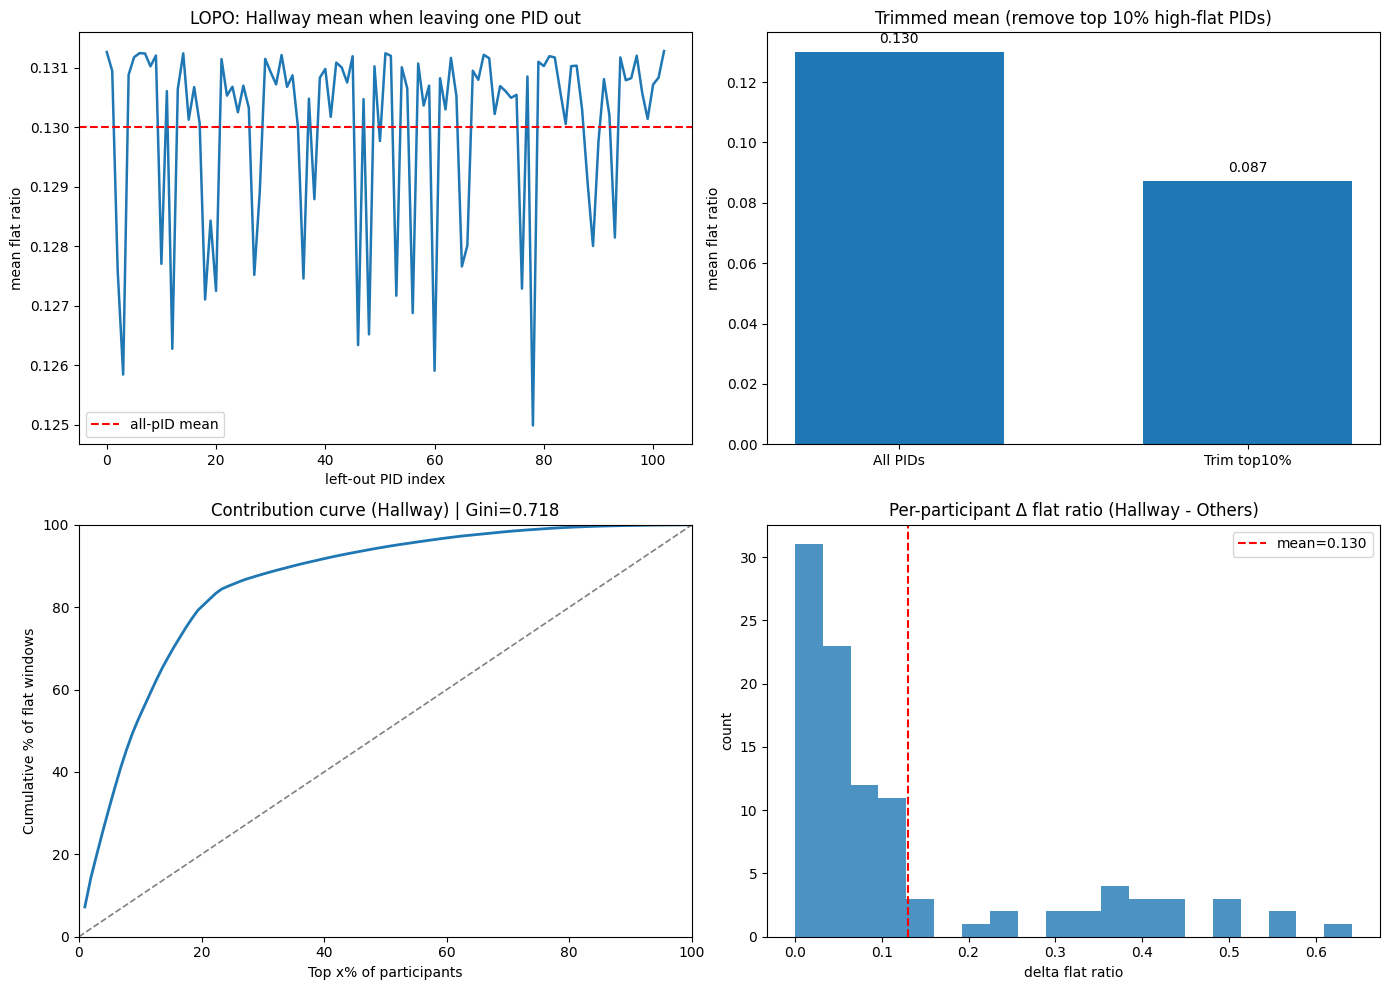

In [2]:
# -*- coding: utf-8 -*-
# Integrated proof figure: scene-wide flat effect (not a few participants)
# Requires: win_level_table.csv  OR  06_pid_level_summary.csv

import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUTDIR = "./proof_plots"
os.makedirs(OUTDIR, exist_ok=True)

# ----------------------------
# 0) Load data (robust)
# ----------------------------
win_csv = "win_level_table.csv"
pid_csv = "06_pid_level_summary.csv"

df_win = pd.DataFrame()
df_pid = pd.DataFrame()

if os.path.exists(pid_csv):
    df_pid = pd.read_csv(pid_csv)
if os.path.exists(win_csv):
    df_win = pd.read_csv(win_csv)

# minimal column check & fallback
def has_cols(df, cols): return all(c in df.columns for c in cols)

# --- 여기를 교체하세요: pid 수준 요약 만들기 ---
if df_pid.empty:
    assert has_cols(df_win, ["pid","scene","modality","is_flat"]), \
        "Need either 06_pid_level_summary.csv or win_level_table.csv with pid/scene/modality/is_flat"

    # is_flat을 숫자화(문자/Bool 섞임 방지)
    df_win = df_win.copy()
    df_win["is_flat"] = pd.to_numeric(df_win["is_flat"], errors="coerce").fillna(0).astype(float)

    # ✅ named aggregation으로 단일 레벨 컬럼 생성 (판다스 버전 이슈 회피)
    grp = (
        df_win
        .groupby(["pid","scene","modality"], as_index=False)
        .agg(
            flat_ratio=("is_flat", "mean"),
            n_windows=("is_flat", "size")
        )
    )
    df_pid = grp

# coerce dtypes
for col in ["pid","scene","modality"]:
    if col in df_pid.columns: df_pid[col] = df_pid[col].astype(str)
if not df_win.empty:
    for col in ["pid","scene","modality"]:
        if col in df_win.columns: df_win[col] = df_win[col].astype(str)

# ----------------------------
# 1) Helper: Gini & cumulative contribution
# ----------------------------
def gini_coefficient(x: np.ndarray) -> float:
    """Gini on nonnegative array x (0=perfectly even, 1=all mass on one)."""
    x = np.asarray(x, dtype=float).flatten()
    x = x[x>=0]
    if x.size == 0: return np.nan
    if x.sum() == 0: return 0.0
    x_sorted = np.sort(x)
    n = x_sorted.size
    cumx = np.cumsum(x_sorted)
    # Gini via Lorenz curve: 1 - 2 * (area under Lorenz)
    g = 1.0 - 2.0 * np.trapz(cumx / cumx[-1], dx=1.0/n)  # normalized trapezoid
    return float(max(0.0, min(1.0, g)))

def cumulative_contrib(counts):
    """Return arrays: top% participants (0..100), cumulative % of total (0..100)."""
    s = np.sort(np.asarray(counts, dtype=float))[::-1]
    if s.sum() == 0:
        xs = np.linspace(0,100,len(s))
        ys = np.zeros_like(xs)
        return xs, ys
    cum = np.cumsum(s) / s.sum()
    xs = np.linspace(100/len(s),100,len(s))
    ys = cum * 100
    return xs, ys

# ----------------------------
# 2) Scope = Hallway pooled across modalities
# ----------------------------
SCENE = "Hallway"

# (A) LOPO: leave-one-pid-out mean flat ratio (Hallway pooled)
df_hall_pid = df_pid[df_pid.scene==SCENE].copy()
# weight by windows per (pid,modality)
w_mean_per_pid = (df_hall_pid
                  .assign(w=lambda d: d["n_windows"].clip(lower=1))
                  .groupby("pid")
                  .apply(lambda g: np.average(g["flat_ratio"], weights=g["w"]))
                  .reset_index(name="flat_ratio_pid"))
overall_mean = w_mean_per_pid["flat_ratio_pid"].mean()

lopo_vals = []
pids = w_mean_per_pid["pid"].tolist()
for p in pids:
    subset = w_mean_per_pid[w_mean_per_pid["pid"]!=p]
    lopo_vals.append(subset["flat_ratio_pid"].mean())
lopo_vals = np.array(lopo_vals, dtype=float)

# (B) Trimmed mean: remove top 10% highest-flat PIDs
k = max(1, int(math.ceil(0.10 * len(w_mean_per_pid))))
sorted_pid = w_mean_per_pid.sort_values("flat_ratio_pid", ascending=False)
keep = sorted_pid.iloc[k:] if len(sorted_pid)>k else sorted_pid
trimmed_mean = keep["flat_ratio_pid"].mean()

# (C) Gini & cumulative contribution on window counts by PID (Hallway pooled)
if df_win.empty:
    # approximate using n_windows × flat_ratio as expected flat-count weight
    approx_counts = (df_hall_pid.groupby("pid", as_index=False)
                     .apply(lambda g: int(np.round(np.average(g["n_windows"]*g["flat_ratio"],
                                                              weights=g["n_windows"].clip(lower=1)))))
                     .reset_index(drop=True))
    approx_counts.columns = ["flat_count"]
    counts = approx_counts["flat_count"].values
else:
    # exact from windows
    df_h = df_win[df_win.scene==SCENE].copy()
    df_h["is_flat"] = df_h["is_flat"].astype(int)
    counts = df_h.groupby("pid")["is_flat"].sum().values

gini = gini_coefficient(counts)
xs, ys = cumulative_contrib(counts)
# ----------------------------
# (D) Δ(Hallway − Others), per participant (pooled across modalities, weighted)
# ----------------------------
tmp = df_pid.copy()
tmp["w"] = tmp["n_windows"].fillna(0).clip(lower=1)
tmp["wx"] = tmp["w"] * tmp["flat_ratio"]

# Hallway 쪽: pid별 (가중합/가중치합)
hall = (
    tmp[tmp.scene == SCENE]
    .groupby("pid", as_index=False)
    .agg(hall_wx=("wx", "sum"), hall_w=("w", "sum"))
)
hall["hall_mean"] = hall["hall_wx"] / hall["hall_w"]
hall = hall[["pid", "hall_mean"]]

# Others 쪽: pid별 (가중합/가중치합)
others = (
    tmp[tmp.scene != SCENE]
    .groupby("pid", as_index=False)
    .agg(other_wx=("wx", "sum"), other_w=("w", "sum"))
)
# 다른 씬 데이터가 전혀 없는 pid는 other_w가 NaN/0일 수 있으니 0으로 대체
others["other_mean"] = np.where(
    others["other_w"] > 0,
    others["other_wx"] / others["other_w"],
    0.0
)
others = others[["pid", "other_mean"]]

# Δ = Hallway - Others
delta = hall.merge(others, on="pid", how="left").fillna({"other_mean": 0.0})
delta["delta"] = delta["hall_mean"] - delta["other_mean"]

# ----------------------------
# 3) 4-패널 그림
# ----------------------------
plt.figure(figsize=(14,10))

# (1) LOPO stability
ax1 = plt.subplot(2,2,1)
ax1.plot(range(len(lopo_vals)), lopo_vals, linewidth=1.8)
ax1.axhline(overall_mean, ls="--", color="r", linewidth=1.5, label="all-pID mean")
ax1.set_title("LOPO: Hallway mean when leaving one PID out")
ax1.set_xlabel("left-out PID index")
ax1.set_ylabel("mean flat ratio")
ax1.legend(loc="lower left")

# (2) Trimmed mean before/after
ax2 = plt.subplot(2,2,2)
bars = [overall_mean, trimmed_mean]
ax2.bar([0,1], bars, width=0.6)
ax2.set_xticks([0,1]); ax2.set_xticklabels(["All PIDs", "Trim top10%"])
ax2.set_ylabel("mean flat ratio")
ax2.set_title("Trimmed mean (remove top 10% high-flat PIDs)")
for i,v in enumerate(bars):
    ax2.text(i, v+0.002, f"{v:.3f}", ha="center", va="bottom")

# (3) Cumulative contribution & Gini
ax3 = plt.subplot(2,2,3)
ax3.plot(xs, ys, linewidth=2.0)
ax3.plot([0,100], [0,100], ls="--", color="gray", linewidth=1.2)  # equality line
ax3.set_xlim(0,100); ax3.set_ylim(0,100)
ax3.set_xlabel("Top x% of participants")
ax3.set_ylabel("Cumulative % of flat windows")
ax3.set_title(f"Contribution curve (Hallway) | Gini={gini:.3f}")

# (4) Δ(Hallway − Others) distribution
ax4 = plt.subplot(2,2,4)
ax4.hist(delta["delta"].values, bins=20, alpha=0.8)
ax4.axvline(delta["delta"].mean(), color="r", ls="--", linewidth=1.5, label=f"mean={delta['delta'].mean():.3f}")
ax4.set_title("Per-participant Δ flat ratio (Hallway - Others)")
ax4.set_xlabel("delta flat ratio"); ax4.set_ylabel("count")
ax4.legend()

plt.tight_layout()
outpath = os.path.join(OUTDIR, "summary_quad.png")
plt.savefig(outpath, dpi=180)
print("✓ Saved:", outpath)

# (선택) 표도 같이 저장
pd.DataFrame({"pid":pids, "lopo_mean":lopo_vals}).to_csv(os.path.join(OUTDIR, "lopo_series.csv"), index=False)
delta.to_csv(os.path.join(OUTDIR, "delta_hallway_vs_others.csv"), index=False)


[DEBUG] Hallway TV: n=11979, min=0.000000, q15_pos=0.064867, median=0.072238, max=0.160931
[INFO] TAU(TV, ('quantile_pos', 0.15)) = 0.064867
[DEBUG] Non-zero flat-rate PIDs: 103 / 103
[INFO] Low-flat: PID 099 — flat_rate=0.009


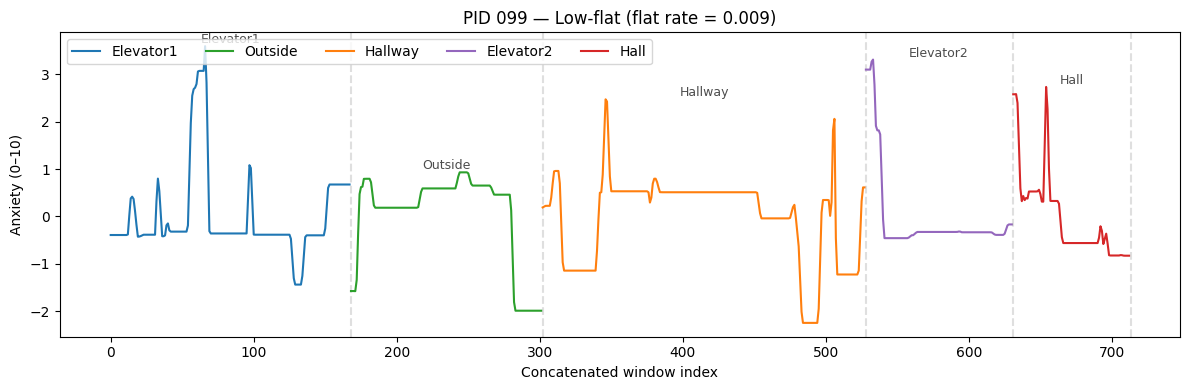

[INFO] Mid-flat: PID 023 — flat_rate=0.235


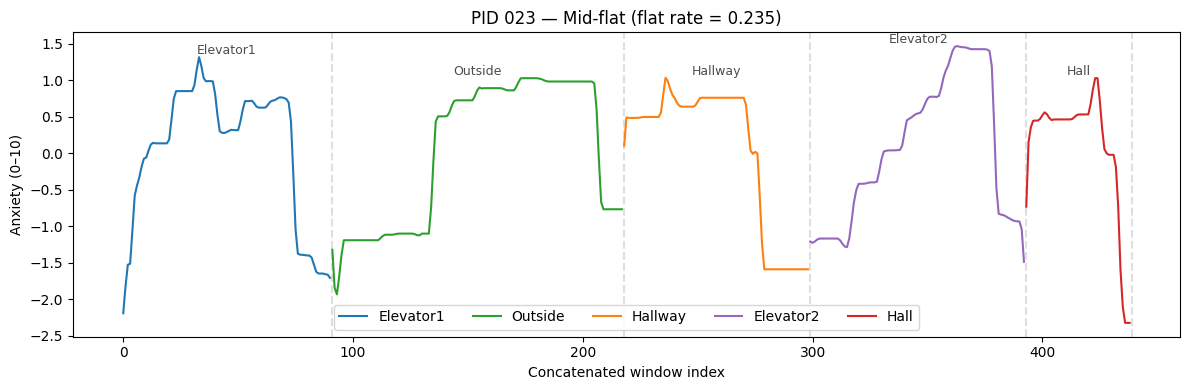

[INFO] High-flat: PID 059 — flat_rate=0.762


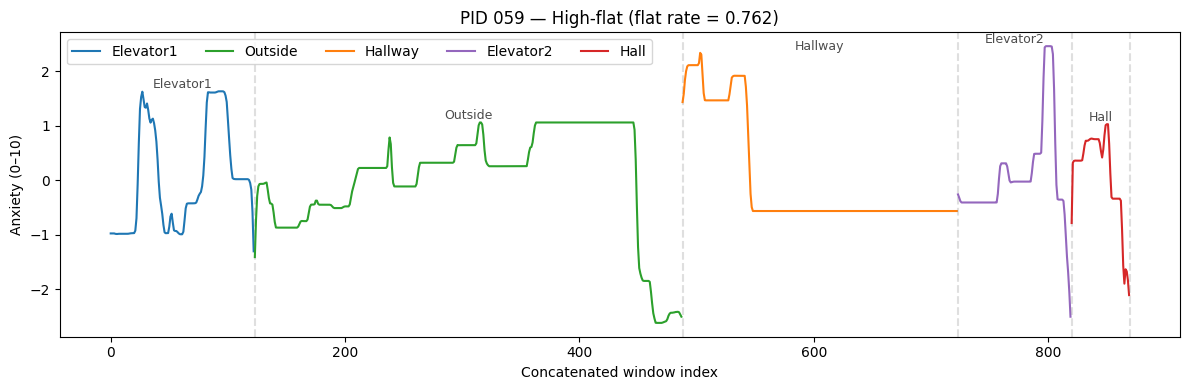

In [14]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot anxiety per participant (separate figure per PID), with scene segments
# colored and scene boundaries marked. PIDs are chosen by Hallway flat-rate
# (low / median / high).  Data layout assumed:
#   ./ml_processed/<Scene>/{X_array.npy, y_array.npy, pid_array.npy}
# X has shape [N, C, T] (if [N, T, C], it will be transposed automatically).
# ─────────────────────────────────────────────────────────────────────────────
import os
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Config
# =========================
BASE_DIR    = "./ml_processed"
SCENE_ORDER = ["Elevator1", "Outside", "Hallway", "Elevator2", "Hall"]
HALLWAY     = "Hallway"                 # flat-rate selection uses only Hallway
TAU_MODE       = ("quantile_pos", 0.15)  # 하위 15%를 flat로 간주
EPS            = 1e-6                    # 너무 작은 수 하한
ZERO_AS_INVALID = False                  # TV≈0 윈도우를 분모에서 제외할지 여부(False 권장)
PID_RELATIVE    = False                  # True면 PID별 상대 분위수 기준
STD_REDUCTION = "max"                  # {"mean","median","max"}
OUT_DIR     = "./fig_anxiety_by_pid"    # figures will be saved here
SAVE_DPI    = 150

# optional fixed scene colors (distinct)
SCENE_COLORS = {
    "Elevator1": "#1f77b4",
    "Outside"  : "#2ca02c",
    "Hallway"  : "#ff7f0e",
    "Elevator2": "#9467bd",
    "Hall"     : "#d62728",
}

# =========================
# IO helpers
# =========================
def load_scene_arrays(base_dir, scene):
    p = os.path.join(base_dir, scene)
    X = np.load(os.path.join(p, "X_array.npy"))       # [N, C, T] or [N, T, C]
    y = np.load(os.path.join(p, "y_array.npy")).squeeze()
    pid = np.load(os.path.join(p, "pid_array.npy"))
    if X.ndim != 3:
        raise ValueError(f"{scene}: X_array ndim must be 3, got {X.ndim}")
    # ensure [N, C, T]
    if X.shape[1] > X.shape[2]:  # likely [N, T, C]
        X = np.transpose(X, (0, 2, 1))
    return X, y, pid

# =========================
# Statistics
# =========================

# =========================
# 1) 변화량 기반 스칼라 (Total Variation)
# =========================
def window_activity_scalar(win_2d, reduction="mean", min_valid_ratio=0.5):
    """
    win_2d: [C, T]
    - 시간 1차차분의 절댓값 평균(=총변동의 평균)을 채널별로 구해 스칼라화.
    - 값이 작을수록 'flat'.
    - NaN 안전, 유효 샘플 적은 채널은 제외.
    """
    C, T = win_2d.shape
    if T < 2: 
        return None
    valid_mask = np.isfinite(win_2d)
    keep_ch = (valid_mask.sum(axis=1) / float(T)) >= min_valid_ratio
    if not np.any(keep_ch):
        return None

    X = win_2d[keep_ch]
    # 1차차분 (시간축)
    d = np.diff(X, axis=1)
    # 채널별 평균 절댓값 변화
    act_c = np.nanmean(np.abs(d), axis=1)

    if reduction == "mean":   s = np.nanmean(act_c)
    elif reduction == "median": s = np.nanmedian(act_c)
    elif reduction == "max":    s = np.nanmax(act_c)
    else: s = np.nanmean(act_c)
    return float(s)

# =========================
# 2) Hallway 분포 수집 (TV 기반)
# =========================
def hallway_activity_distribution(base_dir, scene=HALLWAY):
    X, _, _ = load_scene_arrays(base_dir, scene)
    vals = []
    for i in range(X.shape[0]):
        s = window_activity_scalar(X[i], reduction="mean")
        if s is not None and np.isfinite(s):
            vals.append(s)
    return np.asarray(vals, dtype=np.float32)

# =========================
# 3) 임계값 계산 (양수 표본 + EPS 하한)
# =========================
def choose_tau_activity(mode, dist_vals, eps=EPS):
    if dist_vals.size == 0:
        raise RuntimeError("No valid activity samples to set TAU.")
    if mode[0] == "quantile_pos":
        q = float(mode[1])
        pos = dist_vals[dist_vals > eps]
        if pos.size == 0:
            return float(eps)
        tau = float(np.quantile(pos, q))
        return max(tau, eps)
    elif mode[0] == "quantile":
        q = float(mode[1])
        tau = float(np.nanquantile(dist_vals, q))
        return max(tau, eps)
    else:  # ("abs", value)
        return max(float(mode[1]), eps)

# =========================
# 4) PID별 flat-rate (TV < TAU) 계산
# =========================
def hallway_flatrate_activity_per_pid(base_dir, tau_global, scene=HALLWAY,
                                      pid_relative=PID_RELATIVE, q=0.15,
                                      eps=EPS, zero_as_invalid=ZERO_AS_INVALID):
    X, _, pid = load_scene_arrays(base_dir, scene)
    pids = np.unique(pid)

    # 미리 윈도우별 activity 계산
    act_all = []
    for i in range(X.shape[0]):
        s = window_activity_scalar(X[i], reduction="mean")
        act_all.append(s)
    act_all = np.array(act_all, dtype=float)

    rates = {}
    for p in pids:
        idx = (pid == p)
        act_p = act_all[idx]
        valid = np.isfinite(act_p)
        if zero_as_invalid:
            valid &= (act_p > eps)  # 너무 작은 변화량(사실상 0)은 분모 제외
        act_p = act_p[valid]
        if act_p.size == 0:
            rates[p] = 0.0
            continue

        if pid_relative:
            tau_pid = max(np.quantile(act_p, q), eps)
            flat = (act_p < tau_pid).sum()
        else:
            flat = (act_p < tau_global).sum()
        rates[p] = flat / float(act_p.size)
    return rates

# =========================
# Plotting per participant
# =========================
def y_by_scene_for_pid(base_dir, pid_value, scene_order):
    """Return list of (scene, y_segment) for scenes where PID exists."""
    segments = []
    for sc in scene_order:
        y_path  = os.path.join(base_dir, sc, "y_array.npy")
        pid_path= os.path.join(base_dir, sc, "pid_array.npy")
        if not (os.path.exists(y_path) and os.path.exists(pid_path)):
            continue
        y   = np.load(y_path).squeeze()
        pid = np.load(pid_path)
        sel = (pid == pid_value)
        if sel.any():
            segments.append((sc, y[sel]))
    return segments

def plot_pid_trajectory(pid_value, segments, rate_value=None, flat_label=None,
                        out_dir=None, dpi=150):
    """
    segments: list of (scene, y_segment)
    rate_value: flat rate (float)
    flat_label: "Low-flat" / "Mid-flat" / "High-flat"
    Creates a separate figure for the participant with colored scene segments and boundaries.
    """
    if len(segments) == 0:
        return

    # --- main plotting ---
    x_start = 0
    plt.figure(figsize=(12, 4))
    for sc, yseg in segments:
        x_end = x_start + len(yseg)
        x = np.arange(x_start, x_end)
        color = SCENE_COLORS.get(sc, None)
        plt.plot(x, yseg, label=sc, color=color)
        plt.axvline(x_end, color="gray", linestyle="--", alpha=0.25)
        mid = x_start + len(yseg)//2
        plt.text(mid, np.nanmax(yseg) if np.isfinite(np.nanmax(yseg)) else 0,
                 sc, ha="center", va="bottom", fontsize=9, alpha=0.7)
        x_start = x_end

    # --- title ---
    title_str = f"PID {pid_value}"
    if flat_label is not None and rate_value is not None:
        title_str += f" — {flat_label} (flat rate = {rate_value:.3f})"
    plt.title(title_str)

    plt.xlabel("Concatenated window index")
    plt.ylabel("Anxiety (0–10)")
    handles, labels = plt.gca().get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    plt.legend(uniq.values(), uniq.keys(), ncol=min(5, len(uniq)))
    plt.tight_layout()

    if out_dir:
        os.makedirs(out_dir, exist_ok=True)
        fpath = os.path.join(out_dir, f"pid_{pid_value}_anxiety_by_scene.png")
        plt.savefig(fpath, dpi=dpi)
    plt.show()


# =========================
# Run
# =========================
# =========================
# 5) 실행부 (요약)
# =========================
dist_vals = hallway_activity_distribution(BASE_DIR, HALLWAY)
print(f"[DEBUG] Hallway TV: n={dist_vals.size}, "
      f"min={np.nanmin(dist_vals):.6f}, "
      f"q15_pos={(np.quantile(dist_vals[dist_vals>EPS],0.15) if (dist_vals>EPS).any() else float('nan')):.6f}, "
      f"median={np.nanmedian(dist_vals):.6f}, max={np.nanmax(dist_vals):.6f}")

TAU = choose_tau_activity(TAU_MODE, dist_vals, eps=EPS)
print(f"[INFO] TAU(TV, {TAU_MODE}) = {TAU:.6f}")

rate_dict = hallway_flatrate_activity_per_pid(BASE_DIR, TAU, HALLWAY,
                                              pid_relative=PID_RELATIVE,
                                              q=(TAU_MODE[1] if isinstance(TAU_MODE[1], (int,float)) else 0.15),
                                              eps=EPS, zero_as_invalid=ZERO_AS_INVALID)

nz = sum(np.array(list(rate_dict.values())) > 0)
print(f"[DEBUG] Non-zero flat-rate PIDs: {nz} / {len(rate_dict)}")

# 이후 Low/Mid/High 선정 및 개별 플롯(title에 rate 표시)은 기존 루프 그대로 사용
rates_sorted = sorted(rate_dict.items(), key=lambda kv: kv[1])  # asc
pid_low  = rates_sorted[0][0]
pid_mid  = rates_sorted[len(rates_sorted)//2][0]
pid_high = rates_sorted[-1][0]
for tag, pid_value in [("Low-flat", pid_low), ("Mid-flat", pid_mid), ("High-flat", pid_high)]:
    segs = y_by_scene_for_pid(BASE_DIR, pid_value, SCENE_ORDER)
    rate_val = rate_dict.get(pid_value, None)
    print(f"[INFO] {tag}: PID {pid_value} — flat_rate={rate_val:.3f}")
    plot_pid_trajectory(pid_value, segs,
                        rate_value=rate_val, flat_label=tag,
                        out_dir=OUT_DIR, dpi=SAVE_DPI)

[INFO] Found 108 PIDs: ['001', '002', '003', '004', '005', '006', '007', '008'] ...
[INFO] Global TAU (Hallway TV, ('quantile_pos', 0.15)) = 0.000373  | n=20054
[WARN] flat-rate fail PID 064: cannot unpack non-iterable float object
[SAVE] ./fig_anxiety_by_pid_fromPKL\pid_017_anxiety_by_scene_fromPKL.png


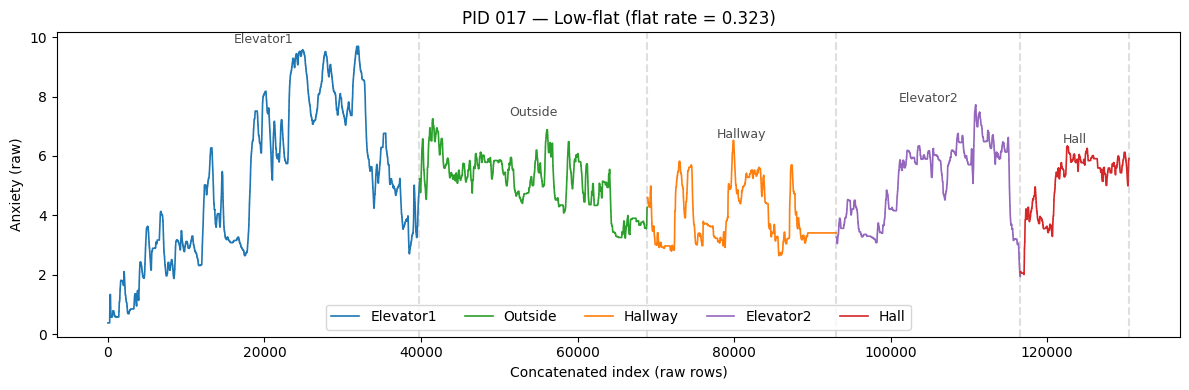

[SAVE] ./fig_anxiety_by_pid_fromPKL\pid_010_anxiety_by_scene_fromPKL.png


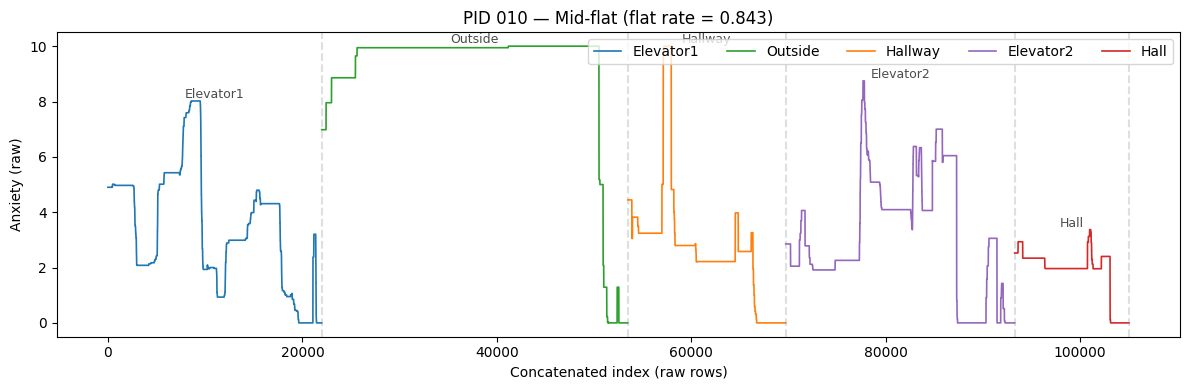

[SAVE] ./fig_anxiety_by_pid_fromPKL\pid_025_anxiety_by_scene_fromPKL.png


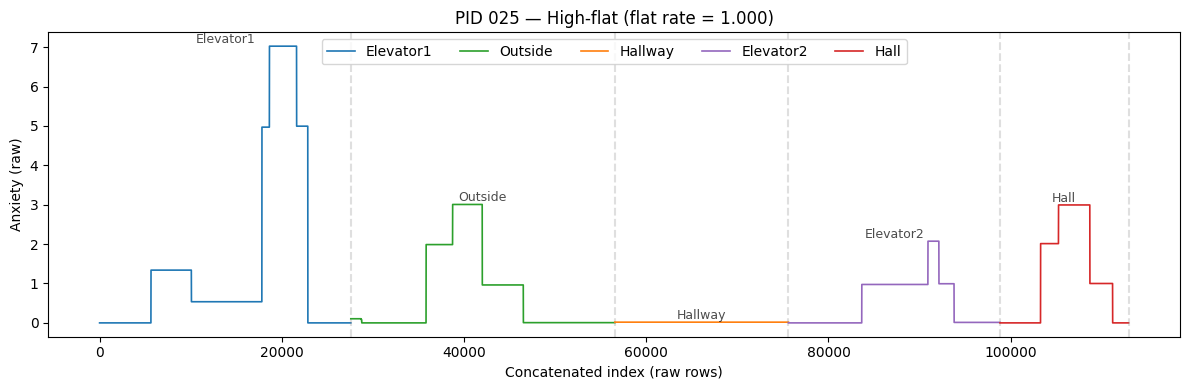

In [22]:
# -*- coding: utf-8 -*-
"""
Plot raw anxiety per participant using _Main.pkl (DataFrame) files.
- Directory: D:/Labroom/SDPhysiology/Data/processed_individual_anonymized
- File pattern: {PID}_Main.pkl   (e.g., 012_Main.pkl)
- Required columns in the DF: ['anxiety', 'scene']  (scene names e.g., "Elevator1","Outside","Hallway","Elevator2","Hall")
"""

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Config
# =========================
MAIN_DIR     = r"D:\Labroom\SDPhysiology\Data\processed_individual_anonymized"
SCENE_ORDER  = ["Elevator1", "Outside", "Hallway", "Elevator2", "Hall"]
OUT_DIR      = "./fig_anxiety_by_pid_fromPKL"
SAVE_DPI     = 150

# 시각화/전처리 옵션
DO_NORMALIZE         = False   # False면 raw 값 그대로, True면 아래 기준으로 정규화
NORM_MODE            = "z_per_pid"  # {"z_per_pid","zero_center_per_scene","zero_center_per_pid"}
INTERP_GAPS          = True    # anxiety가 NaN이면 선형 보간
CLIP_RANGE           = None    # 예: (0,10)로 클리핑하고 싶으면 (0,10)
SCENE_COLORS = {
    "Elevator1": "#1f77b4",
    "Outside"  : "#2ca02c",
    "Hallway"  : "#ff7f0e",
    "Elevator2": "#9467bd",
    "Hall"     : "#d62728",
}

# --- flat-rate 산출을 위한 설정(선택) ---
# 150샘플=5초@30Hz 가정. 실제 샘플링레이트와 윈도 크기를 상황에 맞게 조정.
WINDOW = 150
STRIDE = 150
EPS    = 1e-6
TAU_MODE = ("quantile_pos", 0.15)  # 양의 TV 분포 하위 15%를 flat로 간주

# =========================
# IO helpers
# =========================
def _pid_from_name(fname):
    m = re.match(r"(\d{3})_Main\.pkl$", fname)
    return m.group(1) if m else None

def list_available_pids(main_dir=MAIN_DIR):
    pids = []
    for fn in os.listdir(main_dir):
        p = _pid_from_name(fn)
        if p is not None:
            pids.append(p)
    return sorted(pids)

def load_main_df(pid, main_dir=MAIN_DIR):
    """Load {pid}_Main.pkl as DataFrame and return."""
    pid3 = f"{int(pid):03d}" if isinstance(pid, (int, np.integer)) else pid
    path = os.path.join(main_dir, f"{pid3}_Main.pkl")
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    df = pd.read_pickle(path)
    if "anxiety" not in df.columns:
        raise KeyError(f"'anxiety' column not found in {path}")
    if "scene" not in df.columns:
        # scene 정보가 다른 컬럼명이라면 여기서 매핑하세요.
        raise KeyError(f"'scene' column not found in {path}")
    # 숫자화
    df = df.copy()
    df["anxiety"] = pd.to_numeric(df["anxiety"], errors="coerce")
    return df

# =========================
# Normalization helpers (optional)
# =========================
def normalize_anxiety(df, mode="z_per_pid"):
    x = df["anxiety"].astype(float)
    if mode == "z_per_pid":
        mu, sd = x.mean(skipna=True), x.std(skipna=True)
        if sd and np.isfinite(sd) and sd > 0:
            df["anxiety"] = (x - mu) / sd
        else:
            df["anxiety"] = x - mu
    elif mode == "zero_center_per_scene":
        df["anxiety"] = df.groupby("scene")["anxiety"].transform(lambda s: s - s.mean(skipna=True))
    elif mode == "zero_center_per_pid":
        df["anxiety"] = x - x.mean(skipna=True)
    return df

# =========================
# Flatness (TV) on raw anxiety (Hallway only by default)
# =========================
def total_variation_1d(arr):
    """TV of 1D series (mean abs difference)."""
    if arr is None or len(arr) < 2:
        return np.nan
    d = np.diff(arr.astype(float))
    return float(np.nanmean(np.abs(d)))

def tv_over_windows(series, window=150, stride=150):
    vals = []
    n = len(series)
    if n < 2:
        return np.array([], dtype=float)
    for start in range(0, n - window + 1, stride):
        seg = series[start:start+window]
        if seg.isna().mean() >= 0.5:
            vals.append(np.nan)
        else:
            vals.append(total_variation_1d(seg.interpolate().to_numpy()))
    return np.array(vals, dtype=float)

def choose_tau_activity(mode, dist_vals, eps=EPS):
    dist_vals = dist_vals[np.isfinite(dist_vals)]
    if dist_vals.size == 0:
        return float(eps)
    if mode[0] == "quantile_pos":
        q = float(mode[1])
        pos = dist_vals[dist_vals > eps]
        if pos.size == 0:
            return float(eps)
        tau = float(np.quantile(pos, q))
        return max(tau, eps)
    elif mode[0] == "quantile":
        q = float(mode[1])
        return max(float(np.nanquantile(dist_vals, q)), eps)
    else:  # ("abs", value)
        return max(float(mode[1]), eps)

def hallway_flatrate_from_pkl(pid, main_dir=MAIN_DIR, tau=None):
    """Hallway 구간의 anxiety TV가 tau보다 작은 윈도 비율."""
    df = load_main_df(pid, main_dir)
    d = df[df["scene"] == "Hallway"].copy()
    if d.empty:
        return 0.0
    s = d["anxiety"]
    if INTERP_GAPS:
        s = s.astype(float).interpolate(limit_direction="both")
    tvs = tv_over_windows(s, window=WINDOW, stride=STRIDE)
    tvs = tvs[np.isfinite(tvs)]
    if tvs.size == 0:
        return 0.0
    if tau is None:
        tau = choose_tau_activity(TAU_MODE, tvs, eps=EPS)
    flat = (tvs < tau).sum()
    return flat / float(len(tvs) if len(tvs) > 0 else 1), tau

# =========================
# Build segments & plot
# =========================
def segments_by_scene_from_pkl(pid, scene_order=SCENE_ORDER, main_dir=MAIN_DIR):
    """Return list of (scene, y_segment_series) in the given order."""
    df = load_main_df(pid, main_dir)
    df = df.copy()

    # 선택: 정규화/보간/클리핑
    if DO_NORMALIZE:
        df = normalize_anxiety(df, mode=NORM_MODE)
    if INTERP_GAPS:
        df["anxiety"] = df["anxiety"].interpolate(limit_direction="both")
    if CLIP_RANGE is not None:
        lo, hi = CLIP_RANGE
        df["anxiety"] = df["anxiety"].clip(lower=lo, upper=hi)

    segs = []
    for sc in scene_order:
        seg = df.loc[df["scene"] == sc, "anxiety"]
        if len(seg) > 0:
            segs.append((sc, seg.reset_index(drop=True)))
    return segs

def plot_pid_trajectory_from_pkl(pid, scene_order=SCENE_ORDER, rate_value=None, flat_label=None,
                                 out_dir=OUT_DIR, dpi=SAVE_DPI):
    segs = segments_by_scene_from_pkl(pid, scene_order, MAIN_DIR)
    if not segs:
        print(f"[WARN] No scenes found for PID {pid}")
        return

    x_start = 0
    plt.figure(figsize=(12, 4))
    y_max_for_label = None

    for sc, yseg in segs:
        x_end = x_start + len(yseg)
        x = np.arange(x_start, x_end)
        color = SCENE_COLORS.get(sc, None)
        plt.plot(x, yseg.values, label=sc, color=color, linewidth=1.2)
        plt.axvline(x_end, color="gray", linestyle="--", alpha=0.25)
        if np.isfinite(yseg.values).any():
            yseg_max = np.nanmax(yseg.values)
            y_max_for_label = yseg_max if (y_max_for_label is None) else max(y_max_for_label, yseg_max)
        mid = x_start + len(yseg)//2
        plt.text(mid, (yseg.max() if np.isfinite(yseg.max()) else 0),
                 sc, ha="center", va="bottom", fontsize=9, alpha=0.7)
        x_start = x_end

    title = f"PID {pid}"
    if (flat_label is not None) and (rate_value is not None):
        title += f" — {flat_label} (flat rate = {rate_value:.3f})"
    plt.title(title)
    plt.xlabel("Concatenated index (raw rows)")
    plt.ylabel("Anxiety (raw)")
    handles, labels = plt.gca().get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    plt.legend(uniq.values(), uniq.keys(), ncol=min(5, len(uniq)))
    plt.tight_layout()

    if out_dir:
        os.makedirs(out_dir, exist_ok=True)
        fpath = os.path.join(out_dir, f"pid_{pid}_anxiety_by_scene_fromPKL.png")
        plt.savefig(fpath, dpi=dpi)
        print(f"[SAVE] {fpath}")
    plt.show()

# =========================
# Example run
# =========================
if __name__ == "__main__":
    # 1) 사용 가능한 PID 목록
    pids = list_available_pids(MAIN_DIR)
    print(f"[INFO] Found {len(pids)} PIDs:", pids[:8], ("..." if len(pids) > 8 else ""))

    # 2) Hallway TV 분포를 써서 전역 임계값(TAU) 결정
    tv_pool = []
    for pid in pids:
        try:
            df = load_main_df(pid, MAIN_DIR)
            s = df[df["scene"] == "Hallway"]["anxiety"].astype(float)
            if s.empty: 
                continue
            if INTERP_GAPS:
                s = s.interpolate(limit_direction="both")
            tvs = tv_over_windows(s, window=WINDOW, stride=STRIDE)
            tv_pool.append(tvs)
        except Exception as e:
            print(f"[WARN] skip PID {pid}: {e}")
    tv_pool = np.concatenate([x[np.isfinite(x)] for x in tv_pool if x is not None and len(x) > 0]) if len(tv_pool)>0 else np.array([],dtype=float)
    TAU = choose_tau_activity(TAU_MODE, tv_pool, eps=EPS) if tv_pool.size>0 else 1e-4
    print(f"[INFO] Global TAU (Hallway TV, {TAU_MODE}) = {TAU:.6f}  | n={tv_pool.size}")

    # 3) 각 PID flat-rate 계산 → Low/Mid/High 선택
    rates = []
    for pid in pids:
        try:
            r, _ = hallway_flatrate_from_pkl(pid, MAIN_DIR, tau=TAU)
            rates.append((pid, r))
        except Exception as e:
            print(f"[WARN] flat-rate fail PID {pid}: {e}")
    if not rates:
        raise SystemExit("No rates computed.")

    rates_sorted = sorted(rates, key=lambda kv: kv[1])  # asc
    pid_low  = rates_sorted[0][0]
    pid_mid  = rates_sorted[len(rates_sorted)//2][0]
    pid_high = rates_sorted[-1][0]

    # 4) 개별 플롯 (title에 flat-rate 표시)
    tag_map = {"Low-flat": pid_low, "Mid-flat": pid_mid, "High-flat": pid_high}
    rate_dict = dict(rates)
    for tag, pid in tag_map.items():
        plot_pid_trajectory_from_pkl(pid,
                                     scene_order=SCENE_ORDER,
                                     rate_value=rate_dict.get(pid, None),
                                     flat_label=tag,
                                     out_dir=OUT_DIR, dpi=SAVE_DPI)


In [23]:
N_PER_GROUP = 10   # 각 그룹별로 몇 명씩 볼지 (2~5 정도 추천)
rates_sorted = sorted(rate_dict.items(), key=lambda kv: kv[1])
num_pids = len(rates_sorted)

# 하위 n개 / 중간 n개 / 상위 n개 PID 뽑기
low_group  = [p for p, _ in rates_sorted[:N_PER_GROUP]]
mid_start  = num_pids//2 - N_PER_GROUP//2
mid_group  = [p for p, _ in rates_sorted[mid_start: mid_start+N_PER_GROUP]]
high_group = [p for p, _ in rates_sorted[-N_PER_GROUP:]]



[INFO] High-flat group (10 PIDs): ['067', '052', '027', '077', '055', '026', '012', '007', '104', '025']


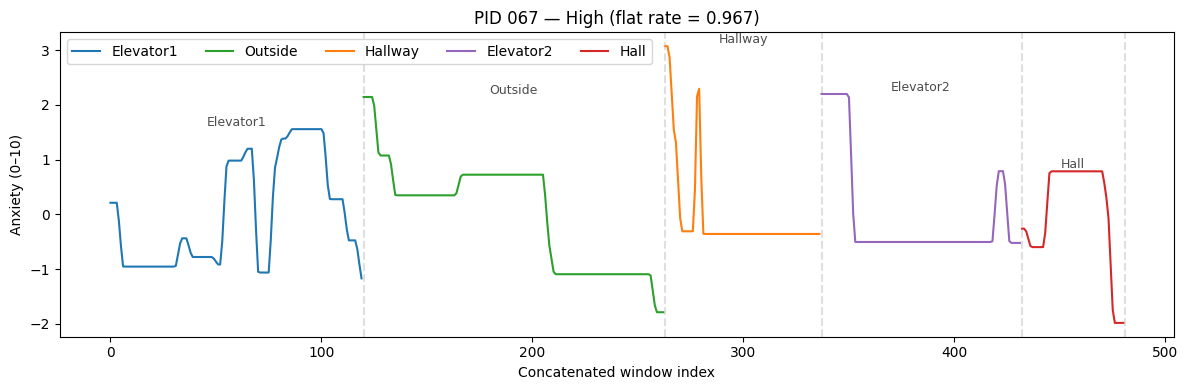

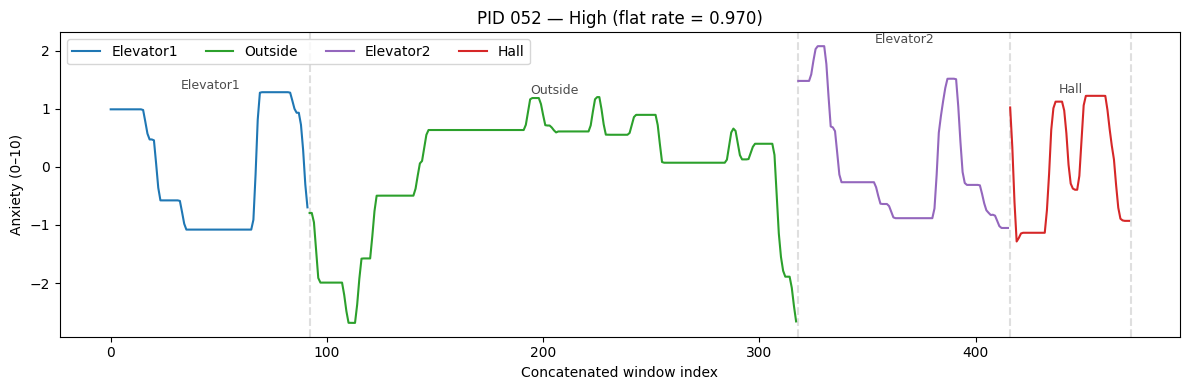

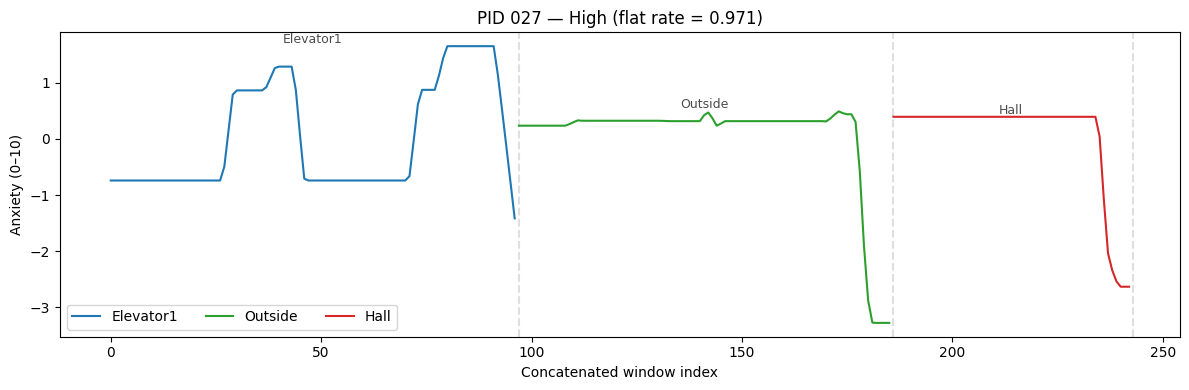

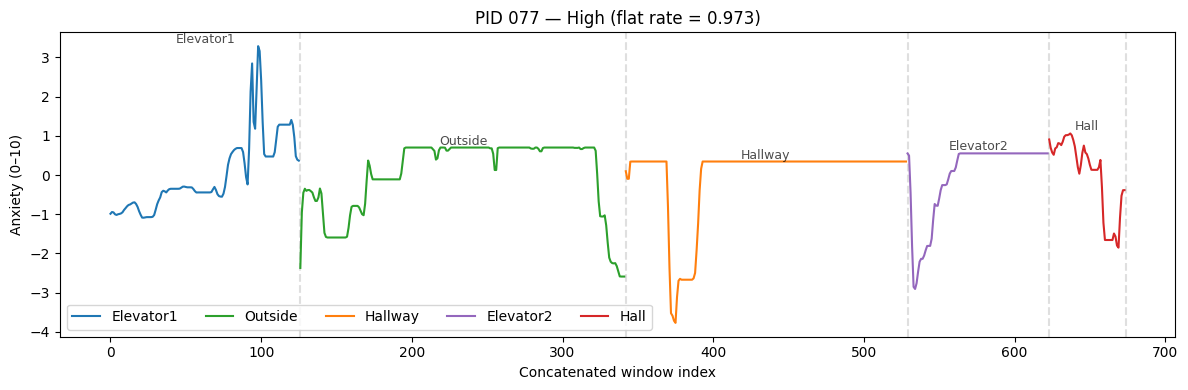

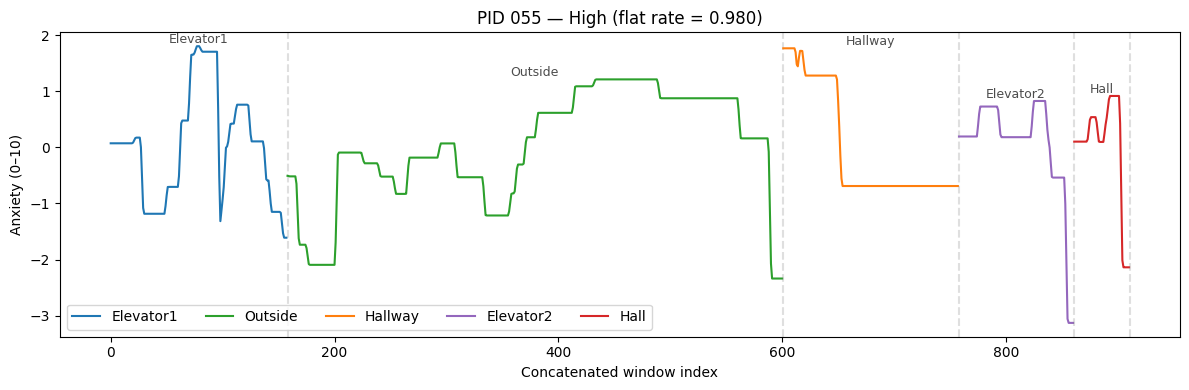

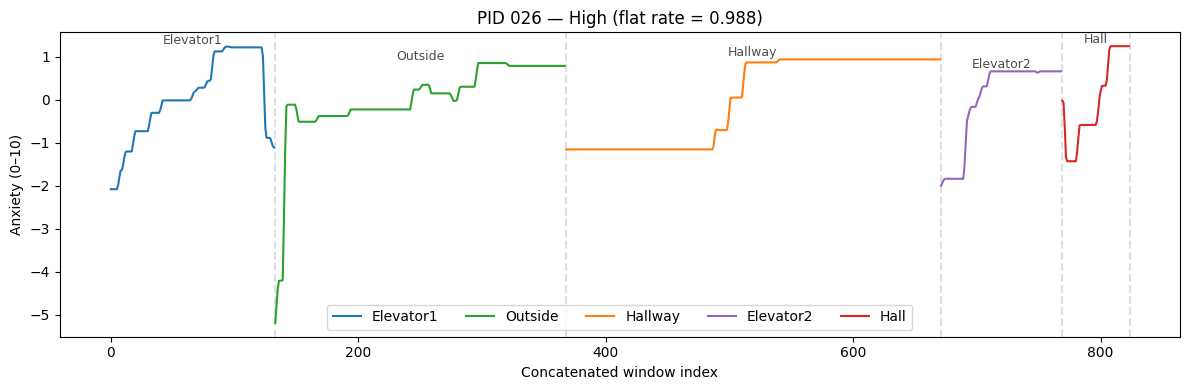

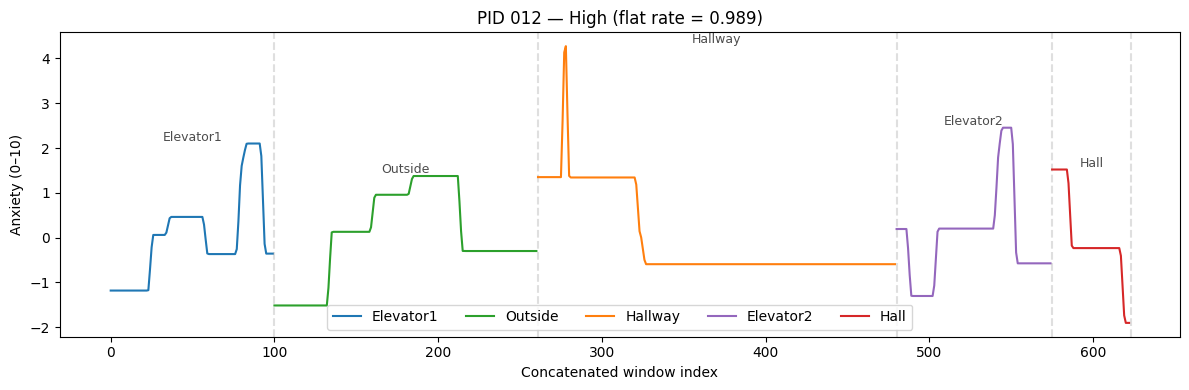

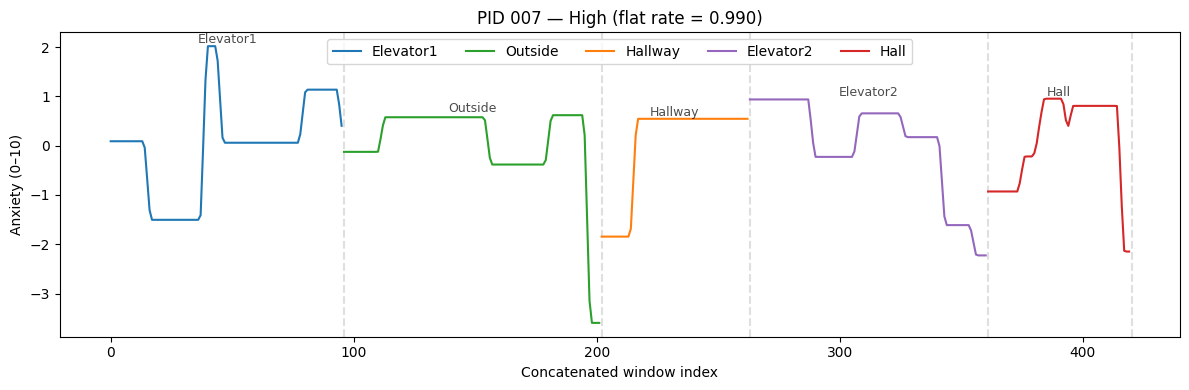

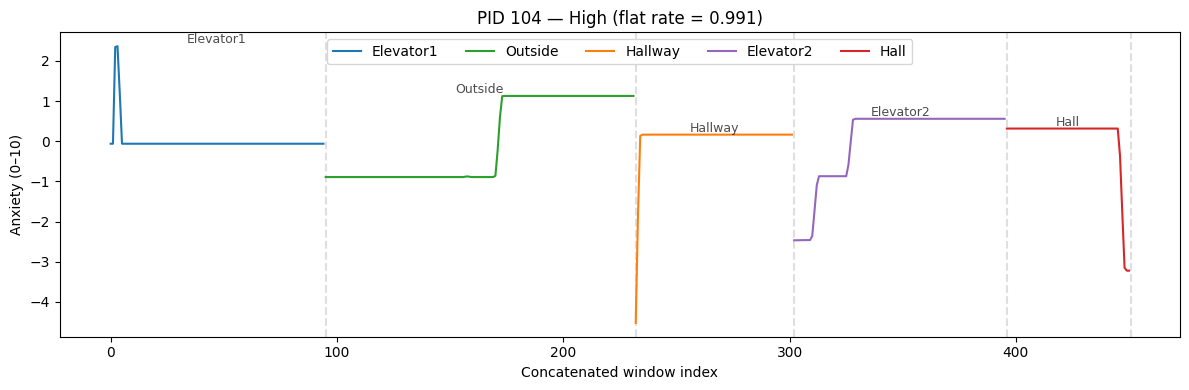

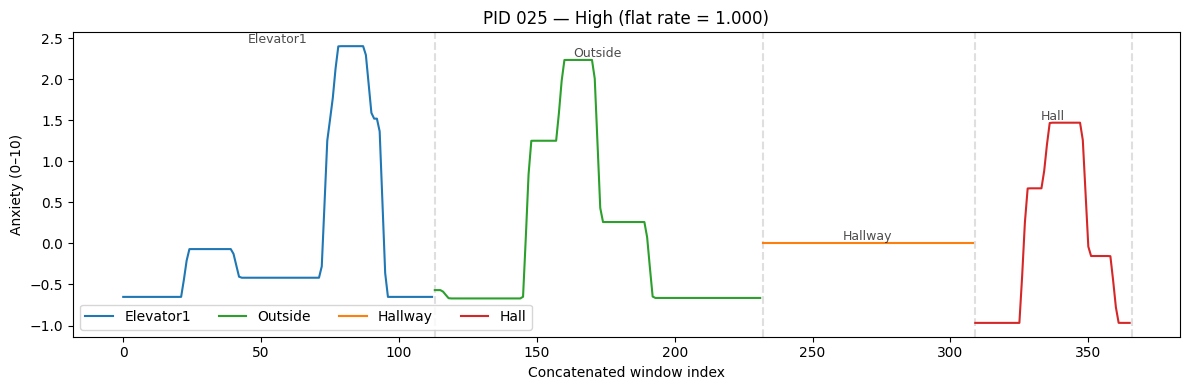

In [24]:
# ───────────────────────────────
# 여러 명씩 plot (개별 figure로 저장)
# ───────────────────────────────
def plot_pid_group(tag, pid_list):
    print(f"\n[INFO] {tag}-flat group ({len(pid_list)} PIDs): {pid_list}")
    for pid_value in pid_list:
        segs = y_by_scene_for_pid(BASE_DIR, pid_value, SCENE_ORDER)
        rate_val = rate_dict.get(pid_value, None)
        plot_pid_trajectory(pid_value, segs,
                            rate_value=rate_val,
                            flat_label=tag,
                            out_dir=OUT_DIR, dpi=SAVE_DPI)

# 그룹별로 실행
# plot_pid_group("Low",  low_group)
# plot_pid_group("Mid",  mid_group)
plot_pid_group("High", high_group)


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 0) 기본 설정
# -------------------------
BASE_DIR = r"D:/Labroom/SDphysiology/Data/processed_individual_anonymized"
SCENE_NAME = "Outside"

# 여기에서 보고 싶은 참가자 숫자 ID를 넣으세요 (문자열 3자리)
PARTICIPANTS = ["005", "006"]  # 예시: 1번, 2번 참가자

SIG_COLS = [
    "EDA_Tonic",
    "EDA_Phasic",
    "PPG_Rate",
    "RSP_Rate",
    "pupilL",
    "anxiety",   # y label
]

# 샘플링레이트(혹은 time 컬럼 없을 경우용 가정 값)
DEFAULT_FS = 120.0  # Hz


def get_time_axis(df_scene, fs=DEFAULT_FS):
    """
    time 혹은 time_sec 컬럼이 있으면 그걸 쓰고,
    없으면 샘플 인덱스를 이용해서 가상의 시간축 생성
    """
    for cand in ["time_sec", "Time", "time", "FrameTime"]:
        if cand in df_scene.columns:
            return df_scene[cand].to_numpy()
    # 아무 시간 컬럼이 없으면 샘플 인덱스를 이용한 가짜 시간축
    n = len(df_scene)
    return np.arange(n) / fs


for pid in PARTICIPANTS:
    fpath = os.path.join(BASE_DIR, f"{pid}_Main.pkl")
    if not os.path.exists(fpath):
        print(f"[WARN] 파일 없음: {fpath}")
        continue

    print(f"\n======================")
    print(f"Participant {pid} - {SCENE_NAME}")
    print(f"======================")

    # -------------------------
    # 1) 데이터 로드 & Outside 필터
    # -------------------------
    df = pd.read_pickle(fpath)

    if "scene" not in df.columns:
        raise ValueError(f"{fpath} 에 'scene' 컬럼이 없습니다.")

    df_scene = df[df["scene"] == SCENE_NAME].copy()
    if df_scene.empty:
        print(f"[WARN] {pid} 참가자에게 {SCENE_NAME} 씬 데이터가 없습니다.")
        continue

    # 시간축 결정
    t = get_time_axis(df_scene)

    # -------------------------
    # 2) 타임라인 플롯
    # -------------------------
    # 실제 존재하는 컬럼만 사용
    cols_present = [c for c in SIG_COLS if c in df_scene.columns]

    if not cols_present:
        print(f"[WARN] {pid} - 사용할 수 있는 신호 컬럼이 없습니다.")
        continue

    n_rows = len(cols_present)
    fig, axes = plt.subplots(
        n_rows, 1,
        figsize=(14, 2.2 * n_rows),
        sharex=True
    )

    # axes가 하나일 경우 처리
    if n_rows == 1:
        axes = [axes]

    for ax, col in zip(axes, cols_present):
        y = df_scene[col].to_numpy()
        ax.plot(t, y)
        ax.set_ylabel(col)
        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel("Time (s)")
    fig.suptitle(f"Participant {pid} - {SCENE_NAME} timeline", y=0.99)
    plt.tight_layout()
    plt.show()

    # -------------------------
    # 3) anxiety와의 상관 확인
    # -------------------------
    if "anxiety" not in cols_present:
        print(f"[WARN] {pid} - 'anxiety' 컬럼이 없어 상관계수 계산 불가.")
        continue

    df_corr = df_scene[cols_present].dropna()

    if df_corr.empty:
        print(f"[WARN] {pid} - 상관계수 계산에 사용할 유효한 샘플이 없습니다.")
        continue

    corr_mat = df_corr.corr(method="pearson")
    print("\n[전체 상관 행렬]")
    print(corr_mat.round(3))

    # 특히 anxiety와의 상관만 따로 보고 싶을 때
    print("\n[anxiety와의 상관계수 정렬]")
    print(corr_mat["anxiety"].sort_values(ascending=False).round(3))


In [9]:
import os
import numpy as np
import pandas as pd

BASE_DIR = r"D:/Labroom/SDphysiology/Data/processed_individual_anonymized"
SCENE_NAME = "Outside"

SIG_COLS = ["EDA_Tonic","EDA_Phasic","PPG_Rate","RSP_Rate","pupilL"]
TARGET = "anxiety"   # y label

summary_rows = []

for pid in sorted([f"{i:03d}" for i in range(1, 109)]):
    fpath = os.path.join(BASE_DIR, f"{pid}_Main.pkl")
    if not os.path.exists(fpath):
        print(f"[WARN] 파일 없음: {fpath}")
        continue

    try:
        df = pd.read_pickle(fpath)
    except Exception as e:
        print(f"[ERROR] 로딩 실패 {pid}: {e}")
        continue

    # Outside 씬 필터
    if "scene" not in df.columns:
        print(f"[WARN] scene 컬럼 없음: {pid}")
        continue

    df_scene = df[df["scene"] == SCENE_NAME].copy()
    if df_scene.empty:
        print(f"[WARN] {pid}: Outside 없음")
        continue

    # 사용 가능한 컬럼만 선택
    usable_cols = [c for c in SIG_COLS + [TARGET] if c in df_scene.columns]
    df_sub = df_scene[usable_cols].dropna()

    if df_sub.empty:
        print(f"[WARN] {pid}: Outside에 유효 샘플 0")
        continue

    row = {"PID": pid}
    row["n_samples"] = len(df_sub)
    
    # ====== (1) 신호별 variance ======
    for col in SIG_COLS:
        if col in df_sub.columns:
            row[f"var_{col}"] = float(np.var(df_sub[col].values))
        else:
            row[f"var_{col}"] = np.nan

    # ====== (2) anxiety와의 Pearson 상관 ======
    for col in SIG_COLS:
        colname = f"corr_{col}_anxiety"
        if col in df_sub.columns and TARGET in df_sub.columns:
            if df_sub[col].std() > 0 and df_sub[TARGET].std() > 0:
                row[colname] = df_sub[[col, TARGET]].corr().iloc[0,1]
            else:
                row[colname] = np.nan
        else:
            row[colname] = np.nan

    # ====== (3) NaN 비율 ======
    df_scene_no_target = df_scene.copy()
    for col in SIG_COLS:
        nan_ratio = df_scene_no_target[col].isna().mean() if col in df_scene_no_target.columns else np.nan
        row[f"nan_{col}"] = nan_ratio

    summary_rows.append(row)

# ------------------------------
# 최종 summary DataFrame
# ------------------------------
summary_df = pd.DataFrame(summary_rows)

print("\n========================== SUMMARY (TOP 10) ==========================")
print(summary_df.head(10))

out_path = os.path.join(BASE_DIR, "summary_outside_108.csv")
summary_df.to_csv(out_path, index=False, encoding="utf-8-sig")

print(f"\n[완료] summary 저장됨 → {out_path}")


[WARN] 064: Outside에 유효 샘플 0

========================== SUMMARY (TOP 10) ==========================
   PID  n_samples  var_EDA_Tonic  var_EDA_Phasic  var_PPG_Rate  var_RSP_Rate  \
0  001      45565   4.860313e-02    7.589372e-03    503.045936     76.636684   
1  002      34166   4.622321e+00    8.305516e-02    297.855516     10.870224   
2  003      30303   1.179606e-01    9.702897e-03     20.917922     11.056162   
3  004      25582   3.969494e-02    4.222684e-03     13.014695     16.309687   
4  005      25864   9.420485e-02    1.001389e-02     29.723540     30.687879   
5  006      35262   1.363364e+00    3.581355e-02     34.700615     43.117708   
6  007      25869   5.529587e-09    2.620126e-08    228.709628     31.290352   
7  008      67771   2.638574e-01    3.840915e-02     34.043660     13.394531   
8  009      61995   7.593466e-02    2.573000e-02    754.989682   2404.318005   
9  010      31483   2.694190e-02    4.565630e-04     64.866197     45.394443   

   var_pupilL  cor

In [10]:
# -------------------------------
# 2. Global Statistics Summary
# -------------------------------
stats = {}

# 2-1) 신호별 variance 평균/중앙값
for col in SIG_COLS:
    vcol = f"var_{col}"
    if vcol in summary_df:
        stats[f"{col}_var_mean"] = summary_df[vcol].mean()
        stats[f"{col}_var_median"] = summary_df[vcol].median()
        stats[f"{col}_var_std"] = summary_df[vcol].std()

# 2-2) anxiety 상관 평균/중앙값
for col in SIG_COLS:
    ccol = f"corr_{col}_anxiety"
    if ccol in summary_df:
        stats[f"{col}_corr_mean"] = summary_df[ccol].mean()
        stats[f"{col}_corr_median"] = summary_df[ccol].median()

# 2-3) NaN ratio 평균
for col in SIG_COLS:
    ncol = f"nan_{col}"
    if ncol in summary_df:
        stats[f"{col}_nan_mean"] = summary_df[ncol].mean()
        stats[f"{col}_nan_median"] = summary_df[ncol].median()

# 2-4) 품질 낮은 참가자 비율
# (variance < 1e-5 또는 상관이 NaN 또는 절대값 < 0.05)
LOW_VAR_THRESHOLD = 1e-5
LOW_CORR_THRESHOLD = 0.05

for col in SIG_COLS:
    vcol = f"var_{col}"
    ccol = f"corr_{col}_anxiety"

    if vcol in summary_df:
        stats[f"{col}_lowvar_ratio"] = (summary_df[vcol] < LOW_VAR_THRESHOLD).mean()

    if ccol in summary_df:
        stats[f"{col}_lowcorr_ratio"] = (summary_df[ccol].abs() < LOW_CORR_THRESHOLD).mean()

# -------------------------------
# 3. Statistics summary DataFrame
# -------------------------------
stats_df = pd.DataFrame(stats, index=["value"]).T

# -------------------------------
# Save
# -------------------------------
summary_path = os.path.join(BASE_DIR, "summary_outside_108.csv")
stats_path   = os.path.join(BASE_DIR, "summary_outside_108_statistics.csv")

summary_df.to_csv(summary_path, index=False, encoding="utf-8-sig")
stats_df.to_csv(stats_path, encoding="utf-8-sig")

print("\n================================================")
print(" Participant-level Summary (Top 5)")
print("================================================")
print(summary_df.head())

print("\n================================================")
print(" Global Statistics Summary")
print("================================================")
print(stats_df)
print(f"\n[완료] 두 파일 저장됨:\n→ {summary_path}\n→ {stats_path}")


 Participant-level Summary (Top 5)
   PID  n_samples  var_EDA_Tonic  var_EDA_Phasic  var_PPG_Rate  var_RSP_Rate  \
0  001      45565       0.048603        0.007589    503.045936     76.636684   
1  002      34166       4.622321        0.083055    297.855516     10.870224   
2  003      30303       0.117961        0.009703     20.917922     11.056162   
3  004      25582       0.039695        0.004223     13.014695     16.309687   
4  005      25864       0.094205        0.010014     29.723540     30.687879   

   var_pupilL  corr_EDA_Tonic_anxiety  corr_EDA_Phasic_anxiety  \
0    2.614598                0.175875                -0.022857   
1    2.182974                0.317837                -0.051092   
2    3.186945               -0.376358                 0.020921   
3    2.551075               -0.048264                 0.010344   
4    1.490750                0.601204                 0.008103   

   corr_PPG_Rate_anxiety  corr_RSP_Rate_anxiety  corr_pupilL_anxiety  \
0             

In [8]:
extract_raw_physio_windows(
    data_path="D:/Labroom/SDphysiology/Data/processed_individual_anonymized",
    output_path="./ml_processed_all",

    # 🔹 상태 단위: 20초 window + 5초 stride
    window_seconds=20,
    stride_seconds=5,

    # 🔹 120Hz → 30Hz 다운샘플링
    sampling_rate=30,

    scenes=["Elevator1","Outside","Hallway","Elevator2","Hall"],

    # 🔵 고주파 feature OFF (먼저 신호 존재 여부만 보고 싶으니까)
    enable_feature_expansion=False,
    fe_diff_orders=(),
    fe_ma_seconds=(),
    fe_std_seconds=(),
    fe_enable_slope=False,
    fe_enable_iqr=False,
    fe_enable_band_energy=False,

    # 🔵 타깃 smoothing (5초 EMA)
    enable_target_smoothing=True,
    target_smoothing_method="ema",
    target_smoothing_steps=150,   # 30Hz 기준 5초 (120Hz 기준으론 600 sample에 해당)
    smooth_before_zscore=True,

    # 🔵 저주파 bundle 유지
    fe_enable_lowfreq_bundle=True,
    fe_lowfreq_hop_seconds=2.0,
    fe_lowfreq_targets=("EDA_Tonic","RSP_Rate","PPG_Rate","pupilL"),
    fe_lowfreq_spec={
        "ema_taus": [6.0, 12.0, 18.0],   # 20초 window 안에서 안정적으로 잡히는 scale
        "slope_secs": [10.0, 20.0],      # 30초는 window보다 길어서 일단 제외
        "use_bandpower": False
    },

    # 🔵 signal baseline은 scene 단위 robust scaling
    baseline_mode_signals="scene_medmad",
    baseline_mode_target=None,
    baseline_first_seconds=10,
    mad_c=1.4826
)


Extracting Raw Signals: 100%|██████████| 108/108 [01:42<00:00,  1.05it/s]


✅ 저장 완료: ./ml_processed_all
📊 X shape: (21887, 11, 600) | y shape: (21887,) | #PIDs: 107
🧩 Channels: 11 | (예: ['EDA_Tonic' 'EDA_Phasic' 'SCR_Amplitude' 'SCR_RiseTime' 'PPG_Rate'
 'RSP_Rate' 'RSP_RVT' 'RSP_Amplitude' 'pupilL' 'pupilR'])
📝 saved: scene_array.npy, windex_array.npy, feature_tag_list.npy, meta.json


X shape (raw): (21887, 11, 600)
y_cont shape: (21887,)
pid shape: (21887,)
scene shape: (21887,)
num features (from tag list): 11
[INFO] Detected shape (N, C, T). Averaging over T (axis=2).
X_feat shape (for stats): (21887, 11)
len(feature_names) after align: 11

After scene filter:
  X_feat_s: (21887, 11)
  y_cont_s: (21887,)
  pid_s: (21887,)
  scene_s: (21887,)
  unique scenes: ['Elevator1' 'Elevator2' 'Hall' 'Hallway' 'Outside']

LABEL_MODE: scene
thresholds:
{'scene': {'Elevator1': (0.01037686038762331, 0.5399404168128967), 'Elevator2': (-0.5503968238830566, -0.02789801806211486), 'Hall': (-0.5123783707618713, -0.014508911781013082), 'Hallway': (-0.6920322299003601, -0.2349549204111101), 'Outside': (0.24386312365531937, 0.7615280389785767)}}

[Binary Label Summary]
  Total valid samples: 17510
y
0    0.5
1    0.5
Name: ratio, dtype: float64

[Scene-wise distribution]
scene      y
Elevator1  0    1768
           1    1768
Elevator2  0    1505
           1    1505
Hall       0     8

scene  n_samples  max_abs_r  max_abs_d
0  Elevator1       3536   0.062278   0.124762
1  Elevator2       3010   0.068477   0.137230
2       Hall       1724   0.041015   0.082051
3    Hallway       3688   0.046809   0.093695
4    Outside       5552   0.041646   0.083349


[df_stats head]


feature      r_pb       p_r    t_stat       p_t   cohen_d    n0    n1
0      EDA_Tonic  0.014470  0.055530  1.914832  0.055537  0.028941  8755  8755
1     EDA_Phasic -0.002917  0.699488 -0.386018  0.699492 -0.005834  8755  8755
2  SCR_Amplitude -0.004097  0.587720 -0.542152  0.587721 -0.008194  8755  8755
3   SCR_RiseTime -0.024844  0.001010 -3.288326  0.001010 -0.049701  8755  8755
4       PPG_Rate  0.002911  0.700101  0.385190  0.700106  0.005822  8755  8755

feature      r_pb       p_r    t_stat       p_t   cohen_d    n0    n1  \
8        pupilL  0.025048  0.000917  3.315346  0.000918  0.050109  8755  8755   
3  SCR_RiseTime -0.024844  0.001010 -3.288326  0.001010 -0.049701  8755  8755   
0     EDA_Tonic  0.014470  0.055530  1.914832  0.055537  0.028941  8755  8755   
6       RSP_RVT  0.011215  0.137800  1.484101  0.137818  0.022431  8755  8755   
9        pupilR  0.010688  0.157278  1.414348  0.157295  0.021377  8755  8755   

      abs_r  
8  0.025048  
3  0.024844  
0  0.014470  
6  0.011215  
9  0.010688

feature      r_pb       p_r    t_stat       p_t   cohen_d    n0    n1  \
8        pupilL  0.025048  0.000917  3.315346  0.000918  0.050109  8755  8755   
3  SCR_RiseTime -0.024844  0.001010 -3.288326  0.001010 -0.049701  8755  8755   
0     EDA_Tonic  0.014470  0.055530  1.914832  0.055537  0.028941  8755  8755   
6       RSP_RVT  0.011215  0.137800  1.484101  0.137818  0.022431  8755  8755   
9        pupilR  0.010688  0.157278  1.414348  0.157295  0.021377  8755  8755   

      abs_d  
8  0.050109  
3  0.049701  
0  0.028941  
6  0.022431  
9  0.021377


Top-5 features by |r_pb|: ['pupilL', 'SCR_RiseTime', 'EDA_Tonic', 'RSP_RVT', 'pupilR']
CV AUCs: [0.5, 0.5, 0.5, 0.5, 0.5]
mean AUC: 0.5 ± 0.0


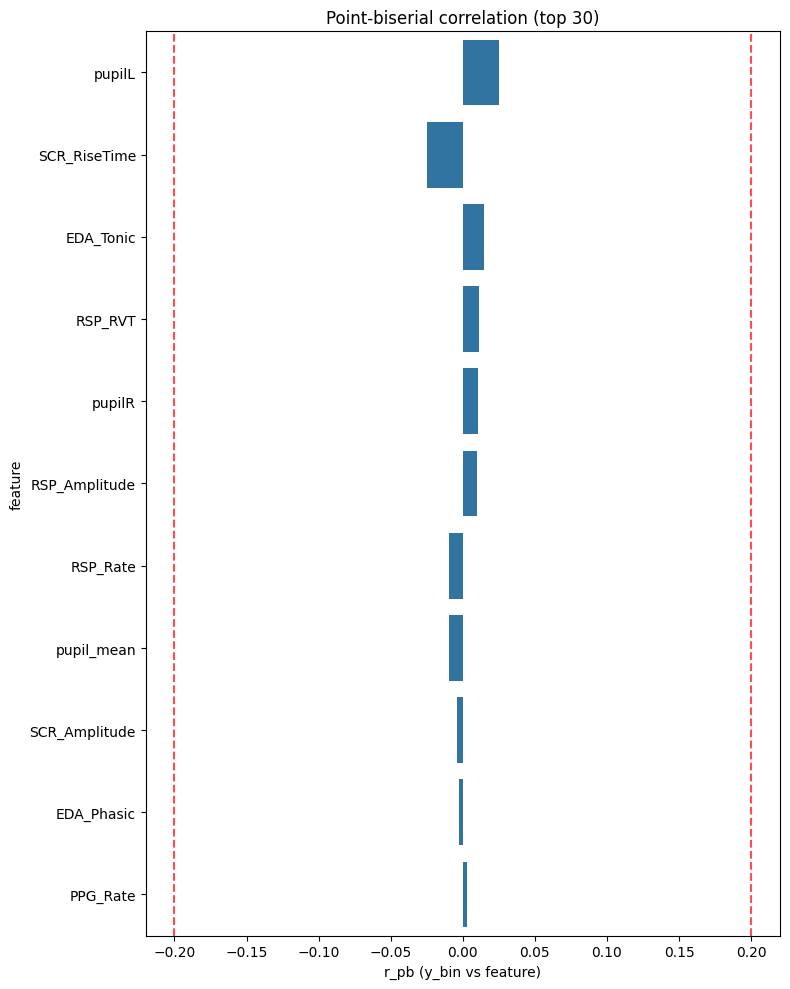

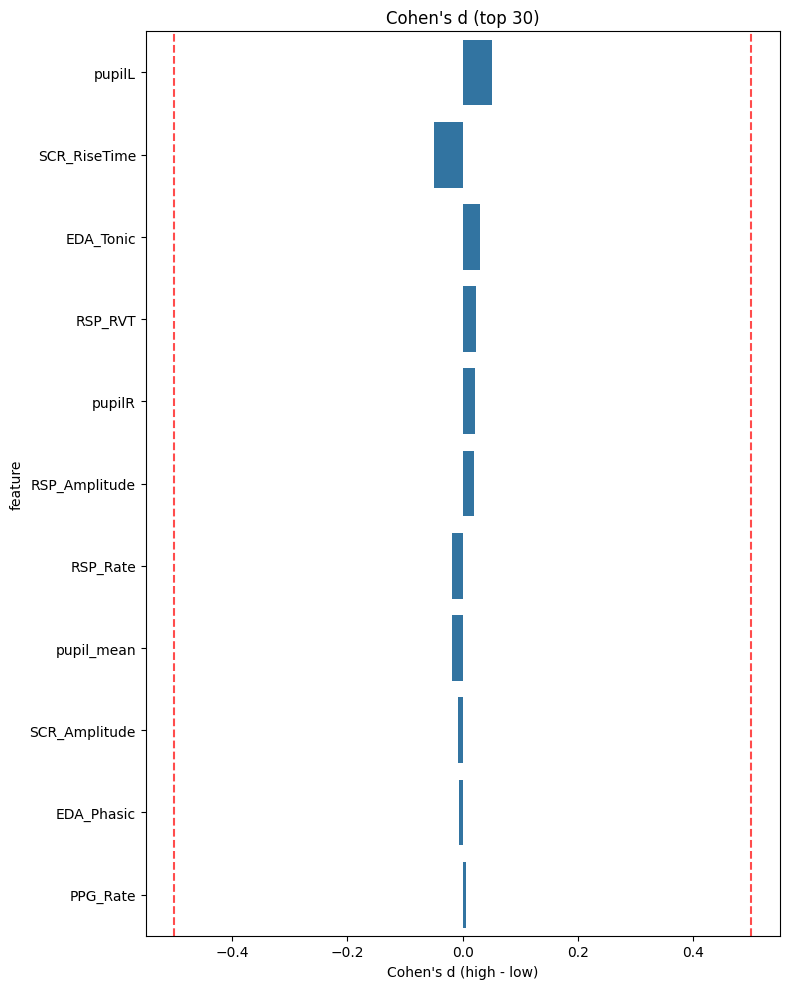

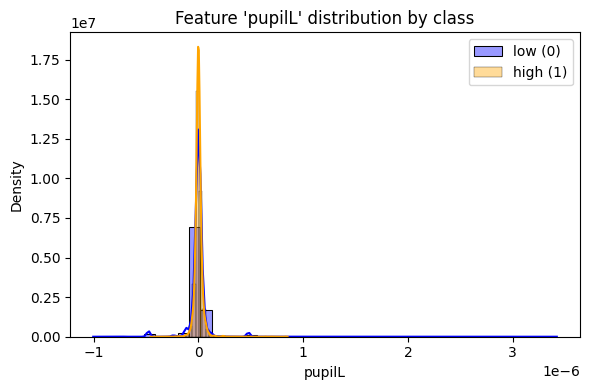

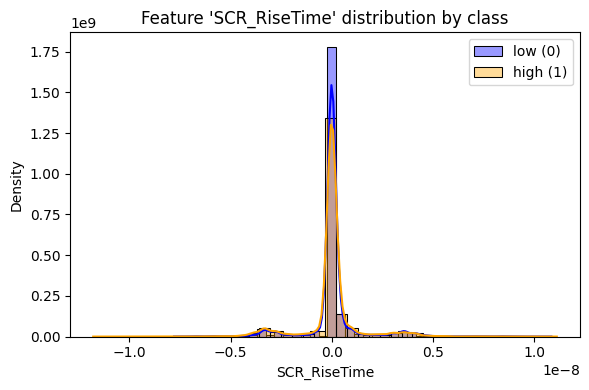

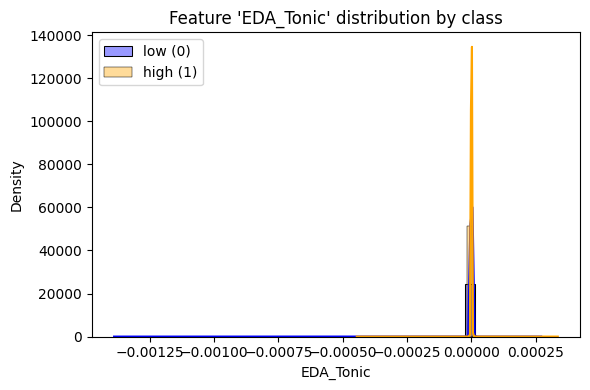

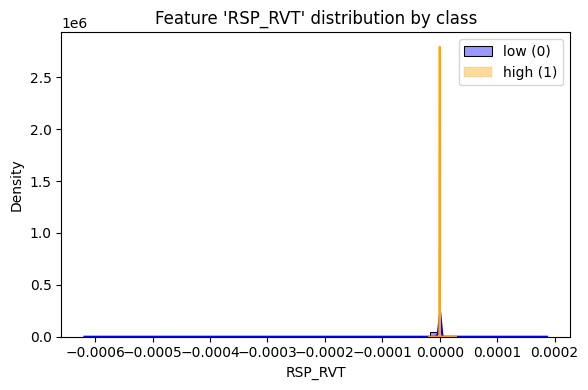

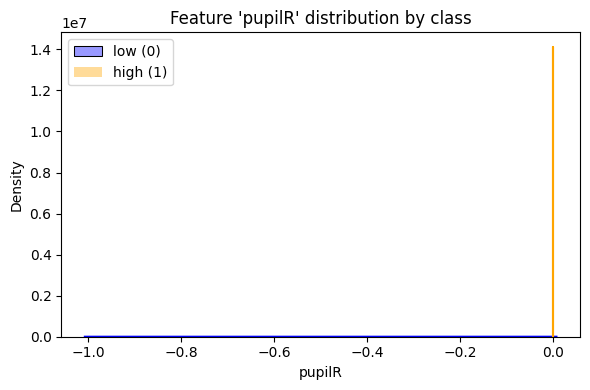

In [ ]:
import os
import numpy as np
import pandas as pd

from binary_utils import make_binary_labels, apply_binary_mask, summarize_binary_distribution
from binary_stats_utils import (
    compute_binary_feature_stats,
    plot_pointbiserial,
    plot_cohens_d,
    plot_feature_distributions,
)

# -------------------------------------------------
# 1) 경로 설정 (회귀용 npy가 있는 곳)
# -------------------------------------------------
DATA_DIR = "ml_processed_all"  # 필요시 수정

# -------------------------------------------------
# 2) 기본 데이터 로딩
#    - X_array: (N,T,C) 또는 (N,C,T)
#    - y_array: (N,) 연속 anxiety
#    - pid_array: (N,) 참가자 ID (anon)
#    - scene_array: (N,) scene 이름
#    - feature_tag_list: (C,) feature 이름
# -------------------------------------------------
X = np.load(os.path.join(DATA_DIR, "X_array.npy"))
y_cont = np.load(os.path.join(DATA_DIR, "y_array.npy")).astype(float)
pid = np.load(os.path.join(DATA_DIR, "pid_array.npy"))
scene = np.load(os.path.join(DATA_DIR, "scene_array.npy"))
feature_names = np.load(os.path.join(DATA_DIR, "feature_tag_list.npy"), allow_pickle=True)

# feature_names를 안전하게 list로 변환
if hasattr(feature_names, "tolist"):
    feature_names = feature_names.tolist()
if isinstance(feature_names, (list, tuple)) and len(feature_names) > 0 and isinstance(feature_names[0], (list, tuple, np.ndarray)):
    feature_names = list(np.ravel(feature_names))

print("X shape (raw):", X.shape)
print("y_cont shape:", y_cont.shape)
print("pid shape:", pid.shape)
print("scene shape:", scene.shape)
print("num features (from tag list):", len(feature_names))

# -------------------------------------------------
# 3) X를 (N, C) 형태로 변환 (time dimension 평균)
#    - feature 축을 feature_names 길이와 맞춰서 자동 판별
# -------------------------------------------------
X = np.asarray(X, dtype=float)

if X.ndim == 3:
    N, d1, d2 = X.shape
    C_tag = len(feature_names)

    # case 1: 마지막 축이 feature (N, T, C)
    if d2 == C_tag and d1 != C_tag:
        print("[INFO] Detected shape (N, T, C). Averaging over T (axis=1).")
        X_feat = X.mean(axis=1)     # (N, C)

    # case 2: 두 번째 축이 feature (N, C, T)
    elif d1 == C_tag and d2 != C_tag:
        print("[INFO] Detected shape (N, C, T). Averaging over T (axis=2).")
        X_feat = X.mean(axis=2)     # (N, C)

    # 애매하면 마지막 축을 feature로 가정
    else:
        print("[WARN] Cannot uniquely infer feature axis; assuming last axis is feature.")
        X_feat = X.mean(axis=1)     # (N, d2) → d2를 feature로 취급
        # feature_names 길이와 다르면 맞춰줌
        if X_feat.shape[1] != C_tag:
            print(f"[WARN] X_feat channels={X_feat.shape[1]}, feature_names={C_tag}.")
            if C_tag > X_feat.shape[1]:
                feature_names = feature_names[:X_feat.shape[1]]
            else:
                # 부족하면 placeholder 추가
                missing = X_feat.shape[1] - C_tag
                feature_names += [f"feat_{i}" for i in range(C_tag, C_tag + missing)]

elif X.ndim == 2:
    # 이미 (N, C)면 그대로 사용
    X_feat = X
    print("[INFO] X is already (N, C); no time averaging applied.")

else:
    raise ValueError(f"Unexpected X ndim={X.ndim}; expected 2 or 3.")

print("X_feat shape (for stats):", X_feat.shape)

# X_feat과 feature_names 길이 맞추기 (최종 정렬)
C_feat = X_feat.shape[1]
if C_feat != len(feature_names):
    print(f"[WARN] Final align: X_feat channels={C_feat}, feature_names={len(feature_names)}.")
    if len(feature_names) > C_feat:
        print("       → feature_names를 앞에서 C_feat개만 사용합니다.")
        feature_names = feature_names[:C_feat]
    else:
        print("       → feature_names가 부족해서 placeholder 이름을 추가합니다.")
        missing = C_feat - len(feature_names)
        feature_names += [f"feat_{i}" for i in range(len(feature_names), len(feature_names) + missing)]

print("len(feature_names) after align:", len(feature_names))

assert X_feat.shape[0] == y_cont.shape[0]
assert X_feat.shape[1] == len(feature_names)

# -------------------------------------------------
# 4) Scene 필터 (원하는 씬만 사용)
# -------------------------------------------------
target_scenes = ['Elevator1', 'Outside', 'Hallway', 'Elevator2', 'Hall']

mask_scene = np.isin(scene, target_scenes)

X_feat_s = X_feat[mask_scene]
y_cont_s = y_cont[mask_scene]
pid_s = pid[mask_scene]
scene_s = scene[mask_scene]

print("\nAfter scene filter:")
print("  X_feat_s:", X_feat_s.shape)
print("  y_cont_s:", y_cont_s.shape)
print("  pid_s:", pid_s.shape)
print("  scene_s:", scene_s.shape)
print("  unique scenes:", np.unique(scene_s))

# -------------------------------------------------
# 5) Binary label 생성 (global or scene-wise 선택)
# -------------------------------------------------
# mode = "global"  or  "scene"
LABEL_MODE = "scene"   # ← 여기만 "scene"으로 바꾸면 scene-wise quantile

y_bin_s, mask_bin, thresholds = make_binary_labels(
    y_cont=y_cont_s,
    scene=scene_s,
    mode=LABEL_MODE,
    low_q=0.4,
    high_q=0.6,
)

print("\nLABEL_MODE:", LABEL_MODE)
print("thresholds:")
print(thresholds)

# 분포 요약
summarize_binary_distribution(y_bin_s, scene_s)
import numpy as np
import pandas as pd

# -------------------------------------------------
# 6) 중간구간 제거 mask 적용 (X, y, pid, scene)
# -------------------------------------------------
X_b, y_b, pid_b, scene_b = apply_binary_mask(
    X_feat_s, y_bin_s, pid_s, scene_s, mask_bin
)

print("\nAfter binary mask:")
print("  X_b:", X_b.shape)
print("  y_b:", y_b.shape)
print("  pid_b:", pid_b.shape)
print("  scene_b:", scene_b.shape)
print("  class counts:", np.unique(y_b, return_counts=True))

# -------------------------------------------------
# 6-1) Scene별 effect size 요약
# -------------------------------------------------
scenes_unique = np.unique(scene_b)
rows = []

for sc in scenes_unique:
    m_sc = (scene_b == sc)
    n_sc = m_sc.sum()
    if n_sc < 50:
        # 샘플이 너무 적으면 스킵
        continue

    df_sc = compute_binary_feature_stats(
        X=X_b[m_sc],
        y_bin=y_b[m_sc],
        feature_names=feature_names,
        scene=None  # 한 scene만 남겼으니 scene 인자는 불필요
    )

    max_abs_r = np.abs(df_sc["r_pb"]).max()
    max_abs_d = np.abs(df_sc["cohen_d"]).max()

    rows.append({
        "scene": sc,
        "n_samples": int(n_sc),
        "max_abs_r": float(max_abs_r),
        "max_abs_d": float(max_abs_d),
    })

df_scene_effects = pd.DataFrame(rows)
print("\n[Scene-wise max effect size]")
display(df_scene_effects)



# -------------------------------------------------
# 7) Binary 가능성 통계: point-biserial / t-test / Cohen's d
# -------------------------------------------------
df_stats = compute_binary_feature_stats(
    X=X_b,
    y_bin=y_b,
    feature_names=feature_names,
    scene=scene_b
)

print("\n[df_stats head]")
display(df_stats.head())

# -------------------------------------------------
# 8) Point-biserial 상위 feature 시각화
# -------------------------------------------------
df_top_r = plot_pointbiserial(
    df_stats,
    top_k=30,
    figsize=(8, 10),
    r_pb_thresh=0.2   # “대략 의미 있다” 기준선
)
display(df_top_r.head())

# -------------------------------------------------
# 9) Cohen's d 상위 feature 시각화
# -------------------------------------------------
df_top_d = plot_cohens_d(
    df_stats,
    top_k=30,
    figsize=(8, 10),
    d_thresh=0.5      # medium effect size 기준
)
display(df_top_d.head())

# -------------------------------------------------
# 10) 상위 feature 분포 시각화 (예: r_pb 기준 상위 5개)
# -------------------------------------------------
top5_features_by_r = df_top_r["feature"].head(5).tolist()
print("\nTop-5 features by |r_pb|:", top5_features_by_r)

plot_feature_distributions(
    X=X_b,
    y_bin=y_b,
    feature_names=feature_names,
    top_features=top5_features_by_r,
    bins=40,
    kde=True,
    figsize=(6, 4)
)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

X_clf = X_b
y_clf = y_b

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
aucs = []

for tr_idx, te_idx in cv.split(X_clf, y_clf):
    X_tr, X_te = X_clf[tr_idx], X_clf[te_idx]
    y_tr, y_te = y_clf[tr_idx], y_clf[te_idx]

    clf = LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=1000
    )
    clf.fit(X_tr, y_tr)
    prob = clf.predict_proba(X_te)[:, 1]
    auc = roc_auc_score(y_te, prob)
    aucs.append(auc)

print("CV AUCs:", aucs)
print("mean AUC:", np.mean(aucs), "±", np.std(aucs))



In [12]:
from binary_utils import make_binary_labels, apply_binary_mask, summarize_binary_distribution

# y_cont, X, pid, scene 을 regression pipeline에서 받은 상태라고 가정

# 1) Label 생성
y_bin, mask, thresholds = make_binary_labels(
    y_cont=y_cont,
    scene=scene,
    mode="global"   # ← 여기서 "scene"으로도 쉽게 변경 가능
)

print(thresholds)
summarize_binary_distribution(y_bin, scene)

# 2) Mask 적용
X_b, y_b, pid_b, scene_b = apply_binary_mask(
    X, y_bin, pid, scene, mask
)


{'global': (-0.2632865309715272, 0.30324336290359505)}

[Binary Label Summary]
  Total valid samples: 17510
y
0    0.5
1    0.5
Name: ratio, dtype: float64

[Scene-wise distribution]
scene      y
Elevator1  0    1365
           1    2174
Elevator2  0    1947
           1    1023
Hall       0    1086
           1     575
Hallway    0    2682
           1     958
Outside    0    1675
           1    4025
dtype: int64


feature      r_pb       p_r    t_stat       p_t   cohen_d    n0  \
3   SCR_RiseTime -0.031519  0.000030 -4.172562  0.000030 -0.063065  8755   
0      EDA_Tonic  0.016192  0.032148  2.142733  0.032155  0.032386  8755   
8         pupilL  0.012236  0.105440  1.619119  0.105456  0.024472  8755   
9         pupilR  0.010688  0.157292  1.414298  0.157310  0.021376  8755   
7  RSP_Amplitude  0.009513  0.208110  1.258825  0.208127  0.019026  8755   

     n1     abs_r  
3  8755  0.031519  
0  8755  0.016192  
8  8755  0.012236  
9  8755  0.010688  
7  8755  0.009513

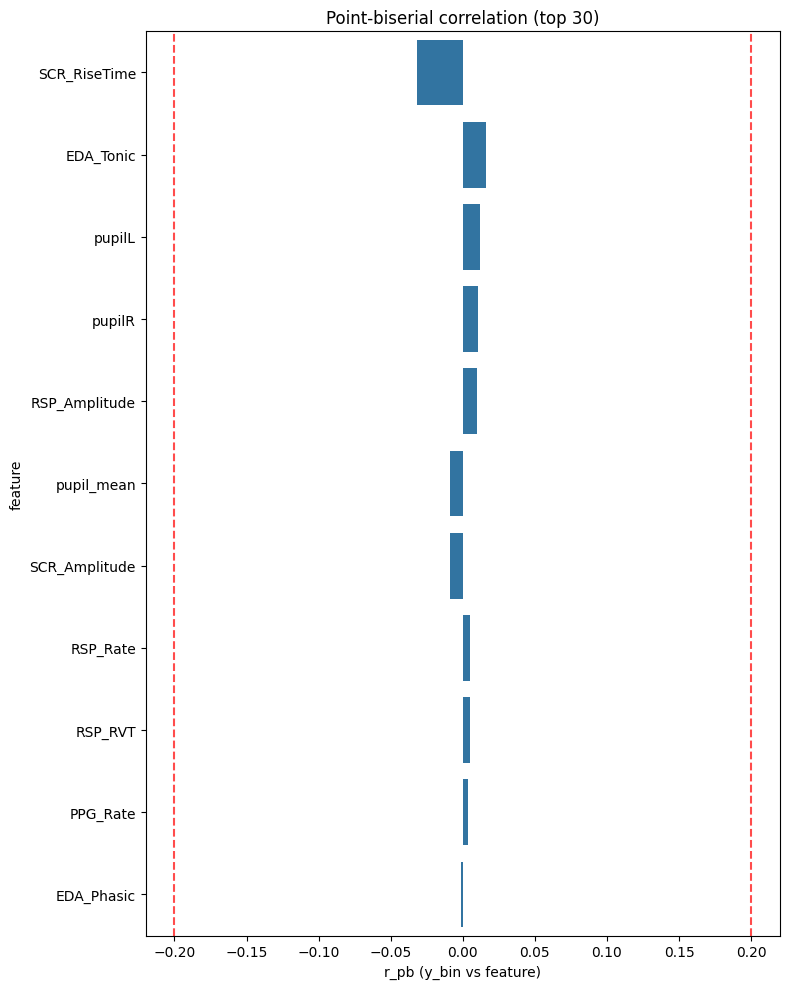

In [14]:
# Point-biserial 상위 30개
df_top_r = plot_pointbiserial(
    df_stats,
    top_k=30,
    figsize=(8, 10),
    r_pb_thresh=0.2
)
df_top_r.head()


In [ ]:
"""
Behavior–Anxiety 통계 점검 파이프라인 (108명 전체용, Behavior only)

1) per-frame behavior + anxiety dataset 생성
2) 전체 / Scene별 상관분석 (Pearson & Spearman)
3) Partial correlation (speed, scene 통제)
4) Linear Mixed Model (PID random intercept)
5) Mutual Information
6) Random Forest 기반 permutation importance
7) 결과를 하나의 summary CSV로 저장

※ 실행 전에 아래 CONFIG 부분만 환경에 맞게 수정해 주세요.
"""

import os
import math
import numpy as np
import pandas as pd

from scipy import stats
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM

# -------------------------
# 0) Behavior 모듈 import
# -------------------------
from behavior_features import (
    ColumnMapping,
    compute_agent_player_relations,
    PERSONAL_ZONES_DEFAULT,
)

# =========================
# CONFIG
# =========================
DATA_DIR = r"D:/LabRoom/SDPhysiology/Data/Processed/processed_individual_anonymized"

# Main.pkl 안 anxiety 라벨 칼럼 이름 (실제 이름으로 수정!)
LABEL_COL = "anxiety"   # 예: "anxiety_ema", "anxiety_z" 등

TARGET_SCENES = ["Elevator1", "Elevator2", "Hallway", "Hall", "Outside"]
FS_BEHAV = 120.0  # behavior / anxiety frame rate (Main 기준)

# 참가자 ID 리스트 (001~108)
PID_LIST = [f"{i:03d}" for i in range(1, 109)]

# LME, RF 등을 위한 최대 샘플 수 (너무 크면 random subsample)
MAX_N_FRAMES_FOR_LME = 200_000
MAX_N_FRAMES_FOR_RF  = 300_000

# 결과 저장 디렉토리
OUT_DIR = "./behavior_stats_results"
os.makedirs(OUT_DIR, exist_ok=True)
# df_all 캐시 경로 (per-frame behavior+anxiety 전체 데이터)
CACHE_PATH = os.path.join(OUT_DIR, "behavior_anxiety_perframe.pkl")



def get_behavior_dataset(pid_list=PID_LIST,
                         cache_path: str = CACHE_PATH,
                         force_rebuild: bool = False) -> pd.DataFrame:
    """
    per-frame behavior+anxiety 전체 데이터셋을 가져오는 헬퍼.

    - cache_path에 pkl이 있으면 그걸 로딩 (빠름)
    - 없거나 force_rebuild=True이면 build_behavior_dataset()로 새로 만들고 저장
    """
    if cache_path is not None and (not force_rebuild) and os.path.exists(cache_path):
        print(f"[CACHE] Loading df_all from cache: {cache_path}")
        df_all = pd.read_pickle(cache_path)
        print(f"[CACHE] Loaded df_all shape: {df_all.shape}")
    else:
        print("[CACHE] Building df_all from raw Main/Agent files...")
        df_all = build_behavior_dataset(pid_list)
        if cache_path is not None:
            df_all.to_pickle(cache_path)
            print(f"[CACHE] Saved df_all to: {cache_path}")
    return df_all

def run_nan_diagnostics(df_all: pd.DataFrame,
                        feature_cols: list,
                        out_dir: str = OUT_DIR):
    """
    NaN/Inf 비율을 요약해서 CSV로 저장.
    - nan_overall.csv
    - nan_by_scene.csv
    - nan_by_pid_scene.csv
    콘솔에는 간단한 상위 몇 개만 출력.
    """
    os.makedirs(out_dir, exist_ok=True)

    # 공통: Inf -> NaN 통일
    df = df_all.replace([np.inf, -np.inf], np.nan).copy()

    # 1) 전체 기준 NaN 비율
    n_total = len(df)
    nan_overall = (df[feature_cols].isna().sum() / n_total).reset_index()
    nan_overall.columns = ["feature", "nan_ratio"]
    nan_overall = nan_overall.sort_values("nan_ratio", ascending=False)
    nan_overall.to_csv(os.path.join(out_dir, "nan_overall.csv"), index=False)

    # 2) scene별 NaN 비율
    nan_by_scene = (
        df.groupby("scene")[feature_cols]
          .apply(lambda g: g.isna().sum() / len(g))
          .reset_index()
    )
    nan_by_scene.to_csv(os.path.join(out_dir, "nan_by_scene.csv"), index=False)

    # 3) PID × scene별 NaN 비율
    nan_by_pid_scene = (
        df.groupby(["PID", "scene"])[feature_cols]
          .apply(lambda g: g.isna().sum() / len(g))
          .reset_index()
    )
    nan_by_pid_scene.to_csv(os.path.join(out_dir, "nan_by_pid_scene.csv"), index=False)

    # 콘솔 출력은 상위 몇 개 요약만
    print("[NaN] Diagnostics done.")
    print("[NaN] Top 10 features by NaN ratio (overall):")
    print(nan_overall.head(10))

# =====================================================
# 1. 데이터 로딩 & per-frame behavior+anxiety 생성
# =====================================================

def load_behavior_frames_for_pid(
    pid_str: str,
    cols: ColumnMapping,
    label_col: str = LABEL_COL,
    target_scenes=None,
):
    """
    특정 참가자에 대해:
    - Main, Agent를 읽고
    - compute_agent_player_relations()로 per-frame behavior TS 생성
    - Main의 anxiety 라벨을 merge하여
      [PID, scene, Frame, anxiety, behavior features...] DataFrame 반환
    """
    if target_scenes is None:
        target_scenes = TARGET_SCENES

    main_path = os.path.join(DATA_DIR, f"{pid_str}_Main.pkl")
    agent_path = os.path.join(DATA_DIR, f"{pid_str}_Agent.pkl")

    if not (os.path.exists(main_path) and os.path.exists(agent_path)):
        print(f"[WARN] PID={pid_str}: Main or Agent file not found, skip.")
        return None

    try:
        main_df = pd.read_pickle(main_path)
        agent_df = pd.read_pickle(agent_path)
    except Exception as e:
        print(f"[ERROR] PID={pid_str}: failed to read pkl:", e)
        return None

    # Scene 필터링
    main_df = main_df[main_df[cols.scene].isin(target_scenes)].copy()
    agent_df = agent_df[agent_df[cols.scene].isin(target_scenes)].copy()

    if main_df.empty:
        print(f"[WARN] PID={pid_str}: main_df empty after scene filter, skip.")
        return None

    # anxiety 라벨 존재 확인
    if label_col not in main_df.columns:
        raise KeyError(
            f"[ERROR] LABEL_COL='{label_col}' not found in {pid_str}_Main.pkl. "
            "실제 라벨 칼럼 이름으로 LABEL_COL을 수정해 주세요."
        )

    # behavior TS 계산
    df_ts = compute_agent_player_relations(
        main_df,
        agent_df,
        cols=cols,
        zones=PERSONAL_ZONES_DEFAULT,
        fov_deg=110.0,
        dt=1.0 / FS_BEHAV,
    )

    # anxiety 라벨만 따로 추출 (scene, Frame 기준)
    lab = main_df[[cols.scene, cols.frame, label_col]].copy()
    lab = lab.rename(columns={label_col: "anxiety"})

    # behavior TS와 anxiety merge
    merged = pd.merge(
        df_ts,
        lab,
        on=[cols.scene, cols.frame],
        how="inner",
    )

    # PID 추가
    merged["PID"] = pid_str

    # 컬럼 순서 정리 (PID, scene, Frame, anxiety, behavior...)
    meta_cols = ["PID", cols.scene, cols.frame, "anxiety"]
    other_cols = [c for c in merged.columns if c not in meta_cols]
    merged = merged[meta_cols + other_cols]

    return merged


def build_behavior_dataset(pid_list=PID_LIST):
    """
    전 참가자(기본: 001~108)에 대해 per-frame behavior+anxiety를
    하나의 큰 DataFrame으로 병합
    """
    cols = ColumnMapping()
    all_list = []

    for pid in pid_list:
        print(f"[INFO] Loading behavior frames for PID={pid}")
        df_pid = load_behavior_frames_for_pid(pid, cols=cols)
        if df_pid is None or df_pid.empty:
            continue
        all_list.append(df_pid)

    if not all_list:
        raise RuntimeError("No participant data loaded. Check paths & LABEL_COL.")

    df_all = pd.concat(all_list, axis=0, ignore_index=True)

    # 기본적인 NaN 정리 (anxiety NaN 제거)
    df_all = df_all.dropna(subset=["anxiety"])

    print(f"[INFO] Combined behavior+anxiety shape: {df_all.shape}")
    return df_all

# =====================================================
# 2. 상관 분석 (Pearson / Spearman)
# =====================================================

def compute_correlations(df_all: pd.DataFrame, feature_cols: list,
                         label_col: str = "anxiety",
                         by_scene: bool = False):
    """
    전체 / scene별로 각 feature와 anxiety 사이의
    Pearson, Spearman 상관 계수 및 p-value 계산
    """
    results = []

    if by_scene:
        scene_groups = df_all.groupby("scene")
    else:
        scene_groups = [("ALL", df_all)]

    for scene_name, g in scene_groups:
        y = g[label_col].astype(float).to_numpy()
        for feat in feature_cols:
            x = g[feat].astype(float).to_numpy()

            if len(x) < 10:
                continue

            # NaN 제거
            mask = np.isfinite(x) & np.isfinite(y)
            if mask.sum() < 10:
                continue
            x_ = x[mask]
            y_ = y[mask]

            # Pearson
            r_p, p_p = stats.pearsonr(x_, y_)
            # Spearman
            r_s, p_s = stats.spearmanr(x_, y_)

            results.append({
                "scene": scene_name,
                "feature": feat,
                "pearson_r": r_p,
                "pearson_p": p_p,
                "spearman_r": r_s,
                "spearman_p": p_s,
                "n": mask.sum(),
            })

    corr_df = pd.DataFrame(results)
    return corr_df


# =====================================================
# 3. Partial Correlation (speed, scene 통제)
# =====================================================
def _residualize(y: np.ndarray, X: np.ndarray):
    """
    y ~ X 선형회귀 후 residual 반환 (partial correlation용)
    - NaN/Inf 자동 제거
    - SVD 실패 시 단순 y-평균으로 fallback
    """
    y = np.asarray(y, dtype=float)
    X = np.asarray(X, dtype=float)

    # NaN/Inf 제거용 마스크
    mask = np.isfinite(y) & np.isfinite(X).all(axis=1)
    if mask.sum() < X.shape[1] + 2:
        # 유효 표본이 너무 적으면 그냥 중앙값 기준으로 센터링만
        y_centered = y - np.nanmean(y[mask]) if mask.any() else y
        return y_centered

    y_clean = y[mask]
    X_clean = X[mask]

    # 인터셉트 추가
    X1 = np.column_stack([np.ones(len(X_clean)), X_clean])

    try:
        beta, *_ = np.linalg.lstsq(X1, y_clean, rcond=None)
        y_hat = X1 @ beta
        resid_clean = y_clean - y_hat
    except np.linalg.LinAlgError:
        # SVD 실패 시: y_clean의 평균만 제거한 residual 사용
        print("[WARN] lstsq failed in _residualize; using mean-centered fallback.")
        resid_clean = y_clean - np.mean(y_clean)

    # 원래 길이로 복원 (마스크 밖은 NaN)
    resid = np.full_like(y, np.nan, dtype=float)
    resid[mask] = resid_clean
    return resid


def compute_partial_correlations(df_all: pd.DataFrame,
                                 feature_cols: list,
                                 label_col: str = "anxiety",
                                 control_cols: list = None):
    """
    control_cols (예: ["speed", "scene_dummy_*"])를 통제한 상태에서
    feature ↔ anxiety partial correlation 계산
    """
    if control_cols is None or len(control_cols) == 0:
        raise ValueError("control_cols must be non-empty for partial correlation.")

    # control matrix
    Xc_raw = df_all[control_cols].astype(float).to_numpy()
    y_raw = df_all[label_col].astype(float).to_numpy()

    # --- 공통 클린: control 또는 y에 NaN/Inf 있으면 제거 ---
    global_mask = np.isfinite(y_raw) & np.isfinite(Xc_raw).all(axis=1)
    if global_mask.sum() < len(control_cols) + 5:
        raise RuntimeError(
            f"[partial_corr] Too few valid samples after cleaning: {global_mask.sum()}"
        )

    Xc = Xc_raw[global_mask]
    y = y_raw[global_mask]

    # 라벨 residual
    y_resid = _residualize(y, Xc)

    results = []
    for feat in feature_cols:
        x_raw = df_all[feat].astype(float).to_numpy()
        x = x_raw[global_mask]

        x_resid = _residualize(x, Xc)

        # residual들 간 Pearson
        mask = np.isfinite(x_resid) & np.isfinite(y_resid)
        if mask.sum() < 10:
            continue

        r, p = stats.pearsonr(x_resid[mask], y_resid[mask])
        results.append({
            "feature": feat,
            "partial_r": r,
            "partial_p": p,
            "n": mask.sum(),
        })

    pcorr_df = pd.DataFrame(results)
    return pcorr_df



# =====================================================
# 4. Linear Mixed Model (PID random intercept)
# =====================================================
def run_mixedlm_univariate(df_all: pd.DataFrame,
                           feature_cols: list,
                           label_col: str = "anxiety",
                           group_col: str = "PID",
                           controls: list = None,
                           max_n: int = MAX_N_FRAMES_FOR_LME):
    """
    각 feature에 대해:

        anxiety ~ feature + controls + (1 | PID)

    형태의 mixed linear model을 피팅하고,
    feature coefficient, p-value 등을 반환.

    - 데이터가 너무 크면 random subsample 사용
    - 각 feature마다 사용 컬럼만 골라서 NaN/Inf row를 제거한 뒤 MixedLM에 넣는다.
    """
    df = df_all.copy()

    # 0) 전체에서 Inf -> NaN으로 통일 (진단용)
    df = df.replace([np.inf, -np.inf], np.nan)

    # 1) subsample (optional)
    if len(df) > max_n:
        df = df.sample(n=max_n, random_state=42).reset_index(drop=True)
        print(f"[LME] Using subsample: {len(df)} rows (max_n={max_n})")

    results = []

    for feat in feature_cols:
        cols_X = [feat]
        if controls:
            cols_X += controls

        # --- 2) 이 feature에 실제로 필요한 컬럼만 모으기 ---
        cols_needed = [group_col, label_col] + cols_X
        df_feat = df[cols_needed].copy()

        # --- 3) NaN/Inf 제거 ---
        # 숫자 컬럼들만 2D 배열로 만들고, row 단위로 finite 여부 체크
        num_cols = cols_X + [label_col]
        vals = df_feat[num_cols].astype(float).to_numpy()       # shape: (N, k)
        mask = np.isfinite(vals).all(axis=1)                    # shape: (N,)
        # group_col은 category라서 NaN 여부만 확인
        mask &= df_feat[group_col].notna().to_numpy()

        df_clean = df_feat[mask].copy()

        # 유효 샘플 너무 적으면 스킵
        if len(df_clean) < 30:
            print(f"[LME] Feature={feat}: too few valid samples after NaN/Inf removal (n={len(df_clean)})")
            results.append({
                "feature": feat,
                "coef": np.nan,
                "pvalue": np.nan,
                "n_used": len(df_clean),
                "converged": False,
            })
            continue

        # --- 4) MixedLM에 넣기 ---
        try:
            X = df_clean[cols_X].astype(float)
            X = sm.add_constant(X)  # intercept

            y = df_clean[label_col].astype(float)
            groups = df_clean[group_col].astype("category")

            model = MixedLM(endog=y, exog=X, groups=groups)
            fit = model.fit(reml=False, method="lbfgs", maxiter=200, disp=False)

            coef = fit.params.get(feat, np.nan)
            pval = fit.pvalues.get(feat, np.nan)

            results.append({
                "feature": feat,
                "coef": coef,
                "pvalue": pval,
                "n_used": len(df_clean),
                "converged": fit.mle_retvals.get("converged", True),
            })

        except Exception as e:
            print(f"[LME] Feature={feat} failed after cleaning:", e)
            results.append({
                "feature": feat,
                "coef": np.nan,
                "pvalue": np.nan,
                "n_used": len(df_clean),
                "converged": False,
            })

    lme_df = pd.DataFrame(results)
    return lme_df




# =====================================================
# 5. Mutual Information
# =====================================================

def compute_mutual_information(df_all: pd.DataFrame,
                               feature_cols: list,
                               label_col: str = "anxiety"):
    """
    mutual_info_regression으로 feature ↔ anxiety MI 계산
    """
    X = df_all[feature_cols].astype(float).to_numpy()
    y = df_all[label_col].astype(float).to_numpy()

    # NaN 제거 (간단히 둘 다 finite인 row만 사용)
    mask = np.isfinite(X).all(axis=1) & np.isfinite(y)
    X_ = X[mask]
    y_ = y[mask]

    print(f"[MI] Using {len(X_)} samples for MI.")
    mi_scores = mutual_info_regression(X_, y_, random_state=42)

    mi_df = pd.DataFrame({
        "feature": feature_cols,
        "mi": mi_scores,
    }).sort_values("mi", ascending=False)
    return mi_df


# =====================================================
# 6. Permutation Importance (Random Forest)
# =====================================================

def compute_permutation_importance_rf(df_all: pd.DataFrame,
                                      feature_cols: list,
                                      label_col: str = "anxiety",
                                      max_n: int = MAX_N_FRAMES_FOR_RF):
    """
    RandomForestRegressor 기반 permutation importance

    - 데이터를 train/test로 나눈 뒤
    - baseline R^2 계산
    - 각 feature를 무작위로 섞고 R^2 감소량을 importance로 사용
    """
    df = df_all.copy()

    # subsample
    if len(df) > max_n:
        df = df.sample(n=max_n, random_state=42).reset_index(drop=True)
        print(f"[RF] Using subsample: {len(df)} rows (max_n={max_n})")

    X = df[feature_cols].astype(float).to_numpy()
    y = df[label_col].astype(float).to_numpy()

    # NaN 처리: 간단히 finite row만 사용
    mask = np.isfinite(X).all(axis=1) & np.isfinite(y)
    X = X[mask]
    y = y[mask]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
    )
    rf.fit(X_train, y_train)
    baseline_r2 = rf.score(X_test, y_test)
    print(f"[RF] Baseline R^2 on test = {baseline_r2:.4f}")

    rng = np.random.default_rng(42)
    importances = []

    for j, feat in enumerate(feature_cols):
        X_test_perm = X_test.copy()
        X_test_perm[:, j] = rng.permutation(X_test_perm[:, j])
        r2_perm = rf.score(X_test_perm, y_test)
        delta_r2 = baseline_r2 - r2_perm
        importances.append({
            "feature": feat,
            "delta_r2": delta_r2,
        })

    imp_df = pd.DataFrame(importances).sort_values("delta_r2", ascending=False)
    return imp_df


# =====================================================
# 7. 메인 실행 함수
# =====================================================

def main(force_rebuild: bool = False):
    # 1) 전체 dataset 만들기 (또는 캐시에서 로딩)
    df_all = get_behavior_dataset(PID_LIST,
                                  cache_path=CACHE_PATH,
                                  force_rebuild=force_rebuild)

    # column mapping
    cols = ColumnMapping()

    # Meta 컬럼 제외한 behavior feature 리스트
    meta_cols = ["PID", cols.scene, cols.frame, "anxiety"]
    feature_cols = [c for c in df_all.columns if c not in meta_cols]

    # speed, head_rot_speed가 있다면 control로 사용
    control_candidates = []
    if "speed" in feature_cols:
        control_candidates.append("speed")
    if "head_rot_speed" in feature_cols:
        control_candidates.append("head_rot_speed")

    print("[INFO] Behavior features:", feature_cols)
    print("[INFO] Control candidates:", control_candidates)

    # 🔍 먼저 NaN 진단부터 한 번 돌리기
    run_nan_diagnostics(df_all, feature_cols, out_dir=OUT_DIR)

    # -------------------------------------------------
    # 2) 상관 분석
    # -------------------------------------------------
    corr_all = compute_correlations(df_all, feature_cols, by_scene=False)
    corr_scene = compute_correlations(df_all, feature_cols, by_scene=True)

    corr_all.to_csv(os.path.join(OUT_DIR, "corr_overall.csv"), index=False)
    corr_scene.to_csv(os.path.join(OUT_DIR, "corr_by_scene.csv"), index=False)

    # -------------------------------------------------
    # 3) Partial correlation (speed + scene controls)
    # -------------------------------------------------
    df_pc = df_all.copy()
    scene_dummies = pd.get_dummies(df_pc["scene"], prefix="scene", drop_first=True)
    df_pc = pd.concat([df_pc, scene_dummies], axis=1)

    control_cols = control_candidates + list(scene_dummies.columns)
    pcorr_df = compute_partial_correlations(df_pc, feature_cols,
                                            label_col="anxiety",
                                            control_cols=control_cols)
    pcorr_df.to_csv(os.path.join(OUT_DIR, "partial_corr.csv"), index=False)

    # -------------------------------------------------
    # 4) LME (PID random intercept)
    # -------------------------------------------------
    lme_controls = control_candidates
    lme_df = run_mixedlm_univariate(df_all, feature_cols,
                                    label_col="anxiety",
                                    group_col="PID",
                                    controls=lme_controls)
    lme_df.to_csv(os.path.join(OUT_DIR, "mixedlm_univariate.csv"), index=False)

    # -------------------------------------------------
    # 5) Mutual Information
    # -------------------------------------------------
    mi_df = compute_mutual_information(df_all, feature_cols, label_col="anxiety")
    mi_df.to_csv(os.path.join(OUT_DIR, "mutual_information.csv"), index=False)

    # -------------------------------------------------
    # 6) Permutation Importance (RF)
    # -------------------------------------------------
    rf_imp_df = compute_permutation_importance_rf(df_all, feature_cols,
                                                  label_col="anxiety")
    rf_imp_df.to_csv(os.path.join(OUT_DIR, "rf_permutation_importance.csv"),
                     index=False)

    # -------------------------------------------------
    # 7) Summary merge (한 눈에 보기 위한 표)
    # -------------------------------------------------
    corr_main = corr_all[["feature", "spearman_r", "spearman_p"]].copy()
    corr_main = corr_main.rename(columns={
        "spearman_r": "spearman_r_all",
        "spearman_p": "spearman_p_all",
    })

    summary = corr_main.merge(
        pcorr_df[["feature", "partial_r", "partial_p"]],
        on="feature",
        how="left",
    ).merge(
        lme_df[["feature", "coef", "pvalue"]],
        on="feature",
        how="left",
    ).merge(
        mi_df,
        on="feature",
        how="left",
    ).merge(
        rf_imp_df,
        on="feature",
        how="left",
    )

    summary = summary.sort_values("spearman_r_all", ascending=False)
    summary.to_csv(os.path.join(OUT_DIR, "behavior_stats_summary.csv"),
                   index=False)

    print("[DONE] All stats saved in:", OUT_DIR)

if __name__ == "__main__":
    # 처음 완전 새로 만들고 싶으면 main(force_rebuild=True)
    main(force_rebuild=False)


[CACHE] Loading df_all from cache: ./behavior_stats_results\behavior_anxiety_perframe.pkl
[CACHE] Loaded df_all shape: (14423986, 20)
[INFO] Behavior features: ['X_pos', 'Z_pos', 'Y_rot', 'speed', 'accel', 'head_rot_speed', 'dist_min', 'dist_mean', 'dist_std', 'count_agents', 'count_fov', 'count_approach', 'count_intimate', 'count_personal', 'count_social', 'count_public']
[INFO] Control candidates: ['speed', 'head_rot_speed']


KeyboardInterrupt: 

In [4]:
df = pd.read_pickle("D:/Labroom/SDphysiology/Data/Processed/processed_individual_anonymized/021_Agent.pkl")
df

Frame SubjectID      X_pos      Y_pos      Z_pos      scene  X_rot  \
0        16506     49902  -2.546377  16.004360   4.437811  Elevator1      0   
1        16507     49902  -2.546377  16.004360   4.437811  Elevator1      0   
2        16508     49902  -2.546377  16.004360   4.437811  Elevator1      0   
3        16509     49902  -2.546377  16.004360   4.437811  Elevator1      0   
4        16510     49902  -2.546377  16.004360   4.437811  Elevator1      0   
...        ...       ...        ...        ...        ...        ...    ...   
2014287  24584     67550  93.173450  -0.265653 -92.265100    Outside      0   
2014288  24585     67550  93.173450  -0.265653 -92.265100    Outside      0   
2014289  24586     67550  93.173450  -0.265653 -92.265100    Outside      0   
2014290  24587     67550  93.173450  -0.265653 -92.265100    Outside      0   
2014291  24588     67550  93.211910  -0.265653 -92.214150    Outside      0   

            Y_rot  Z_rot  AgentName Participant  
0         0.00000      0  2_5-1_f_8         021  
1         0.00000      0  2_5-1_f_8         021  
2         0.00000      0  2_5-1_f_8         021  
3         0.00000      0  2_5-1_f_8         021  
4         0.00000      0  2_5-1_f_8         021  
...           ...    ...        ...         ...  
2014287  37.78562      0   3_0_f_18         021  
2014288  37.78562      0   3_0_f_18         021  
2014289  37.78562      0   3_0_f_18         021  
2014290  37.78562      0   3_0_f_18         021  
2014291  37.03832      0   3_0_f_18         021  

[2014292 rows x 11 columns]

In [5]:
df['AgentName'].unique()

array(['2_5-1_f_8', '2_5-1_m_6', '2_4-0_f_5', '2_3-1_f_2', '2_5-1_m_7',
       'EyetrackerRecording', '2_6-1_f_11', '2_2-0_f_0', '2_6-1_f_10',
       '2_2-0_m_1', '2_6-1_m_13', '2_6-1_m_12', '2_6-1_f_14',
       '5_8_3-G_m_21', '5_8_3-G_f_19', 'EyetrackerRecorder',
       '5_8_3-G_m_20', '5_2-0_f_0', '5_5-1_f_7', '5_3-1_f_1',
       '5_6-1_f_12', '5_6-1_m_13', '5_5-1_m_6', '5_3-1_m_2', '5_6-1_f_11',
       '5_6-1_m_14', '5_6-1_f_10', '6_0-P_m_6', '6_0-P_f_27', '6_0_f_36',
       '6_0_f_13', '6_0_m_16', '6_0-S_f_37', '6_0-P_m_9', '6_0_m_30',
       '6_0-S_m_31', '6_0_m_18', '6_0-P_f_4', '6_0-P_m_25', '6_0-P_m_7',
       '6_0-P_m_20', '6_0-P_m_24', '6_0_f_29', '6_0-P_f_2', '6_0_m_32',
       '6_0-P_m_21', '6_0_f_35', '6_0_m_19', '6_1-G_m_0', '6_0_f_12',
       '6_0-P_f_26', '6_0-P_m_22', '6_0_m_34', '6_0-P_m_8', '6_0-P_f_28',
       '6_1-1_f_1', '6_0_f_11', '6_0_m_17', '6_0-P_f_3', '6_0_f_14',
       '6_0_m_15', '6_0-P_m_23', '6_0_m_33', '6_0-P_f_5', '6_0_f_10',
       '4_T_f_22', '4_0_m